In [1]:
# Parameters
var_list = [
    "cape",
    "crr",
    "d",
    "ie",
    "ishf",
    "lsrr",
    "pv",
    "q",
    "r",
    "sp",
    "tcw",
    "tcwv",
    "t",
    "ttr",
    "u",
    "v",
    "vo",
    "w",
]
plevel_list = [
    False,
    False,
    900,
    False,
    False,
    False,
    900,
    900,
    900,
    False,
    False,
    False,
    900,
    False,
    900,
    900,
    900,
    900,
]
aew_subset = "12hr_before"
model_save_name = "best_model_9002.keras"
tuner_project_name = "tuner_run_9002"


In [2]:
#!/usr/bin/env python

# coding: utf-8


import numpy as np

import matplotlib.pyplot as plt

import xarray as xr

import sklearn

import sklearn.model_selection

import keras

from keras import layers

import keras_tuner



import tensorflow as tf

import tensorflow.keras.backend as K

keras.utils.set_random_seed(812)

2025-08-03 23:48:26.774414: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-03 23:48:26.942918: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754286506.997275  112060 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754286507.014671  112060 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754286507.130602  112060 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
import tensorflow as tf

def focal_loss(gamma=2.0, alpha=0.25):
    """Focal Loss for binary classification."""
    def loss_fn(y_true, y_pred):
        # Clip to prevent NaNs 
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        modulating_factor = tf.pow(1.0 - p_t, gamma)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        return alpha_factor * modulating_factor * bce
    return loss_fn


In [4]:
#functions to calculate f1 score as loss function

def f1_loss_sigmoid(y_true, y_pred):
    """

    F1 metric for sigmoid output and integer encoded labels.

"""

    # compute tp, fp, and fn

    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)

    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)

    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)


    # precision (tp / (tp + fp))

    p = tp / (tp + fp + K.epsilon())

   # recall (tp / (tp + fn))

    r = tp / (tp + fn + K.epsilon())


# harmonic mean of precision and recall

    f1 = (2 * p * r) / (p + r + K.epsilon())

    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

    return 1 - K.mean(f1)

In [5]:
def f1_loss_onehot(y_true, y_pred):

   """

   F1 metric for two-class output and one-hot encoded labels.

   """

   # compute tp, fp, and fn

   tp = K.sum(K.cast(y_true[:, 1] * y_pred[:, 1], 'float'), axis=0)

   fp = K.sum(K.cast((1 - y_true[:, 1]) * y_pred[:, 1], 'float'), axis=0)

   fn = K.sum(K.cast(y_true[:, 0] * (1 - y_pred[:, 0]), 'float'), axis=0)


   # precision (tp / (tp + fp))

   p = tp / (tp + fp + K.epsilon())

   # recall (tp / (tp + fn))

   r = tp / (tp + fn + K.epsilon())


   # harmonic mean of precision and recall

   f1 = (2 * p * r) / (p + r + K.epsilon())

   f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

   return 1 - K.mean(f1)

In [6]:
import re


def add_dim(ds):
    # Extract the source file name from the dataset's encoding.
    fname = ds.encoding.get('source', '')
    # Use a regex to capture the central latitude and longitude from the filename.
    m = re.search(r'_(\-?\d+\.\d+)_(-?\d+\.\d+)\.nc$', fname)
    if m:
        lat_center = float(m.group(1))
        lon_center = float(m.group(2))
        # Assign the central coordinates and the file name as new coordinates.
        ds = ds.assign_coords(lat_center=lat_center, lon_center=lon_center, file_name=fname)
    else:
        print("File name does not match expected pattern:", fname)
    
    # Expand dims to add the 'sample' dimension and drop unnecessary variables.
    return ds.assign_coords({"sample": 1}).expand_dims(dim={"sample": 1}).drop_vars("utc_date")




    

In [7]:
import os
import xarray as xr

def open_files_zarr(list_of_vars, aew_subset="12hr_before",
                    directory="/glade/derecho/scratch/rmandava/AEW_time_location_files/",
                    plevel_list=None, zarr_store_path="zarr_data"):
    """
    Opens ERA5 NetCDF files for the given variables. For each variable (or pressure-level variant),
    it checks if a corresponding Zarr store exists in 'zarr_store_path'. If so, it loads the dataset
    from the Zarr store; if not, it opens the NetCDF files, preprocesses them, saves them to Zarr,
    and then returns the dataset.
    """
    # Create the zarr_store_path directory if it doesn't exist.
    if not os.path.exists(zarr_store_path):
        os.makedirs(zarr_store_path)
    
    datas = {}
    for num, var in enumerate(list_of_vars):
        # Determine the key and filename based on whether a pressure level is specified.
        if plevel_list:
            if plevel_list[num]:
                key = f"{var}_{int(plevel_list[num])}"
                file_pattern = f'{directory}/{var}/aew_{aew_subset}_{int(plevel_list[num])}_*.nc'
            else:
                key = var
                file_pattern = f'{directory}/{var}/aew_{aew_subset}_*.nc'
        else:
            key = var
            file_pattern = f'{directory}/{var}/aew_{aew_subset}_*.nc'
        
        # Define the zarr path for this variable.
        zarr_path = os.path.join(zarr_store_path, f"{key}.zarr")
        
        # If the Zarr dataset exists, load from it; otherwise, create it.
        if os.path.exists(zarr_path):
            print(f"Loading {key} from Zarr store.")
            ds = xr.open_zarr(zarr_path)
        else:
            print(f"Creating Zarr store for {key} from NetCDF files.")
            ds = xr.open_mfdataset(
                file_pattern,
                preprocess=add_dim,
                concat_dim="sample",
                combine="nested",
            )
            ds.to_zarr(zarr_path, mode="w")
        datas[key] = ds
    
    return datas


In [8]:
def transpose_load_concat(data_dictionary):
    # Dictionary to hold processed variables
    transposed = {}

    # Use first dataset to extract lat/lon and metadata
    first_key = next(iter(data_dictionary))
    ds_first = data_dictionary[first_key]

    # --- Step 1: Extract 2D lat/lon grids ---
    lat_vals = ds_first['latitude'].values  # shape (32, 32)
    lon_vals = ds_first['longitude'].values

    # --- Step 2: Broadcast lat/lon to (samples, 32, 32) ---
    num_samples = ds_first.sizes['sample']  # typically N = 2750
    lat_grid = np.broadcast_to(lat_vals, (num_samples, 32, 32))
    lon_grid = np.broadcast_to(lon_vals, (num_samples, 32, 32))

    # --- Step 3: Wrap as xarray DataArrays with new 'features' dim ---
    lat_da = xr.DataArray(lat_grid, dims=('sample', 'latitude', 'longitude'))
    lat_da = lat_da.expand_dims('features')  # shape: (sample, latitude, longitude, 1)

    lon_da = xr.DataArray(lon_grid, dims=('sample', 'latitude', 'longitude'))
    lon_da = lon_da.expand_dims('features')

    # --- Step 4: Process each variable (reshape and align dims) ---
    for key, ds in data_dictionary.items():
        var_name = key.split('_')[0].upper()
        transposed[key] = ds[var_name].expand_dims('features').transpose('sample', 'latitude', 'longitude', 'features')

    # --- Step 5: Concatenate all features along 'features' dimension ---
    all_vars = list(transposed.values()) + [lat_da, lon_da]
    data = xr.concat(all_vars, dim='features', coords='minimal', compat='override')

    # --- Step 6: Return label and metadata from one dataset ---
    lat_center = data_dictionary[first_key]['lat_center']
    lon_center = data_dictionary[first_key]['lon_center']
    label = data_dictionary[first_key]['label']

    return data, label, lat_center, lon_center




In [9]:
def omit_nans(data, label, lat, lon):
    # If data is an xarray DataArray, convert it to a NumPy array
    if hasattr(data, 'values'):
        data = data.values
    maskarray = np.full(data.shape[0], True)
    # Find indices where NaNs occur
    masker = np.unique(np.argwhere(np.isnan(data))[:, 0])
    maskarray[masker] = False

    traindata = data[maskarray, ...]
    trainlabel = label[maskarray]
    lat_filtered = lat[maskarray]
    lon_filtered = lon[maskarray]
    return traindata, trainlabel, lat_filtered, lon_filtered



In [10]:
def zscore(data):

  """

  Rescaling the data using zscore (mean/std).

  Each variable gets scaled independently from others.

  Note that we will need to remove test data for formal training.

  """

  for i in range(0, data_.shape[-1]):

      data_[:, :, :, i] = (

               data_[:, :, :, i] - np.nanmean(

                     data_[:, :, :, i])) / np.nanstd(data_[:, :, :, i])

  return data_

In [11]:
def minmax(data):

   """

   Rescaling the data using min-max.

   Each variable gets scaled independently from others.

   Note that we will need to remove test data for formal training.

   """

   for i in range(0, data_.shape[-1]):

          data_[:, :, :, i] = (

              data_[:, :, :, i] - np.nanmin(data_[:, :, :, i])

          ) / (np.nanmax(data_[:, :, :, i]) - np.nanmin(data_[:, :, :, i]))
   return data

In [12]:
def random_split(data, label, split=0.3, seed=0):

   """

   Help spliting data randomly for training and testing.

   """

   np.random.seed(0)

   da_indx = np.random.permutation(data.shape[0])

   data = data[da_indx.astype(int)]

   label = label[da_indx.astype(int)]

   init_range = int(data.shape[0] * (1 - 0.3))

   return data[:init_range], label[:init_range], data[init_range:], label[init_range:]

In [13]:
def pick_loss(loss_string):
    

    lossdict = {
        "relu": tf.nn.relu,
        "tanh": tf.nn.tanh,
        "selu": tf.nn.selu,
        "sigmoid": tf.nn.sigmoid,
        "relu6": tf.nn.relu6,
        "silu": tf.nn.silu,
        "gelu": tf.nn.gelu,
        "lrelu": tf.nn.leaky_relu,
    }

    return lossdict[loss_string]

In [14]:
def compute_saliency_map(model, input_sample):
    """
    Compute a saliency map for a given input sample using a gradient-based approach.
    
    Args:
        model (tf.keras.Model): The trained Keras model.
        input_sample (numpy array): A single input sample of shape (1, height, width, channels).
    
    Returns:
        saliency (numpy array): The saliency map of shape (height, width).
    """
    # Ensure the model is in inference mode
    model.trainable = False
    input_tensor = tf.convert_to_tensor(input_sample)
    
    # Use GradientTape to record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Watch the input tensor
        tape.watch(input_tensor)
        # Get the model's prediction
        prediction = model(input_tensor)
    
    # Compute gradients of the prediction with respect to the input
    grads = tape.gradient(prediction, input_tensor)
    
    # If there are multiple channels, take the maximum absolute gradient across channels
    saliency = np.max(np.abs(grads.numpy()), axis=-1)[0]
    return saliency

In [15]:
def compute_saliency_per_channel(model, input_sample):
    """
    Computes the saliency map for each channel of a given input sample.
    
    Args:
        model (tf.keras.Model): The trained Keras model.
        input_sample (numpy array): A single input sample with shape (1, H, W, C).
        
    Returns:
        saliency_maps (numpy array): Absolute gradients with shape (H, W, C) for each channel.
        channel_importance (numpy array): Mean saliency per channel (shape: (C,)).
    """
    # Set the model to inference mode
    model.trainable = False
    input_tensor = tf.convert_to_tensor(input_sample)
    
    # Compute gradients with respect to the input sample using GradientTape
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        prediction = model(input_tensor)
    
    # Calculate gradients: shape (1, H, W, C)
    grads = tape.gradient(prediction, input_tensor)
    
    # Remove the batch dimension: shape becomes (H, W, C)
    grads = grads.numpy()[0]
    
    # Take absolute value to measure importance (magnitude of sensitivity)
    saliency_maps = np.abs(grads)
    
    # Aggregate saliency per channel (e.g., using the mean over spatial dimensions)
    channel_importance = np.mean(saliency_maps, axis=(0, 1))
    
    return saliency_maps, channel_importance

In [16]:
number_of_features = len(var_list)



In [17]:
data = open_files_zarr(
    list_of_vars=var_list,
    aew_subset=aew_subset,
    directory="/glade/derecho/scratch/rmandava/AEW_time_location_files/",
    plevel_list=plevel_list,
    zarr_store_path="/glade/derecho/scratch/rmandava/AEW_time_location_files/Project1/zarr"
)






Loading cape from Zarr store.
Loading crr from Zarr store.
Loading d_900 from Zarr store.
Loading ie from Zarr store.
Loading ishf from Zarr store.
Loading lsrr from Zarr store.
Loading pv_900 from Zarr store.
Loading q_900 from Zarr store.
Loading r_900 from Zarr store.
Loading sp from Zarr store.
Loading tcw from Zarr store.
Loading tcwv from Zarr store.
Loading t_900 from Zarr store.
Loading ttr from Zarr store.
Loading u_900 from Zarr store.
Loading v_900 from Zarr store.
Loading vo_900 from Zarr store.
Loading w_900 from Zarr store.


In [18]:
# transpose the data and concat variables

#data_, labels_ = transpose_load_concat(data)
data_, labels_, sample_lat, sample_lon = transpose_load_concat(data)

print(np.shape(data_))

(2750, 32, 32, 20)


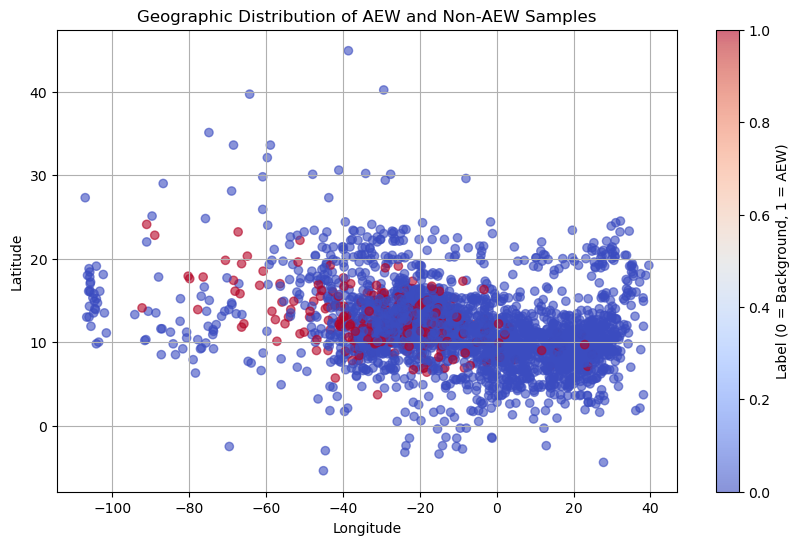

In [19]:
import matplotlib.pyplot as plt

# Scatter plot: where are the samples located, colored by label (AEW or not)
plt.figure(figsize=(10, 6))
sc = plt.scatter(sample_lon, sample_lat, c=labels_, cmap='coolwarm', alpha=0.6)
plt.colorbar(sc, label="Label (0 = Background, 1 = AEW)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographic Distribution of AEW and Non-AEW Samples")
plt.grid(True)
plt.show()


In [20]:
print(var_list)


['cape', 'crr', 'd', 'ie', 'ishf', 'lsrr', 'pv', 'q', 'r', 'sp', 'tcw', 'tcwv', 't', 'ttr', 'u', 'v', 'vo', 'w']


In [21]:
# check / remove nans

data_, labels_, sample_lat, sample_lon = omit_nans(data_, labels_, sample_lat, sample_lon)






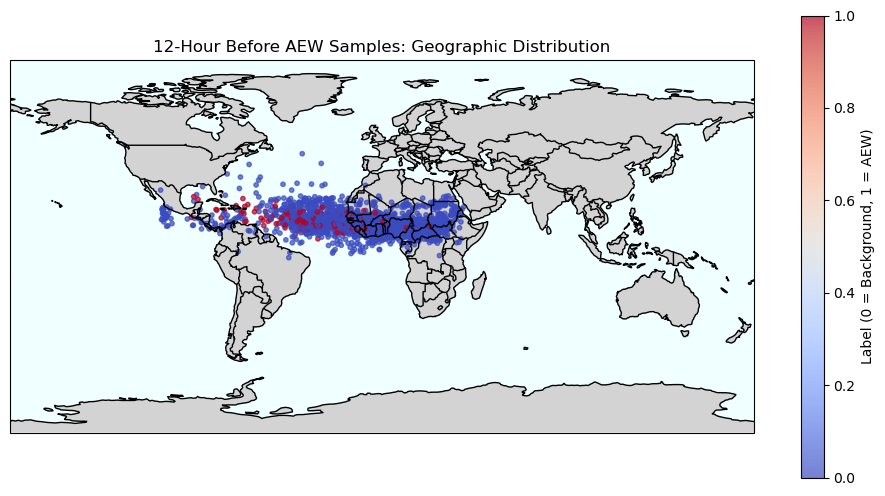

In [22]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize=(12, 6))

# Set up map projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='azure')

# Plot sample locations colored by label
sc = ax.scatter(sample_lon, sample_lat, c=labels_, cmap='coolwarm', s=10, alpha=0.7, transform=ccrs.PlateCarree())
plt.colorbar(sc, ax=ax, label="Label (0 = Background, 1 = AEW)")
plt.title("12-Hour Before AEW Samples: Geographic Distribution")
plt.show()

In [23]:
print("Total samples:", len(sample_lat))


Total samples: 2750


In [24]:
print("Latitude Range:", float(sample_lat.min().compute()), "to", float(sample_lat.max().compute()))
print("Longitude Range:", float(sample_lon.min().compute()), "to", float(sample_lon.max().compute()))


Latitude Range: -5.4 to 44.9
Longitude Range: -107.1 to 39.6


In [25]:
#split train and test set
X_train, X_test, y_train, y_test, lat_train, lat_test, lon_train, lon_test = sklearn.model_selection.train_test_split(
    data_, labels_, sample_lat, sample_lon, test_size=0.2, random_state=42)



print (np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))


y_train = np.expand_dims(y_train, axis=1)

y_test = np.expand_dims(y_test, axis=1)

(2200, 32, 32, 20) (550, 32, 32, 20) (2200,) (550,)


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1642: PerformanceWarning: Slicing with an out-of-order index is generating 412 times more chunks
  return self.array[key]
/glade/u/home/rmandava/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1642: PerformanceWarning: Slicing with an out-of-order index is generating 109 times more chunks
  return self.array[key]


In [26]:
# [21]: Scaling code (fixed to prevent data leakage)

# Create the scaler object
scaler_input = sklearn.preprocessing.StandardScaler()

# Reshape training data to 2D (samples, features)
X_train_tmp = X_train.reshape((-1, X_train.shape[-1]))


# Fit the scaler ONLY on the training data
scaler_input.fit(X_train_tmp)  # <-- Key change: Learn mean/std from training data

# Transform BOTH training and test data using the SAME scaler
input_train_scaled = scaler_input.transform(X_train_tmp)          # Train: transform only
X_test_tmp = X_test.reshape((-1, X_test.shape[-1]))
input_test_scaled = scaler_input.transform(X_test_tmp)
input_test_scaled = input_test_scaled.reshape(X_test.shape)


# Reshape back to original dimensions (samples, height, width, features)
input_train_scaled = np.reshape(input_train_scaled, X_train.shape)
input_test_scaled = np.reshape(input_test_scaled, X_test.shape)

# Labels remain unchanged
label_train_scaled = y_train
label_test_scaled = y_test

In [27]:
# print the shapes to double check them

print(

input_train_scaled.shape,

label_train_scaled.shape,

input_test_scaled.shape,

label_test_scaled.shape

)

(2200, 32, 32, 20) (2200, 1) (550, 32, 32, 20) (550, 1)


In [28]:
from imblearn.over_sampling import SMOTE

# Flatten the 4D training data to 2D (samples, features)
X_train_flat = input_train_scaled.reshape((input_train_scaled.shape[0], -1))

# SMOTE expects 2D input and 1D labels
y_train_flat = label_train_scaled.ravel()

# Apply SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train_flat, y_train_flat)

# Reshape back to 4D for CNN
X_train_balanced = X_smote.reshape((-1, 32, 32, input_train_scaled.shape[-1]))
y_train_balanced = y_smote.reshape(-1, 1)

# Check results
print("Balanced training shape:", X_train_balanced.shape, y_train_balanced.shape)
print("Balanced class counts:", np.bincount(y_train_balanced.astype(int).ravel()))





Balanced training shape: (3992, 32, 32, 20) (3992, 1)
Balanced class counts: [1996 1996]


In [29]:
# Reshape y to match output shape (N, 1)
y_train_balanced = y_train_balanced.reshape(-1, 1)
label_test_scaled = label_test_scaled.reshape(-1, 1)


In [30]:
number_of_features = X_train_balanced.shape[-1]


In [31]:
#generate class weights due to class imbalance issues

counts = np.bincount(y_train[:, 0].astype(int))


print(

"Number of positive samples in training data: {} ({:.2f}% of total)".format(

counts[1], 100 * float(counts[1]) / len(y_train))

)

Number of positive samples in training data: 204 (9.27% of total)


In [32]:
# old weights

# weight_for_0 = 1.0 / counts[0]

# weight_for_1 = 1.0 / counts[1]


#new weights

weight_for_0 = float(counts[1]) / len(y_train)

weight_for_1 = 1 - (float(counts[1]) / len(y_train))


class_weight = {0: weight_for_0, 1: weight_for_1}

print(class_weight)

{0: 0.09272727272727273, 1: 0.9072727272727272}


In [33]:
METRICS = [

keras.metrics.BinaryCrossentropy(name='cross entropy'),

keras.metrics.MeanSquaredError(name='mean_squared_error'),

keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),

keras.metrics.TruePositives(name='tp'),

keras.metrics.FalsePositives(name='fp'),

keras.metrics.TrueNegatives(name='tn'),

keras.metrics.FalseNegatives(name='fn'),

keras.metrics.BinaryAccuracy(name='binary_accuracy'),

keras.metrics.F1Score(threshold=0.5, name='f1_score'),

keras.metrics.Precision(name='precision'),

keras.metrics.Recall(name='recall'),

keras.metrics.AUC(name='auc'),

keras.metrics.AUC(name='prc', curve='PR'),

]

2025-08-03 23:50:45.492688: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [34]:
class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        model = keras.Sequential()

        model.add(keras.Input(shape=(32, 32, number_of_features)))

        # Data augmentation
        model.add(layers.RandomFlip("horizontal_and_vertical"))
        model.add(layers.RandomRotation(factor=(-0.5, 0.5)))

        # CNN layers (same tuning as before)
        featmaps1 = hp.Int('units_1', min_value=10, max_value=60)
        featmaps2 = hp.Int('units_2', min_value=10, max_value=64)
        featmaps3 = hp.Int('units_3', min_value=10, max_value=128)
        featmaps4 = hp.Int('units_4', min_value=10, max_value=80)
        learning_rate = hp.Float('lr', min_value=0.00001, max_value=0.01, sampling="linear")
        act_func = hp.Choice('activation', ["relu", "tanh", "selu", "sigmoid", "relu6", "silu", "gelu"])

        model.add(layers.Conv2D(featmaps1, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.Conv2D(featmaps2, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.Conv2D(featmaps3, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.GlobalMaxPooling2D())
        model.add(layers.Dense(featmaps4))
        model.add(layers.Dense(1, activation="sigmoid"))

        
        

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss=focal_loss(gamma=2.0, alpha=0.25),  # pass tuned gamma and alpha!
            metrics=METRICS
        )

        return model



In [35]:
def fit(self, hp, model, *args, **kwargs):
    batchsizenum = hp.Int('batch_size', min_value=10, max_value=60, step=5, sampling="linear")

    print({k: hp.get(k) if hp.is_active(k) else None for k in hp._hps})

    return model.fit(
        *args,
        batch_size=batchsizenum,
        # normally we might use early stopping, but not needed since
        # callbacks saves checkpoints of the model during trials
        # callbacks=keras.callbacks.EarlyStopping('val_loss', patience=5),
        validation_split=0.1,
        shuffle=True,
        #class_weight=class_weight,
        **kwargs,
    )


In [36]:
# make the tuner object
tuner = keras_tuner.BayesianOptimization(
    hypermodel=MyHyperModel(),
    objective=keras_tuner.Objective("val_f1_score", direction="max"),
    max_trials=5,
    project_name=tuner_project_name,
    alpha=0.0001,
    beta=2.6,
    seed=123,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=1,
    max_consecutive_failed_trials=3,
    overwrite=True,
)

# summary
tuner.search_space_summary()


Search space summary
Default search space size: 6
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 60, 'step': 1, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 64, 'step': 1, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 128, 'step': 1, 'sampling': 'linear'}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 80, 'step': 1, 'sampling': 'linear'}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'selu', 'sigmoid', 'relu6', 'silu', 'gelu'], 'ordered': False}


In [37]:
import numpy as np

labels_np = np.array(labels_)

total = len(labels_np)
positives = np.sum(labels_np == 1)
negatives = np.sum(labels_np == 0)

print("Total samples:", total)
print("AEW-positive samples (label=1):", positives)
print("Background samples (label=0):", negatives)


Total samples: 2750
AEW-positive samples (label=1): 258
Background samples (label=0): 2492


In [38]:
# Begin the search
EPOCHS = 100

# Use oversampled, balanced training data
tuner.search(
    X_train_balanced,
    y_train_balanced,
    epochs=EPOCHS,
    validation_split=0.1
)

# Query the tuner object to grab the best models
models = tuner.get_best_models(num_models=5)

# Best model from tuner
best_model = models[0]
print(best_model.summary())

# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters()

# Build final model from best hyperparameters
model = MyHyperModel().build(best_hps[0])

# Save model
save_dir = "/glade/derecho/scratch/rmandava/AEW_time_location_files/models"
model_save_path = os.path.join(save_dir, model_save_name)
model.save(model_save_path)

# Retrain on full balanced training set (no class_weight)
history = model.fit(
    X_train_balanced,
    y_train_balanced,
    epochs=EPOCHS,
    validation_split=0.1,
    batch_size=32,
    shuffle=True
)

# Evaluate on untouched test set
results = model.evaluate(input_test_scaled, label_test_scaled, batch_size=label_test_scaled.shape[0])
print(results)

# Predict
predictions = model.predict(input_test_scaled)
print("predictions shape:", predictions.shape)

# Confusion matrix
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(
    label_test_scaled, np.round(predictions)
).ravel()
print("tn:", tn)
print("fp:", fp)
print("fn:", fn)
print("tp:", tp)


Trial 5 Complete [00h 02m 29s]
val_f1_score: 0.9375829696655273

Best val_f1_score So Far: 1.0
Total elapsed time: 00h 11m 32s


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 32, 32, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 32, 32, 20)     │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 12)     │         2,172 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 62)     │         6,758 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 62)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 62)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 117)      │        65,403 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 117)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 117)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 117)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         5,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,284 (313.61 KB)

 Trainable params: 80,284 (313.61 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - auc: 0.7532 - binary_accuracy: 0.5184 - cross entropy: 0.6942 - f1_score: 0.3699 - fn: 854.6316 - fp: 80.9123 - loss: 0.0774 - mean_squared_error: 0.2516 - prc: 0.7512 - precision: 0.7541 - recall: 0.2536 - root_mean_squared_error: 0.4995 - tn: 937.9298 - tp: 365.8246 - val_auc: 0.0000e+00 - val_binary_accuracy: 0.7550 - val_cross entropy: 0.6418 - val_f1_score: 0.8604 - val_fn: 98.0000 - val_fp: 0.0000e+00 - val_loss: 0.0394 - val_mean_squared_error: 0.2240 - val_prc: 1.0000 - val_precision: 1.0000 - val_recall: 0.7550 - val_root_mean_squared_error: 0.4733 - val_tn: 0.0000e+00 - val_tp: 302.0000
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9168 - binary_accuracy: 0.7993 - cross entropy: 0.4611 - f1_score: 0.7288 - fn: 296.1930 - fp: 59.0175 - loss: 0.0401 - mean_squared_error: 0.1504 - prc: 0.8904 - precision: 0.8953 - recall: 0.6160 - root_mean_squared_error: 0.3877 - tn: 959.8246 - tp: 524.2632 - val_auc:

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7456 - binary_accuracy: 0.8165 - cross entropy: 0.4219 - f1_score: 0.2877 - fn: 54.2000 - fp: 156.7818 - loss: 0.0275 - mean_squared_error: 0.1337 - prc: 0.2105 - precision: 0.2150 - recall: 0.4369 - root_mean_squared_error: 0.3655 - tn: 858.8546 - tp: 46.1636

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7490 - binary_accuracy: 0.8171 - cross entropy: 0.4210 - f1_score: 0.2931 - fn: 58.2459 - fp: 168.4918 - loss: 0.0264 - mean_squared_error: 0.1333 - prc: 0.2137 - precision: 0.2194 - recall: 0.4435 - root_mean_squared_error: 0.3650 - tn: 934.1312 - tp: 51.1311

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - auc: 0.7500 - binary_accuracy: 0.8173 - cross entropy: 0.4207 - f1_score: 0.2948 - fn: 59.6667 - fp: 172.0635 - loss: 0.0261 - mean_squared_error: 0.1332 - prc: 0.2147 - precision: 0.2208 - recall: 0.4451 - root_mean_squared_error: 0.3648 - tn: 958.9207 - tp: 52.7143 - val_auc: 0.8688 - val_binary_accuracy: 0.6364 - val_cross entropy: 0.5507 - val_f1_score: 0.2308 - val_fn: 1.0000 - val_fp: 79.0000 - val_loss: 0.1039 - val_mean_squared_error: 0.1910 - val_prc: 0.3268 - val_precision: 0.1319 - val_recall: 0.9231 - val_root_mean_squared_error: 0.4371 - val_tn: 128.0000 - val_tp: 12.0000


Epoch 2/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.7667 - binary_accuracy: 0.5000 - cross entropy: 0.6108 - f1_score: 0.2000 - fn: 0.0000e+00 - fp: 16.0000 - loss: 0.0130 - mean_squared_error: 0.2181 - prc: 0.2050 - precision: 0.1111 - recall: 1.0000 - root_mean_squared_error: 0.4670 - tn: 14.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8336 - binary_accuracy: 0.6457 - cross entropy: 0.5399 - f1_score: 0.2660 - fn: 1.1429 - fp: 37.4286 - loss: 0.0109 - mean_squared_error: 0.1857 - prc: 0.2457 - precision: 0.1585 - recall: 0.9183 - root_mean_squared_error: 0.4298 - tn: 81.8571 - tp: 7.5714    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8012 - binary_accuracy: 0.7239 - cross entropy: 0.4881 - f1_score: 0.2895 - fn: 6.7692 - fp: 42.6154 - loss: 0.0111 - mean_squared_error: 0.1622 - prc: 0.2384 - precision: 0.1908 - recall: 0.7393 - root_mean_squared_error: 0.4010 - tn: 163.7692 - tp: 10.8462

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7852 - binary_accuracy: 0.7409 - cross entropy: 0.4816 - f1_score: 0.3010 - fn: 10.5263 - fp: 60.2632 - loss: 0.0114 - mean_squared_error: 0.1590 - prc: 0.2310 - precision: 0.2011 - recall: 0.6963 - root_mean_squared_error: 0.3975 - tn: 232.7895 - tp: 16.4211

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7779 - binary_accuracy: 0.7552 - cross entropy: 0.4748 - f1_score: 0.3116 - fn: 15.9200 - fp: 72.3200 - loss: 0.0115 - mean_squared_error: 0.1557 - prc: 0.2319 - precision: 0.2140 - recall: 0.6577 - root_mean_squared_error: 0.3936 - tn: 306.1600 - tp: 21.6000

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7771 - binary_accuracy: 0.7619 - cross entropy: 0.4726 - f1_score: 0.3220 - fn: 20.0645 - fp: 88.1613 - loss: 0.0116 - mean_squared_error: 0.1545 - prc: 0.2447 - precision: 0.2236 - recall: 0.6457 - root_mean_squared_error: 0.3922 - tn: 375.6774 - tp: 28.0968

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7777 - binary_accuracy: 0.7683 - cross entropy: 0.4687 - f1_score: 0.3283 - fn: 23.6667 - fp: 98.5000 - loss: 0.0116 - mean_squared_error: 0.1527 - prc: 0.2526 - precision: 0.2302 - recall: 0.6350 - root_mean_squared_error: 0.3900 - tn: 437.2222 - tp: 32.6111

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7796 - binary_accuracy: 0.7753 - cross entropy: 0.4637 - f1_score: 0.3354 - fn: 28.1667 - fp: 109.5952 - loss: 0.0115 - mean_squared_error: 0.1504 - prc: 0.2636 - precision: 0.2381 - recall: 0.6243 - root_mean_squared_error: 0.3871 - tn: 512.2143 - tp: 38.0238

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7827 - binary_accuracy: 0.7799 - cross entropy: 0.4607 - f1_score: 0.3429 - fn: 31.4043 - fp: 119.4681 - loss: 0.0115 - mean_squared_error: 0.1490 - prc: 0.2785 - precision: 0.2453 - recall: 0.6221 - root_mean_squared_error: 0.3853 - tn: 573.6808 - tp: 43.4468

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7857 - binary_accuracy: 0.7847 - cross entropy: 0.4570 - f1_score: 0.3491 - fn: 34.5192 - fp: 128.0192 - loss: 0.0114 - mean_squared_error: 0.1473 - prc: 0.2906 - precision: 0.2515 - recall: 0.6195 - root_mean_squared_error: 0.3832 - tn: 637.1923 - tp: 48.2692

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7889 - binary_accuracy: 0.7901 - cross entropy: 0.4527 - f1_score: 0.3556 - fn: 38.1552 - fp: 137.4828 - loss: 0.0113 - mean_squared_error: 0.1454 - prc: 0.3023 - precision: 0.2581 - recall: 0.6166 - root_mean_squared_error: 0.3806 - tn: 714.6207 - tp: 53.7414

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.7915 - binary_accuracy: 0.7941 - cross entropy: 0.4494 - f1_score: 0.3602 - fn: 41.2381 - fp: 145.0159 - loss: 0.0112 - mean_squared_error: 0.1439 - prc: 0.3107 - precision: 0.2630 - recall: 0.6142 - root_mean_squared_error: 0.3787 - tn: 778.9683 - tp: 58.1429 - val_auc: 0.8815 - val_binary_accuracy: 0.7864 - val_cross entropy: 0.4691 - val_f1_score: 0.3380 - val_fn: 1.0000 - val_fp: 46.0000 - val_loss: 0.0738 - val_mean_squared_error: 0.1510 - val_prc: 0.3571 - val_precision: 0.2069 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3886 - val_tn: 161.0000 - val_tp: 12.0000


Epoch 3/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.8167 - binary_accuracy: 0.7500 - cross entropy: 0.4894 - f1_score: 0.2000 - fn: 1.0000 - fp: 7.0000 - loss: 0.0087 - mean_squared_error: 0.1590 - prc: 0.2184 - precision: 0.1250 - recall: 0.5000 - root_mean_squared_error: 0.3988 - tn: 23.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8800 - binary_accuracy: 0.8118 - cross entropy: 0.4448 - f1_score: 0.3322 - fn: 2.7143 - fp: 18.2857 - loss: 0.0077 - mean_squared_error: 0.1399 - prc: 0.3623 - precision: 0.2253 - recall: 0.6719 - root_mean_squared_error: 0.3735 - tn: 101.0000 - tp: 6.0000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8620 - binary_accuracy: 0.8392 - cross entropy: 0.4188 - f1_score: 0.3566 - fn: 8.0000 - fp: 23.5385 - loss: 0.0081 - mean_squared_error: 0.1290 - prc: 0.3658 - precision: 0.2671 - recall: 0.5912 - root_mean_squared_error: 0.3584 - tn: 182.8462 - tp: 9.6154

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8540 - binary_accuracy: 0.8394 - cross entropy: 0.4178 - f1_score: 0.3671 - fn: 11.7895 - fp: 36.4211 - loss: 0.0085 - mean_squared_error: 0.1287 - prc: 0.3566 - precision: 0.2761 - recall: 0.5860 - root_mean_squared_error: 0.3583 - tn: 256.6316 - tp: 15.1579

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8496 - binary_accuracy: 0.8417 - cross entropy: 0.4162 - f1_score: 0.3759 - fn: 16.0000 - fp: 44.1250 - loss: 0.0087 - mean_squared_error: 0.1281 - prc: 0.3554 - precision: 0.2877 - recall: 0.5750 - root_mean_squared_error: 0.3576 - tn: 320.2500 - tp: 19.6250

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8471 - binary_accuracy: 0.8403 - cross entropy: 0.4177 - f1_score: 0.3858 - fn: 20.0000 - fp: 57.2000 - loss: 0.0089 - mean_squared_error: 0.1289 - prc: 0.3639 - precision: 0.2963 - recall: 0.5797 - root_mean_squared_error: 0.3587 - tn: 392.3333 - tp: 26.4667

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8457 - binary_accuracy: 0.8410 - cross entropy: 0.4170 - f1_score: 0.3931 - fn: 23.7500 - fp: 68.3889 - loss: 0.0090 - mean_squared_error: 0.1287 - prc: 0.3685 - precision: 0.3028 - recall: 0.5826 - root_mean_squared_error: 0.3584 - tn: 467.3333 - tp: 32.5278

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8450 - binary_accuracy: 0.8426 - cross entropy: 0.4149 - f1_score: 0.3999 - fn: 27.7381 - fp: 77.9524 - loss: 0.0091 - mean_squared_error: 0.1279 - prc: 0.3743 - precision: 0.3100 - recall: 0.5834 - root_mean_squared_error: 0.3574 - tn: 543.8571 - tp: 38.4524

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8459 - binary_accuracy: 0.8434 - cross entropy: 0.4137 - f1_score: 0.4072 - fn: 31.2083 - fp: 88.7500 - loss: 0.0092 - mean_squared_error: 0.1275 - prc: 0.3855 - precision: 0.3164 - recall: 0.5887 - root_mean_squared_error: 0.3569 - tn: 618.7917 - tp: 45.2500

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8464 - binary_accuracy: 0.8446 - cross entropy: 0.4115 - f1_score: 0.4115 - fn: 34.9259 - fp: 98.3519 - loss: 0.0092 - mean_squared_error: 0.1267 - prc: 0.3931 - precision: 0.3207 - recall: 0.5898 - root_mean_squared_error: 0.3558 - tn: 695.7963 - tp: 50.9259

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8470 - binary_accuracy: 0.8459 - cross entropy: 0.4093 - f1_score: 0.4146 - fn: 38.6167 - fp: 107.4833 - loss: 0.0092 - mean_squared_error: 0.1259 - prc: 0.3997 - precision: 0.3240 - recall: 0.5900 - root_mean_squared_error: 0.3546 - tn: 773.6667 - tp: 56.2333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8472 - binary_accuracy: 0.8465 - cross entropy: 0.4084 - f1_score: 0.4160 - fn: 40.5397 - fp: 111.8571 - loss: 0.0092 - mean_squared_error: 0.1255 - prc: 0.4025 - precision: 0.3256 - recall: 0.5897 - root_mean_squared_error: 0.3541 - tn: 812.1270 - tp: 58.8413 - val_auc: 0.8753 - val_binary_accuracy: 0.7864 - val_cross entropy: 0.4686 - val_f1_score: 0.3188 - val_fn: 2.0000 - val_fp: 45.0000 - val_loss: 0.0773 - val_mean_squared_error: 0.1518 - val_prc: 0.3529 - val_precision: 0.1964 - val_recall: 0.8462 - val_root_mean_squared_error: 0.3896 - val_tn: 162.0000 - val_tp: 11.0000


Epoch 4/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.7833 - binary_accuracy: 0.7188 - cross entropy: 0.5123 - f1_score: 0.1818 - fn: 1.0000 - fp: 8.0000 - loss: 0.0105 - mean_squared_error: 0.1718 - prc: 0.5515 - precision: 0.1111 - recall: 0.5000 - root_mean_squared_error: 0.4145 - tn: 22.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8739 - binary_accuracy: 0.8099 - cross entropy: 0.4512 - f1_score: 0.3544 - fn: 2.0000 - fp: 18.8571 - loss: 0.0082 - mean_squared_error: 0.1443 - prc: 0.4815 - precision: 0.2371 - recall: 0.7404 - root_mean_squared_error: 0.3790 - tn: 100.4286 - tp: 6.7143

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8593 - binary_accuracy: 0.8416 - cross entropy: 0.4176 - f1_score: 0.3798 - fn: 7.3846 - fp: 22.7692 - loss: 0.0085 - mean_squared_error: 0.1297 - prc: 0.4421 - precision: 0.2848 - recall: 0.6393 - root_mean_squared_error: 0.3590 - tn: 183.6154 - tp: 10.2308

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8514 - binary_accuracy: 0.8441 - cross entropy: 0.4157 - f1_score: 0.3898 - fn: 11.1053 - fp: 34.5789 - loss: 0.0087 - mean_squared_error: 0.1289 - prc: 0.4341 - precision: 0.2947 - recall: 0.6240 - root_mean_squared_error: 0.3582 - tn: 258.4737 - tp: 15.8421

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8470 - binary_accuracy: 0.8474 - cross entropy: 0.4142 - f1_score: 0.4008 - fn: 17.0000 - fp: 44.8077 - loss: 0.0090 - mean_squared_error: 0.1281 - prc: 0.4349 - precision: 0.3109 - recall: 0.6039 - root_mean_squared_error: 0.3573 - tn: 347.8077 - tp: 22.3846

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8457 - binary_accuracy: 0.8476 - cross entropy: 0.4154 - f1_score: 0.4091 - fn: 20.8750 - fp: 56.1250 - loss: 0.0091 - mean_squared_error: 0.1286 - prc: 0.4386 - precision: 0.3187 - recall: 0.6037 - root_mean_squared_error: 0.3581 - tn: 422.0625 - tp: 28.9375

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8455 - binary_accuracy: 0.8497 - cross entropy: 0.4139 - f1_score: 0.4153 - fn: 24.9737 - fp: 64.8421 - loss: 0.0091 - mean_squared_error: 0.1279 - prc: 0.4405 - precision: 0.3262 - recall: 0.5999 - root_mean_squared_error: 0.3572 - tn: 499.6579 - tp: 34.5263

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8465 - binary_accuracy: 0.8519 - cross entropy: 0.4119 - f1_score: 0.4228 - fn: 29.1136 - fp: 72.6818 - loss: 0.0091 - mean_squared_error: 0.1270 - prc: 0.4463 - precision: 0.3352 - recall: 0.5981 - root_mean_squared_error: 0.3561 - tn: 577.6136 - tp: 40.5909

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8480 - binary_accuracy: 0.8535 - cross entropy: 0.4105 - f1_score: 0.4290 - fn: 32.7600 - fp: 81.4600 - loss: 0.0091 - mean_squared_error: 0.1265 - prc: 0.4517 - precision: 0.3416 - recall: 0.5994 - root_mean_squared_error: 0.3553 - tn: 654.9400 - tp: 46.8400

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8491 - binary_accuracy: 0.8552 - cross entropy: 0.4085 - f1_score: 0.4336 - fn: 36.3750 - fp: 89.5179 - loss: 0.0091 - mean_squared_error: 0.1257 - prc: 0.4552 - precision: 0.3467 - recall: 0.5995 - root_mean_squared_error: 0.3542 - tn: 733.5893 - tp: 52.5179

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8502 - binary_accuracy: 0.8570 - cross entropy: 0.4063 - f1_score: 0.4374 - fn: 40.0645 - fp: 96.8226 - loss: 0.0091 - mean_squared_error: 0.1247 - prc: 0.4577 - precision: 0.3513 - recall: 0.5987 - root_mean_squared_error: 0.3529 - tn: 813.2097 - tp: 57.8387

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8503 - binary_accuracy: 0.8573 - cross entropy: 0.4059 - f1_score: 0.4380 - fn: 40.6825 - fp: 97.9841 - loss: 0.0091 - mean_squared_error: 0.1246 - prc: 0.4580 - precision: 0.3520 - recall: 0.5985 - root_mean_squared_error: 0.3527 - tn: 826.0000 - tp: 58.6984 - val_auc: 0.8779 - val_binary_accuracy: 0.7364 - val_cross entropy: 0.5248 - val_f1_score: 0.2927 - val_fn: 1.0000 - val_fp: 57.0000 - val_loss: 0.0966 - val_mean_squared_error: 0.1770 - val_prc: 0.3499 - val_precision: 0.1739 - val_recall: 0.9231 - val_root_mean_squared_error: 0.4207 - val_tn: 150.0000 - val_tp: 12.0000


Epoch 5/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - auc: 0.7833 - binary_accuracy: 0.6875 - cross entropy: 0.5338 - f1_score: 0.1667 - fn: 1.0000 - fp: 9.0000 - loss: 0.0112 - mean_squared_error: 0.1798 - prc: 0.1543 - precision: 0.1000 - recall: 0.5000 - root_mean_squared_error: 0.4241 - tn: 21.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8580 - binary_accuracy: 0.7506 - cross entropy: 0.4886 - f1_score: 0.2708 - fn: 2.8571 - fp: 25.1429 - loss: 0.0094 - mean_squared_error: 0.1605 - prc: 0.3669 - precision: 0.1735 - recall: 0.6624 - root_mean_squared_error: 0.3999 - tn: 94.1429 - tp: 5.8571

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8403 - binary_accuracy: 0.7972 - cross entropy: 0.4464 - f1_score: 0.2986 - fn: 8.6154 - fp: 29.3846 - loss: 0.0094 - mean_squared_error: 0.1423 - prc: 0.3634 - precision: 0.2152 - recall: 0.5657 - root_mean_squared_error: 0.3759 - tn: 177.0000 - tp: 9.0000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8327 - binary_accuracy: 0.8088 - cross entropy: 0.4375 - f1_score: 0.3244 - fn: 13.1000 - fp: 43.8000 - loss: 0.0096 - mean_squared_error: 0.1384 - prc: 0.3646 - precision: 0.2375 - recall: 0.5637 - root_mean_squared_error: 0.3711 - tn: 263.6000 - tp: 15.5000

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8311 - binary_accuracy: 0.8162 - cross entropy: 0.4333 - f1_score: 0.3449 - fn: 17.6923 - fp: 53.6923 - loss: 0.0096 - mean_squared_error: 0.1365 - prc: 0.3710 - precision: 0.2583 - recall: 0.5633 - root_mean_squared_error: 0.3687 - tn: 338.9231 - tp: 21.6923

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8328 - binary_accuracy: 0.8214 - cross entropy: 0.4311 - f1_score: 0.3641 - fn: 21.8182 - fp: 66.8485 - loss: 0.0096 - mean_squared_error: 0.1355 - prc: 0.3815 - precision: 0.2751 - recall: 0.5739 - root_mean_squared_error: 0.3675 - tn: 425.7273 - tp: 29.6061

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8349 - binary_accuracy: 0.8263 - cross entropy: 0.4271 - f1_score: 0.3762 - fn: 25.5897 - fp: 75.7179 - loss: 0.0096 - mean_squared_error: 0.1338 - prc: 0.3878 - precision: 0.2870 - recall: 0.5770 - root_mean_squared_error: 0.3652 - tn: 503.2051 - tp: 35.4872

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8381 - binary_accuracy: 0.8304 - cross entropy: 0.4235 - f1_score: 0.3880 - fn: 29.4222 - fp: 84.3556 - loss: 0.0095 - mean_squared_error: 0.1323 - prc: 0.4000 - precision: 0.2988 - recall: 0.5812 - root_mean_squared_error: 0.3632 - tn: 580.1778 - tp: 42.0444

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8412 - binary_accuracy: 0.8339 - cross entropy: 0.4202 - f1_score: 0.3974 - fn: 32.8627 - fp: 93.0784 - loss: 0.0094 - mean_squared_error: 0.1309 - prc: 0.4113 - precision: 0.3079 - recall: 0.5857 - root_mean_squared_error: 0.3614 - tn: 657.7255 - tp: 48.3333

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8440 - binary_accuracy: 0.8372 - cross entropy: 0.4166 - f1_score: 0.4043 - fn: 36.5088 - fp: 100.8246 - loss: 0.0093 - mean_squared_error: 0.1295 - prc: 0.4195 - precision: 0.3153 - recall: 0.5872 - root_mean_squared_error: 0.3593 - tn: 736.7719 - tp: 53.8947

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8463 - binary_accuracy: 0.8403 - cross entropy: 0.4132 - f1_score: 0.4103 - fn: 40.1587 - fp: 107.9841 - loss: 0.0092 - mean_squared_error: 0.1281 - prc: 0.4256 - precision: 0.3218 - recall: 0.5879 - root_mean_squared_error: 0.3574 - tn: 816.0000 - tp: 59.2222 - val_auc: 0.9032 - val_binary_accuracy: 0.8091 - val_cross entropy: 0.4650 - val_f1_score: 0.3636 - val_fn: 1.0000 - val_fp: 41.0000 - val_loss: 0.0752 - val_mean_squared_error: 0.1503 - val_prc: 0.3999 - val_precision: 0.2264 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3877 - val_tn: 166.0000 - val_tp: 12.0000


Epoch 6/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 38s 638ms/step - auc: 0.8000 - binary_accuracy: 0.7188 - cross entropy: 0.4889 - f1_score: 0.1818 - fn: 1.0000 - fp: 8.0000 - loss: 0.0098 - mean_squared_error: 0.1609 - prc: 0.5554 - precision: 0.1111 - recall: 0.5000 - root_mean_squared_error: 0.4011 - tn: 22.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8547 - binary_accuracy: 0.8010 - cross entropy: 0.4426 - f1_score: 0.3184 - fn: 2.8571 - fp: 19.1429 - loss: 0.0084 - mean_squared_error: 0.1406 - prc: 0.4717 - precision: 0.2144 - recall: 0.6624 - root_mean_squared_error: 0.3743 - tn: 100.1429 - tp: 5.8571

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8516 - binary_accuracy: 0.8341 - cross entropy: 0.4133 - f1_score: 0.3417 - fn: 8.6154 - fp: 23.0769 - loss: 0.0084 - mean_squared_error: 0.1277 - prc: 0.4534 - precision: 0.2588 - recall: 0.5687 - root_mean_squared_error: 0.3564 - tn: 183.3077 - tp: 9.0000

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8499 - binary_accuracy: 0.8441 - cross entropy: 0.4099 - f1_score: 0.3621 - fn: 13.0526 - fp: 30.9474 - loss: 0.0085 - mean_squared_error: 0.1260 - prc: 0.4414 - precision: 0.2830 - recall: 0.5520 - root_mean_squared_error: 0.3543 - tn: 262.1053 - tp: 13.8947

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8494 - binary_accuracy: 0.8490 - cross entropy: 0.4098 - f1_score: 0.3794 - fn: 16.7917 - fp: 37.5000 - loss: 0.0087 - mean_squared_error: 0.1258 - prc: 0.4388 - precision: 0.3022 - recall: 0.5510 - root_mean_squared_error: 0.3542 - tn: 326.8750 - tp: 18.8333

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8511 - binary_accuracy: 0.8517 - cross entropy: 0.4101 - f1_score: 0.3986 - fn: 20.4333 - fp: 47.1667 - loss: 0.0087 - mean_squared_error: 0.1258 - prc: 0.4439 - precision: 0.3198 - recall: 0.5627 - root_mean_squared_error: 0.3543 - tn: 402.3667 - tp: 26.0333

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8534 - binary_accuracy: 0.8543 - cross entropy: 0.4088 - f1_score: 0.4112 - fn: 23.8889 - fp: 56.1667 - loss: 0.0087 - mean_squared_error: 0.1253 - prc: 0.4496 - precision: 0.3312 - recall: 0.5706 - root_mean_squared_error: 0.3536 - tn: 479.5555 - tp: 32.3889

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8553 - binary_accuracy: 0.8571 - cross entropy: 0.4062 - f1_score: 0.4209 - fn: 27.9524 - fp: 63.4286 - loss: 0.0087 - mean_squared_error: 0.1243 - prc: 0.4548 - precision: 0.3419 - recall: 0.5724 - root_mean_squared_error: 0.3522 - tn: 558.3810 - tp: 38.2381 

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8577 - binary_accuracy: 0.8587 - cross entropy: 0.4047 - f1_score: 0.4298 - fn: 31.5625 - fp: 72.0417 - loss: 0.0087 - mean_squared_error: 0.1237 - prc: 0.4637 - precision: 0.3503 - recall: 0.5779 - root_mean_squared_error: 0.3514 - tn: 635.5000 - tp: 44.8958

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8593 - binary_accuracy: 0.8604 - cross entropy: 0.4026 - f1_score: 0.4351 - fn: 35.3704 - fp: 79.8519 - loss: 0.0087 - mean_squared_error: 0.1229 - prc: 0.4692 - precision: 0.3559 - recall: 0.5794 - root_mean_squared_error: 0.3503 - tn: 714.2963 - tp: 50.4815

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8609 - binary_accuracy: 0.8623 - cross entropy: 0.4003 - f1_score: 0.4392 - fn: 39.3167 - fp: 86.6167 - loss: 0.0086 - mean_squared_error: 0.1220 - prc: 0.4734 - precision: 0.3610 - recall: 0.5789 - root_mean_squared_error: 0.3490 - tn: 794.5333 - tp: 55.5333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8615 - binary_accuracy: 0.8631 - cross entropy: 0.3993 - f1_score: 0.4410 - fn: 41.3492 - fp: 89.8730 - loss: 0.0086 - mean_squared_error: 0.1216 - prc: 0.4750 - precision: 0.3633 - recall: 0.5784 - root_mean_squared_error: 0.3484 - tn: 834.1111 - tp: 58.0317 - val_auc: 0.9012 - val_binary_accuracy: 0.8273 - val_cross entropy: 0.4451 - val_f1_score: 0.3871 - val_fn: 1.0000 - val_fp: 37.0000 - val_loss: 0.0691 - val_mean_squared_error: 0.1416 - val_prc: 0.4196 - val_precision: 0.2449 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3763 - val_tn: 170.0000 - val_tp: 12.0000


Epoch 7/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.8500 - binary_accuracy: 0.7500 - cross entropy: 0.4685 - f1_score: 0.2000 - fn: 1.0000 - fp: 7.0000 - loss: 0.0089 - mean_squared_error: 0.1512 - prc: 0.5711 - precision: 0.1250 - recall: 0.5000 - root_mean_squared_error: 0.3888 - tn: 23.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8903 - binary_accuracy: 0.8283 - cross entropy: 0.4240 - f1_score: 0.3298 - fn: 3.4286 - fp: 15.4286 - loss: 0.0075 - mean_squared_error: 0.1323 - prc: 0.5497 - precision: 0.2338 - recall: 0.6035 - root_mean_squared_error: 0.3632 - tn: 103.8571 - tp: 5.2857

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8790 - binary_accuracy: 0.8579 - cross entropy: 0.3993 - f1_score: 0.3852 - fn: 7.7692 - fp: 19.1538 - loss: 0.0077 - mean_squared_error: 0.1218 - prc: 0.5121 - precision: 0.3043 - recall: 0.5746 - root_mean_squared_error: 0.3484 - tn: 187.2308 - tp: 9.8462

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8721 - binary_accuracy: 0.8616 - cross entropy: 0.3973 - f1_score: 0.4108 - fn: 11.5000 - fp: 31.0000 - loss: 0.0080 - mean_squared_error: 0.1210 - prc: 0.4810 - precision: 0.3251 - recall: 0.5906 - root_mean_squared_error: 0.3475 - tn: 276.4000 - tp: 17.1000

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8694 - binary_accuracy: 0.8632 - cross entropy: 0.3965 - f1_score: 0.4281 - fn: 15.4231 - fp: 40.0769 - loss: 0.0082 - mean_squared_error: 0.1207 - prc: 0.4737 - precision: 0.3421 - recall: 0.5977 - root_mean_squared_error: 0.3471 - tn: 352.5385 - tp: 23.9615

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8686 - binary_accuracy: 0.8627 - cross entropy: 0.3972 - f1_score: 0.4396 - fn: 18.4688 - fp: 51.3750 - loss: 0.0083 - mean_squared_error: 0.1211 - prc: 0.4730 - precision: 0.3505 - recall: 0.6106 - root_mean_squared_error: 0.3477 - tn: 426.8125 - tp: 31.3438

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8684 - binary_accuracy: 0.8638 - cross entropy: 0.3957 - f1_score: 0.4477 - fn: 21.8421 - fp: 60.3158 - loss: 0.0083 - mean_squared_error: 0.1206 - prc: 0.4729 - precision: 0.3579 - recall: 0.6156 - root_mean_squared_error: 0.3470 - tn: 504.1842 - tp: 37.6579

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8689 - binary_accuracy: 0.8654 - cross entropy: 0.3938 - f1_score: 0.4562 - fn: 25.4545 - fp: 67.9773 - loss: 0.0084 - mean_squared_error: 0.1198 - prc: 0.4760 - precision: 0.3670 - recall: 0.6189 - root_mean_squared_error: 0.3460 - tn: 582.3182 - tp: 44.2500

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8697 - binary_accuracy: 0.8663 - cross entropy: 0.3928 - f1_score: 0.4627 - fn: 28.5800 - fp: 76.8400 - loss: 0.0084 - mean_squared_error: 0.1195 - prc: 0.4786 - precision: 0.3728 - recall: 0.6240 - root_mean_squared_error: 0.3454 - tn: 659.5600 - tp: 51.0200

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8703 - binary_accuracy: 0.8677 - cross entropy: 0.3912 - f1_score: 0.4677 - fn: 31.8750 - fp: 84.3214 - loss: 0.0084 - mean_squared_error: 0.1188 - prc: 0.4798 - precision: 0.3780 - recall: 0.6261 - root_mean_squared_error: 0.3445 - tn: 738.7857 - tp: 57.0179

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8710 - binary_accuracy: 0.8693 - cross entropy: 0.3895 - f1_score: 0.4719 - fn: 35.2903 - fp: 90.9839 - loss: 0.0084 - mean_squared_error: 0.1181 - prc: 0.4809 - precision: 0.3829 - recall: 0.6266 - root_mean_squared_error: 0.3434 - tn: 819.0484 - tp: 62.6129

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8711 - binary_accuracy: 0.8696 - cross entropy: 0.3892 - f1_score: 0.4725 - fn: 35.8571 - fp: 92.0476 - loss: 0.0084 - mean_squared_error: 0.1180 - prc: 0.4812 - precision: 0.3837 - recall: 0.6266 - root_mean_squared_error: 0.3433 - tn: 831.9365 - tp: 63.5238 - val_auc: 0.9008 - val_binary_accuracy: 0.7955 - val_cross entropy: 0.4672 - val_f1_score: 0.3284 - val_fn: 2.0000 - val_fp: 43.0000 - val_loss: 0.0746 - val_mean_squared_error: 0.1491 - val_prc: 0.4275 - val_precision: 0.2037 - val_recall: 0.8462 - val_root_mean_squared_error: 0.3862 - val_tn: 164.0000 - val_tp: 11.0000


Epoch 8/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9000 - binary_accuracy: 0.8125 - cross entropy: 0.4674 - f1_score: 0.2500 - fn: 1.0000 - fp: 5.0000 - loss: 0.0088 - mean_squared_error: 0.1494 - prc: 0.5994 - precision: 0.1667 - recall: 0.5000 - root_mean_squared_error: 0.3865 - tn: 25.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9068 - binary_accuracy: 0.8211 - cross entropy: 0.4380 - f1_score: 0.3143 - fn: 3.0000 - fp: 15.3333 - loss: 0.0077 - mean_squared_error: 0.1368 - prc: 0.6137 - precision: 0.2176 - recall: 0.6041 - root_mean_squared_error: 0.3694 - tn: 89.0000 - tp: 4.6667

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8909 - binary_accuracy: 0.8549 - cross entropy: 0.4043 - f1_score: 0.3509 - fn: 8.0833 - fp: 18.0000 - loss: 0.0076 - mean_squared_error: 0.1226 - prc: 0.5691 - precision: 0.2785 - recall: 0.5314 - root_mean_squared_error: 0.3493 - tn: 174.0833 - tp: 7.8333

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8833 - binary_accuracy: 0.8591 - cross entropy: 0.3989 - f1_score: 0.3726 - fn: 12.2222 - fp: 27.1667 - loss: 0.0078 - mean_squared_error: 0.1206 - prc: 0.5425 - precision: 0.3000 - recall: 0.5314 - root_mean_squared_error: 0.3466 - tn: 251.5556 - tp: 13.0556

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8774 - binary_accuracy: 0.8593 - cross entropy: 0.3977 - f1_score: 0.3869 - fn: 16.7500 - fp: 36.9167 - loss: 0.0081 - mean_squared_error: 0.1202 - prc: 0.5258 - precision: 0.3136 - recall: 0.5350 - root_mean_squared_error: 0.3462 - tn: 327.4583 - tp: 18.8750 

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8748 - binary_accuracy: 0.8593 - cross entropy: 0.3983 - f1_score: 0.4046 - fn: 21.1290 - fp: 48.9355 - loss: 0.0082 - mean_squared_error: 0.1206 - prc: 0.5185 - precision: 0.3284 - recall: 0.5502 - root_mean_squared_error: 0.3469 - tn: 414.9032 - tp: 27.0323

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8738 - binary_accuracy: 0.8601 - cross entropy: 0.3976 - f1_score: 0.4129 - fn: 24.1667 - fp: 56.5556 - loss: 0.0083 - mean_squared_error: 0.1204 - prc: 0.5150 - precision: 0.3356 - recall: 0.5567 - root_mean_squared_error: 0.3467 - tn: 479.1667 - tp: 32.1111

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8735 - binary_accuracy: 0.8617 - cross entropy: 0.3956 - f1_score: 0.4212 - fn: 28.3333 - fp: 64.0238 - loss: 0.0083 - mean_squared_error: 0.1197 - prc: 0.5125 - precision: 0.3446 - recall: 0.5594 - root_mean_squared_error: 0.3457 - tn: 557.7857 - tp: 37.8571

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8740 - binary_accuracy: 0.8626 - cross entropy: 0.3949 - f1_score: 0.4288 - fn: 31.3830 - fp: 71.0213 - loss: 0.0083 - mean_squared_error: 0.1194 - prc: 0.5133 - precision: 0.3517 - recall: 0.5651 - root_mean_squared_error: 0.3453 - tn: 622.1277 - tp: 43.4681

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8743 - binary_accuracy: 0.8637 - cross entropy: 0.3937 - f1_score: 0.4344 - fn: 34.2308 - fp: 77.8077 - loss: 0.0083 - mean_squared_error: 0.1190 - prc: 0.5131 - precision: 0.3568 - recall: 0.5697 - root_mean_squared_error: 0.3448 - tn: 687.4039 - tp: 48.5577

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8746 - binary_accuracy: 0.8652 - cross entropy: 0.3920 - f1_score: 0.4405 - fn: 37.4828 - fp: 85.3448 - loss: 0.0083 - mean_squared_error: 0.1184 - prc: 0.5127 - precision: 0.3624 - recall: 0.5744 - root_mean_squared_error: 0.3439 - tn: 766.7586 - tp: 54.4138

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8749 - binary_accuracy: 0.8665 - cross entropy: 0.3905 - f1_score: 0.4446 - fn: 40.4286 - fp: 90.9206 - loss: 0.0083 - mean_squared_error: 0.1178 - prc: 0.5125 - precision: 0.3668 - recall: 0.5764 - root_mean_squared_error: 0.3431 - tn: 833.0635 - tp: 58.9524 - val_auc: 0.8898 - val_binary_accuracy: 0.8500 - val_cross entropy: 0.4421 - val_f1_score: 0.4000 - val_fn: 2.0000 - val_fp: 31.0000 - val_loss: 0.0660 - val_mean_squared_error: 0.1406 - val_prc: 0.3619 - val_precision: 0.2619 - val_recall: 0.8462 - val_root_mean_squared_error: 0.3749 - val_tn: 176.0000 - val_tp: 11.0000


Epoch 9/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.8500 - binary_accuracy: 0.8125 - cross entropy: 0.4535 - f1_score: 0.2500 - fn: 1.0000 - fp: 5.0000 - loss: 0.0084 - mean_squared_error: 0.1451 - prc: 0.5711 - precision: 0.1667 - recall: 0.5000 - root_mean_squared_error: 0.3810 - tn: 25.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8928 - binary_accuracy: 0.8300 - cross entropy: 0.4404 - f1_score: 0.3523 - fn: 2.5714 - fp: 17.2857 - loss: 0.0075 - mean_squared_error: 0.1390 - prc: 0.5457 - precision: 0.2409 - recall: 0.6821 - root_mean_squared_error: 0.3726 - tn: 102.0000 - tp: 6.1429

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8714 - binary_accuracy: 0.8546 - cross entropy: 0.4184 - f1_score: 0.3759 - fn: 8.1538 - fp: 20.6923 - loss: 0.0079 - mean_squared_error: 0.1295 - prc: 0.5133 - precision: 0.2904 - recall: 0.5931 - root_mean_squared_error: 0.3594 - tn: 185.6923 - tp: 9.4615

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8618 - binary_accuracy: 0.8597 - cross entropy: 0.4156 - f1_score: 0.3884 - fn: 12.7368 - fp: 28.5263 - loss: 0.0082 - mean_squared_error: 0.1282 - prc: 0.5050 - precision: 0.3086 - recall: 0.5687 - root_mean_squared_error: 0.3577 - tn: 264.5263 - tp: 14.2105

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8575 - binary_accuracy: 0.8612 - cross entropy: 0.4150 - f1_score: 0.4016 - fn: 17.4400 - fp: 37.0800 - loss: 0.0084 - mean_squared_error: 0.1279 - prc: 0.5054 - precision: 0.3245 - recall: 0.5627 - root_mean_squared_error: 0.3574 - tn: 341.4000 - tp: 20.0800 

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8577 - binary_accuracy: 0.8617 - cross entropy: 0.4143 - f1_score: 0.4144 - fn: 21.3871 - fp: 46.7097 - loss: 0.0085 - mean_squared_error: 0.1276 - prc: 0.5095 - precision: 0.3366 - recall: 0.5681 - root_mean_squared_error: 0.3570 - tn: 417.1290 - tp: 26.7742

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8581 - binary_accuracy: 0.8627 - cross entropy: 0.4122 - f1_score: 0.4225 - fn: 25.2162 - fp: 55.4865 - loss: 0.0085 - mean_squared_error: 0.1268 - prc: 0.5113 - precision: 0.3445 - recall: 0.5707 - root_mean_squared_error: 0.3559 - tn: 494.6216 - tp: 32.6757

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8593 - binary_accuracy: 0.8641 - cross entropy: 0.4093 - f1_score: 0.4301 - fn: 29.3488 - fp: 63.0000 - loss: 0.0085 - mean_squared_error: 0.1257 - prc: 0.5125 - precision: 0.3531 - recall: 0.5716 - root_mean_squared_error: 0.3543 - tn: 573.0698 - tp: 38.5814

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8608 - binary_accuracy: 0.8645 - cross entropy: 0.4074 - f1_score: 0.4362 - fn: 32.9796 - fp: 72.3265 - loss: 0.0085 - mean_squared_error: 0.1250 - prc: 0.5146 - precision: 0.3584 - recall: 0.5760 - root_mean_squared_error: 0.3533 - tn: 649.6531 - tp: 45.0408

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8621 - binary_accuracy: 0.8653 - cross entropy: 0.4051 - f1_score: 0.4409 - fn: 36.4182 - fp: 80.8909 - loss: 0.0085 - mean_squared_error: 0.1241 - prc: 0.5155 - precision: 0.3626 - recall: 0.5793 - root_mean_squared_error: 0.3521 - tn: 727.7455 - tp: 50.9455

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8635 - binary_accuracy: 0.8666 - cross entropy: 0.4023 - f1_score: 0.4452 - fn: 39.9508 - fp: 88.1311 - loss: 0.0085 - mean_squared_error: 0.1230 - prc: 0.5160 - precision: 0.3671 - recall: 0.5809 - root_mean_squared_error: 0.3505 - tn: 807.4918 - tp: 56.4262

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8639 - binary_accuracy: 0.8670 - cross entropy: 0.4015 - f1_score: 0.4465 - fn: 41.1587 - fp: 90.3810 - loss: 0.0085 - mean_squared_error: 0.1227 - prc: 0.5159 - precision: 0.3686 - recall: 0.5813 - root_mean_squared_error: 0.3500 - tn: 833.6031 - tp: 58.2222 - val_auc: 0.9143 - val_binary_accuracy: 0.7818 - val_cross entropy: 0.4587 - val_f1_score: 0.3333 - val_fn: 1.0000 - val_fp: 47.0000 - val_loss: 0.0811 - val_mean_squared_error: 0.1493 - val_prc: 0.4970 - val_precision: 0.2034 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3864 - val_tn: 160.0000 - val_tp: 12.0000


Epoch 10/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.8833 - binary_accuracy: 0.7500 - cross entropy: 0.5129 - f1_score: 0.3333 - fn: 0.0000e+00 - fp: 8.0000 - loss: 0.0105 - mean_squared_error: 0.1717 - prc: 0.2092 - precision: 0.2000 - recall: 1.0000 - root_mean_squared_error: 0.4144 - tn: 22.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8949 - binary_accuracy: 0.7859 - cross entropy: 0.4750 - f1_score: 0.3778 - fn: 0.5000 - fp: 21.1667 - loss: 0.0089 - mean_squared_error: 0.1553 - prc: 0.3509 - precision: 0.2387 - recall: 0.9610 - root_mean_squared_error: 0.3935 - tn: 83.1667 - tp: 7.1667   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8748 - binary_accuracy: 0.8276 - cross entropy: 0.4338 - f1_score: 0.4062 - fn: 4.7500 - fp: 25.8333 - loss: 0.0087 - mean_squared_error: 0.1374 - prc: 0.3829 - precision: 0.2846 - recall: 0.8117 - root_mean_squared_error: 0.3696 - tn: 166.2500 - tp: 11.1667

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8631 - binary_accuracy: 0.8431 - cross entropy: 0.4216 - f1_score: 0.4199 - fn: 10.0000 - fp: 33.8947 - loss: 0.0088 - mean_squared_error: 0.1320 - prc: 0.3931 - precision: 0.3118 - recall: 0.7267 - root_mean_squared_error: 0.3624 - tn: 259.1579 - tp: 16.9474

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8574 - binary_accuracy: 0.8476 - cross entropy: 0.4187 - f1_score: 0.4312 - fn: 15.0000 - fp: 44.8846 - loss: 0.0089 - mean_squared_error: 0.1305 - prc: 0.4037 - precision: 0.3282 - recall: 0.6949 - root_mean_squared_error: 0.3607 - tn: 347.7308 - tp: 24.3846

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8565 - binary_accuracy: 0.8494 - cross entropy: 0.4175 - f1_score: 0.4400 - fn: 19.0606 - fp: 57.4242 - loss: 0.0090 - mean_squared_error: 0.1299 - prc: 0.4152 - precision: 0.3377 - recall: 0.6843 - root_mean_squared_error: 0.3599 - tn: 435.1515 - tp: 32.3636

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8571 - binary_accuracy: 0.8530 - cross entropy: 0.4144 - f1_score: 0.4488 - fn: 23.1500 - fp: 66.8500 - loss: 0.0089 - mean_squared_error: 0.1285 - prc: 0.4232 - precision: 0.3484 - recall: 0.6758 - root_mean_squared_error: 0.3581 - tn: 526.3750 - tp: 39.6250

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8588 - binary_accuracy: 0.8553 - cross entropy: 0.4118 - f1_score: 0.4561 - fn: 27.4681 - fp: 76.6383 - loss: 0.0089 - mean_squared_error: 0.1274 - prc: 0.4340 - precision: 0.3575 - recall: 0.6700 - root_mean_squared_error: 0.3566 - tn: 616.5106 - tp: 47.3830

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8608 - binary_accuracy: 0.8577 - cross entropy: 0.4086 - f1_score: 0.4611 - fn: 31.5000 - fp: 85.8889 - loss: 0.0088 - mean_squared_error: 0.1261 - prc: 0.4422 - precision: 0.3637 - recall: 0.6653 - root_mean_squared_error: 0.3548 - tn: 708.2593 - tp: 54.3519

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8626 - binary_accuracy: 0.8600 - cross entropy: 0.4055 - f1_score: 0.4650 - fn: 35.0333 - fp: 92.4667 - loss: 0.0088 - mean_squared_error: 0.1249 - prc: 0.4478 - precision: 0.3692 - recall: 0.6607 - root_mean_squared_error: 0.3530 - tn: 788.6833 - tp: 59.8167

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8634 - binary_accuracy: 0.8611 - cross entropy: 0.4040 - f1_score: 0.4668 - fn: 36.8413 - fp: 95.5714 - loss: 0.0087 - mean_squared_error: 0.1243 - prc: 0.4502 - precision: 0.3719 - recall: 0.6586 - root_mean_squared_error: 0.3522 - tn: 828.4127 - tp: 62.5397 - val_auc: 0.9210 - val_binary_accuracy: 0.8000 - val_cross entropy: 0.4477 - val_f1_score: 0.3529 - val_fn: 1.0000 - val_fp: 43.0000 - val_loss: 0.0912 - val_mean_squared_error: 0.1448 - val_prc: 0.3948 - val_precision: 0.2182 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3806 - val_tn: 164.0000 - val_tp: 12.0000


Epoch 11/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.8667 - binary_accuracy: 0.6875 - cross entropy: 0.4981 - f1_score: 0.2857 - fn: 0.0000e+00 - fp: 10.0000 - loss: 0.0105 - mean_squared_error: 0.1674 - prc: 0.1939 - precision: 0.1667 - recall: 1.0000 - root_mean_squared_error: 0.4091 - tn: 20.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9051 - binary_accuracy: 0.7610 - cross entropy: 0.4441 - f1_score: 0.3338 - fn: 1.3333 - fp: 22.1667 - loss: 0.0085 - mean_squared_error: 0.1439 - prc: 0.4417 - precision: 0.2109 - recall: 0.8804 - root_mean_squared_error: 0.3785 - tn: 82.1667 - tp: 6.3333    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8915 - binary_accuracy: 0.8125 - cross entropy: 0.4039 - f1_score: 0.3618 - fn: 6.1667 - fp: 26.1667 - loss: 0.0081 - mean_squared_error: 0.1261 - prc: 0.4698 - precision: 0.2562 - recall: 0.7255 - root_mean_squared_error: 0.3537 - tn: 165.9167 - tp: 9.7500

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8825 - binary_accuracy: 0.8299 - cross entropy: 0.3946 - f1_score: 0.3816 - fn: 10.5556 - fp: 33.3889 - loss: 0.0082 - mean_squared_error: 0.1216 - prc: 0.4679 - precision: 0.2840 - recall: 0.6690 - root_mean_squared_error: 0.3477 - tn: 245.3333 - tp: 14.7222

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8761 - binary_accuracy: 0.8366 - cross entropy: 0.3948 - f1_score: 0.3975 - fn: 15.6400 - fp: 44.8400 - loss: 0.0084 - mean_squared_error: 0.1212 - prc: 0.4723 - precision: 0.3027 - recall: 0.6453 - root_mean_squared_error: 0.3475 - tn: 333.6400 - tp: 21.8800

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8745 - binary_accuracy: 0.8401 - cross entropy: 0.3953 - f1_score: 0.4103 - fn: 19.4194 - fp: 54.9677 - loss: 0.0084 - mean_squared_error: 0.1212 - prc: 0.4792 - precision: 0.3159 - recall: 0.6402 - root_mean_squared_error: 0.3475 - tn: 408.8710 - tp: 28.7419

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8742 - binary_accuracy: 0.8436 - cross entropy: 0.3945 - f1_score: 0.4202 - fn: 22.7838 - fp: 64.2703 - loss: 0.0084 - mean_squared_error: 0.1207 - prc: 0.4850 - precision: 0.3258 - recall: 0.6384 - root_mean_squared_error: 0.3469 - tn: 485.8378 - tp: 35.1081

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8741 - binary_accuracy: 0.8466 - cross entropy: 0.3929 - f1_score: 0.4271 - fn: 26.0476 - fp: 70.7143 - loss: 0.0084 - mean_squared_error: 0.1200 - prc: 0.4888 - precision: 0.3340 - recall: 0.6346 - root_mean_squared_error: 0.3459 - tn: 551.0952 - tp: 40.1429

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8750 - binary_accuracy: 0.8490 - cross entropy: 0.3915 - f1_score: 0.4348 - fn: 29.7292 - fp: 79.2500 - loss: 0.0084 - mean_squared_error: 0.1194 - prc: 0.4953 - precision: 0.3424 - recall: 0.6335 - root_mean_squared_error: 0.3451 - tn: 628.2917 - tp: 46.7292

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8759 - binary_accuracy: 0.8513 - cross entropy: 0.3898 - f1_score: 0.4405 - fn: 33.0000 - fp: 87.7963 - loss: 0.0084 - mean_squared_error: 0.1187 - prc: 0.5002 - precision: 0.3482 - recall: 0.6334 - root_mean_squared_error: 0.3441 - tn: 706.3519 - tp: 52.8519

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8770 - binary_accuracy: 0.8539 - cross entropy: 0.3877 - f1_score: 0.4461 - fn: 36.1000 - fp: 95.2667 - loss: 0.0083 - mean_squared_error: 0.1178 - prc: 0.5039 - precision: 0.3541 - recall: 0.6336 - root_mean_squared_error: 0.3429 - tn: 785.8834 - tp: 58.7500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8774 - binary_accuracy: 0.8550 - cross entropy: 0.3866 - f1_score: 0.4484 - fn: 37.8571 - fp: 98.6349 - loss: 0.0083 - mean_squared_error: 0.1174 - prc: 0.5048 - precision: 0.3570 - recall: 0.6328 - root_mean_squared_error: 0.3422 - tn: 825.3492 - tp: 61.5238 - val_auc: 0.8922 - val_binary_accuracy: 0.8182 - val_cross entropy: 0.4303 - val_f1_score: 0.3333 - val_fn: 3.0000 - val_fp: 37.0000 - val_loss: 0.0681 - val_mean_squared_error: 0.1362 - val_prc: 0.4546 - val_precision: 0.2128 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3690 - val_tn: 170.0000 - val_tp: 10.0000


Epoch 12/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.8667 - binary_accuracy: 0.7500 - cross entropy: 0.4538 - f1_score: 0.2000 - fn: 1.0000 - fp: 7.0000 - loss: 0.0080 - mean_squared_error: 0.1448 - prc: 0.5786 - precision: 0.1250 - recall: 0.5000 - root_mean_squared_error: 0.3805 - tn: 23.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9011 - binary_accuracy: 0.7767 - cross entropy: 0.4483 - f1_score: 0.3201 - fn: 1.3333 - fp: 21.5000 - loss: 0.0077 - mean_squared_error: 0.1430 - prc: 0.6543 - precision: 0.2046 - recall: 0.7653 - root_mean_squared_error: 0.3780 - tn: 82.8333 - tp: 6.3333

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8961 - binary_accuracy: 0.8238 - cross entropy: 0.4234 - f1_score: 0.3952 - fn: 4.0000 - fp: 26.8333 - loss: 0.0075 - mean_squared_error: 0.1318 - prc: 0.6237 - precision: 0.2764 - recall: 0.7554 - root_mean_squared_error: 0.3625 - tn: 165.2500 - tp: 11.9167

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8936 - binary_accuracy: 0.8427 - cross entropy: 0.4106 - f1_score: 0.4296 - fn: 7.5000 - fp: 32.7778 - loss: 0.0075 - mean_squared_error: 0.1260 - prc: 0.6082 - precision: 0.3166 - recall: 0.7267 - root_mean_squared_error: 0.3545 - tn: 245.9444 - tp: 17.7778

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8907 - binary_accuracy: 0.8513 - cross entropy: 0.4052 - f1_score: 0.4476 - fn: 11.6667 - fp: 39.7500 - loss: 0.0076 - mean_squared_error: 0.1236 - prc: 0.6004 - precision: 0.3406 - recall: 0.7050 - root_mean_squared_error: 0.3512 - tn: 324.6250 - tp: 23.9583

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8906 - binary_accuracy: 0.8556 - cross entropy: 0.4029 - f1_score: 0.4613 - fn: 15.3333 - fp: 48.2000 - loss: 0.0077 - mean_squared_error: 0.1225 - prc: 0.5970 - precision: 0.3569 - recall: 0.6970 - root_mean_squared_error: 0.3497 - tn: 401.3333 - tp: 31.1333

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8916 - binary_accuracy: 0.8597 - cross entropy: 0.4004 - f1_score: 0.4723 - fn: 18.3889 - fp: 55.9444 - loss: 0.0077 - mean_squared_error: 0.1214 - prc: 0.5950 - precision: 0.3692 - recall: 0.6943 - root_mean_squared_error: 0.3482 - tn: 479.7778 - tp: 37.8889

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8919 - binary_accuracy: 0.8637 - cross entropy: 0.3968 - f1_score: 0.4814 - fn: 21.9762 - fp: 62.0238 - loss: 0.0077 - mean_squared_error: 0.1199 - prc: 0.5924 - precision: 0.3814 - recall: 0.6885 - root_mean_squared_error: 0.3460 - tn: 559.7857 - tp: 44.2143 

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8924 - binary_accuracy: 0.8664 - cross entropy: 0.3943 - f1_score: 0.4895 - fn: 25.2917 - fp: 69.0208 - loss: 0.0077 - mean_squared_error: 0.1189 - prc: 0.5916 - precision: 0.3911 - recall: 0.6866 - root_mean_squared_error: 0.3445 - tn: 638.5208 - tp: 51.1667

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8928 - binary_accuracy: 0.8683 - cross entropy: 0.3925 - f1_score: 0.4939 - fn: 27.8302 - fp: 75.1509 - loss: 0.0077 - mean_squared_error: 0.1182 - prc: 0.5895 - precision: 0.3962 - recall: 0.6853 - root_mean_squared_error: 0.3435 - tn: 704.5095 - tp: 56.5094

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8937 - binary_accuracy: 0.8705 - cross entropy: 0.3899 - f1_score: 0.4987 - fn: 30.7458 - fp: 81.8814 - loss: 0.0077 - mean_squared_error: 0.1172 - prc: 0.5878 - precision: 0.4019 - recall: 0.6841 - root_mean_squared_error: 0.3420 - tn: 784.7627 - tp: 62.6102

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8938 - binary_accuracy: 0.8719 - cross entropy: 0.3880 - f1_score: 0.5012 - fn: 33.0000 - fp: 85.7778 - loss: 0.0077 - mean_squared_error: 0.1164 - prc: 0.5862 - precision: 0.4056 - recall: 0.6818 - root_mean_squared_error: 0.3409 - tn: 838.2064 - tp: 66.3810 - val_auc: 0.9021 - val_binary_accuracy: 0.7955 - val_cross entropy: 0.4272 - val_f1_score: 0.3478 - val_fn: 1.0000 - val_fp: 44.0000 - val_loss: 0.0867 - val_mean_squared_error: 0.1363 - val_prc: 0.3581 - val_precision: 0.2143 - val_recall: 0.9231 - val_root_mean_squared_error: 0.3692 - val_tn: 163.0000 - val_tp: 12.0000


Epoch 13/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.8667 - binary_accuracy: 0.7812 - cross entropy: 0.4073 - f1_score: 0.2222 - fn: 1.0000 - fp: 6.0000 - loss: 0.0079 - mean_squared_error: 0.1297 - prc: 0.5786 - precision: 0.1429 - recall: 0.5000 - root_mean_squared_error: 0.3602 - tn: 24.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9098 - binary_accuracy: 0.8056 - cross entropy: 0.4172 - f1_score: 0.3520 - fn: 1.4286 - fp: 21.4286 - loss: 0.0077 - mean_squared_error: 0.1326 - prc: 0.6056 - precision: 0.2290 - recall: 0.7798 - root_mean_squared_error: 0.3639 - tn: 97.8571 - tp: 7.2857

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9007 - binary_accuracy: 0.8313 - cross entropy: 0.4017 - f1_score: 0.3934 - fn: 4.3333 - fp: 26.6667 - loss: 0.0077 - mean_squared_error: 0.1251 - prc: 0.5760 - precision: 0.2745 - recall: 0.7431 - root_mean_squared_error: 0.3534 - tn: 165.4167 - tp: 11.5833

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8959 - binary_accuracy: 0.8448 - cross entropy: 0.3931 - f1_score: 0.4189 - fn: 8.1667 - fp: 33.6111 - loss: 0.0077 - mean_squared_error: 0.1208 - prc: 0.5554 - precision: 0.3068 - recall: 0.7086 - root_mean_squared_error: 0.3472 - tn: 245.1111 - tp: 17.1111

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8897 - binary_accuracy: 0.8517 - cross entropy: 0.3918 - f1_score: 0.4386 - fn: 12.7600 - fp: 43.1200 - loss: 0.0079 - mean_squared_error: 0.1198 - prc: 0.5411 - precision: 0.3316 - recall: 0.6898 - root_mean_squared_error: 0.3458 - tn: 335.3600 - tp: 24.7600

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8887 - binary_accuracy: 0.8544 - cross entropy: 0.3928 - f1_score: 0.4532 - fn: 15.6452 - fp: 53.1613 - loss: 0.0080 - mean_squared_error: 0.1199 - prc: 0.5408 - precision: 0.3460 - recall: 0.6919 - root_mean_squared_error: 0.3460 - tn: 410.6774 - tp: 32.5161

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8882 - binary_accuracy: 0.8571 - cross entropy: 0.3921 - f1_score: 0.4626 - fn: 19.2632 - fp: 63.8421 - loss: 0.0080 - mean_squared_error: 0.1193 - prc: 0.5410 - precision: 0.3562 - recall: 0.6895 - root_mean_squared_error: 0.3453 - tn: 500.6579 - tp: 40.2368

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8883 - binary_accuracy: 0.8601 - cross entropy: 0.3900 - f1_score: 0.4712 - fn: 22.7727 - fp: 70.9091 - loss: 0.0080 - mean_squared_error: 0.1184 - prc: 0.5432 - precision: 0.3669 - recall: 0.6861 - root_mean_squared_error: 0.3439 - tn: 579.3864 - tp: 46.9318

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8887 - binary_accuracy: 0.8624 - cross entropy: 0.3884 - f1_score: 0.4785 - fn: 25.8600 - fp: 78.5000 - loss: 0.0080 - mean_squared_error: 0.1176 - prc: 0.5450 - precision: 0.3752 - recall: 0.6856 - root_mean_squared_error: 0.3428 - tn: 657.9000 - tp: 53.7400

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8890 - binary_accuracy: 0.8642 - cross entropy: 0.3872 - f1_score: 0.4830 - fn: 28.8036 - fp: 86.6250 - loss: 0.0080 - mean_squared_error: 0.1171 - prc: 0.5437 - precision: 0.3803 - recall: 0.6849 - root_mean_squared_error: 0.3420 - tn: 736.4821 - tp: 60.0893

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8891 - binary_accuracy: 0.8661 - cross entropy: 0.3854 - f1_score: 0.4866 - fn: 32.0323 - fp: 93.6613 - loss: 0.0080 - mean_squared_error: 0.1163 - prc: 0.5422 - precision: 0.3851 - recall: 0.6824 - root_mean_squared_error: 0.3409 - tn: 816.3710 - tp: 65.8710

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8890 - binary_accuracy: 0.8664 - cross entropy: 0.3851 - f1_score: 0.4871 - fn: 32.6032 - fp: 94.7143 - loss: 0.0080 - mean_squared_error: 0.1162 - prc: 0.5419 - precision: 0.3858 - recall: 0.6818 - root_mean_squared_error: 0.3407 - tn: 829.2698 - tp: 66.7778 - val_auc: 0.8948 - val_binary_accuracy: 0.8773 - val_cross entropy: 0.4116 - val_f1_score: 0.4000 - val_fn: 4.0000 - val_fp: 23.0000 - val_loss: 0.0566 - val_mean_squared_error: 0.1262 - val_prc: 0.4112 - val_precision: 0.2812 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3552 - val_tn: 184.0000 - val_tp: 9.0000


Epoch 14/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.8333 - binary_accuracy: 0.9062 - cross entropy: 0.4060 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0071 - mean_squared_error: 0.1234 - prc: 0.3177 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.3513 - tn: 28.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9018 - binary_accuracy: 0.8925 - cross entropy: 0.4185 - f1_score: 0.4633 - fn: 2.1429 - fp: 12.1429 - loss: 0.0066 - mean_squared_error: 0.1280 - prc: 0.5975 - precision: 0.3473 - recall: 0.7114 - root_mean_squared_error: 0.3578 - tn: 107.1429 - tp: 6.5714

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9008 - binary_accuracy: 0.8869 - cross entropy: 0.4168 - f1_score: 0.4783 - fn: 5.5000 - fp: 22.5000 - loss: 0.0069 - mean_squared_error: 0.1273 - prc: 0.6221 - precision: 0.3643 - recall: 0.7083 - root_mean_squared_error: 0.3567 - tn: 198.3571 - tp: 13.6429

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8986 - binary_accuracy: 0.8869 - cross entropy: 0.4102 - f1_score: 0.4874 - fn: 9.9524 - fp: 30.4286 - loss: 0.0070 - mean_squared_error: 0.1245 - prc: 0.6135 - precision: 0.3822 - recall: 0.6858 - root_mean_squared_error: 0.3527 - tn: 291.4286 - tp: 20.1905

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8955 - binary_accuracy: 0.8845 - cross entropy: 0.4073 - f1_score: 0.4973 - fn: 14.1071 - fp: 40.7500 - loss: 0.0073 - mean_squared_error: 0.1234 - prc: 0.6066 - precision: 0.3950 - recall: 0.6823 - root_mean_squared_error: 0.3512 - tn: 380.2857 - tp: 28.8571

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8963 - binary_accuracy: 0.8834 - cross entropy: 0.4045 - f1_score: 0.5059 - fn: 17.0286 - fp: 51.5714 - loss: 0.0073 - mean_squared_error: 0.1223 - prc: 0.6100 - precision: 0.4028 - recall: 0.6892 - root_mean_squared_error: 0.3496 - tn: 469.7714 - tp: 37.6286

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8967 - binary_accuracy: 0.8841 - cross entropy: 0.4000 - f1_score: 0.5130 - fn: 20.6429 - fp: 59.8810 - loss: 0.0073 - mean_squared_error: 0.1205 - prc: 0.6112 - precision: 0.4117 - recall: 0.6890 - root_mean_squared_error: 0.3470 - tn: 561.9286 - tp: 45.5476

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8978 - binary_accuracy: 0.8848 - cross entropy: 0.3963 - f1_score: 0.5196 - fn: 24.1633 - fp: 68.2449 - loss: 0.0073 - mean_squared_error: 0.1190 - prc: 0.6136 - precision: 0.4196 - recall: 0.6900 - root_mean_squared_error: 0.3449 - tn: 653.7347 - tp: 53.8571

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8982 - binary_accuracy: 0.8849 - cross entropy: 0.3939 - f1_score: 0.5220 - fn: 27.0364 - fp: 76.1455 - loss: 0.0074 - mean_squared_error: 0.1181 - prc: 0.6097 - precision: 0.4225 - recall: 0.6901 - root_mean_squared_error: 0.3435 - tn: 732.4909 - tp: 60.3273

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8986 - binary_accuracy: 0.8854 - cross entropy: 0.3911 - f1_score: 0.5238 - fn: 30.0820 - fp: 83.1967 - loss: 0.0074 - mean_squared_error: 0.1171 - prc: 0.6054 - precision: 0.4252 - recall: 0.6888 - root_mean_squared_error: 0.3420 - tn: 812.4262 - tp: 66.2951

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8985 - binary_accuracy: 0.8856 - cross entropy: 0.3902 - f1_score: 0.5242 - fn: 31.2540 - fp: 85.2857 - loss: 0.0074 - mean_squared_error: 0.1167 - prc: 0.6039 - precision: 0.4261 - recall: 0.6875 - root_mean_squared_error: 0.3415 - tn: 838.6984 - tp: 68.1270 - val_auc: 0.9010 - val_binary_accuracy: 0.8818 - val_cross entropy: 0.3531 - val_f1_score: 0.4091 - val_fn: 4.0000 - val_fp: 22.0000 - val_loss: 0.0468 - val_mean_squared_error: 0.1040 - val_prc: 0.4220 - val_precision: 0.2903 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3225 - val_tn: 185.0000 - val_tp: 9.0000


Epoch 15/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 40s 659ms/step - auc: 0.8583 - binary_accuracy: 0.9062 - cross entropy: 0.3523 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0062 - mean_squared_error: 0.1029 - prc: 0.5744 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.3208 - tn: 28.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9122 - binary_accuracy: 0.9174 - cross entropy: 0.3658 - f1_score: 0.5282 - fn: 2.1429 - fp: 8.0000 - loss: 0.0058 - mean_squared_error: 0.1073 - prc: 0.6264 - precision: 0.4229 - recall: 0.7114 - root_mean_squared_error: 0.3275 - tn: 111.2857 - tp: 6.5714  

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9083 - binary_accuracy: 0.9124 - cross entropy: 0.3707 - f1_score: 0.5401 - fn: 4.9231 - fp: 15.2308 - loss: 0.0062 - mean_squared_error: 0.1090 - prc: 0.6275 - precision: 0.4372 - recall: 0.7115 - root_mean_squared_error: 0.3301 - tn: 191.1538 - tp: 12.6923

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9082 - binary_accuracy: 0.9065 - cross entropy: 0.3748 - f1_score: 0.5410 - fn: 6.8889 - fp: 23.1111 - loss: 0.0065 - mean_squared_error: 0.1105 - prc: 0.6254 - precision: 0.4356 - recall: 0.7177 - root_mean_squared_error: 0.3324 - tn: 255.6111 - tp: 18.3889

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9040 - binary_accuracy: 0.9022 - cross entropy: 0.3768 - f1_score: 0.5398 - fn: 10.7917 - fp: 30.8333 - loss: 0.0068 - mean_squared_error: 0.1113 - prc: 0.6203 - precision: 0.4392 - recall: 0.7044 - root_mean_squared_error: 0.3336 - tn: 333.5417 - tp: 24.8333

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9024 - binary_accuracy: 0.8979 - cross entropy: 0.3786 - f1_score: 0.5405 - fn: 14.9032 - fp: 40.9677 - loss: 0.0070 - mean_squared_error: 0.1121 - prc: 0.6193 - precision: 0.4421 - recall: 0.6990 - root_mean_squared_error: 0.3348 - tn: 422.8710 - tp: 33.2581

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9012 - binary_accuracy: 0.8947 - cross entropy: 0.3797 - f1_score: 0.5390 - fn: 18.3158 - fp: 51.9474 - loss: 0.0071 - mean_squared_error: 0.1127 - prc: 0.6172 - precision: 0.4400 - recall: 0.6984 - root_mean_squared_error: 0.3356 - tn: 512.5526 - tp: 41.1842

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9005 - binary_accuracy: 0.8933 - cross entropy: 0.3790 - f1_score: 0.5398 - fn: 22.4222 - fp: 60.7778 - loss: 0.0072 - mean_squared_error: 0.1125 - prc: 0.6154 - precision: 0.4427 - recall: 0.6943 - root_mean_squared_error: 0.3353 - tn: 603.7556 - tp: 49.0444

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9004 - binary_accuracy: 0.8922 - cross entropy: 0.3785 - f1_score: 0.5402 - fn: 26.0192 - fp: 70.1346 - loss: 0.0073 - mean_squared_error: 0.1123 - prc: 0.6126 - precision: 0.4437 - recall: 0.6929 - root_mean_squared_error: 0.3351 - tn: 695.0769 - tp: 56.7692

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9003 - binary_accuracy: 0.8912 - cross entropy: 0.3779 - f1_score: 0.5392 - fn: 29.2542 - fp: 80.2373 - loss: 0.0073 - mean_squared_error: 0.1122 - prc: 0.6079 - precision: 0.4424 - recall: 0.6926 - root_mean_squared_error: 0.3349 - tn: 786.4068 - tp: 64.1017

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9000 - binary_accuracy: 0.8909 - cross entropy: 0.3772 - f1_score: 0.5387 - fn: 31.3968 - fp: 85.2222 - loss: 0.0073 - mean_squared_error: 0.1119 - prc: 0.6052 - precision: 0.4423 - recall: 0.6908 - root_mean_squared_error: 0.3345 - tn: 838.7619 - tp: 67.9841 - val_auc: 0.9023 - val_binary_accuracy: 0.8682 - val_cross entropy: 0.3520 - val_f1_score: 0.3830 - val_fn: 4.0000 - val_fp: 25.0000 - val_loss: 0.0446 - val_mean_squared_error: 0.1028 - val_prc: 0.4404 - val_precision: 0.2647 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3206 - val_tn: 182.0000 - val_tp: 9.0000


Epoch 16/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.8500 - binary_accuracy: 0.9375 - cross entropy: 0.3378 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0059 - mean_squared_error: 0.0959 - prc: 0.5711 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.3096 - tn: 29.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9121 - binary_accuracy: 0.9185 - cross entropy: 0.3543 - f1_score: 0.5102 - fn: 2.8571 - fp: 8.4286 - loss: 0.0056 - mean_squared_error: 0.1013 - prc: 0.6722 - precision: 0.4318 - recall: 0.6429 - root_mean_squared_error: 0.3181 - tn: 110.8571 - tp: 5.8571

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9130 - binary_accuracy: 0.9127 - cross entropy: 0.3615 - f1_score: 0.5285 - fn: 5.2308 - fp: 15.4615 - loss: 0.0060 - mean_squared_error: 0.1039 - prc: 0.6620 - precision: 0.4402 - recall: 0.6731 - root_mean_squared_error: 0.3223 - tn: 190.9231 - tp: 12.3846

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9129 - binary_accuracy: 0.9094 - cross entropy: 0.3669 - f1_score: 0.5407 - fn: 7.7895 - fp: 22.6316 - loss: 0.0063 - mean_squared_error: 0.1061 - prc: 0.6425 - precision: 0.4492 - recall: 0.6878 - root_mean_squared_error: 0.3256 - tn: 270.4211 - tp: 19.1579

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9079 - binary_accuracy: 0.9065 - cross entropy: 0.3706 - f1_score: 0.5458 - fn: 11.5200 - fp: 29.4000 - loss: 0.0066 - mean_squared_error: 0.1077 - prc: 0.6242 - precision: 0.4574 - recall: 0.6837 - root_mean_squared_error: 0.3280 - tn: 349.0800 - tp: 26.0000

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9064 - binary_accuracy: 0.9036 - cross entropy: 0.3738 - f1_score: 0.5513 - fn: 14.3226 - fp: 37.7742 - loss: 0.0068 - mean_squared_error: 0.1091 - prc: 0.6201 - precision: 0.4615 - recall: 0.6904 - root_mean_squared_error: 0.3302 - tn: 426.0645 - tp: 33.8387

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9054 - binary_accuracy: 0.9018 - cross entropy: 0.3755 - f1_score: 0.5542 - fn: 16.8378 - fp: 46.0270 - loss: 0.0070 - mean_squared_error: 0.1099 - prc: 0.6177 - precision: 0.4627 - recall: 0.6959 - root_mean_squared_error: 0.3314 - tn: 504.0811 - tp: 41.0541

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9045 - binary_accuracy: 0.9012 - cross entropy: 0.3753 - f1_score: 0.5568 - fn: 20.1163 - fp: 52.6047 - loss: 0.0070 - mean_squared_error: 0.1099 - prc: 0.6153 - precision: 0.4664 - recall: 0.6950 - root_mean_squared_error: 0.3315 - tn: 583.4651 - tp: 47.8140

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9040 - binary_accuracy: 0.9004 - cross entropy: 0.3753 - f1_score: 0.5582 - fn: 23.5102 - fp: 59.3878 - loss: 0.0071 - mean_squared_error: 0.1100 - prc: 0.6130 - precision: 0.4690 - recall: 0.6934 - root_mean_squared_error: 0.3316 - tn: 662.5919 - tp: 54.5102

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9035 - binary_accuracy: 0.8995 - cross entropy: 0.3754 - f1_score: 0.5574 - fn: 26.6545 - fp: 67.0182 - loss: 0.0072 - mean_squared_error: 0.1101 - prc: 0.6076 - precision: 0.4683 - recall: 0.6920 - root_mean_squared_error: 0.3318 - tn: 741.6182 - tp: 60.7091

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9031 - binary_accuracy: 0.8990 - cross entropy: 0.3748 - f1_score: 0.5564 - fn: 29.8689 - fp: 74.0164 - loss: 0.0072 - mean_squared_error: 0.1100 - prc: 0.6024 - precision: 0.4679 - recall: 0.6897 - root_mean_squared_error: 0.3316 - tn: 821.6066 - tp: 66.5082

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9028 - binary_accuracy: 0.8989 - cross entropy: 0.3745 - f1_score: 0.5561 - fn: 31.0476 - fp: 76.1111 - loss: 0.0072 - mean_squared_error: 0.1099 - prc: 0.6007 - precision: 0.4680 - recall: 0.6884 - root_mean_squared_error: 0.3314 - tn: 847.8730 - tp: 68.3333 - val_auc: 0.8999 - val_binary_accuracy: 0.8909 - val_cross entropy: 0.3552 - val_f1_score: 0.4000 - val_fn: 5.0000 - val_fp: 19.0000 - val_loss: 0.0424 - val_mean_squared_error: 0.1023 - val_prc: 0.4820 - val_precision: 0.2963 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3198 - val_tn: 188.0000 - val_tp: 8.0000


Epoch 17/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9333 - binary_accuracy: 0.9062 - cross entropy: 0.3509 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0054 - mean_squared_error: 0.0994 - prc: 0.6354 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.3153 - tn: 28.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9357 - binary_accuracy: 0.9086 - cross entropy: 0.3758 - f1_score: 0.4975 - fn: 2.0000 - fp: 7.8333 - loss: 0.0056 - mean_squared_error: 0.1088 - prc: 0.6338 - precision: 0.3907 - recall: 0.6966 - root_mean_squared_error: 0.3298 - tn: 96.5000 - tp: 5.6667

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9297 - binary_accuracy: 0.9128 - cross entropy: 0.3846 - f1_score: 0.5428 - fn: 3.7500 - fp: 13.8333 - loss: 0.0060 - mean_squared_error: 0.1120 - prc: 0.6554 - precision: 0.4336 - recall: 0.7333 - root_mean_squared_error: 0.3346 - tn: 178.2500 - tp: 12.1667

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9277 - binary_accuracy: 0.9116 - cross entropy: 0.3891 - f1_score: 0.5611 - fn: 6.0556 - fp: 20.6667 - loss: 0.0062 - mean_squared_error: 0.1137 - prc: 0.6543 - precision: 0.4533 - recall: 0.7422 - root_mean_squared_error: 0.3371 - tn: 258.0555 - tp: 19.2222 

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9199 - binary_accuracy: 0.9099 - cross entropy: 0.3905 - f1_score: 0.5660 - fn: 9.8333 - fp: 26.6667 - loss: 0.0066 - mean_squared_error: 0.1143 - prc: 0.6432 - precision: 0.4663 - recall: 0.7274 - root_mean_squared_error: 0.3381 - tn: 337.7083 - tp: 25.7917

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9155 - binary_accuracy: 0.9062 - cross entropy: 0.3921 - f1_score: 0.5680 - fn: 12.8667 - fp: 35.4667 - loss: 0.0068 - mean_squared_error: 0.1152 - prc: 0.6364 - precision: 0.4691 - recall: 0.7261 - root_mean_squared_error: 0.3393 - tn: 414.0667 - tp: 33.6000

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9129 - binary_accuracy: 0.9035 - cross entropy: 0.3928 - f1_score: 0.5666 - fn: 15.1143 - fp: 43.3429 - loss: 0.0069 - mean_squared_error: 0.1156 - prc: 0.6319 - precision: 0.4669 - recall: 0.7259 - root_mean_squared_error: 0.3399 - tn: 478.0000 - tp: 39.5429

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9106 - binary_accuracy: 0.9017 - cross entropy: 0.3917 - f1_score: 0.5655 - fn: 18.2927 - fp: 51.1951 - loss: 0.0070 - mean_squared_error: 0.1153 - prc: 0.6280 - precision: 0.4669 - recall: 0.7218 - root_mean_squared_error: 0.3395 - tn: 556.3171 - tp: 46.1951

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9097 - binary_accuracy: 0.9010 - cross entropy: 0.3900 - f1_score: 0.5677 - fn: 21.3404 - fp: 58.2128 - loss: 0.0071 - mean_squared_error: 0.1147 - prc: 0.6266 - precision: 0.4703 - recall: 0.7203 - root_mean_squared_error: 0.3387 - tn: 634.9362 - tp: 53.5106

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9093 - binary_accuracy: 0.9005 - cross entropy: 0.3881 - f1_score: 0.5688 - fn: 24.5185 - fp: 66.4630 - loss: 0.0071 - mean_squared_error: 0.1141 - prc: 0.6242 - precision: 0.4720 - recall: 0.7194 - root_mean_squared_error: 0.3378 - tn: 727.6852 - tp: 61.3333

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9092 - binary_accuracy: 0.9002 - cross entropy: 0.3863 - f1_score: 0.5690 - fn: 27.0667 - fp: 73.7167 - loss: 0.0071 - mean_squared_error: 0.1135 - prc: 0.6228 - precision: 0.4723 - recall: 0.7190 - root_mean_squared_error: 0.3368 - tn: 807.4333 - tp: 67.7833

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9090 - binary_accuracy: 0.9001 - cross entropy: 0.3852 - f1_score: 0.5690 - fn: 28.5397 - fp: 76.9683 - loss: 0.0071 - mean_squared_error: 0.1131 - prc: 0.6219 - precision: 0.4728 - recall: 0.7179 - root_mean_squared_error: 0.3363 - tn: 847.0159 - tp: 70.8413 - val_auc: 0.9095 - val_binary_accuracy: 0.8909 - val_cross entropy: 0.3319 - val_f1_score: 0.4286 - val_fn: 4.0000 - val_fp: 20.0000 - val_loss: 0.0449 - val_mean_squared_error: 0.0965 - val_prc: 0.3919 - val_precision: 0.3103 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3107 - val_tn: 187.0000 - val_tp: 9.0000


Epoch 18/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.9333 - binary_accuracy: 0.8438 - cross entropy: 0.3443 - f1_score: 0.2857 - fn: 1.0000 - fp: 4.0000 - loss: 0.0055 - mean_squared_error: 0.1021 - prc: 0.6354 - precision: 0.2000 - recall: 0.5000 - root_mean_squared_error: 0.3196 - tn: 26.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9364 - binary_accuracy: 0.8772 - cross entropy: 0.3520 - f1_score: 0.3688 - fn: 3.7143 - fp: 10.4286 - loss: 0.0055 - mean_squared_error: 0.1031 - prc: 0.6381 - precision: 0.2872 - recall: 0.5269 - root_mean_squared_error: 0.3210 - tn: 108.8571 - tp: 5.0000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9281 - binary_accuracy: 0.8909 - cross entropy: 0.3513 - f1_score: 0.4435 - fn: 6.4615 - fp: 15.6923 - loss: 0.0059 - mean_squared_error: 0.1018 - prc: 0.6507 - precision: 0.3620 - recall: 0.5830 - root_mean_squared_error: 0.3191 - tn: 190.6923 - tp: 11.1538

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9247 - binary_accuracy: 0.8936 - cross entropy: 0.3553 - f1_score: 0.4783 - fn: 8.8947 - fp: 23.0000 - loss: 0.0062 - mean_squared_error: 0.1030 - prc: 0.6501 - precision: 0.3924 - recall: 0.6200 - root_mean_squared_error: 0.3209 - tn: 270.0526 - tp: 18.0526

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9190 - binary_accuracy: 0.8937 - cross entropy: 0.3590 - f1_score: 0.4963 - fn: 12.4000 - fp: 30.1600 - loss: 0.0065 - mean_squared_error: 0.1043 - prc: 0.6457 - precision: 0.4116 - recall: 0.6317 - root_mean_squared_error: 0.3228 - tn: 348.3200 - tp: 25.1200

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9163 - binary_accuracy: 0.8930 - cross entropy: 0.3620 - f1_score: 0.5099 - fn: 15.2258 - fp: 38.5161 - loss: 0.0067 - mean_squared_error: 0.1053 - prc: 0.6455 - precision: 0.4234 - recall: 0.6464 - root_mean_squared_error: 0.3245 - tn: 425.3226 - tp: 32.9355

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9148 - binary_accuracy: 0.8924 - cross entropy: 0.3639 - f1_score: 0.5180 - fn: 17.6486 - fp: 47.2432 - loss: 0.0068 - mean_squared_error: 0.1060 - prc: 0.6426 - precision: 0.4290 - recall: 0.6585 - root_mean_squared_error: 0.3255 - tn: 502.8649 - tp: 40.2432

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9134 - binary_accuracy: 0.8927 - cross entropy: 0.3639 - f1_score: 0.5259 - fn: 21.4091 - fp: 55.1818 - loss: 0.0069 - mean_squared_error: 0.1060 - prc: 0.6388 - precision: 0.4376 - recall: 0.6632 - root_mean_squared_error: 0.3255 - tn: 595.1136 - tp: 48.2955

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9126 - binary_accuracy: 0.8928 - cross entropy: 0.3637 - f1_score: 0.5302 - fn: 24.6800 - fp: 62.1000 - loss: 0.0069 - mean_squared_error: 0.1059 - prc: 0.6349 - precision: 0.4425 - recall: 0.6653 - root_mean_squared_error: 0.3254 - tn: 674.3000 - tp: 54.9200

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9116 - binary_accuracy: 0.8922 - cross entropy: 0.3640 - f1_score: 0.5314 - fn: 27.6250 - fp: 70.5536 - loss: 0.0070 - mean_squared_error: 0.1061 - prc: 0.6257 - precision: 0.4430 - recall: 0.6675 - root_mean_squared_error: 0.3256 - tn: 752.5536 - tp: 61.2679

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9109 - binary_accuracy: 0.8920 - cross entropy: 0.3638 - f1_score: 0.5321 - fn: 30.1803 - fp: 76.9836 - loss: 0.0070 - mean_squared_error: 0.1060 - prc: 0.6191 - precision: 0.4435 - recall: 0.6681 - root_mean_squared_error: 0.3256 - tn: 818.6393 - tp: 66.1967

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9106 - binary_accuracy: 0.8920 - cross entropy: 0.3637 - f1_score: 0.5323 - fn: 31.2857 - fp: 79.3016 - loss: 0.0070 - mean_squared_error: 0.1060 - prc: 0.6164 - precision: 0.4439 - recall: 0.6678 - root_mean_squared_error: 0.3255 - tn: 844.6826 - tp: 68.0952 - val_auc: 0.9125 - val_binary_accuracy: 0.8727 - val_cross entropy: 0.3625 - val_f1_score: 0.3913 - val_fn: 4.0000 - val_fp: 24.0000 - val_loss: 0.0450 - val_mean_squared_error: 0.1065 - val_prc: 0.5237 - val_precision: 0.2727 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3264 - val_tn: 183.0000 - val_tp: 9.0000


Epoch 19/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9000 - binary_accuracy: 0.8750 - cross entropy: 0.3588 - f1_score: 0.3333 - fn: 1.0000 - fp: 3.0000 - loss: 0.0061 - mean_squared_error: 0.1044 - prc: 0.5994 - precision: 0.2500 - recall: 0.5000 - root_mean_squared_error: 0.3232 - tn: 27.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9123 - binary_accuracy: 0.9005 - cross entropy: 0.3688 - f1_score: 0.4499 - fn: 2.8333 - fp: 7.5000 - loss: 0.0059 - mean_squared_error: 0.1079 - prc: 0.6468 - precision: 0.3602 - recall: 0.6160 - root_mean_squared_error: 0.3284 - tn: 96.8333 - tp: 4.8333

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9123 - binary_accuracy: 0.9062 - cross entropy: 0.3719 - f1_score: 0.4914 - fn: 5.5833 - fp: 13.0000 - loss: 0.0061 - mean_squared_error: 0.1088 - prc: 0.6520 - precision: 0.4059 - recall: 0.6341 - root_mean_squared_error: 0.3298 - tn: 179.0833 - tp: 10.3333

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9142 - binary_accuracy: 0.9049 - cross entropy: 0.3764 - f1_score: 0.5152 - fn: 7.9444 - fp: 20.6111 - loss: 0.0063 - mean_squared_error: 0.1105 - prc: 0.6459 - precision: 0.4261 - recall: 0.6596 - root_mean_squared_error: 0.3324 - tn: 258.1111 - tp: 17.3333

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9126 - binary_accuracy: 0.9049 - cross entropy: 0.3773 - f1_score: 0.5320 - fn: 11.2083 - fp: 26.5417 - loss: 0.0065 - mean_squared_error: 0.1109 - prc: 0.6408 - precision: 0.4462 - recall: 0.6661 - root_mean_squared_error: 0.3330 - tn: 337.8333 - tp: 24.4167

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9118 - binary_accuracy: 0.9043 - cross entropy: 0.3775 - f1_score: 0.5436 - fn: 14.5333 - fp: 32.9333 - loss: 0.0067 - mean_squared_error: 0.1110 - prc: 0.6394 - precision: 0.4601 - recall: 0.6708 - root_mean_squared_error: 0.3331 - tn: 416.6000 - tp: 31.9333

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9115 - binary_accuracy: 0.9030 - cross entropy: 0.3779 - f1_score: 0.5489 - fn: 17.0833 - fp: 41.0278 - loss: 0.0068 - mean_squared_error: 0.1112 - prc: 0.6372 - precision: 0.4636 - recall: 0.6784 - root_mean_squared_error: 0.3334 - tn: 494.6945 - tp: 39.1944

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9114 - binary_accuracy: 0.9021 - cross entropy: 0.3772 - f1_score: 0.5529 - fn: 19.8571 - fp: 48.6190 - loss: 0.0068 - mean_squared_error: 0.1109 - prc: 0.6354 - precision: 0.4668 - recall: 0.6829 - root_mean_squared_error: 0.3331 - tn: 573.1905 - tp: 46.3333

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9120 - binary_accuracy: 0.9018 - cross entropy: 0.3754 - f1_score: 0.5583 - fn: 23.2041 - fp: 56.4490 - loss: 0.0068 - mean_squared_error: 0.1103 - prc: 0.6349 - precision: 0.4724 - recall: 0.6867 - root_mean_squared_error: 0.3321 - tn: 665.5306 - tp: 54.8163

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9121 - binary_accuracy: 0.9015 - cross entropy: 0.3740 - f1_score: 0.5604 - fn: 25.8909 - fp: 63.5636 - loss: 0.0069 - mean_squared_error: 0.1098 - prc: 0.6307 - precision: 0.4741 - recall: 0.6890 - root_mean_squared_error: 0.3313 - tn: 745.0728 - tp: 61.4727

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9123 - binary_accuracy: 0.9012 - cross entropy: 0.3725 - f1_score: 0.5613 - fn: 28.5410 - fp: 70.8689 - loss: 0.0069 - mean_squared_error: 0.1093 - prc: 0.6271 - precision: 0.4745 - recall: 0.6906 - root_mean_squared_error: 0.3305 - tn: 824.7541 - tp: 67.8361

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9124 - binary_accuracy: 0.9011 - cross entropy: 0.3720 - f1_score: 0.5616 - fn: 29.5079 - fp: 73.0317 - loss: 0.0069 - mean_squared_error: 0.1090 - prc: 0.6260 - precision: 0.4749 - recall: 0.6906 - root_mean_squared_error: 0.3302 - tn: 850.9524 - tp: 69.8730 - val_auc: 0.8718 - val_binary_accuracy: 0.9182 - val_cross entropy: 0.3301 - val_f1_score: 0.4375 - val_fn: 6.0000 - val_fp: 12.0000 - val_loss: 0.0342 - val_mean_squared_error: 0.0924 - val_prc: 0.5905 - val_precision: 0.3684 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3039 - val_tn: 195.0000 - val_tp: 7.0000


Epoch 20/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9500 - binary_accuracy: 0.9688 - cross entropy: 0.3245 - f1_score: 0.6667 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0046 - mean_squared_error: 0.0875 - prc: 0.6653 - precision: 1.0000 - recall: 0.5000 - root_mean_squared_error: 0.2958 - tn: 30.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9446 - binary_accuracy: 0.9529 - cross entropy: 0.3425 - f1_score: 0.6363 - fn: 2.8333 - fp: 3.0000 - loss: 0.0051 - mean_squared_error: 0.0948 - prc: 0.6098 - precision: 0.6866 - recall: 0.6160 - root_mean_squared_error: 0.3079 - tn: 101.3333 - tp: 4.8333   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9389 - binary_accuracy: 0.9459 - cross entropy: 0.3463 - f1_score: 0.6251 - fn: 4.8182 - fp: 6.6364 - loss: 0.0053 - mean_squared_error: 0.0961 - prc: 0.6241 - precision: 0.6326 - recall: 0.6377 - root_mean_squared_error: 0.3100 - tn: 171.2727 - tp: 9.2727

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9327 - binary_accuracy: 0.9340 - cross entropy: 0.3543 - f1_score: 0.6083 - fn: 8.0000 - fp: 13.8824 - loss: 0.0058 - mean_squared_error: 0.0995 - prc: 0.6145 - precision: 0.5889 - recall: 0.6488 - root_mean_squared_error: 0.3153 - tn: 250.3529 - tp: 15.7647

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9254 - binary_accuracy: 0.9250 - cross entropy: 0.3601 - f1_score: 0.5920 - fn: 11.7391 - fp: 21.7391 - loss: 0.0061 - mean_squared_error: 0.1021 - prc: 0.6054 - precision: 0.5594 - recall: 0.6466 - root_mean_squared_error: 0.3194 - tn: 328.5217 - tp: 22.0000

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9208 - binary_accuracy: 0.9185 - cross entropy: 0.3637 - f1_score: 0.5848 - fn: 15.5172 - fp: 29.7241 - loss: 0.0064 - mean_squared_error: 0.1038 - prc: 0.6049 - precision: 0.5441 - recall: 0.6481 - root_mean_squared_error: 0.3221 - tn: 405.5517 - tp: 29.2069

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9183 - binary_accuracy: 0.9138 - cross entropy: 0.3661 - f1_score: 0.5801 - fn: 18.9444 - fp: 39.1389 - loss: 0.0066 - mean_squared_error: 0.1051 - prc: 0.6058 - precision: 0.5309 - recall: 0.6546 - root_mean_squared_error: 0.3240 - tn: 496.5833 - tp: 37.3333 

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9172 - binary_accuracy: 0.9113 - cross entropy: 0.3665 - f1_score: 0.5781 - fn: 21.9524 - fp: 46.5952 - loss: 0.0067 - mean_squared_error: 0.1054 - prc: 0.6064 - precision: 0.5242 - recall: 0.6585 - root_mean_squared_error: 0.3245 - tn: 575.2143 - tp: 44.2381

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9171 - binary_accuracy: 0.9097 - cross entropy: 0.3661 - f1_score: 0.5782 - fn: 25.0000 - fp: 53.5000 - loss: 0.0067 - mean_squared_error: 0.1054 - prc: 0.6081 - precision: 0.5212 - recall: 0.6622 - root_mean_squared_error: 0.3246 - tn: 654.0417 - tp: 51.4583

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9171 - binary_accuracy: 0.9085 - cross entropy: 0.3655 - f1_score: 0.5776 - fn: 27.7963 - fp: 60.4074 - loss: 0.0067 - mean_squared_error: 0.1053 - prc: 0.6073 - precision: 0.5177 - recall: 0.6651 - root_mean_squared_error: 0.3244 - tn: 733.7407 - tp: 58.0556

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9171 - binary_accuracy: 0.9077 - cross entropy: 0.3647 - f1_score: 0.5769 - fn: 30.3833 - fp: 67.3667 - loss: 0.0068 - mean_squared_error: 0.1051 - prc: 0.6061 - precision: 0.5144 - recall: 0.6681 - root_mean_squared_error: 0.3241 - tn: 813.7833 - tp: 64.4667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9169 - binary_accuracy: 0.9074 - cross entropy: 0.3642 - f1_score: 0.5767 - fn: 31.8413 - fp: 70.3968 - loss: 0.0068 - mean_squared_error: 0.1049 - prc: 0.6055 - precision: 0.5135 - recall: 0.6686 - root_mean_squared_error: 0.3239 - tn: 853.5873 - tp: 67.5397 - val_auc: 0.8867 - val_binary_accuracy: 0.8909 - val_cross entropy: 0.3311 - val_f1_score: 0.4545 - val_fn: 3.0000 - val_fp: 21.0000 - val_loss: 0.0415 - val_mean_squared_error: 0.0957 - val_prc: 0.3756 - val_precision: 0.3226 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3094 - val_tn: 186.0000 - val_tp: 10.0000


Epoch 21/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.9000 - binary_accuracy: 0.8750 - cross entropy: 0.3457 - f1_score: 0.3333 - fn: 1.0000 - fp: 3.0000 - loss: 0.0056 - mean_squared_error: 0.0999 - prc: 0.5994 - precision: 0.2500 - recall: 0.5000 - root_mean_squared_error: 0.3161 - tn: 27.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9343 - binary_accuracy: 0.9098 - cross entropy: 0.3494 - f1_score: 0.5007 - fn: 2.1667 - fp: 7.0000 - loss: 0.0053 - mean_squared_error: 0.1010 - prc: 0.6997 - precision: 0.3990 - recall: 0.6847 - root_mean_squared_error: 0.3178 - tn: 97.3333 - tp: 5.5000

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9316 - binary_accuracy: 0.9177 - cross entropy: 0.3459 - f1_score: 0.5379 - fn: 4.3636 - fp: 10.2727 - loss: 0.0055 - mean_squared_error: 0.0991 - prc: 0.6910 - precision: 0.4485 - recall: 0.6844 - root_mean_squared_error: 0.3148 - tn: 167.6364 - tp: 9.7273

16/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9286 - binary_accuracy: 0.9143 - cross entropy: 0.3491 - f1_score: 0.5483 - fn: 6.8125 - fp: 16.3750 - loss: 0.0058 - mean_squared_error: 0.1004 - prc: 0.6768 - precision: 0.4606 - recall: 0.6872 - root_mean_squared_error: 0.3167 - tn: 233.4375 - tp: 15.3750

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9261 - binary_accuracy: 0.9126 - cross entropy: 0.3513 - f1_score: 0.5543 - fn: 8.6500 - fp: 21.0500 - loss: 0.0060 - mean_squared_error: 0.1012 - prc: 0.6664 - precision: 0.4665 - recall: 0.6910 - root_mean_squared_error: 0.3180 - tn: 286.3500 - tp: 19.9500

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9214 - binary_accuracy: 0.9090 - cross entropy: 0.3550 - f1_score: 0.5593 - fn: 12.8148 - fp: 29.3333 - loss: 0.0063 - mean_squared_error: 0.1027 - prc: 0.6499 - precision: 0.4742 - recall: 0.6882 - root_mean_squared_error: 0.3204 - tn: 377.4815 - tp: 28.3704

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9199 - binary_accuracy: 0.9065 - cross entropy: 0.3578 - f1_score: 0.5632 - fn: 16.0882 - fp: 38.4706 - loss: 0.0065 - mean_squared_error: 0.1037 - prc: 0.6439 - precision: 0.4771 - recall: 0.6925 - root_mean_squared_error: 0.3220 - tn: 468.4706 - tp: 36.9706

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9195 - binary_accuracy: 0.9055 - cross entropy: 0.3586 - f1_score: 0.5663 - fn: 18.7000 - fp: 45.7000 - loss: 0.0065 - mean_squared_error: 0.1041 - prc: 0.6398 - precision: 0.4795 - recall: 0.6960 - root_mean_squared_error: 0.3225 - tn: 547.5250 - tp: 44.0750 

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9195 - binary_accuracy: 0.9050 - cross entropy: 0.3584 - f1_score: 0.5703 - fn: 21.6739 - fp: 52.1304 - loss: 0.0066 - mean_squared_error: 0.1040 - prc: 0.6380 - precision: 0.4841 - recall: 0.6977 - root_mean_squared_error: 0.3224 - tn: 626.6957 - tp: 51.5000

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9195 - binary_accuracy: 0.9047 - cross entropy: 0.3577 - f1_score: 0.5723 - fn: 24.4808 - fp: 58.7115 - loss: 0.0066 - mean_squared_error: 0.1038 - prc: 0.6355 - precision: 0.4863 - recall: 0.6987 - root_mean_squared_error: 0.3221 - tn: 706.5000 - tp: 58.3077

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9195 - binary_accuracy: 0.9039 - cross entropy: 0.3572 - f1_score: 0.5723 - fn: 27.0172 - fp: 66.4138 - loss: 0.0066 - mean_squared_error: 0.1036 - prc: 0.6319 - precision: 0.4855 - recall: 0.7002 - root_mean_squared_error: 0.3218 - tn: 785.6896 - tp: 64.8793

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9192 - binary_accuracy: 0.9036 - cross entropy: 0.3563 - f1_score: 0.5721 - fn: 29.3968 - fp: 72.0635 - loss: 0.0067 - mean_squared_error: 0.1033 - prc: 0.6290 - precision: 0.4854 - recall: 0.6997 - root_mean_squared_error: 0.3214 - tn: 851.9207 - tp: 69.9841 - val_auc: 0.8694 - val_binary_accuracy: 0.9045 - val_cross entropy: 0.3352 - val_f1_score: 0.4000 - val_fn: 6.0000 - val_fp: 15.0000 - val_loss: 0.0378 - val_mean_squared_error: 0.0963 - val_prc: 0.4406 - val_precision: 0.3182 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3103 - val_tn: 192.0000 - val_tp: 7.0000


Epoch 22/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.8750 - binary_accuracy: 0.9375 - cross entropy: 0.3359 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0055 - mean_squared_error: 0.0936 - prc: 0.5826 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.3060 - tn: 29.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9306 - binary_accuracy: 0.9418 - cross entropy: 0.3433 - f1_score: 0.6029 - fn: 2.1667 - fp: 4.5000 - loss: 0.0051 - mean_squared_error: 0.0959 - prc: 0.6426 - precision: 0.5426 - recall: 0.6847 - root_mean_squared_error: 0.3096 - tn: 99.8333 - tp: 5.5000

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9283 - binary_accuracy: 0.9374 - cross entropy: 0.3475 - f1_score: 0.6091 - fn: 4.9167 - fp: 8.8333 - loss: 0.0055 - mean_squared_error: 0.0973 - prc: 0.6444 - precision: 0.5489 - recall: 0.6878 - root_mean_squared_error: 0.3120 - tn: 183.2500 - tp: 11.0000

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9202 - binary_accuracy: 0.9281 - cross entropy: 0.3561 - f1_score: 0.5997 - fn: 7.5556 - fp: 16.6111 - loss: 0.0060 - mean_squared_error: 0.1012 - prc: 0.6025 - precision: 0.5305 - recall: 0.6941 - root_mean_squared_error: 0.3179 - tn: 262.1111 - tp: 17.7222

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9136 - binary_accuracy: 0.9191 - cross entropy: 0.3622 - f1_score: 0.5869 - fn: 11.0417 - fp: 25.7500 - loss: 0.0064 - mean_squared_error: 0.1040 - prc: 0.5862 - precision: 0.5129 - recall: 0.6903 - root_mean_squared_error: 0.3223 - tn: 338.6250 - tp: 24.5833

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9118 - binary_accuracy: 0.9137 - cross entropy: 0.3648 - f1_score: 0.5835 - fn: 14.2333 - fp: 34.1333 - loss: 0.0066 - mean_squared_error: 0.1053 - prc: 0.5853 - precision: 0.5066 - recall: 0.6920 - root_mean_squared_error: 0.3243 - tn: 415.4000 - tp: 32.2333

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9116 - binary_accuracy: 0.9105 - cross entropy: 0.3658 - f1_score: 0.5816 - fn: 16.8056 - fp: 42.3611 - loss: 0.0067 - mean_squared_error: 0.1059 - prc: 0.5864 - precision: 0.5014 - recall: 0.6964 - root_mean_squared_error: 0.3253 - tn: 493.3611 - tp: 39.4722

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9119 - binary_accuracy: 0.9086 - cross entropy: 0.3651 - f1_score: 0.5810 - fn: 19.6667 - fp: 49.5952 - loss: 0.0068 - mean_squared_error: 0.1058 - prc: 0.5876 - precision: 0.4995 - recall: 0.6979 - root_mean_squared_error: 0.3251 - tn: 572.2143 - tp: 46.5238

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9125 - binary_accuracy: 0.9075 - cross entropy: 0.3640 - f1_score: 0.5823 - fn: 22.6042 - fp: 56.2083 - loss: 0.0068 - mean_squared_error: 0.1055 - prc: 0.5901 - precision: 0.5004 - recall: 0.6993 - root_mean_squared_error: 0.3247 - tn: 651.3333 - tp: 53.8542

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9129 - binary_accuracy: 0.9067 - cross entropy: 0.3629 - f1_score: 0.5824 - fn: 25.1481 - fp: 63.2593 - loss: 0.0068 - mean_squared_error: 0.1052 - prc: 0.5899 - precision: 0.4994 - recall: 0.7013 - root_mean_squared_error: 0.3243 - tn: 730.8889 - tp: 60.7037

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9132 - binary_accuracy: 0.9058 - cross entropy: 0.3620 - f1_score: 0.5816 - fn: 27.5333 - fp: 70.8000 - loss: 0.0068 - mean_squared_error: 0.1049 - prc: 0.5891 - precision: 0.4972 - recall: 0.7033 - root_mean_squared_error: 0.3239 - tn: 810.3500 - tp: 67.3167

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9132 - binary_accuracy: 0.9055 - cross entropy: 0.3614 - f1_score: 0.5811 - fn: 28.9683 - fp: 74.1429 - loss: 0.0068 - mean_squared_error: 0.1048 - prc: 0.5885 - precision: 0.4966 - recall: 0.7030 - root_mean_squared_error: 0.3236 - tn: 849.8412 - tp: 70.4127 - val_auc: 0.8718 - val_binary_accuracy: 0.9091 - val_cross entropy: 0.3478 - val_f1_score: 0.4737 - val_fn: 4.0000 - val_fp: 16.0000 - val_loss: 0.0396 - val_mean_squared_error: 0.1005 - val_prc: 0.4220 - val_precision: 0.3600 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3170 - val_tn: 191.0000 - val_tp: 9.0000


Epoch 23/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9250 - binary_accuracy: 0.9375 - cross entropy: 0.3499 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0054 - mean_squared_error: 0.0984 - prc: 0.6238 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.3137 - tn: 29.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9391 - binary_accuracy: 0.9468 - cross entropy: 0.3555 - f1_score: 0.6050 - fn: 2.8333 - fp: 3.3333 - loss: 0.0053 - mean_squared_error: 0.0999 - prc: 0.6652 - precision: 0.5971 - recall: 0.6160 - root_mean_squared_error: 0.3161 - tn: 101.0000 - tp: 4.8333

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9328 - binary_accuracy: 0.9427 - cross entropy: 0.3591 - f1_score: 0.6103 - fn: 5.8333 - fp: 6.7500 - loss: 0.0057 - mean_squared_error: 0.1012 - prc: 0.6641 - precision: 0.5971 - recall: 0.6258 - root_mean_squared_error: 0.3180 - tn: 185.3333 - tp: 10.0833

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9275 - binary_accuracy: 0.9348 - cross entropy: 0.3666 - f1_score: 0.6066 - fn: 8.5000 - fp: 13.3333 - loss: 0.0061 - mean_squared_error: 0.1044 - prc: 0.6324 - precision: 0.5761 - recall: 0.6451 - root_mean_squared_error: 0.3230 - tn: 265.3889 - tp: 16.7778

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9217 - binary_accuracy: 0.9284 - cross entropy: 0.3711 - f1_score: 0.6014 - fn: 12.0000 - fp: 20.0417 - loss: 0.0065 - mean_squared_error: 0.1065 - prc: 0.6155 - precision: 0.5631 - recall: 0.6498 - root_mean_squared_error: 0.3262 - tn: 344.3333 - tp: 23.6250

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9195 - binary_accuracy: 0.9233 - cross entropy: 0.3731 - f1_score: 0.5973 - fn: 15.7000 - fp: 27.0667 - loss: 0.0067 - mean_squared_error: 0.1075 - prc: 0.6117 - precision: 0.5543 - recall: 0.6518 - root_mean_squared_error: 0.3278 - tn: 422.4667 - tp: 30.7667

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9187 - binary_accuracy: 0.9194 - cross entropy: 0.3742 - f1_score: 0.5941 - fn: 18.4167 - fp: 35.0278 - loss: 0.0067 - mean_squared_error: 0.1082 - prc: 0.6110 - precision: 0.5444 - recall: 0.6592 - root_mean_squared_error: 0.3288 - tn: 500.6945 - tp: 37.8611

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9180 - binary_accuracy: 0.9172 - cross entropy: 0.3733 - f1_score: 0.5930 - fn: 21.4048 - fp: 41.8095 - loss: 0.0068 - mean_squared_error: 0.1081 - prc: 0.6109 - precision: 0.5396 - recall: 0.6632 - root_mean_squared_error: 0.3286 - tn: 580.0000 - tp: 44.7857

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9179 - binary_accuracy: 0.9160 - cross entropy: 0.3720 - f1_score: 0.5936 - fn: 24.1489 - fp: 46.6596 - loss: 0.0068 - mean_squared_error: 0.1077 - prc: 0.6122 - precision: 0.5391 - recall: 0.6650 - root_mean_squared_error: 0.3282 - tn: 646.4894 - tp: 50.7021

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9179 - binary_accuracy: 0.9153 - cross entropy: 0.3706 - f1_score: 0.5937 - fn: 26.6538 - fp: 51.4231 - loss: 0.0068 - mean_squared_error: 0.1073 - prc: 0.6120 - precision: 0.5380 - recall: 0.6666 - root_mean_squared_error: 0.3275 - tn: 713.7885 - tp: 56.1346

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9179 - binary_accuracy: 0.9141 - cross entropy: 0.3692 - f1_score: 0.5921 - fn: 29.3966 - fp: 58.3621 - loss: 0.0068 - mean_squared_error: 0.1069 - prc: 0.6107 - precision: 0.5339 - recall: 0.6689 - root_mean_squared_error: 0.3270 - tn: 793.7414 - tp: 62.5000 

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9179 - binary_accuracy: 0.9133 - cross entropy: 0.3678 - f1_score: 0.5907 - fn: 31.9048 - fp: 63.5714 - loss: 0.0068 - mean_squared_error: 0.1065 - prc: 0.6099 - precision: 0.5314 - recall: 0.6692 - root_mean_squared_error: 0.3263 - tn: 860.4127 - tp: 67.4762 - val_auc: 0.8850 - val_binary_accuracy: 0.9136 - val_cross entropy: 0.3242 - val_f1_score: 0.4571 - val_fn: 5.0000 - val_fp: 14.0000 - val_loss: 0.0359 - val_mean_squared_error: 0.0918 - val_prc: 0.4728 - val_precision: 0.3636 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3030 - val_tn: 193.0000 - val_tp: 8.0000


Epoch 24/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9167 - binary_accuracy: 0.9375 - cross entropy: 0.3148 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0050 - mean_squared_error: 0.0875 - prc: 0.6146 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2958 - tn: 29.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9240 - binary_accuracy: 0.9345 - cross entropy: 0.3298 - f1_score: 0.5496 - fn: 2.8333 - fp: 4.5000 - loss: 0.0053 - mean_squared_error: 0.0922 - prc: 0.6744 - precision: 0.5018 - recall: 0.6160 - root_mean_squared_error: 0.3035 - tn: 99.8333 - tp: 4.8333

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9228 - binary_accuracy: 0.9375 - cross entropy: 0.3321 - f1_score: 0.5811 - fn: 6.0000 - fp: 6.7500 - loss: 0.0056 - mean_squared_error: 0.0925 - prc: 0.6621 - precision: 0.5579 - recall: 0.6137 - root_mean_squared_error: 0.3040 - tn: 185.3333 - tp: 9.9167

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9226 - binary_accuracy: 0.9315 - cross entropy: 0.3395 - f1_score: 0.5889 - fn: 8.5000 - fp: 13.3889 - loss: 0.0059 - mean_squared_error: 0.0954 - prc: 0.6379 - precision: 0.5512 - recall: 0.6399 - root_mean_squared_error: 0.3088 - tn: 265.3333 - tp: 16.7778

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9200 - binary_accuracy: 0.9243 - cross entropy: 0.3444 - f1_score: 0.5833 - fn: 12.0833 - fp: 21.1667 - loss: 0.0061 - mean_squared_error: 0.0976 - prc: 0.6278 - precision: 0.5375 - recall: 0.6448 - root_mean_squared_error: 0.3122 - tn: 343.2083 - tp: 23.5417

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9183 - binary_accuracy: 0.9186 - cross entropy: 0.3473 - f1_score: 0.5790 - fn: 15.8667 - fp: 29.0667 - loss: 0.0064 - mean_squared_error: 0.0989 - prc: 0.6243 - precision: 0.5287 - recall: 0.6466 - root_mean_squared_error: 0.3144 - tn: 420.4667 - tp: 30.6000

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9177 - binary_accuracy: 0.9145 - cross entropy: 0.3493 - f1_score: 0.5764 - fn: 18.5556 - fp: 37.8333 - loss: 0.0065 - mean_squared_error: 0.0999 - prc: 0.6242 - precision: 0.5194 - recall: 0.6548 - root_mean_squared_error: 0.3159 - tn: 497.8889 - tp: 37.7222

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9172 - binary_accuracy: 0.9120 - cross entropy: 0.3498 - f1_score: 0.5762 - fn: 21.2857 - fp: 45.6190 - loss: 0.0065 - mean_squared_error: 0.1002 - prc: 0.6235 - precision: 0.5149 - recall: 0.6614 - root_mean_squared_error: 0.3165 - tn: 576.1905 - tp: 44.9048

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9171 - binary_accuracy: 0.9105 - cross entropy: 0.3497 - f1_score: 0.5777 - fn: 24.2292 - fp: 52.4583 - loss: 0.0066 - mean_squared_error: 0.1003 - prc: 0.6231 - precision: 0.5140 - recall: 0.6659 - root_mean_squared_error: 0.3167 - tn: 655.0833 - tp: 52.2292

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9171 - binary_accuracy: 0.9092 - cross entropy: 0.3497 - f1_score: 0.5771 - fn: 27.0000 - fp: 59.7222 - loss: 0.0066 - mean_squared_error: 0.1005 - prc: 0.6211 - precision: 0.5110 - recall: 0.6691 - root_mean_squared_error: 0.3169 - tn: 734.4259 - tp: 58.8519

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9171 - binary_accuracy: 0.9081 - cross entropy: 0.3495 - f1_score: 0.5760 - fn: 29.6000 - fp: 67.3000 - loss: 0.0067 - mean_squared_error: 0.1006 - prc: 0.6188 - precision: 0.5075 - recall: 0.6721 - root_mean_squared_error: 0.3170 - tn: 813.8500 - tp: 65.2500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9167 - binary_accuracy: 0.9076 - cross entropy: 0.3493 - f1_score: 0.5754 - fn: 31.1270 - fp: 70.6190 - loss: 0.0067 - mean_squared_error: 0.1005 - prc: 0.6174 - precision: 0.5064 - recall: 0.6722 - root_mean_squared_error: 0.3170 - tn: 853.3651 - tp: 68.2540 - val_auc: 0.9056 - val_binary_accuracy: 0.8955 - val_cross entropy: 0.3403 - val_f1_score: 0.4103 - val_fn: 5.0000 - val_fp: 18.0000 - val_loss: 0.0472 - val_mean_squared_error: 0.1004 - val_prc: 0.3129 - val_precision: 0.3077 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3168 - val_tn: 189.0000 - val_tp: 8.0000


Epoch 25/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9167 - binary_accuracy: 0.8438 - cross entropy: 0.3485 - f1_score: 0.2857 - fn: 1.0000 - fp: 4.0000 - loss: 0.0055 - mean_squared_error: 0.1014 - prc: 0.6146 - precision: 0.2000 - recall: 0.5000 - root_mean_squared_error: 0.3185 - tn: 26.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9089 - binary_accuracy: 0.8670 - cross entropy: 0.3659 - f1_score: 0.3786 - fn: 2.8333 - fp: 11.5000 - loss: 0.0059 - mean_squared_error: 0.1088 - prc: 0.5388 - precision: 0.2767 - recall: 0.6160 - root_mean_squared_error: 0.3297 - tn: 92.8333 - tp: 4.8333

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9110 - binary_accuracy: 0.8798 - cross entropy: 0.3660 - f1_score: 0.4240 - fn: 5.0000 - fp: 16.5455 - loss: 0.0061 - mean_squared_error: 0.1080 - prc: 0.5668 - precision: 0.3235 - recall: 0.6311 - root_mean_squared_error: 0.3286 - tn: 161.3636 - tp: 9.0909

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9141 - binary_accuracy: 0.8824 - cross entropy: 0.3685 - f1_score: 0.4582 - fn: 7.8235 - fp: 24.6471 - loss: 0.0063 - mean_squared_error: 0.1085 - prc: 0.5881 - precision: 0.3577 - recall: 0.6505 - root_mean_squared_error: 0.3294 - tn: 239.5882 - tp: 15.9412

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9119 - binary_accuracy: 0.8827 - cross entropy: 0.3700 - f1_score: 0.4719 - fn: 11.5652 - fp: 32.3913 - loss: 0.0065 - mean_squared_error: 0.1089 - prc: 0.5901 - precision: 0.3748 - recall: 0.6489 - root_mean_squared_error: 0.3299 - tn: 317.8696 - tp: 22.1739

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9114 - binary_accuracy: 0.8826 - cross entropy: 0.3714 - f1_score: 0.4832 - fn: 14.6429 - fp: 39.0357 - loss: 0.0066 - mean_squared_error: 0.1093 - prc: 0.5943 - precision: 0.3880 - recall: 0.6513 - root_mean_squared_error: 0.3305 - tn: 382.0000 - tp: 28.3214

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9119 - binary_accuracy: 0.8818 - cross entropy: 0.3732 - f1_score: 0.4939 - fn: 17.6286 - fp: 50.1143 - loss: 0.0067 - mean_squared_error: 0.1098 - prc: 0.5996 - precision: 0.3968 - recall: 0.6626 - root_mean_squared_error: 0.3314 - tn: 471.2286 - tp: 37.0286

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9123 - binary_accuracy: 0.8822 - cross entropy: 0.3726 - f1_score: 0.5020 - fn: 20.1951 - fp: 58.4146 - loss: 0.0068 - mean_squared_error: 0.1095 - prc: 0.6041 - precision: 0.4043 - recall: 0.6698 - root_mean_squared_error: 0.3309 - tn: 549.0975 - tp: 44.2927 

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9132 - binary_accuracy: 0.8834 - cross entropy: 0.3706 - f1_score: 0.5112 - fn: 23.7083 - fp: 66.4167 - loss: 0.0068 - mean_squared_error: 0.1087 - prc: 0.6088 - precision: 0.4145 - recall: 0.6739 - root_mean_squared_error: 0.3296 - tn: 641.1250 - tp: 52.7500

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9135 - binary_accuracy: 0.8841 - cross entropy: 0.3691 - f1_score: 0.5155 - fn: 26.6481 - fp: 73.6667 - loss: 0.0068 - mean_squared_error: 0.1081 - prc: 0.6074 - precision: 0.4193 - recall: 0.6755 - root_mean_squared_error: 0.3288 - tn: 720.4815 - tp: 59.2037

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9136 - binary_accuracy: 0.8844 - cross entropy: 0.3679 - f1_score: 0.5178 - fn: 29.3833 - fp: 81.7667 - loss: 0.0069 - mean_squared_error: 0.1076 - prc: 0.6060 - precision: 0.4214 - recall: 0.6773 - root_mean_squared_error: 0.3280 - tn: 799.3834 - tp: 65.4667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9134 - binary_accuracy: 0.8846 - cross entropy: 0.3672 - f1_score: 0.5187 - fn: 30.9683 - fp: 85.3810 - loss: 0.0069 - mean_squared_error: 0.1074 - prc: 0.6050 - precision: 0.4226 - recall: 0.6769 - root_mean_squared_error: 0.3276 - tn: 838.6031 - tp: 68.4127 - val_auc: 0.8932 - val_binary_accuracy: 0.8955 - val_cross entropy: 0.3343 - val_f1_score: 0.4390 - val_fn: 4.0000 - val_fp: 19.0000 - val_loss: 0.0400 - val_mean_squared_error: 0.0968 - val_prc: 0.4191 - val_precision: 0.3214 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3112 - val_tn: 188.0000 - val_tp: 9.0000


Epoch 26/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.3250 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0043 - mean_squared_error: 0.0878 - prc: 0.7123 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2963 - tn: 29.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9476 - binary_accuracy: 0.9332 - cross entropy: 0.3307 - f1_score: 0.4466 - fn: 5.1429 - fp: 3.8571 - loss: 0.0049 - mean_squared_error: 0.0908 - prc: 0.6403 - precision: 0.5077 - recall: 0.4095 - root_mean_squared_error: 0.3013 - tn: 115.4286 - tp: 3.5714

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9397 - binary_accuracy: 0.9290 - cross entropy: 0.3345 - f1_score: 0.4703 - fn: 8.2500 - fp: 7.3333 - loss: 0.0053 - mean_squared_error: 0.0924 - prc: 0.6463 - precision: 0.5100 - recall: 0.4456 - root_mean_squared_error: 0.3040 - tn: 184.7500 - tp: 7.6667

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9345 - binary_accuracy: 0.9213 - cross entropy: 0.3433 - f1_score: 0.4936 - fn: 11.0000 - fp: 15.0000 - loss: 0.0057 - mean_squared_error: 0.0962 - prc: 0.6408 - precision: 0.4990 - recall: 0.5049 - root_mean_squared_error: 0.3101 - tn: 263.7222 - tp: 14.2778

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9295 - binary_accuracy: 0.9152 - cross entropy: 0.3492 - f1_score: 0.5042 - fn: 14.6667 - fp: 22.5833 - loss: 0.0060 - mean_squared_error: 0.0988 - prc: 0.6363 - precision: 0.4929 - recall: 0.5326 - root_mean_squared_error: 0.3141 - tn: 341.7917 - tp: 20.9583 

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9274 - binary_accuracy: 0.9116 - cross entropy: 0.3528 - f1_score: 0.5145 - fn: 18.3333 - fp: 29.6333 - loss: 0.0062 - mean_squared_error: 0.1003 - prc: 0.6368 - precision: 0.4936 - recall: 0.5524 - root_mean_squared_error: 0.3166 - tn: 419.9000 - tp: 28.1333

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9266 - binary_accuracy: 0.9087 - cross entropy: 0.3553 - f1_score: 0.5217 - fn: 20.9444 - fp: 37.8333 - loss: 0.0063 - mean_squared_error: 0.1014 - prc: 0.6385 - precision: 0.4905 - recall: 0.5732 - root_mean_squared_error: 0.3183 - tn: 497.8889 - tp: 35.3333

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9260 - binary_accuracy: 0.9071 - cross entropy: 0.3561 - f1_score: 0.5279 - fn: 23.8571 - fp: 45.0952 - loss: 0.0063 - mean_squared_error: 0.1019 - prc: 0.6403 - precision: 0.4900 - recall: 0.5872 - root_mean_squared_error: 0.3190 - tn: 576.7143 - tp: 42.3333

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9256 - binary_accuracy: 0.9063 - cross entropy: 0.3559 - f1_score: 0.5326 - fn: 26.7660 - fp: 50.1702 - loss: 0.0064 - mean_squared_error: 0.1019 - prc: 0.6409 - precision: 0.4921 - recall: 0.5942 - root_mean_squared_error: 0.3191 - tn: 642.9787 - tp: 48.0851

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9253 - binary_accuracy: 0.9056 - cross entropy: 0.3554 - f1_score: 0.5356 - fn: 30.1132 - fp: 56.4151 - loss: 0.0064 - mean_squared_error: 0.1018 - prc: 0.6371 - precision: 0.4922 - recall: 0.6000 - root_mean_squared_error: 0.3190 - tn: 723.2453 - tp: 54.2264

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9249 - binary_accuracy: 0.9043 - cross entropy: 0.3550 - f1_score: 0.5365 - fn: 33.5833 - fp: 65.3167 - loss: 0.0065 - mean_squared_error: 0.1018 - prc: 0.6305 - precision: 0.4889 - recall: 0.6066 - root_mean_squared_error: 0.3190 - tn: 815.8333 - tp: 61.2667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9246 - binary_accuracy: 0.9039 - cross entropy: 0.3547 - f1_score: 0.5369 - fn: 35.2222 - fp: 68.6825 - loss: 0.0065 - mean_squared_error: 0.1017 - prc: 0.6282 - precision: 0.4881 - recall: 0.6083 - root_mean_squared_error: 0.3189 - tn: 855.3016 - tp: 64.1587 - val_auc: 0.9077 - val_binary_accuracy: 0.8909 - val_cross entropy: 0.3136 - val_f1_score: 0.4286 - val_fn: 4.0000 - val_fp: 20.0000 - val_loss: 0.0380 - val_mean_squared_error: 0.0899 - val_prc: 0.5076 - val_precision: 0.3103 - val_recall: 0.6923 - val_root_mean_squared_error: 0.2999 - val_tn: 187.0000 - val_tp: 9.0000


Epoch 27/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.3389 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0056 - mean_squared_error: 0.0938 - prc: 0.7123 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.3063 - tn: 29.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9440 - binary_accuracy: 0.9420 - cross entropy: 0.3244 - f1_score: 0.5418 - fn: 4.2857 - fp: 3.1429 - loss: 0.0055 - mean_squared_error: 0.0887 - prc: 0.6121 - precision: 0.5695 - recall: 0.5255 - root_mean_squared_error: 0.2978 - tn: 116.1429 - tp: 4.4286

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9392 - binary_accuracy: 0.9389 - cross entropy: 0.3253 - f1_score: 0.5540 - fn: 8.2308 - fp: 6.0000 - loss: 0.0057 - mean_squared_error: 0.0890 - prc: 0.6248 - precision: 0.5937 - recall: 0.5261 - root_mean_squared_error: 0.2982 - tn: 200.3846 - tp: 9.3846

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9345 - binary_accuracy: 0.9290 - cross entropy: 0.3349 - f1_score: 0.5541 - fn: 10.8947 - fp: 14.2632 - loss: 0.0060 - mean_squared_error: 0.0930 - prc: 0.6082 - precision: 0.5598 - recall: 0.5637 - root_mean_squared_error: 0.3048 - tn: 278.7895 - tp: 16.0526

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9291 - binary_accuracy: 0.9209 - cross entropy: 0.3420 - f1_score: 0.5516 - fn: 14.4800 - fp: 22.7600 - loss: 0.0063 - mean_squared_error: 0.0961 - prc: 0.5988 - precision: 0.5395 - recall: 0.5811 - root_mean_squared_error: 0.3097 - tn: 355.7200 - tp: 23.0400

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9266 - binary_accuracy: 0.9158 - cross entropy: 0.3459 - f1_score: 0.5546 - fn: 18.3125 - fp: 31.5312 - loss: 0.0064 - mean_squared_error: 0.0978 - prc: 0.5995 - precision: 0.5299 - recall: 0.5978 - root_mean_squared_error: 0.3125 - tn: 446.6562 - tp: 31.5000

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9255 - binary_accuracy: 0.9127 - cross entropy: 0.3481 - f1_score: 0.5566 - fn: 20.7895 - fp: 39.7895 - loss: 0.0065 - mean_squared_error: 0.0989 - prc: 0.6017 - precision: 0.5219 - recall: 0.6130 - root_mean_squared_error: 0.3142 - tn: 524.7105 - tp: 38.7105

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9251 - binary_accuracy: 0.9106 - cross entropy: 0.3489 - f1_score: 0.5605 - fn: 24.0667 - fp: 48.1778 - loss: 0.0066 - mean_squared_error: 0.0993 - prc: 0.6048 - precision: 0.5188 - recall: 0.6255 - root_mean_squared_error: 0.3150 - tn: 616.3555 - tp: 47.4000

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9250 - binary_accuracy: 0.9095 - cross entropy: 0.3487 - f1_score: 0.5633 - fn: 27.4808 - fp: 55.6731 - loss: 0.0066 - mean_squared_error: 0.0994 - prc: 0.6065 - precision: 0.5170 - recall: 0.6331 - root_mean_squared_error: 0.3151 - tn: 709.5385 - tp: 55.3077

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9247 - binary_accuracy: 0.9081 - cross entropy: 0.3486 - f1_score: 0.5632 - fn: 30.0690 - fp: 63.4828 - loss: 0.0066 - mean_squared_error: 0.0995 - prc: 0.6062 - precision: 0.5126 - recall: 0.6393 - root_mean_squared_error: 0.3152 - tn: 788.6207 - tp: 61.8276

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9244 - binary_accuracy: 0.9074 - cross entropy: 0.3482 - f1_score: 0.5633 - fn: 32.3810 - fp: 69.3651 - loss: 0.0066 - mean_squared_error: 0.0994 - prc: 0.6062 - precision: 0.5100 - recall: 0.6427 - root_mean_squared_error: 0.3152 - tn: 854.6190 - tp: 67.0000 - val_auc: 0.9129 - val_binary_accuracy: 0.8909 - val_cross entropy: 0.3180 - val_f1_score: 0.4286 - val_fn: 4.0000 - val_fp: 20.0000 - val_loss: 0.0389 - val_mean_squared_error: 0.0920 - val_prc: 0.5703 - val_precision: 0.3103 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3033 - val_tn: 187.0000 - val_tp: 9.0000


Epoch 28/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 40s 665ms/step - auc: 0.9500 - binary_accuracy: 0.9062 - cross entropy: 0.3258 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0051 - mean_squared_error: 0.0908 - prc: 0.3657 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.3014 - tn: 28.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9220 - binary_accuracy: 0.9352 - cross entropy: 0.3370 - f1_score: 0.5565 - fn: 3.2857 - fp: 4.2857 - loss: 0.0057 - mean_squared_error: 0.0952 - prc: 0.4824 - precision: 0.5164 - recall: 0.6137 - root_mean_squared_error: 0.3085 - tn: 115.0000 - tp: 5.4286 

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9211 - binary_accuracy: 0.9361 - cross entropy: 0.3380 - f1_score: 0.5788 - fn: 6.9231 - fp: 7.0769 - loss: 0.0060 - mean_squared_error: 0.0952 - prc: 0.5360 - precision: 0.5661 - recall: 0.6026 - root_mean_squared_error: 0.3085 - tn: 199.3077 - tp: 10.6923

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9202 - binary_accuracy: 0.9296 - cross entropy: 0.3443 - f1_score: 0.5803 - fn: 9.7368 - fp: 13.9474 - loss: 0.0062 - mean_squared_error: 0.0976 - prc: 0.5510 - precision: 0.5517 - recall: 0.6221 - root_mean_squared_error: 0.3124 - tn: 279.1053 - tp: 17.2105

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9183 - binary_accuracy: 0.9237 - cross entropy: 0.3484 - f1_score: 0.5788 - fn: 13.2800 - fp: 21.2000 - loss: 0.0064 - mean_squared_error: 0.0993 - prc: 0.5642 - precision: 0.5421 - recall: 0.6299 - root_mean_squared_error: 0.3151 - tn: 357.2800 - tp: 24.2400

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9192 - binary_accuracy: 0.9198 - cross entropy: 0.3500 - f1_score: 0.5818 - fn: 16.1613 - fp: 28.6452 - loss: 0.0064 - mean_squared_error: 0.1000 - prc: 0.5805 - precision: 0.5377 - recall: 0.6425 - root_mean_squared_error: 0.3162 - tn: 435.1935 - tp: 32.0000

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9202 - binary_accuracy: 0.9173 - cross entropy: 0.3505 - f1_score: 0.5839 - fn: 18.5405 - fp: 36.0811 - loss: 0.0065 - mean_squared_error: 0.1003 - prc: 0.5908 - precision: 0.5330 - recall: 0.6542 - root_mean_squared_error: 0.3166 - tn: 514.0270 - tp: 39.3514

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9210 - binary_accuracy: 0.9157 - cross entropy: 0.3495 - f1_score: 0.5862 - fn: 21.2791 - fp: 42.7209 - loss: 0.0065 - mean_squared_error: 0.1000 - prc: 0.5994 - precision: 0.5315 - recall: 0.6614 - root_mean_squared_error: 0.3162 - tn: 593.3488 - tp: 46.6512

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9217 - binary_accuracy: 0.9150 - cross entropy: 0.3484 - f1_score: 0.5887 - fn: 23.7708 - fp: 47.4792 - loss: 0.0065 - mean_squared_error: 0.0997 - prc: 0.6051 - precision: 0.5326 - recall: 0.6653 - root_mean_squared_error: 0.3157 - tn: 660.0625 - tp: 52.6875

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9221 - binary_accuracy: 0.9143 - cross entropy: 0.3472 - f1_score: 0.5896 - fn: 26.5926 - fp: 53.5741 - loss: 0.0065 - mean_squared_error: 0.0993 - prc: 0.6080 - precision: 0.5316 - recall: 0.6685 - root_mean_squared_error: 0.3151 - tn: 740.5741 - tp: 59.2593

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9224 - binary_accuracy: 0.9132 - cross entropy: 0.3463 - f1_score: 0.5888 - fn: 29.2000 - fp: 60.6667 - loss: 0.0065 - mean_squared_error: 0.0991 - prc: 0.6098 - precision: 0.5281 - recall: 0.6717 - root_mean_squared_error: 0.3147 - tn: 820.4833 - tp: 65.6500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9224 - binary_accuracy: 0.9128 - cross entropy: 0.3458 - f1_score: 0.5884 - fn: 30.6667 - fp: 63.8730 - loss: 0.0065 - mean_squared_error: 0.0989 - prc: 0.6103 - precision: 0.5270 - recall: 0.6723 - root_mean_squared_error: 0.3144 - tn: 860.1111 - tp: 68.7143 - val_auc: 0.8907 - val_binary_accuracy: 0.8591 - val_cross entropy: 0.3512 - val_f1_score: 0.3404 - val_fn: 5.0000 - val_fp: 26.0000 - val_loss: 0.0457 - val_mean_squared_error: 0.1046 - val_prc: 0.3656 - val_precision: 0.2353 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3235 - val_tn: 181.0000 - val_tp: 8.0000


Epoch 29/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9333 - binary_accuracy: 0.9062 - cross entropy: 0.3445 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0060 - mean_squared_error: 0.0984 - prc: 0.3187 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.3137 - tn: 28.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9326 - binary_accuracy: 0.9342 - cross entropy: 0.3366 - f1_score: 0.5444 - fn: 3.5714 - fp: 4.5714 - loss: 0.0056 - mean_squared_error: 0.0945 - prc: 0.5494 - precision: 0.5080 - recall: 0.5940 - root_mean_squared_error: 0.3075 - tn: 114.7143 - tp: 5.1429

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9310 - binary_accuracy: 0.9337 - cross entropy: 0.3376 - f1_score: 0.5634 - fn: 7.2308 - fp: 7.6923 - loss: 0.0058 - mean_squared_error: 0.0947 - prc: 0.5952 - precision: 0.5465 - recall: 0.5878 - root_mean_squared_error: 0.3077 - tn: 198.6923 - tp: 10.3846

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9284 - binary_accuracy: 0.9273 - cross entropy: 0.3442 - f1_score: 0.5630 - fn: 9.6111 - fp: 13.8889 - loss: 0.0060 - mean_squared_error: 0.0974 - prc: 0.5988 - precision: 0.5324 - recall: 0.6049 - root_mean_squared_error: 0.3120 - tn: 264.8333 - tp: 15.6667

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9250 - binary_accuracy: 0.9190 - cross entropy: 0.3495 - f1_score: 0.5552 - fn: 13.5417 - fp: 22.3333 - loss: 0.0062 - mean_squared_error: 0.0997 - prc: 0.6023 - precision: 0.5155 - recall: 0.6090 - root_mean_squared_error: 0.3156 - tn: 342.0417 - tp: 22.0833

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9240 - binary_accuracy: 0.9142 - cross entropy: 0.3519 - f1_score: 0.5552 - fn: 17.2000 - fp: 30.0333 - loss: 0.0064 - mean_squared_error: 0.1007 - prc: 0.6119 - precision: 0.5100 - recall: 0.6161 - root_mean_squared_error: 0.3173 - tn: 419.5000 - tp: 29.2667

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9240 - binary_accuracy: 0.9112 - cross entropy: 0.3532 - f1_score: 0.5566 - fn: 19.9444 - fp: 37.9167 - loss: 0.0064 - mean_squared_error: 0.1013 - prc: 0.6213 - precision: 0.5052 - recall: 0.6268 - root_mean_squared_error: 0.3182 - tn: 497.8055 - tp: 36.3333

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9243 - binary_accuracy: 0.9097 - cross entropy: 0.3532 - f1_score: 0.5597 - fn: 22.6905 - fp: 44.8810 - loss: 0.0064 - mean_squared_error: 0.1014 - prc: 0.6295 - precision: 0.5043 - recall: 0.6356 - root_mean_squared_error: 0.3183 - tn: 576.9286 - tp: 43.5000

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9250 - binary_accuracy: 0.9092 - cross entropy: 0.3524 - f1_score: 0.5642 - fn: 25.0638 - fp: 49.7872 - loss: 0.0065 - mean_squared_error: 0.1011 - prc: 0.6362 - precision: 0.5070 - recall: 0.6419 - root_mean_squared_error: 0.3179 - tn: 643.3617 - tp: 49.7872

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9259 - binary_accuracy: 0.9090 - cross entropy: 0.3509 - f1_score: 0.5675 - fn: 27.8302 - fp: 55.4906 - loss: 0.0064 - mean_squared_error: 0.1007 - prc: 0.6409 - precision: 0.5087 - recall: 0.6471 - root_mean_squared_error: 0.3172 - tn: 724.1698 - tp: 56.5094

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9267 - binary_accuracy: 0.9089 - cross entropy: 0.3497 - f1_score: 0.5696 - fn: 29.8793 - fp: 60.5345 - loss: 0.0064 - mean_squared_error: 0.1002 - prc: 0.6436 - precision: 0.5091 - recall: 0.6517 - root_mean_squared_error: 0.3165 - tn: 791.5690 - tp: 62.0172

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9273 - binary_accuracy: 0.9090 - cross entropy: 0.3483 - f1_score: 0.5720 - fn: 32.0000 - fp: 64.9841 - loss: 0.0064 - mean_squared_error: 0.0997 - prc: 0.6461 - precision: 0.5105 - recall: 0.6552 - root_mean_squared_error: 0.3157 - tn: 859.0000 - tp: 67.3810 - val_auc: 0.8956 - val_binary_accuracy: 0.8545 - val_cross entropy: 0.3186 - val_f1_score: 0.3333 - val_fn: 5.0000 - val_fp: 27.0000 - val_loss: 0.0452 - val_mean_squared_error: 0.0939 - val_prc: 0.3670 - val_precision: 0.2286 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3064 - val_tn: 180.0000 - val_tp: 8.0000


Epoch 30/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.9500 - binary_accuracy: 0.9062 - cross entropy: 0.3166 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0050 - mean_squared_error: 0.0888 - prc: 0.6653 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.2979 - tn: 28.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9415 - binary_accuracy: 0.9203 - cross entropy: 0.3202 - f1_score: 0.5065 - fn: 3.1429 - fp: 6.5714 - loss: 0.0049 - mean_squared_error: 0.0889 - prc: 0.6847 - precision: 0.4307 - recall: 0.6232 - root_mean_squared_error: 0.2980 - tn: 112.7143 - tp: 5.5714

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9397 - binary_accuracy: 0.9245 - cross entropy: 0.3163 - f1_score: 0.5409 - fn: 6.8462 - fp: 9.5385 - loss: 0.0052 - mean_squared_error: 0.0869 - prc: 0.6739 - precision: 0.4918 - recall: 0.6128 - root_mean_squared_error: 0.2947 - tn: 196.8462 - tp: 10.7692

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9356 - binary_accuracy: 0.9178 - cross entropy: 0.3236 - f1_score: 0.5400 - fn: 10.1579 - fp: 17.1579 - loss: 0.0056 - mean_squared_error: 0.0897 - prc: 0.6522 - precision: 0.4846 - recall: 0.6188 - root_mean_squared_error: 0.2994 - tn: 275.8947 - tp: 16.7895

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9317 - binary_accuracy: 0.9109 - cross entropy: 0.3299 - f1_score: 0.5355 - fn: 14.2800 - fp: 25.6800 - loss: 0.0059 - mean_squared_error: 0.0923 - prc: 0.6432 - precision: 0.4768 - recall: 0.6180 - root_mean_squared_error: 0.3036 - tn: 352.8000 - tp: 23.2400

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9307 - binary_accuracy: 0.9076 - cross entropy: 0.3331 - f1_score: 0.5386 - fn: 17.9032 - fp: 33.0000 - loss: 0.0060 - mean_squared_error: 0.0936 - prc: 0.6439 - precision: 0.4781 - recall: 0.6227 - root_mean_squared_error: 0.3057 - tn: 430.8387 - tp: 30.2581

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9303 - binary_accuracy: 0.9060 - cross entropy: 0.3348 - f1_score: 0.5430 - fn: 20.5946 - fp: 40.3514 - loss: 0.0061 - mean_squared_error: 0.0944 - prc: 0.6443 - precision: 0.4791 - recall: 0.6321 - root_mean_squared_error: 0.3070 - tn: 509.7567 - tp: 37.2973

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9302 - binary_accuracy: 0.9056 - cross entropy: 0.3350 - f1_score: 0.5487 - fn: 23.4884 - fp: 46.5349 - loss: 0.0062 - mean_squared_error: 0.0946 - prc: 0.6452 - precision: 0.4835 - recall: 0.6390 - root_mean_squared_error: 0.3073 - tn: 589.5349 - tp: 44.4419

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9302 - binary_accuracy: 0.9053 - cross entropy: 0.3349 - f1_score: 0.5525 - fn: 26.2083 - fp: 51.3542 - loss: 0.0062 - mean_squared_error: 0.0946 - prc: 0.6458 - precision: 0.4872 - recall: 0.6421 - root_mean_squared_error: 0.3074 - tn: 656.1875 - tp: 50.2500

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9303 - binary_accuracy: 0.9049 - cross entropy: 0.3346 - f1_score: 0.5549 - fn: 29.0185 - fp: 57.9630 - loss: 0.0062 - mean_squared_error: 0.0946 - prc: 0.6447 - precision: 0.4884 - recall: 0.6463 - root_mean_squared_error: 0.3075 - tn: 736.1852 - tp: 56.8333

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9304 - binary_accuracy: 0.9043 - cross entropy: 0.3342 - f1_score: 0.5562 - fn: 31.5500 - fp: 65.2667 - loss: 0.0062 - mean_squared_error: 0.0946 - prc: 0.6440 - precision: 0.4877 - recall: 0.6508 - root_mean_squared_error: 0.3075 - tn: 815.8834 - tp: 63.3000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9302 - binary_accuracy: 0.9042 - cross entropy: 0.3338 - f1_score: 0.5566 - fn: 33.0476 - fp: 68.4921 - loss: 0.0063 - mean_squared_error: 0.0945 - prc: 0.6430 - precision: 0.4877 - recall: 0.6517 - root_mean_squared_error: 0.3074 - tn: 855.4921 - tp: 66.3333 - val_auc: 0.8900 - val_binary_accuracy: 0.8682 - val_cross entropy: 0.3414 - val_f1_score: 0.3830 - val_fn: 4.0000 - val_fp: 25.0000 - val_loss: 0.0518 - val_mean_squared_error: 0.1039 - val_prc: 0.4592 - val_precision: 0.2647 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3224 - val_tn: 182.0000 - val_tp: 9.0000


Epoch 31/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.3119 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0046 - mean_squared_error: 0.0878 - prc: 0.7973 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2964 - tn: 29.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9615 - binary_accuracy: 0.9241 - cross entropy: 0.3167 - f1_score: 0.4707 - fn: 3.8571 - fp: 5.8571 - loss: 0.0048 - mean_squared_error: 0.0887 - prc: 0.7081 - precision: 0.4346 - recall: 0.5174 - root_mean_squared_error: 0.2978 - tn: 113.4286 - tp: 4.8571

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9510 - binary_accuracy: 0.9251 - cross entropy: 0.3202 - f1_score: 0.5285 - fn: 7.2857 - fp: 10.9286 - loss: 0.0052 - mean_squared_error: 0.0896 - prc: 0.6871 - precision: 0.4920 - recall: 0.5747 - root_mean_squared_error: 0.2993 - tn: 209.9286 - tp: 11.8571

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9431 - binary_accuracy: 0.9168 - cross entropy: 0.3290 - f1_score: 0.5379 - fn: 10.1905 - fp: 21.1429 - loss: 0.0056 - mean_squared_error: 0.0932 - prc: 0.6650 - precision: 0.4830 - recall: 0.6142 - root_mean_squared_error: 0.3051 - tn: 300.7143 - tp: 19.9524

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9379 - binary_accuracy: 0.9116 - cross entropy: 0.3340 - f1_score: 0.5469 - fn: 13.9643 - fp: 30.3214 - loss: 0.0059 - mean_squared_error: 0.0952 - prc: 0.6585 - precision: 0.4853 - recall: 0.6330 - root_mean_squared_error: 0.3084 - tn: 390.7143 - tp: 29.0000

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9358 - binary_accuracy: 0.9088 - cross entropy: 0.3373 - f1_score: 0.5543 - fn: 16.7429 - fp: 39.6857 - loss: 0.0061 - mean_squared_error: 0.0965 - prc: 0.6588 - precision: 0.4859 - recall: 0.6514 - root_mean_squared_error: 0.3106 - tn: 481.6571 - tp: 37.9143

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9348 - binary_accuracy: 0.9075 - cross entropy: 0.3385 - f1_score: 0.5606 - fn: 19.5952 - fp: 48.0476 - loss: 0.0061 - mean_squared_error: 0.0971 - prc: 0.6582 - precision: 0.4882 - recall: 0.6640 - root_mean_squared_error: 0.3114 - tn: 573.7619 - tp: 46.5952

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9342 - binary_accuracy: 0.9071 - cross entropy: 0.3386 - f1_score: 0.5653 - fn: 22.7500 - fp: 53.8333 - loss: 0.0062 - mean_squared_error: 0.0971 - prc: 0.6579 - precision: 0.4926 - recall: 0.6682 - root_mean_squared_error: 0.3115 - tn: 653.7083 - tp: 53.7083

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9334 - binary_accuracy: 0.9068 - cross entropy: 0.3384 - f1_score: 0.5675 - fn: 25.7963 - fp: 59.7222 - loss: 0.0062 - mean_squared_error: 0.0971 - prc: 0.6547 - precision: 0.4945 - recall: 0.6705 - root_mean_squared_error: 0.3115 - tn: 734.4259 - tp: 60.0556

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9329 - binary_accuracy: 0.9064 - cross entropy: 0.3383 - f1_score: 0.5685 - fn: 28.0169 - fp: 65.3729 - loss: 0.0062 - mean_squared_error: 0.0971 - prc: 0.6528 - precision: 0.4943 - recall: 0.6731 - root_mean_squared_error: 0.3115 - tn: 801.2712 - tp: 65.3390

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9323 - binary_accuracy: 0.9062 - cross entropy: 0.3381 - f1_score: 0.5691 - fn: 29.9365 - fp: 69.5238 - loss: 0.0063 - mean_squared_error: 0.0971 - prc: 0.6513 - precision: 0.4946 - recall: 0.6742 - root_mean_squared_error: 0.3115 - tn: 854.4603 - tp: 69.4444 - val_auc: 0.8891 - val_binary_accuracy: 0.8636 - val_cross entropy: 0.3571 - val_f1_score: 0.3478 - val_fn: 5.0000 - val_fp: 25.0000 - val_loss: 0.0473 - val_mean_squared_error: 0.1073 - val_prc: 0.4056 - val_precision: 0.2424 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3276 - val_tn: 182.0000 - val_tp: 8.0000


Epoch 32/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.3032 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0039 - mean_squared_error: 0.0806 - prc: 0.7973 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2839 - tn: 29.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9611 - binary_accuracy: 0.9380 - cross entropy: 0.3191 - f1_score: 0.5150 - fn: 4.0000 - fp: 3.7143 - loss: 0.0048 - mean_squared_error: 0.0871 - prc: 0.7022 - precision: 0.5237 - recall: 0.5072 - root_mean_squared_error: 0.2951 - tn: 115.5714 - tp: 4.7143

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9481 - binary_accuracy: 0.9373 - cross entropy: 0.3249 - f1_score: 0.5625 - fn: 7.9286 - fp: 7.4286 - loss: 0.0054 - mean_squared_error: 0.0893 - prc: 0.6675 - precision: 0.5757 - recall: 0.5516 - root_mean_squared_error: 0.2988 - tn: 213.4286 - tp: 11.2143

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9398 - binary_accuracy: 0.9285 - cross entropy: 0.3360 - f1_score: 0.5661 - fn: 11.0952 - fp: 16.3333 - loss: 0.0058 - mean_squared_error: 0.0939 - prc: 0.6417 - precision: 0.5521 - recall: 0.5889 - root_mean_squared_error: 0.3061 - tn: 305.5238 - tp: 19.0476

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9349 - binary_accuracy: 0.9229 - cross entropy: 0.3426 - f1_score: 0.5734 - fn: 14.8571 - fp: 24.4286 - loss: 0.0061 - mean_squared_error: 0.0966 - prc: 0.6378 - precision: 0.5468 - recall: 0.6113 - root_mean_squared_error: 0.3106 - tn: 396.6071 - tp: 28.1071

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9334 - binary_accuracy: 0.9203 - cross entropy: 0.3462 - f1_score: 0.5804 - fn: 17.8000 - fp: 32.1143 - loss: 0.0062 - mean_squared_error: 0.0981 - prc: 0.6423 - precision: 0.5442 - recall: 0.6306 - root_mean_squared_error: 0.3130 - tn: 489.2286 - tp: 36.8571

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9332 - binary_accuracy: 0.9192 - cross entropy: 0.3469 - f1_score: 0.5881 - fn: 20.4286 - fp: 39.0952 - loss: 0.0062 - mean_squared_error: 0.0985 - prc: 0.6485 - precision: 0.5450 - recall: 0.6470 - root_mean_squared_error: 0.3136 - tn: 582.7143 - tp: 45.7619

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9337 - binary_accuracy: 0.9189 - cross entropy: 0.3456 - f1_score: 0.5955 - fn: 23.3878 - fp: 44.9796 - loss: 0.0062 - mean_squared_error: 0.0981 - prc: 0.6547 - precision: 0.5490 - recall: 0.6580 - root_mean_squared_error: 0.3131 - tn: 677.0000 - tp: 54.6327

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9334 - binary_accuracy: 0.9182 - cross entropy: 0.3444 - f1_score: 0.5981 - fn: 26.3214 - fp: 51.8929 - loss: 0.0062 - mean_squared_error: 0.0978 - prc: 0.6545 - precision: 0.5481 - recall: 0.6652 - root_mean_squared_error: 0.3126 - tn: 771.2143 - tp: 62.5714

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9331 - binary_accuracy: 0.9175 - cross entropy: 0.3433 - f1_score: 0.5989 - fn: 28.7903 - fp: 58.2581 - loss: 0.0063 - mean_squared_error: 0.0976 - prc: 0.6532 - precision: 0.5459 - recall: 0.6701 - root_mean_squared_error: 0.3122 - tn: 851.7742 - tp: 69.1129

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.9330 - binary_accuracy: 0.9174 - cross entropy: 0.3431 - f1_score: 0.5990 - fn: 29.2222 - fp: 59.2222 - loss: 0.0063 - mean_squared_error: 0.0975 - prc: 0.6530 - precision: 0.5457 - recall: 0.6707 - root_mean_squared_error: 0.3121 - tn: 864.7619 - tp: 70.1587 - val_auc: 0.9171 - val_binary_accuracy: 0.8273 - val_cross entropy: 0.3651 - val_f1_score: 0.3448 - val_fn: 3.0000 - val_fp: 35.0000 - val_loss: 0.0585 - val_mean_squared_error: 0.1131 - val_prc: 0.6107 - val_precision: 0.2222 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3363 - val_tn: 172.0000 - val_tp: 10.0000


Epoch 33/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.2975 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0036 - mean_squared_error: 0.0805 - prc: 0.7973 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2838 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9686 - binary_accuracy: 0.9528 - cross entropy: 0.3104 - f1_score: 0.6821 - fn: 2.5714 - fp: 4.0000 - loss: 0.0043 - mean_squared_error: 0.0847 - prc: 0.7514 - precision: 0.6135 - recall: 0.7814 - root_mean_squared_error: 0.2910 - tn: 115.2857 - tp: 6.1429    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9560 - binary_accuracy: 0.9457 - cross entropy: 0.3141 - f1_score: 0.6518 - fn: 6.3077 - fp: 7.2308 - loss: 0.0049 - mean_squared_error: 0.0859 - prc: 0.7236 - precision: 0.6183 - recall: 0.7032 - root_mean_squared_error: 0.2931 - tn: 199.1538 - tp: 11.3077

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9485 - binary_accuracy: 0.9334 - cross entropy: 0.3226 - f1_score: 0.6213 - fn: 9.4737 - fp: 15.3158 - loss: 0.0052 - mean_squared_error: 0.0893 - prc: 0.7024 - precision: 0.5755 - recall: 0.6874 - root_mean_squared_error: 0.2987 - tn: 277.7368 - tp: 17.4737

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9430 - binary_accuracy: 0.9253 - cross entropy: 0.3292 - f1_score: 0.6059 - fn: 12.3750 - fp: 22.7083 - loss: 0.0055 - mean_squared_error: 0.0919 - prc: 0.6901 - precision: 0.5533 - recall: 0.6810 - root_mean_squared_error: 0.3030 - tn: 341.6667 - tp: 23.2500

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9397 - binary_accuracy: 0.9199 - cross entropy: 0.3342 - f1_score: 0.6015 - fn: 15.2667 - fp: 30.7333 - loss: 0.0058 - mean_squared_error: 0.0939 - prc: 0.6880 - precision: 0.5429 - recall: 0.6849 - root_mean_squared_error: 0.3062 - tn: 418.8000 - tp: 31.2000

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9380 - binary_accuracy: 0.9163 - cross entropy: 0.3376 - f1_score: 0.5991 - fn: 17.4167 - fp: 39.0000 - loss: 0.0059 - mean_squared_error: 0.0952 - prc: 0.6847 - precision: 0.5340 - recall: 0.6928 - root_mean_squared_error: 0.3084 - tn: 496.7222 - tp: 38.8611

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9370 - binary_accuracy: 0.9139 - cross entropy: 0.3391 - f1_score: 0.5989 - fn: 20.0698 - fp: 47.7209 - loss: 0.0060 - mean_squared_error: 0.0959 - prc: 0.6841 - precision: 0.5291 - recall: 0.6999 - root_mean_squared_error: 0.3095 - tn: 588.3488 - tp: 47.8605

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9367 - binary_accuracy: 0.9130 - cross entropy: 0.3389 - f1_score: 0.6014 - fn: 22.7800 - fp: 55.0200 - loss: 0.0060 - mean_squared_error: 0.0959 - prc: 0.6842 - precision: 0.5290 - recall: 0.7055 - root_mean_squared_error: 0.3095 - tn: 681.3800 - tp: 56.8200

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9363 - binary_accuracy: 0.9120 - cross entropy: 0.3383 - f1_score: 0.6013 - fn: 25.4737 - fp: 62.8246 - loss: 0.0061 - mean_squared_error: 0.0958 - prc: 0.6825 - precision: 0.5266 - recall: 0.7088 - root_mean_squared_error: 0.3093 - tn: 774.7719 - tp: 64.9298

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9360 - binary_accuracy: 0.9116 - cross entropy: 0.3375 - f1_score: 0.6012 - fn: 27.8254 - fp: 69.1429 - loss: 0.0061 - mean_squared_error: 0.0956 - prc: 0.6815 - precision: 0.5250 - recall: 0.7107 - root_mean_squared_error: 0.3090 - tn: 854.8412 - tp: 71.5556 - val_auc: 0.9259 - val_binary_accuracy: 0.8455 - val_cross entropy: 0.3491 - val_f1_score: 0.3704 - val_fn: 3.0000 - val_fp: 31.0000 - val_loss: 0.0506 - val_mean_squared_error: 0.1050 - val_prc: 0.6005 - val_precision: 0.2439 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3241 - val_tn: 176.0000 - val_tp: 10.0000


Epoch 34/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.3007 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0035 - mean_squared_error: 0.0810 - prc: 0.7973 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2846 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9579 - binary_accuracy: 0.9446 - cross entropy: 0.3224 - f1_score: 0.6569 - fn: 2.1429 - fp: 5.4286 - loss: 0.0047 - mean_squared_error: 0.0896 - prc: 0.7120 - precision: 0.5573 - recall: 0.8107 - root_mean_squared_error: 0.2992 - tn: 113.8571 - tp: 6.5714    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9462 - binary_accuracy: 0.9426 - cross entropy: 0.3230 - f1_score: 0.6457 - fn: 5.9231 - fp: 7.5385 - loss: 0.0052 - mean_squared_error: 0.0894 - prc: 0.6656 - precision: 0.5933 - recall: 0.7282 - root_mean_squared_error: 0.2990 - tn: 198.8462 - tp: 11.6923

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9391 - binary_accuracy: 0.9360 - cross entropy: 0.3294 - f1_score: 0.6315 - fn: 9.1053 - fp: 13.2632 - loss: 0.0056 - mean_squared_error: 0.0919 - prc: 0.6493 - precision: 0.5799 - recall: 0.7071 - root_mean_squared_error: 0.3030 - tn: 279.7895 - tp: 17.8421

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9335 - binary_accuracy: 0.9280 - cross entropy: 0.3361 - f1_score: 0.6173 - fn: 12.6400 - fp: 21.1200 - loss: 0.0059 - mean_squared_error: 0.0946 - prc: 0.6392 - precision: 0.5617 - recall: 0.6963 - root_mean_squared_error: 0.3074 - tn: 357.3600 - tp: 24.8800

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9312 - binary_accuracy: 0.9229 - cross entropy: 0.3408 - f1_score: 0.6129 - fn: 16.0312 - fp: 29.6875 - loss: 0.0061 - mean_squared_error: 0.0965 - prc: 0.6406 - precision: 0.5528 - recall: 0.6969 - root_mean_squared_error: 0.3104 - tn: 448.5000 - tp: 33.7812

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9306 - binary_accuracy: 0.9205 - cross entropy: 0.3427 - f1_score: 0.6117 - fn: 18.9231 - fp: 37.3077 - loss: 0.0062 - mean_squared_error: 0.0972 - prc: 0.6437 - precision: 0.5482 - recall: 0.7000 - root_mean_squared_error: 0.3117 - tn: 541.6154 - tp: 42.1538

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9311 - binary_accuracy: 0.9192 - cross entropy: 0.3427 - f1_score: 0.6135 - fn: 22.1957 - fp: 43.8696 - loss: 0.0062 - mean_squared_error: 0.0973 - prc: 0.6489 - precision: 0.5491 - recall: 0.7019 - root_mean_squared_error: 0.3118 - tn: 634.9565 - tp: 50.9783

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9316 - binary_accuracy: 0.9188 - cross entropy: 0.3417 - f1_score: 0.6145 - fn: 24.9808 - fp: 48.9038 - loss: 0.0062 - mean_squared_error: 0.0970 - prc: 0.6514 - precision: 0.5501 - recall: 0.7021 - root_mean_squared_error: 0.3113 - tn: 716.3077 - tp: 57.8077

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9318 - binary_accuracy: 0.9182 - cross entropy: 0.3407 - f1_score: 0.6142 - fn: 27.4655 - fp: 54.7931 - loss: 0.0062 - mean_squared_error: 0.0967 - prc: 0.6528 - precision: 0.5486 - recall: 0.7033 - root_mean_squared_error: 0.3108 - tn: 797.3104 - tp: 64.4310

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9319 - binary_accuracy: 0.9179 - cross entropy: 0.3397 - f1_score: 0.6139 - fn: 29.6825 - fp: 59.3016 - loss: 0.0062 - mean_squared_error: 0.0964 - prc: 0.6541 - precision: 0.5478 - recall: 0.7032 - root_mean_squared_error: 0.3103 - tn: 864.6826 - tp: 69.6984 - val_auc: 0.9182 - val_binary_accuracy: 0.8682 - val_cross entropy: 0.3536 - val_f1_score: 0.3830 - val_fn: 4.0000 - val_fp: 25.0000 - val_loss: 0.0537 - val_mean_squared_error: 0.1055 - val_prc: 0.4329 - val_precision: 0.2647 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3248 - val_tn: 182.0000 - val_tp: 9.0000


Epoch 35/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.2870 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0031 - mean_squared_error: 0.0740 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2720 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9695 - binary_accuracy: 0.9247 - cross entropy: 0.3086 - f1_score: 0.5779 - fn: 2.4286 - fp: 6.8571 - loss: 0.0042 - mean_squared_error: 0.0825 - prc: 0.7683 - precision: 0.4685 - recall: 0.7910 - root_mean_squared_error: 0.2871 - tn: 112.4286 - tp: 6.2857    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9643 - binary_accuracy: 0.9298 - cross entropy: 0.3097 - f1_score: 0.5998 - fn: 5.7692 - fp: 9.3846 - loss: 0.0046 - mean_squared_error: 0.0827 - prc: 0.7425 - precision: 0.5284 - recall: 0.7287 - root_mean_squared_error: 0.2875 - tn: 197.0000 - tp: 11.8462

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9604 - binary_accuracy: 0.9246 - cross entropy: 0.3146 - f1_score: 0.5946 - fn: 8.6842 - fp: 16.1579 - loss: 0.0048 - mean_squared_error: 0.0848 - prc: 0.7269 - precision: 0.5226 - recall: 0.7138 - root_mean_squared_error: 0.2911 - tn: 276.8947 - tp: 18.2632

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9547 - binary_accuracy: 0.9190 - cross entropy: 0.3195 - f1_score: 0.5929 - fn: 12.3077 - fp: 24.8846 - loss: 0.0052 - mean_squared_error: 0.0870 - prc: 0.7113 - precision: 0.5193 - recall: 0.7087 - root_mean_squared_error: 0.2949 - tn: 367.7308 - tp: 27.0769

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9521 - binary_accuracy: 0.9158 - cross entropy: 0.3223 - f1_score: 0.5958 - fn: 15.0000 - fp: 33.8788 - loss: 0.0054 - mean_squared_error: 0.0884 - prc: 0.7063 - precision: 0.5181 - recall: 0.7152 - root_mean_squared_error: 0.2971 - tn: 458.6970 - tp: 36.4242

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9510 - binary_accuracy: 0.9146 - cross entropy: 0.3227 - f1_score: 0.6000 - fn: 17.3500 - fp: 41.8250 - loss: 0.0054 - mean_squared_error: 0.0888 - prc: 0.7052 - precision: 0.5194 - recall: 0.7223 - root_mean_squared_error: 0.2978 - tn: 551.4000 - tp: 45.4250

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9502 - binary_accuracy: 0.9144 - cross entropy: 0.3217 - f1_score: 0.6061 - fn: 20.0000 - fp: 48.5106 - loss: 0.0055 - mean_squared_error: 0.0886 - prc: 0.7069 - precision: 0.5249 - recall: 0.7273 - root_mean_squared_error: 0.2975 - tn: 644.6383 - tp: 54.8511

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9494 - binary_accuracy: 0.9144 - cross entropy: 0.3205 - f1_score: 0.6094 - fn: 22.5926 - fp: 55.1667 - loss: 0.0055 - mean_squared_error: 0.0883 - prc: 0.7053 - precision: 0.5276 - recall: 0.7302 - root_mean_squared_error: 0.2971 - tn: 738.9815 - tp: 63.2593

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9487 - binary_accuracy: 0.9141 - cross entropy: 0.3193 - f1_score: 0.6105 - fn: 25.0820 - fp: 62.5574 - loss: 0.0056 - mean_squared_error: 0.0881 - prc: 0.7034 - precision: 0.5276 - recall: 0.7326 - root_mean_squared_error: 0.2968 - tn: 833.0656 - tp: 71.2951

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.9484 - binary_accuracy: 0.9141 - cross entropy: 0.3190 - f1_score: 0.6108 - fn: 25.9048 - fp: 64.4127 - loss: 0.0056 - mean_squared_error: 0.0880 - prc: 0.7029 - precision: 0.5278 - recall: 0.7326 - root_mean_squared_error: 0.2966 - tn: 859.5714 - tp: 73.4762 - val_auc: 0.9190 - val_binary_accuracy: 0.8727 - val_cross entropy: 0.3388 - val_f1_score: 0.4167 - val_fn: 3.0000 - val_fp: 25.0000 - val_loss: 0.0535 - val_mean_squared_error: 0.1017 - val_prc: 0.4585 - val_precision: 0.2857 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3188 - val_tn: 182.0000 - val_tp: 10.0000


Epoch 36/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - auc: 0.9417 - binary_accuracy: 0.9062 - cross entropy: 0.3160 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0051 - mean_squared_error: 0.0917 - prc: 0.4153 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3029 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9496 - binary_accuracy: 0.9380 - cross entropy: 0.3181 - f1_score: 0.6525 - fn: 1.4286 - fp: 5.7143 - loss: 0.0049 - mean_squared_error: 0.0895 - prc: 0.5780 - precision: 0.5310 - recall: 0.8791 - root_mean_squared_error: 0.2991 - tn: 113.5714 - tp: 7.2857    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9503 - binary_accuracy: 0.9400 - cross entropy: 0.3177 - f1_score: 0.6631 - fn: 4.3077 - fp: 8.6923 - loss: 0.0050 - mean_squared_error: 0.0883 - prc: 0.6264 - precision: 0.5757 - recall: 0.8110 - root_mean_squared_error: 0.2971 - tn: 197.6923 - tp: 13.3077

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9462 - binary_accuracy: 0.9332 - cross entropy: 0.3248 - f1_score: 0.6464 - fn: 7.1579 - fp: 15.3684 - loss: 0.0053 - mean_squared_error: 0.0909 - prc: 0.6246 - precision: 0.5616 - recall: 0.7813 - root_mean_squared_error: 0.3014 - tn: 277.6842 - tp: 19.7895

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9429 - binary_accuracy: 0.9275 - cross entropy: 0.3303 - f1_score: 0.6364 - fn: 10.4800 - fp: 22.2400 - loss: 0.0056 - mean_squared_error: 0.0931 - prc: 0.6237 - precision: 0.5541 - recall: 0.7627 - root_mean_squared_error: 0.3050 - tn: 356.2400 - tp: 27.0400

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9415 - binary_accuracy: 0.9244 - cross entropy: 0.3334 - f1_score: 0.6344 - fn: 13.8750 - fp: 29.2812 - loss: 0.0057 - mean_squared_error: 0.0943 - prc: 0.6324 - precision: 0.5543 - recall: 0.7538 - root_mean_squared_error: 0.3069 - tn: 448.9062 - tp: 35.9375

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9411 - binary_accuracy: 0.9222 - cross entropy: 0.3347 - f1_score: 0.6324 - fn: 16.5897 - fp: 36.9744 - loss: 0.0058 - mean_squared_error: 0.0948 - prc: 0.6393 - precision: 0.5511 - recall: 0.7517 - root_mean_squared_error: 0.3079 - tn: 541.9487 - tp: 44.4872

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9412 - binary_accuracy: 0.9213 - cross entropy: 0.3342 - f1_score: 0.6340 - fn: 19.6304 - fp: 43.3261 - loss: 0.0058 - mean_squared_error: 0.0948 - prc: 0.6452 - precision: 0.5538 - recall: 0.7499 - root_mean_squared_error: 0.3077 - tn: 635.5000 - tp: 53.5435

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9414 - binary_accuracy: 0.9208 - cross entropy: 0.3325 - f1_score: 0.6339 - fn: 22.7547 - fp: 49.3962 - loss: 0.0058 - mean_squared_error: 0.0942 - prc: 0.6480 - precision: 0.5550 - recall: 0.7467 - root_mean_squared_error: 0.3069 - tn: 730.2642 - tp: 61.5849

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9415 - binary_accuracy: 0.9198 - cross entropy: 0.3308 - f1_score: 0.6318 - fn: 25.5500 - fp: 56.8000 - loss: 0.0058 - mean_squared_error: 0.0938 - prc: 0.6507 - precision: 0.5522 - recall: 0.7450 - root_mean_squared_error: 0.3061 - tn: 824.3500 - tp: 69.3000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9415 - binary_accuracy: 0.9195 - cross entropy: 0.3300 - f1_score: 0.6310 - fn: 26.8571 - fp: 59.7619 - loss: 0.0058 - mean_squared_error: 0.0935 - prc: 0.6518 - precision: 0.5513 - recall: 0.7439 - root_mean_squared_error: 0.3057 - tn: 864.2222 - tp: 72.5238 - val_auc: 0.9229 - val_binary_accuracy: 0.8818 - val_cross entropy: 0.3274 - val_f1_score: 0.4348 - val_fn: 3.0000 - val_fp: 23.0000 - val_loss: 0.0565 - val_mean_squared_error: 0.0997 - val_prc: 0.5407 - val_precision: 0.3030 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3157 - val_tn: 184.0000 - val_tp: 10.0000


Epoch 37/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.2879 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0041 - mean_squared_error: 0.0799 - prc: 0.7123 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2827 - tn: 29.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9573 - binary_accuracy: 0.9159 - cross entropy: 0.2968 - f1_score: 0.5108 - fn: 2.7143 - fp: 8.2857 - loss: 0.0044 - mean_squared_error: 0.0822 - prc: 0.7277 - precision: 0.4212 - recall: 0.6719 - root_mean_squared_error: 0.2867 - tn: 111.0000 - tp: 6.0000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9468 - binary_accuracy: 0.9190 - cross entropy: 0.2962 - f1_score: 0.5444 - fn: 5.7692 - fp: 12.2308 - loss: 0.0049 - mean_squared_error: 0.0815 - prc: 0.7083 - precision: 0.4671 - recall: 0.6693 - root_mean_squared_error: 0.2855 - tn: 194.1538 - tp: 11.8462

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9422 - binary_accuracy: 0.9153 - cross entropy: 0.3034 - f1_score: 0.5573 - fn: 8.7500 - fp: 20.4000 - loss: 0.0053 - mean_squared_error: 0.0840 - prc: 0.7000 - precision: 0.4762 - recall: 0.6830 - root_mean_squared_error: 0.2897 - tn: 287.0000 - tp: 19.8500

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9398 - binary_accuracy: 0.9127 - cross entropy: 0.3085 - f1_score: 0.5647 - fn: 12.1154 - fp: 26.9615 - loss: 0.0055 - mean_squared_error: 0.0858 - prc: 0.6902 - precision: 0.4850 - recall: 0.6848 - root_mean_squared_error: 0.2927 - tn: 365.6538 - tp: 27.2692

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9390 - binary_accuracy: 0.9108 - cross entropy: 0.3121 - f1_score: 0.5719 - fn: 15.3333 - fp: 35.0303 - loss: 0.0057 - mean_squared_error: 0.0870 - prc: 0.6899 - precision: 0.4913 - recall: 0.6913 - root_mean_squared_error: 0.2949 - tn: 457.5454 - tp: 36.0909

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9392 - binary_accuracy: 0.9102 - cross entropy: 0.3140 - f1_score: 0.5787 - fn: 17.9500 - fp: 42.7750 - loss: 0.0057 - mean_squared_error: 0.0877 - prc: 0.6906 - precision: 0.4964 - recall: 0.6998 - root_mean_squared_error: 0.2960 - tn: 550.4500 - tp: 44.8250

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9397 - binary_accuracy: 0.9105 - cross entropy: 0.3145 - f1_score: 0.5866 - fn: 20.8723 - fp: 49.2553 - loss: 0.0058 - mean_squared_error: 0.0879 - prc: 0.6911 - precision: 0.5046 - recall: 0.7056 - root_mean_squared_error: 0.2963 - tn: 643.8936 - tp: 53.9787

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9397 - binary_accuracy: 0.9110 - cross entropy: 0.3142 - f1_score: 0.5914 - fn: 23.3396 - fp: 54.3396 - loss: 0.0058 - mean_squared_error: 0.0878 - prc: 0.6899 - precision: 0.5100 - recall: 0.7085 - root_mean_squared_error: 0.2962 - tn: 725.3207 - tp: 61.0000

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9396 - binary_accuracy: 0.9110 - cross entropy: 0.3143 - f1_score: 0.5933 - fn: 25.6271 - fp: 60.6610 - loss: 0.0058 - mean_squared_error: 0.0879 - prc: 0.6879 - precision: 0.5112 - recall: 0.7112 - root_mean_squared_error: 0.2964 - tn: 805.9830 - tp: 67.7288

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9393 - binary_accuracy: 0.9109 - cross entropy: 0.3142 - f1_score: 0.5941 - fn: 27.3810 - fp: 64.6032 - loss: 0.0058 - mean_squared_error: 0.0879 - prc: 0.6867 - precision: 0.5120 - recall: 0.7116 - root_mean_squared_error: 0.2965 - tn: 859.3810 - tp: 72.0000 - val_auc: 0.9106 - val_binary_accuracy: 0.8364 - val_cross entropy: 0.3396 - val_f1_score: 0.3333 - val_fn: 4.0000 - val_fp: 32.0000 - val_loss: 0.0526 - val_mean_squared_error: 0.1033 - val_prc: 0.5674 - val_precision: 0.2195 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3214 - val_tn: 175.0000 - val_tp: 9.0000


Epoch 38/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.9083 - binary_accuracy: 0.8750 - cross entropy: 0.3318 - f1_score: 0.3333 - fn: 1.0000 - fp: 3.0000 - loss: 0.0061 - mean_squared_error: 0.0978 - prc: 0.6062 - precision: 0.2500 - recall: 0.5000 - root_mean_squared_error: 0.3127 - tn: 27.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9352 - binary_accuracy: 0.9044 - cross entropy: 0.3336 - f1_score: 0.4646 - fn: 3.1429 - fp: 8.0000 - loss: 0.0055 - mean_squared_error: 0.0962 - prc: 0.6588 - precision: 0.3765 - recall: 0.6232 - root_mean_squared_error: 0.3102 - tn: 111.2857 - tp: 5.5714

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9334 - binary_accuracy: 0.9145 - cross entropy: 0.3308 - f1_score: 0.5120 - fn: 7.7143 - fp: 11.2857 - loss: 0.0058 - mean_squared_error: 0.0941 - prc: 0.6262 - precision: 0.4574 - recall: 0.6038 - root_mean_squared_error: 0.3068 - tn: 209.5714 - tp: 11.4286

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9324 - binary_accuracy: 0.9150 - cross entropy: 0.3341 - f1_score: 0.5363 - fn: 11.1429 - fp: 17.6667 - loss: 0.0060 - mean_squared_error: 0.0952 - prc: 0.6150 - precision: 0.4813 - recall: 0.6206 - root_mean_squared_error: 0.3086 - tn: 304.1905 - tp: 19.0000

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9317 - binary_accuracy: 0.9138 - cross entropy: 0.3366 - f1_score: 0.5535 - fn: 14.8929 - fp: 24.6429 - loss: 0.0061 - mean_squared_error: 0.0962 - prc: 0.6199 - precision: 0.4977 - recall: 0.6348 - root_mean_squared_error: 0.3101 - tn: 396.3929 - tp: 28.0714

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9330 - binary_accuracy: 0.9144 - cross entropy: 0.3372 - f1_score: 0.5681 - fn: 17.1176 - fp: 30.1176 - loss: 0.0062 - mean_squared_error: 0.0963 - prc: 0.6279 - precision: 0.5099 - recall: 0.6507 - root_mean_squared_error: 0.3103 - tn: 476.8235 - tp: 35.9412

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9344 - binary_accuracy: 0.9151 - cross entropy: 0.3363 - f1_score: 0.5802 - fn: 19.5854 - fp: 36.6098 - loss: 0.0061 - mean_squared_error: 0.0960 - prc: 0.6355 - precision: 0.5192 - recall: 0.6655 - root_mean_squared_error: 0.3097 - tn: 570.9025 - tp: 44.9024

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9361 - binary_accuracy: 0.9158 - cross entropy: 0.3345 - f1_score: 0.5908 - fn: 22.3125 - fp: 42.4792 - loss: 0.0061 - mean_squared_error: 0.0952 - prc: 0.6442 - precision: 0.5288 - recall: 0.6762 - root_mean_squared_error: 0.3086 - tn: 665.0625 - tp: 54.1458

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9374 - binary_accuracy: 0.9161 - cross entropy: 0.3324 - f1_score: 0.5969 - fn: 24.9091 - fp: 48.8909 - loss: 0.0061 - mean_squared_error: 0.0945 - prc: 0.6492 - precision: 0.5332 - recall: 0.6838 - root_mean_squared_error: 0.3073 - tn: 759.7455 - tp: 62.4545

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9381 - binary_accuracy: 0.9161 - cross entropy: 0.3301 - f1_score: 0.6002 - fn: 27.4194 - fp: 56.0645 - loss: 0.0060 - mean_squared_error: 0.0937 - prc: 0.6524 - precision: 0.5343 - recall: 0.6901 - root_mean_squared_error: 0.3061 - tn: 853.9677 - tp: 70.4839

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.9381 - binary_accuracy: 0.9161 - cross entropy: 0.3298 - f1_score: 0.6006 - fn: 27.8095 - fp: 56.9841 - loss: 0.0060 - mean_squared_error: 0.0936 - prc: 0.6527 - precision: 0.5346 - recall: 0.6907 - root_mean_squared_error: 0.3059 - tn: 867.0000 - tp: 71.5714 - val_auc: 0.9082 - val_binary_accuracy: 0.8682 - val_cross entropy: 0.3055 - val_f1_score: 0.3556 - val_fn: 5.0000 - val_fp: 24.0000 - val_loss: 0.0438 - val_mean_squared_error: 0.0904 - val_prc: 0.4604 - val_precision: 0.2500 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3007 - val_tn: 183.0000 - val_tp: 8.0000


Epoch 39/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.2725 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0035 - mean_squared_error: 0.0730 - prc: 0.7973 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2701 - tn: 28.0000 - tp: 2.0000

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9615 - binary_accuracy: 0.9285 - cross entropy: 0.3032 - f1_score: 0.5524 - fn: 3.5000 - fp: 6.6250 - loss: 0.0045 - mean_squared_error: 0.0837 - prc: 0.6995 - precision: 0.4724 - recall: 0.6813 - root_mean_squared_error: 0.2892 - tn: 127.6250 - tp: 6.2500    

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9489 - binary_accuracy: 0.9266 - cross entropy: 0.3119 - f1_score: 0.5762 - fn: 6.7333 - fp: 12.4000 - loss: 0.0051 - mean_squared_error: 0.0865 - prc: 0.6797 - precision: 0.5070 - recall: 0.6790 - root_mean_squared_error: 0.2940 - tn: 223.0000 - tp: 13.8667

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9419 - binary_accuracy: 0.9208 - cross entropy: 0.3209 - f1_score: 0.5754 - fn: 9.6190 - fp: 19.9524 - loss: 0.0055 - mean_squared_error: 0.0899 - prc: 0.6637 - precision: 0.5023 - recall: 0.6822 - root_mean_squared_error: 0.2997 - tn: 301.9048 - tp: 20.5238

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9362 - binary_accuracy: 0.9156 - cross entropy: 0.3274 - f1_score: 0.5727 - fn: 13.7037 - fp: 27.1852 - loss: 0.0059 - mean_squared_error: 0.0924 - prc: 0.6528 - precision: 0.5011 - recall: 0.6750 - root_mean_squared_error: 0.3037 - tn: 379.6296 - tp: 27.4815

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9330 - binary_accuracy: 0.9115 - cross entropy: 0.3323 - f1_score: 0.5694 - fn: 17.0909 - fp: 35.3939 - loss: 0.0061 - mean_squared_error: 0.0943 - prc: 0.6485 - precision: 0.4963 - recall: 0.6737 - root_mean_squared_error: 0.3067 - tn: 457.1818 - tp: 34.3333

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9316 - binary_accuracy: 0.9091 - cross entropy: 0.3353 - f1_score: 0.5696 - fn: 20.4000 - fp: 44.0250 - loss: 0.0062 - mean_squared_error: 0.0954 - prc: 0.6474 - precision: 0.4945 - recall: 0.6766 - root_mean_squared_error: 0.3086 - tn: 549.2000 - tp: 42.3750

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9314 - binary_accuracy: 0.9081 - cross entropy: 0.3358 - f1_score: 0.5729 - fn: 23.9787 - fp: 51.2766 - loss: 0.0062 - mean_squared_error: 0.0956 - prc: 0.6485 - precision: 0.4979 - recall: 0.6788 - root_mean_squared_error: 0.3090 - tn: 641.8723 - tp: 50.8723

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9310 - binary_accuracy: 0.9074 - cross entropy: 0.3353 - f1_score: 0.5734 - fn: 27.5556 - fp: 58.5556 - loss: 0.0063 - mean_squared_error: 0.0955 - prc: 0.6477 - precision: 0.4985 - recall: 0.6786 - root_mean_squared_error: 0.3088 - tn: 735.5926 - tp: 58.2963

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9306 - binary_accuracy: 0.9066 - cross entropy: 0.3348 - f1_score: 0.5730 - fn: 30.6885 - fp: 66.8033 - loss: 0.0063 - mean_squared_error: 0.0954 - prc: 0.6471 - precision: 0.4969 - recall: 0.6800 - root_mean_squared_error: 0.3087 - tn: 828.8197 - tp: 65.6885

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9305 - binary_accuracy: 0.9065 - cross entropy: 0.3346 - f1_score: 0.5732 - fn: 31.5873 - fp: 68.9048 - loss: 0.0063 - mean_squared_error: 0.0953 - prc: 0.6471 - precision: 0.4970 - recall: 0.6804 - root_mean_squared_error: 0.3086 - tn: 855.0793 - tp: 67.7936 - val_auc: 0.9004 - val_binary_accuracy: 0.8909 - val_cross entropy: 0.3174 - val_f1_score: 0.4286 - val_fn: 4.0000 - val_fp: 20.0000 - val_loss: 0.0410 - val_mean_squared_error: 0.0928 - val_prc: 0.4471 - val_precision: 0.3103 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3046 - val_tn: 187.0000 - val_tp: 9.0000


Epoch 40/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.2883 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0036 - mean_squared_error: 0.0760 - prc: 0.7123 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2757 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9423 - binary_accuracy: 0.9276 - cross entropy: 0.3093 - f1_score: 0.5693 - fn: 2.8571 - fp: 6.1429 - loss: 0.0049 - mean_squared_error: 0.0835 - prc: 0.6610 - precision: 0.4759 - recall: 0.7423 - root_mean_squared_error: 0.2889 - tn: 113.1429 - tp: 5.8571    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9436 - binary_accuracy: 0.9317 - cross entropy: 0.3122 - f1_score: 0.5968 - fn: 6.5714 - fp: 9.5000 - loss: 0.0052 - mean_squared_error: 0.0843 - prc: 0.6720 - precision: 0.5417 - recall: 0.6941 - root_mean_squared_error: 0.2903 - tn: 211.3571 - tp: 12.5714

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9406 - binary_accuracy: 0.9255 - cross entropy: 0.3195 - f1_score: 0.5922 - fn: 10.1429 - fp: 17.3333 - loss: 0.0055 - mean_squared_error: 0.0874 - prc: 0.6545 - precision: 0.5330 - recall: 0.6866 - root_mean_squared_error: 0.2954 - tn: 304.5238 - tp: 20.0000

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9375 - binary_accuracy: 0.9198 - cross entropy: 0.3252 - f1_score: 0.5895 - fn: 14.3929 - fp: 25.6786 - loss: 0.0058 - mean_squared_error: 0.0899 - prc: 0.6417 - precision: 0.5289 - recall: 0.6812 - root_mean_squared_error: 0.2997 - tn: 395.3571 - tp: 28.5714

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9365 - binary_accuracy: 0.9158 - cross entropy: 0.3286 - f1_score: 0.5888 - fn: 17.2286 - fp: 35.4000 - loss: 0.0059 - mean_squared_error: 0.0915 - prc: 0.6409 - precision: 0.5222 - recall: 0.6885 - root_mean_squared_error: 0.3023 - tn: 485.9429 - tp: 37.4286

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9364 - binary_accuracy: 0.9139 - cross entropy: 0.3292 - f1_score: 0.5906 - fn: 20.1429 - fp: 43.5476 - loss: 0.0060 - mean_squared_error: 0.0920 - prc: 0.6429 - precision: 0.5207 - recall: 0.6938 - root_mean_squared_error: 0.3031 - tn: 578.2619 - tp: 46.0476

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9371 - binary_accuracy: 0.9135 - cross entropy: 0.3284 - f1_score: 0.5953 - fn: 23.1020 - fp: 50.1429 - loss: 0.0060 - mean_squared_error: 0.0918 - prc: 0.6467 - precision: 0.5244 - recall: 0.6984 - root_mean_squared_error: 0.3029 - tn: 671.8367 - tp: 54.9184

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9374 - binary_accuracy: 0.9131 - cross entropy: 0.3273 - f1_score: 0.5973 - fn: 25.9464 - fp: 57.1071 - loss: 0.0060 - mean_squared_error: 0.0916 - prc: 0.6475 - precision: 0.5252 - recall: 0.7013 - root_mean_squared_error: 0.3025 - tn: 766.0000 - tp: 62.9464

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9376 - binary_accuracy: 0.9128 - cross entropy: 0.3263 - f1_score: 0.5982 - fn: 28.2581 - fp: 63.3710 - loss: 0.0060 - mean_squared_error: 0.0913 - prc: 0.6484 - precision: 0.5247 - recall: 0.7037 - root_mean_squared_error: 0.3020 - tn: 846.6613 - tp: 69.6452

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.9376 - binary_accuracy: 0.9128 - cross entropy: 0.3262 - f1_score: 0.5983 - fn: 28.6667 - fp: 64.3333 - loss: 0.0060 - mean_squared_error: 0.0913 - prc: 0.6485 - precision: 0.5247 - recall: 0.7040 - root_mean_squared_error: 0.3020 - tn: 859.6508 - tp: 70.7143 - val_auc: 0.9164 - val_binary_accuracy: 0.8909 - val_cross entropy: 0.3138 - val_f1_score: 0.4545 - val_fn: 3.0000 - val_fp: 21.0000 - val_loss: 0.0462 - val_mean_squared_error: 0.0934 - val_prc: 0.4904 - val_precision: 0.3226 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3057 - val_tn: 186.0000 - val_tp: 10.0000


Epoch 41/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9833 - binary_accuracy: 0.9062 - cross entropy: 0.2960 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0041 - mean_squared_error: 0.0817 - prc: 0.7973 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2859 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9579 - binary_accuracy: 0.9240 - cross entropy: 0.2971 - f1_score: 0.5885 - fn: 1.8571 - fp: 7.5714 - loss: 0.0046 - mean_squared_error: 0.0809 - prc: 0.7373 - precision: 0.4629 - recall: 0.8304 - root_mean_squared_error: 0.2845 - tn: 111.7143 - tp: 6.8571    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9502 - binary_accuracy: 0.9271 - cross entropy: 0.2972 - f1_score: 0.6098 - fn: 5.1429 - fp: 12.2143 - loss: 0.0050 - mean_squared_error: 0.0807 - prc: 0.7021 - precision: 0.5137 - recall: 0.7746 - root_mean_squared_error: 0.2841 - tn: 208.6429 - tp: 14.0000

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9445 - binary_accuracy: 0.9190 - cross entropy: 0.3062 - f1_score: 0.5979 - fn: 8.2381 - fp: 22.0476 - loss: 0.0054 - mean_squared_error: 0.0844 - prc: 0.6734 - precision: 0.5009 - recall: 0.7581 - root_mean_squared_error: 0.2903 - tn: 299.8095 - tp: 21.9048

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9418 - binary_accuracy: 0.9138 - cross entropy: 0.3117 - f1_score: 0.5944 - fn: 12.2500 - fp: 30.7857 - loss: 0.0056 - mean_squared_error: 0.0867 - prc: 0.6676 - precision: 0.5007 - recall: 0.7441 - root_mean_squared_error: 0.2942 - tn: 390.2500 - tp: 30.7143

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9412 - binary_accuracy: 0.9125 - cross entropy: 0.3144 - f1_score: 0.5972 - fn: 15.3143 - fp: 38.1143 - loss: 0.0057 - mean_squared_error: 0.0878 - prc: 0.6702 - precision: 0.5051 - recall: 0.7408 - root_mean_squared_error: 0.2961 - tn: 483.2286 - tp: 39.3429

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9413 - binary_accuracy: 0.9117 - cross entropy: 0.3153 - f1_score: 0.6000 - fn: 18.0714 - fp: 45.6905 - loss: 0.0057 - mean_squared_error: 0.0882 - prc: 0.6751 - precision: 0.5082 - recall: 0.7411 - root_mean_squared_error: 0.2968 - tn: 576.1190 - tp: 48.1190

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9418 - binary_accuracy: 0.9118 - cross entropy: 0.3150 - f1_score: 0.6048 - fn: 20.9592 - fp: 52.0204 - loss: 0.0058 - mean_squared_error: 0.0882 - prc: 0.6798 - precision: 0.5144 - recall: 0.7414 - root_mean_squared_error: 0.2968 - tn: 669.9592 - tp: 57.0612

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9421 - binary_accuracy: 0.9120 - cross entropy: 0.3143 - f1_score: 0.6075 - fn: 23.5714 - fp: 58.6250 - loss: 0.0058 - mean_squared_error: 0.0880 - prc: 0.6828 - precision: 0.5177 - recall: 0.7420 - root_mean_squared_error: 0.2965 - tn: 764.4821 - tp: 65.3214

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.9425 - binary_accuracy: 0.9121 - cross entropy: 0.3134 - f1_score: 0.6089 - fn: 26.2222 - fp: 65.3492 - loss: 0.0057 - mean_squared_error: 0.0877 - prc: 0.6853 - precision: 0.5193 - recall: 0.7420 - root_mean_squared_error: 0.2961 - tn: 858.6349 - tp: 73.1587 - val_auc: 0.8920 - val_binary_accuracy: 0.8955 - val_cross entropy: 0.3101 - val_f1_score: 0.4651 - val_fn: 3.0000 - val_fp: 20.0000 - val_loss: 0.0449 - val_mean_squared_error: 0.0924 - val_prc: 0.3556 - val_precision: 0.3333 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3040 - val_tn: 187.0000 - val_tp: 10.0000


Epoch 42/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.9333 - binary_accuracy: 0.9688 - cross entropy: 0.2874 - f1_score: 0.6667 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0047 - mean_squared_error: 0.0761 - prc: 0.6354 - precision: 1.0000 - recall: 0.5000 - root_mean_squared_error: 0.2758 - tn: 30.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9461 - binary_accuracy: 0.9381 - cross entropy: 0.3028 - f1_score: 0.5802 - fn: 3.0000 - fp: 5.7143 - loss: 0.0047 - mean_squared_error: 0.0813 - prc: 0.7126 - precision: 0.5726 - recall: 0.6334 - root_mean_squared_error: 0.2851 - tn: 113.5714 - tp: 5.7143    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9461 - binary_accuracy: 0.9346 - cross entropy: 0.3052 - f1_score: 0.5944 - fn: 5.8462 - fp: 9.8462 - loss: 0.0049 - mean_squared_error: 0.0822 - prc: 0.7165 - precision: 0.5692 - recall: 0.6491 - root_mean_squared_error: 0.2866 - tn: 196.5385 - tp: 11.7692

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9463 - binary_accuracy: 0.9281 - cross entropy: 0.3101 - f1_score: 0.5952 - fn: 8.2632 - fp: 16.7895 - loss: 0.0051 - mean_squared_error: 0.0844 - prc: 0.7087 - precision: 0.5514 - recall: 0.6696 - root_mean_squared_error: 0.2904 - tn: 276.2632 - tp: 18.6842

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9456 - binary_accuracy: 0.9243 - cross entropy: 0.3135 - f1_score: 0.5991 - fn: 11.3200 - fp: 22.8400 - loss: 0.0053 - mean_squared_error: 0.0860 - prc: 0.7055 - precision: 0.5490 - recall: 0.6775 - root_mean_squared_error: 0.2931 - tn: 355.6400 - tp: 26.2000

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9466 - binary_accuracy: 0.9230 - cross entropy: 0.3143 - f1_score: 0.6081 - fn: 13.7742 - fp: 28.3226 - loss: 0.0054 - mean_squared_error: 0.0865 - prc: 0.7114 - precision: 0.5535 - recall: 0.6896 - root_mean_squared_error: 0.2940 - tn: 435.5161 - tp: 34.3871

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9474 - binary_accuracy: 0.9225 - cross entropy: 0.3141 - f1_score: 0.6150 - fn: 15.6757 - fp: 33.9730 - loss: 0.0054 - mean_squared_error: 0.0866 - prc: 0.7165 - precision: 0.5557 - recall: 0.7017 - root_mean_squared_error: 0.2942 - tn: 516.1351 - tp: 42.2162

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9477 - binary_accuracy: 0.9221 - cross entropy: 0.3130 - f1_score: 0.6210 - fn: 18.5000 - fp: 39.9091 - loss: 0.0054 - mean_squared_error: 0.0864 - prc: 0.7191 - precision: 0.5595 - recall: 0.7089 - root_mean_squared_error: 0.2939 - tn: 610.3864 - tp: 51.2045

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9478 - binary_accuracy: 0.9218 - cross entropy: 0.3119 - f1_score: 0.6251 - fn: 21.2745 - fp: 46.0196 - loss: 0.0054 - mean_squared_error: 0.0862 - prc: 0.7205 - precision: 0.5618 - recall: 0.7142 - root_mean_squared_error: 0.2936 - tn: 704.7843 - tp: 59.9216

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9476 - binary_accuracy: 0.9211 - cross entropy: 0.3112 - f1_score: 0.6259 - fn: 23.9310 - fp: 53.0690 - loss: 0.0055 - mean_squared_error: 0.0862 - prc: 0.7177 - precision: 0.5602 - recall: 0.7179 - root_mean_squared_error: 0.2935 - tn: 799.0345 - tp: 67.9655

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9473 - binary_accuracy: 0.9208 - cross entropy: 0.3104 - f1_score: 0.6264 - fn: 25.9365 - fp: 57.6190 - loss: 0.0055 - mean_squared_error: 0.0860 - prc: 0.7154 - precision: 0.5597 - recall: 0.7194 - root_mean_squared_error: 0.2932 - tn: 866.3651 - tp: 73.4444 - val_auc: 0.8657 - val_binary_accuracy: 0.8773 - val_cross entropy: 0.3174 - val_f1_score: 0.3077 - val_fn: 7.0000 - val_fp: 20.0000 - val_loss: 0.0466 - val_mean_squared_error: 0.0942 - val_prc: 0.2558 - val_precision: 0.2308 - val_recall: 0.4615 - val_root_mean_squared_error: 0.3069 - val_tn: 187.0000 - val_tp: 6.0000


Epoch 43/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9333 - binary_accuracy: 0.9062 - cross entropy: 0.2921 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0056 - mean_squared_error: 0.0804 - prc: 0.3187 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.2836 - tn: 28.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9287 - binary_accuracy: 0.9239 - cross entropy: 0.3068 - f1_score: 0.4630 - fn: 3.5000 - fp: 4.5000 - loss: 0.0054 - mean_squared_error: 0.0839 - prc: 0.5213 - precision: 0.4317 - recall: 0.5036 - root_mean_squared_error: 0.2896 - tn: 99.8333 - tp: 4.1667

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9272 - binary_accuracy: 0.9222 - cross entropy: 0.3183 - f1_score: 0.5257 - fn: 5.5385 - fp: 11.9231 - loss: 0.0057 - mean_squared_error: 0.0875 - prc: 0.6206 - precision: 0.4662 - recall: 0.6081 - root_mean_squared_error: 0.2957 - tn: 194.4615 - tp: 12.0769

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9262 - binary_accuracy: 0.9162 - cross entropy: 0.3295 - f1_score: 0.5484 - fn: 7.7500 - fp: 21.7000 - loss: 0.0059 - mean_squared_error: 0.0918 - prc: 0.6403 - precision: 0.4718 - recall: 0.6621 - root_mean_squared_error: 0.3028 - tn: 285.7000 - tp: 20.8500

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9247 - binary_accuracy: 0.9103 - cross entropy: 0.3363 - f1_score: 0.5530 - fn: 11.8148 - fp: 31.2222 - loss: 0.0062 - mean_squared_error: 0.0946 - prc: 0.6451 - precision: 0.4733 - recall: 0.6708 - root_mean_squared_error: 0.3073 - tn: 375.5926 - tp: 29.3704

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9254 - binary_accuracy: 0.9062 - cross entropy: 0.3399 - f1_score: 0.5567 - fn: 14.8235 - fp: 41.7353 - loss: 0.0063 - mean_squared_error: 0.0961 - prc: 0.6525 - precision: 0.4723 - recall: 0.6835 - root_mean_squared_error: 0.3098 - tn: 465.2059 - tp: 38.2353

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9262 - binary_accuracy: 0.9041 - cross entropy: 0.3406 - f1_score: 0.5606 - fn: 17.6341 - fp: 51.2439 - loss: 0.0063 - mean_squared_error: 0.0965 - prc: 0.6574 - precision: 0.4730 - recall: 0.6931 - root_mean_squared_error: 0.3105 - tn: 556.2683 - tp: 46.8537

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9275 - binary_accuracy: 0.9034 - cross entropy: 0.3397 - f1_score: 0.5666 - fn: 20.4375 - fp: 59.5625 - loss: 0.0063 - mean_squared_error: 0.0964 - prc: 0.6628 - precision: 0.4774 - recall: 0.7011 - root_mean_squared_error: 0.3102 - tn: 647.9792 - tp: 56.0208

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9287 - binary_accuracy: 0.9032 - cross entropy: 0.3383 - f1_score: 0.5701 - fn: 23.2182 - fp: 67.4727 - loss: 0.0063 - mean_squared_error: 0.0960 - prc: 0.6651 - precision: 0.4798 - recall: 0.7060 - root_mean_squared_error: 0.3096 - tn: 741.1636 - tp: 64.1455

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9296 - binary_accuracy: 0.9032 - cross entropy: 0.3369 - f1_score: 0.5726 - fn: 25.4590 - fp: 74.0984 - loss: 0.0063 - mean_squared_error: 0.0955 - prc: 0.6677 - precision: 0.4814 - recall: 0.7096 - root_mean_squared_error: 0.3089 - tn: 821.5246 - tp: 70.9180

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.9298 - binary_accuracy: 0.9032 - cross entropy: 0.3363 - f1_score: 0.5734 - fn: 26.2698 - fp: 76.0952 - loss: 0.0063 - mean_squared_error: 0.0954 - prc: 0.6685 - precision: 0.4822 - recall: 0.7104 - root_mean_squared_error: 0.3086 - tn: 847.8889 - tp: 73.1111 - val_auc: 0.8872 - val_binary_accuracy: 0.8727 - val_cross entropy: 0.3152 - val_f1_score: 0.3913 - val_fn: 4.0000 - val_fp: 24.0000 - val_loss: 0.0526 - val_mean_squared_error: 0.0937 - val_prc: 0.3407 - val_precision: 0.2727 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3060 - val_tn: 183.0000 - val_tp: 9.0000


Epoch 44/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.9333 - binary_accuracy: 0.8750 - cross entropy: 0.3048 - f1_score: 0.3333 - fn: 1.0000 - fp: 3.0000 - loss: 0.0047 - mean_squared_error: 0.0860 - prc: 0.6354 - precision: 0.2500 - recall: 0.5000 - root_mean_squared_error: 0.2932 - tn: 27.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9412 - binary_accuracy: 0.9072 - cross entropy: 0.3129 - f1_score: 0.4897 - fn: 2.7143 - fp: 8.1429 - loss: 0.0049 - mean_squared_error: 0.0880 - prc: 0.6592 - precision: 0.3906 - recall: 0.6719 - root_mean_squared_error: 0.2965 - tn: 111.1429 - tp: 6.0000

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9365 - binary_accuracy: 0.9161 - cross entropy: 0.3112 - f1_score: 0.5438 - fn: 5.0769 - fp: 12.1538 - loss: 0.0052 - mean_squared_error: 0.0866 - prc: 0.6752 - precision: 0.4562 - recall: 0.6872 - root_mean_squared_error: 0.2941 - tn: 194.2308 - tp: 12.5385

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9360 - binary_accuracy: 0.9136 - cross entropy: 0.3160 - f1_score: 0.5622 - fn: 7.6000 - fp: 21.0000 - loss: 0.0055 - mean_squared_error: 0.0883 - prc: 0.6761 - precision: 0.4697 - recall: 0.7094 - root_mean_squared_error: 0.2971 - tn: 286.4000 - tp: 21.0000

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9334 - binary_accuracy: 0.9100 - cross entropy: 0.3199 - f1_score: 0.5687 - fn: 11.3704 - fp: 29.7778 - loss: 0.0058 - mean_squared_error: 0.0899 - prc: 0.6742 - precision: 0.4775 - recall: 0.7105 - root_mean_squared_error: 0.2997 - tn: 377.0370 - tp: 29.8148

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9331 - binary_accuracy: 0.9081 - cross entropy: 0.3226 - f1_score: 0.5750 - fn: 14.2647 - fp: 38.6176 - loss: 0.0059 - mean_squared_error: 0.0909 - prc: 0.6799 - precision: 0.4827 - recall: 0.7171 - root_mean_squared_error: 0.3014 - tn: 468.3235 - tp: 38.7941

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9333 - binary_accuracy: 0.9074 - cross entropy: 0.3234 - f1_score: 0.5805 - fn: 16.9268 - fp: 46.8293 - loss: 0.0059 - mean_squared_error: 0.0912 - prc: 0.6847 - precision: 0.4872 - recall: 0.7229 - root_mean_squared_error: 0.3020 - tn: 560.6829 - tp: 47.5610

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9338 - binary_accuracy: 0.9074 - cross entropy: 0.3228 - f1_score: 0.5863 - fn: 19.9375 - fp: 54.0000 - loss: 0.0060 - mean_squared_error: 0.0911 - prc: 0.6877 - precision: 0.4937 - recall: 0.7260 - root_mean_squared_error: 0.3018 - tn: 653.5417 - tp: 56.5208

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9340 - binary_accuracy: 0.9071 - cross entropy: 0.3221 - f1_score: 0.5884 - fn: 22.7818 - fp: 61.8727 - loss: 0.0060 - mean_squared_error: 0.0909 - prc: 0.6878 - precision: 0.4957 - recall: 0.7277 - root_mean_squared_error: 0.3014 - tn: 746.7636 - tp: 64.5818

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9340 - binary_accuracy: 0.9066 - cross entropy: 0.3214 - f1_score: 0.5888 - fn: 25.5161 - fp: 70.3871 - loss: 0.0060 - mean_squared_error: 0.0908 - prc: 0.6875 - precision: 0.4954 - recall: 0.7291 - root_mean_squared_error: 0.3012 - tn: 839.6451 - tp: 72.3871

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.9340 - binary_accuracy: 0.9065 - cross entropy: 0.3213 - f1_score: 0.5889 - fn: 25.9365 - fp: 71.4762 - loss: 0.0060 - mean_squared_error: 0.0907 - prc: 0.6874 - precision: 0.4955 - recall: 0.7291 - root_mean_squared_error: 0.3012 - tn: 852.5079 - tp: 73.4444 - val_auc: 0.8527 - val_binary_accuracy: 0.8682 - val_cross entropy: 0.3234 - val_f1_score: 0.3556 - val_fn: 5.0000 - val_fp: 24.0000 - val_loss: 0.0460 - val_mean_squared_error: 0.0969 - val_prc: 0.3733 - val_precision: 0.2500 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3112 - val_tn: 183.0000 - val_tp: 8.0000


Epoch 45/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.3026 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0036 - mean_squared_error: 0.0812 - prc: 0.7123 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2849 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9490 - binary_accuracy: 0.9447 - cross entropy: 0.3092 - f1_score: 0.6558 - fn: 2.1429 - fp: 4.8571 - loss: 0.0046 - mean_squared_error: 0.0837 - prc: 0.6980 - precision: 0.5611 - recall: 0.8107 - root_mean_squared_error: 0.2893 - tn: 114.4286 - tp: 6.5714    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9396 - binary_accuracy: 0.9391 - cross entropy: 0.3165 - f1_score: 0.6349 - fn: 6.5000 - fp: 9.0714 - loss: 0.0052 - mean_squared_error: 0.0866 - prc: 0.6663 - precision: 0.5789 - recall: 0.7229 - root_mean_squared_error: 0.2941 - tn: 211.7857 - tp: 12.6429

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9360 - binary_accuracy: 0.9311 - cross entropy: 0.3259 - f1_score: 0.6216 - fn: 9.6667 - fp: 17.0000 - loss: 0.0055 - mean_squared_error: 0.0902 - prc: 0.6649 - precision: 0.5600 - recall: 0.7124 - root_mean_squared_error: 0.3002 - tn: 304.8571 - tp: 20.4762

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9356 - binary_accuracy: 0.9278 - cross entropy: 0.3307 - f1_score: 0.6239 - fn: 12.6667 - fp: 22.6667 - loss: 0.0057 - mean_squared_error: 0.0920 - prc: 0.6717 - precision: 0.5623 - recall: 0.7116 - root_mean_squared_error: 0.3032 - tn: 384.1482 - tp: 28.5185

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9366 - binary_accuracy: 0.9268 - cross entropy: 0.3332 - f1_score: 0.6298 - fn: 14.9697 - fp: 27.6970 - loss: 0.0058 - mean_squared_error: 0.0930 - prc: 0.6788 - precision: 0.5673 - recall: 0.7168 - root_mean_squared_error: 0.3047 - tn: 464.8788 - tp: 36.4545

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9378 - binary_accuracy: 0.9260 - cross entropy: 0.3341 - f1_score: 0.6335 - fn: 16.9487 - fp: 33.2308 - loss: 0.0058 - mean_squared_error: 0.0933 - prc: 0.6855 - precision: 0.5686 - recall: 0.7229 - root_mean_squared_error: 0.3053 - tn: 545.6923 - tp: 44.1282

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9388 - binary_accuracy: 0.9253 - cross entropy: 0.3334 - f1_score: 0.6364 - fn: 19.5333 - fp: 38.3778 - loss: 0.0058 - mean_squared_error: 0.0931 - prc: 0.6914 - precision: 0.5712 - recall: 0.7250 - root_mean_squared_error: 0.3050 - tn: 626.1556 - tp: 51.9333

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9397 - binary_accuracy: 0.9250 - cross entropy: 0.3319 - f1_score: 0.6383 - fn: 22.0784 - fp: 43.1569 - loss: 0.0058 - mean_squared_error: 0.0926 - prc: 0.6952 - precision: 0.5733 - recall: 0.7259 - root_mean_squared_error: 0.3042 - tn: 707.6470 - tp: 59.1176

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9402 - binary_accuracy: 0.9239 - cross entropy: 0.3306 - f1_score: 0.6373 - fn: 24.7586 - fp: 50.4483 - loss: 0.0058 - mean_squared_error: 0.0923 - prc: 0.6953 - precision: 0.5703 - recall: 0.7275 - root_mean_squared_error: 0.3037 - tn: 801.6552 - tp: 67.1379

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9404 - binary_accuracy: 0.9233 - cross entropy: 0.3295 - f1_score: 0.6366 - fn: 26.6984 - fp: 55.3968 - loss: 0.0058 - mean_squared_error: 0.0920 - prc: 0.6946 - precision: 0.5685 - recall: 0.7282 - root_mean_squared_error: 0.3032 - tn: 868.5873 - tp: 72.6825 - val_auc: 0.8367 - val_binary_accuracy: 0.8591 - val_cross entropy: 0.3348 - val_f1_score: 0.3111 - val_fn: 6.0000 - val_fp: 25.0000 - val_loss: 0.0525 - val_mean_squared_error: 0.1018 - val_prc: 0.2119 - val_precision: 0.2188 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3190 - val_tn: 182.0000 - val_tp: 7.0000


Epoch 46/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - auc: 0.9500 - binary_accuracy: 0.9375 - cross entropy: 0.2765 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0042 - mean_squared_error: 0.0725 - prc: 0.6653 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2693 - tn: 29.0000 - tp: 1.0000

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9399 - binary_accuracy: 0.9506 - cross entropy: 0.2910 - f1_score: 0.6265 - fn: 3.3750 - fp: 3.5000 - loss: 0.0048 - mean_squared_error: 0.0789 - prc: 0.6664 - precision: 0.6223 - recall: 0.6351 - root_mean_squared_error: 0.2808 - tn: 130.7500 - tp: 6.3750

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9374 - binary_accuracy: 0.9374 - cross entropy: 0.3001 - f1_score: 0.5984 - fn: 8.2000 - fp: 9.8000 - loss: 0.0052 - mean_squared_error: 0.0822 - prc: 0.6673 - precision: 0.5889 - recall: 0.6124 - root_mean_squared_error: 0.2866 - tn: 225.6000 - tp: 12.4000

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9360 - binary_accuracy: 0.9267 - cross entropy: 0.3092 - f1_score: 0.5797 - fn: 12.5455 - fp: 18.4545 - loss: 0.0055 - mean_squared_error: 0.0856 - prc: 0.6623 - precision: 0.5554 - recall: 0.6120 - root_mean_squared_error: 0.2924 - tn: 317.6364 - tp: 19.3636

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9365 - binary_accuracy: 0.9201 - cross entropy: 0.3153 - f1_score: 0.5758 - fn: 16.9655 - fp: 26.7586 - loss: 0.0057 - mean_squared_error: 0.0879 - prc: 0.6657 - precision: 0.5434 - recall: 0.6178 - root_mean_squared_error: 0.2963 - tn: 408.5172 - tp: 27.7586

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9379 - binary_accuracy: 0.9175 - cross entropy: 0.3184 - f1_score: 0.5782 - fn: 20.2500 - fp: 34.0556 - loss: 0.0057 - mean_squared_error: 0.0890 - prc: 0.6714 - precision: 0.5392 - recall: 0.6288 - root_mean_squared_error: 0.2982 - tn: 501.6667 - tp: 36.0278

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9389 - binary_accuracy: 0.9166 - cross entropy: 0.3187 - f1_score: 0.5833 - fn: 23.4186 - fp: 40.3721 - loss: 0.0058 - mean_squared_error: 0.0892 - prc: 0.6787 - precision: 0.5404 - recall: 0.6386 - root_mean_squared_error: 0.2985 - tn: 595.6977 - tp: 44.5116

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9399 - binary_accuracy: 0.9166 - cross entropy: 0.3179 - f1_score: 0.5893 - fn: 26.5400 - fp: 45.9800 - loss: 0.0058 - mean_squared_error: 0.0889 - prc: 0.6849 - precision: 0.5442 - recall: 0.6469 - root_mean_squared_error: 0.2981 - tn: 690.4200 - tp: 53.0600

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9407 - binary_accuracy: 0.9162 - cross entropy: 0.3171 - f1_score: 0.5922 - fn: 29.3158 - fp: 52.6667 - loss: 0.0057 - mean_squared_error: 0.0887 - prc: 0.6886 - precision: 0.5439 - recall: 0.6542 - root_mean_squared_error: 0.2976 - tn: 784.9298 - tp: 61.0877

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.9410 - binary_accuracy: 0.9159 - cross entropy: 0.3160 - f1_score: 0.5938 - fn: 31.7778 - fp: 58.2698 - loss: 0.0057 - mean_squared_error: 0.0884 - prc: 0.6907 - precision: 0.5433 - recall: 0.6587 - root_mean_squared_error: 0.2971 - tn: 865.7143 - tp: 67.6032 - val_auc: 0.8356 - val_binary_accuracy: 0.8500 - val_cross entropy: 0.3450 - val_f1_score: 0.2979 - val_fn: 6.0000 - val_fp: 27.0000 - val_loss: 0.0566 - val_mean_squared_error: 0.1081 - val_prc: 0.3550 - val_precision: 0.2059 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3288 - val_tn: 180.0000 - val_tp: 7.0000


Epoch 47/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.3072 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0038 - mean_squared_error: 0.0825 - prc: 0.7973 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2873 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9531 - binary_accuracy: 0.9173 - cross entropy: 0.3203 - f1_score: 0.5833 - fn: 1.4286 - fp: 9.8571 - loss: 0.0048 - mean_squared_error: 0.0897 - prc: 0.6934 - precision: 0.4467 - recall: 0.8631 - root_mean_squared_error: 0.2994 - tn: 109.4286 - tp: 7.2857    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9450 - binary_accuracy: 0.9124 - cross entropy: 0.3234 - f1_score: 0.5757 - fn: 4.5714 - fp: 17.5000 - loss: 0.0052 - mean_squared_error: 0.0912 - prc: 0.6779 - precision: 0.4540 - recall: 0.8021 - root_mean_squared_error: 0.3019 - tn: 203.3571 - tp: 14.5714

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9400 - binary_accuracy: 0.9071 - cross entropy: 0.3280 - f1_score: 0.5680 - fn: 8.1429 - fp: 26.4762 - loss: 0.0055 - mean_squared_error: 0.0931 - prc: 0.6643 - precision: 0.4537 - recall: 0.7710 - root_mean_squared_error: 0.3051 - tn: 295.3810 - tp: 22.0000

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9376 - binary_accuracy: 0.9048 - cross entropy: 0.3293 - f1_score: 0.5703 - fn: 12.5000 - fp: 33.8214 - loss: 0.0057 - mean_squared_error: 0.0937 - prc: 0.6700 - precision: 0.4650 - recall: 0.7496 - root_mean_squared_error: 0.3060 - tn: 387.2143 - tp: 30.4643

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9375 - binary_accuracy: 0.9043 - cross entropy: 0.3299 - f1_score: 0.5746 - fn: 15.8000 - fp: 41.2571 - loss: 0.0058 - mean_squared_error: 0.0939 - prc: 0.6794 - precision: 0.4730 - recall: 0.7424 - root_mean_squared_error: 0.3064 - tn: 480.0857 - tp: 38.8571

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9381 - binary_accuracy: 0.9047 - cross entropy: 0.3292 - f1_score: 0.5795 - fn: 18.9762 - fp: 48.0000 - loss: 0.0058 - mean_squared_error: 0.0936 - prc: 0.6868 - precision: 0.4810 - recall: 0.7385 - root_mean_squared_error: 0.3059 - tn: 573.8095 - tp: 47.2143

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9390 - binary_accuracy: 0.9052 - cross entropy: 0.3280 - f1_score: 0.5842 - fn: 22.3673 - fp: 54.2857 - loss: 0.0058 - mean_squared_error: 0.0931 - prc: 0.6924 - precision: 0.4889 - recall: 0.7349 - root_mean_squared_error: 0.3050 - tn: 667.6938 - tp: 55.6531

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9395 - binary_accuracy: 0.9056 - cross entropy: 0.3266 - f1_score: 0.5860 - fn: 25.6786 - fp: 60.8571 - loss: 0.0058 - mean_squared_error: 0.0925 - prc: 0.6950 - precision: 0.4929 - recall: 0.7310 - root_mean_squared_error: 0.3041 - tn: 762.2500 - tp: 63.2143

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.9399 - binary_accuracy: 0.9059 - cross entropy: 0.3252 - f1_score: 0.5872 - fn: 28.8095 - fp: 67.5556 - loss: 0.0058 - mean_squared_error: 0.0920 - prc: 0.6974 - precision: 0.4955 - recall: 0.7283 - root_mean_squared_error: 0.3033 - tn: 856.4286 - tp: 70.5714 - val_auc: 0.8973 - val_binary_accuracy: 0.8682 - val_cross entropy: 0.3076 - val_f1_score: 0.3556 - val_fn: 5.0000 - val_fp: 24.0000 - val_loss: 0.0455 - val_mean_squared_error: 0.0904 - val_prc: 0.4232 - val_precision: 0.2500 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3007 - val_tn: 183.0000 - val_tp: 8.0000


Epoch 48/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.2846 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0034 - mean_squared_error: 0.0751 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2740 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9647 - binary_accuracy: 0.9198 - cross entropy: 0.3047 - f1_score: 0.5650 - fn: 2.5714 - fp: 7.8571 - loss: 0.0046 - mean_squared_error: 0.0834 - prc: 0.6643 - precision: 0.4553 - recall: 0.7814 - root_mean_squared_error: 0.2885 - tn: 111.4286 - tp: 6.1429    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9620 - binary_accuracy: 0.9254 - cross entropy: 0.3010 - f1_score: 0.5863 - fn: 5.6154 - fp: 10.6923 - loss: 0.0047 - mean_squared_error: 0.0815 - prc: 0.6761 - precision: 0.5086 - recall: 0.7252 - root_mean_squared_error: 0.2853 - tn: 195.6923 - tp: 12.0000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9582 - binary_accuracy: 0.9218 - cross entropy: 0.3057 - f1_score: 0.5896 - fn: 8.9000 - fp: 17.8500 - loss: 0.0050 - mean_squared_error: 0.0832 - prc: 0.6716 - precision: 0.5129 - recall: 0.7150 - root_mean_squared_error: 0.2883 - tn: 289.5500 - tp: 19.7000

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9541 - binary_accuracy: 0.9181 - cross entropy: 0.3095 - f1_score: 0.5895 - fn: 13.2963 - fp: 24.9630 - loss: 0.0053 - mean_squared_error: 0.0847 - prc: 0.6719 - precision: 0.5173 - recall: 0.7018 - root_mean_squared_error: 0.2909 - tn: 381.8518 - tp: 27.8889

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9520 - binary_accuracy: 0.9158 - cross entropy: 0.3125 - f1_score: 0.5912 - fn: 16.0606 - fp: 32.0606 - loss: 0.0054 - mean_squared_error: 0.0859 - prc: 0.6732 - precision: 0.5177 - recall: 0.7028 - root_mean_squared_error: 0.2930 - tn: 460.5151 - tp: 35.3636

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9510 - binary_accuracy: 0.9147 - cross entropy: 0.3141 - f1_score: 0.5930 - fn: 18.0526 - fp: 37.7632 - loss: 0.0055 - mean_squared_error: 0.0866 - prc: 0.6736 - precision: 0.5180 - recall: 0.7055 - root_mean_squared_error: 0.2941 - tn: 526.7368 - tp: 41.4474

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9499 - binary_accuracy: 0.9139 - cross entropy: 0.3146 - f1_score: 0.5958 - fn: 20.8182 - fp: 43.8409 - loss: 0.0055 - mean_squared_error: 0.0869 - prc: 0.6742 - precision: 0.5207 - recall: 0.7068 - root_mean_squared_error: 0.2946 - tn: 606.4545 - tp: 48.8864

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9487 - binary_accuracy: 0.9137 - cross entropy: 0.3144 - f1_score: 0.5991 - fn: 24.0196 - fp: 50.1961 - loss: 0.0056 - mean_squared_error: 0.0869 - prc: 0.6738 - precision: 0.5245 - recall: 0.7075 - root_mean_squared_error: 0.2947 - tn: 700.6078 - tp: 57.1765

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9479 - binary_accuracy: 0.9132 - cross entropy: 0.3142 - f1_score: 0.6000 - fn: 26.8448 - fp: 57.6034 - loss: 0.0056 - mean_squared_error: 0.0870 - prc: 0.6736 - precision: 0.5243 - recall: 0.7091 - root_mean_squared_error: 0.2948 - tn: 794.5000 - tp: 65.0517

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9473 - binary_accuracy: 0.9130 - cross entropy: 0.3138 - f1_score: 0.6002 - fn: 28.9524 - fp: 62.6667 - loss: 0.0057 - mean_squared_error: 0.0869 - prc: 0.6735 - precision: 0.5242 - recall: 0.7095 - root_mean_squared_error: 0.2947 - tn: 861.3174 - tp: 70.4286 - val_auc: 0.8861 - val_binary_accuracy: 0.9000 - val_cross entropy: 0.2873 - val_f1_score: 0.4211 - val_fn: 5.0000 - val_fp: 17.0000 - val_loss: 0.0354 - val_mean_squared_error: 0.0811 - val_prc: 0.3923 - val_precision: 0.3200 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2849 - val_tn: 190.0000 - val_tp: 8.0000


Epoch 49/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.2939 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0038 - mean_squared_error: 0.0789 - prc: 0.7123 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2808 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9331 - binary_accuracy: 0.9195 - cross entropy: 0.3269 - f1_score: 0.5068 - fn: 3.4286 - fp: 7.0000 - loss: 0.0054 - mean_squared_error: 0.0906 - prc: 0.5194 - precision: 0.4240 - recall: 0.6459 - root_mean_squared_error: 0.3008 - tn: 112.2857 - tp: 5.2857    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9349 - binary_accuracy: 0.9197 - cross entropy: 0.3341 - f1_score: 0.5497 - fn: 5.8571 - fp: 13.6429 - loss: 0.0056 - mean_squared_error: 0.0927 - prc: 0.5482 - precision: 0.4662 - recall: 0.6788 - root_mean_squared_error: 0.3043 - tn: 207.2143 - tp: 13.2857

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9360 - binary_accuracy: 0.9170 - cross entropy: 0.3391 - f1_score: 0.5683 - fn: 8.2381 - fp: 21.7619 - loss: 0.0057 - mean_squared_error: 0.0945 - prc: 0.5686 - precision: 0.4798 - recall: 0.7031 - root_mean_squared_error: 0.3073 - tn: 300.0952 - tp: 21.9048

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9361 - binary_accuracy: 0.9156 - cross entropy: 0.3413 - f1_score: 0.5844 - fn: 11.2500 - fp: 28.8929 - loss: 0.0059 - mean_squared_error: 0.0954 - prc: 0.5853 - precision: 0.4967 - recall: 0.7148 - root_mean_squared_error: 0.3088 - tn: 392.1429 - tp: 31.7143

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9378 - binary_accuracy: 0.9157 - cross entropy: 0.3414 - f1_score: 0.5975 - fn: 13.3143 - fp: 36.0000 - loss: 0.0059 - mean_squared_error: 0.0954 - prc: 0.6036 - precision: 0.5081 - recall: 0.7292 - root_mean_squared_error: 0.3088 - tn: 485.3429 - tp: 41.3429

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9396 - binary_accuracy: 0.9159 - cross entropy: 0.3395 - f1_score: 0.6066 - fn: 15.6429 - fp: 42.6667 - loss: 0.0059 - mean_squared_error: 0.0948 - prc: 0.6191 - precision: 0.5167 - recall: 0.7378 - root_mean_squared_error: 0.3078 - tn: 579.1429 - tp: 50.5476

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9412 - binary_accuracy: 0.9165 - cross entropy: 0.3368 - f1_score: 0.6141 - fn: 18.3878 - fp: 48.4490 - loss: 0.0058 - mean_squared_error: 0.0939 - prc: 0.6318 - precision: 0.5255 - recall: 0.7418 - root_mean_squared_error: 0.3063 - tn: 673.5306 - tp: 59.6327

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9419 - binary_accuracy: 0.9169 - cross entropy: 0.3343 - f1_score: 0.6186 - fn: 20.9464 - fp: 54.5357 - loss: 0.0058 - mean_squared_error: 0.0931 - prc: 0.6397 - precision: 0.5305 - recall: 0.7446 - root_mean_squared_error: 0.3050 - tn: 768.5714 - tp: 67.9464

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.9424 - binary_accuracy: 0.9171 - cross entropy: 0.3322 - f1_score: 0.6211 - fn: 23.4127 - fp: 61.0635 - loss: 0.0058 - mean_squared_error: 0.0924 - prc: 0.6466 - precision: 0.5330 - recall: 0.7469 - root_mean_squared_error: 0.3039 - tn: 862.9207 - tp: 75.9683 - val_auc: 0.8794 - val_binary_accuracy: 0.9227 - val_cross entropy: 0.2726 - val_f1_score: 0.4848 - val_fn: 5.0000 - val_fp: 12.0000 - val_loss: 0.0311 - val_mean_squared_error: 0.0742 - val_prc: 0.5094 - val_precision: 0.4000 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2723 - val_tn: 195.0000 - val_tp: 8.0000


Epoch 50/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9500 - binary_accuracy: 0.8750 - cross entropy: 0.2749 - f1_score: 0.3333 - fn: 1.0000 - fp: 3.0000 - loss: 0.0041 - mean_squared_error: 0.0714 - prc: 0.6653 - precision: 0.2500 - recall: 0.5000 - root_mean_squared_error: 0.2671 - tn: 27.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9624 - binary_accuracy: 0.9194 - cross entropy: 0.2813 - f1_score: 0.5175 - fn: 2.8571 - fp: 6.1429 - loss: 0.0041 - mean_squared_error: 0.0722 - prc: 0.7672 - precision: 0.4415 - recall: 0.6429 - root_mean_squared_error: 0.2687 - tn: 113.1429 - tp: 5.8571

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9646 - binary_accuracy: 0.9302 - cross entropy: 0.2805 - f1_score: 0.5912 - fn: 5.7143 - fp: 9.3571 - loss: 0.0043 - mean_squared_error: 0.0718 - prc: 0.7786 - precision: 0.5342 - recall: 0.6764 - root_mean_squared_error: 0.2680 - tn: 211.5000 - tp: 13.4286

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9597 - binary_accuracy: 0.9247 - cross entropy: 0.2906 - f1_score: 0.5951 - fn: 8.6190 - fp: 18.1429 - loss: 0.0046 - mean_squared_error: 0.0760 - prc: 0.7554 - precision: 0.5282 - recall: 0.6926 - root_mean_squared_error: 0.2754 - tn: 303.7143 - tp: 21.5238

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9562 - binary_accuracy: 0.9212 - cross entropy: 0.2975 - f1_score: 0.6029 - fn: 11.7857 - fp: 26.1429 - loss: 0.0049 - mean_squared_error: 0.0789 - prc: 0.7459 - precision: 0.5323 - recall: 0.7038 - root_mean_squared_error: 0.2806 - tn: 394.8929 - tp: 31.1786

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9552 - binary_accuracy: 0.9195 - cross entropy: 0.3010 - f1_score: 0.6100 - fn: 13.9429 - fp: 34.2857 - loss: 0.0051 - mean_squared_error: 0.0805 - prc: 0.7444 - precision: 0.5341 - recall: 0.7184 - root_mean_squared_error: 0.2834 - tn: 487.0571 - tp: 40.7143

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9548 - binary_accuracy: 0.9188 - cross entropy: 0.3020 - f1_score: 0.6162 - fn: 16.1667 - fp: 41.5476 - loss: 0.0051 - mean_squared_error: 0.0811 - prc: 0.7441 - precision: 0.5373 - recall: 0.7288 - root_mean_squared_error: 0.2844 - tn: 580.2619 - tp: 50.0238

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9544 - binary_accuracy: 0.9187 - cross entropy: 0.3020 - f1_score: 0.6213 - fn: 18.9388 - fp: 47.8367 - loss: 0.0052 - mean_squared_error: 0.0813 - prc: 0.7424 - precision: 0.5420 - recall: 0.7334 - root_mean_squared_error: 0.2848 - tn: 674.1429 - tp: 59.0816

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9538 - binary_accuracy: 0.9185 - cross entropy: 0.3020 - f1_score: 0.6241 - fn: 21.4286 - fp: 54.4643 - loss: 0.0052 - mean_squared_error: 0.0815 - prc: 0.7388 - precision: 0.5438 - recall: 0.7373 - root_mean_squared_error: 0.2853 - tn: 768.6429 - tp: 67.4643

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.9532 - binary_accuracy: 0.9185 - cross entropy: 0.3019 - f1_score: 0.6261 - fn: 23.8254 - fp: 61.0000 - loss: 0.0053 - mean_squared_error: 0.0816 - prc: 0.7357 - precision: 0.5448 - recall: 0.7404 - root_mean_squared_error: 0.2855 - tn: 862.9841 - tp: 75.5556 - val_auc: 0.8606 - val_binary_accuracy: 0.9000 - val_cross entropy: 0.2784 - val_f1_score: 0.4211 - val_fn: 5.0000 - val_fp: 17.0000 - val_loss: 0.0382 - val_mean_squared_error: 0.0801 - val_prc: 0.5151 - val_precision: 0.3200 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2829 - val_tn: 190.0000 - val_tp: 8.0000


Epoch 51/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.2627 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0032 - mean_squared_error: 0.0690 - prc: 0.7973 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2627 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9627 - binary_accuracy: 0.9387 - cross entropy: 0.2780 - f1_score: 0.6196 - fn: 2.2857 - fp: 5.0000 - loss: 0.0041 - mean_squared_error: 0.0735 - prc: 0.6630 - precision: 0.5318 - recall: 0.7631 - root_mean_squared_error: 0.2711 - tn: 114.2857 - tp: 6.4286    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9582 - binary_accuracy: 0.9380 - cross entropy: 0.2831 - f1_score: 0.6349 - fn: 5.5000 - fp: 9.5714 - loss: 0.0046 - mean_squared_error: 0.0749 - prc: 0.6797 - precision: 0.5729 - recall: 0.7302 - root_mean_squared_error: 0.2735 - tn: 211.2857 - tp: 13.6429

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9538 - binary_accuracy: 0.9291 - cross entropy: 0.2938 - f1_score: 0.6252 - fn: 7.9048 - fp: 19.1905 - loss: 0.0049 - mean_squared_error: 0.0790 - prc: 0.6698 - precision: 0.5505 - recall: 0.7386 - root_mean_squared_error: 0.2808 - tn: 302.6667 - tp: 22.2381

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9519 - binary_accuracy: 0.9244 - cross entropy: 0.2991 - f1_score: 0.6242 - fn: 11.5357 - fp: 26.7500 - loss: 0.0052 - mean_squared_error: 0.0811 - prc: 0.6666 - precision: 0.5488 - recall: 0.7353 - root_mean_squared_error: 0.2845 - tn: 394.2857 - tp: 31.4286

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9511 - binary_accuracy: 0.9218 - cross entropy: 0.3026 - f1_score: 0.6238 - fn: 14.0000 - fp: 33.5588 - loss: 0.0053 - mean_squared_error: 0.0824 - prc: 0.6677 - precision: 0.5462 - recall: 0.7370 - root_mean_squared_error: 0.2869 - tn: 473.3824 - tp: 39.0588

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9507 - binary_accuracy: 0.9201 - cross entropy: 0.3046 - f1_score: 0.6241 - fn: 16.0500 - fp: 40.5500 - loss: 0.0054 - mean_squared_error: 0.0833 - prc: 0.6696 - precision: 0.5436 - recall: 0.7412 - root_mean_squared_error: 0.2884 - tn: 552.6750 - tp: 46.7250

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9506 - binary_accuracy: 0.9193 - cross entropy: 0.3048 - f1_score: 0.6268 - fn: 18.3478 - fp: 46.4783 - loss: 0.0054 - mean_squared_error: 0.0835 - prc: 0.6730 - precision: 0.5456 - recall: 0.7442 - root_mean_squared_error: 0.2888 - tn: 632.3478 - tp: 54.8261

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9506 - binary_accuracy: 0.9190 - cross entropy: 0.3041 - f1_score: 0.6285 - fn: 20.7115 - fp: 51.8077 - loss: 0.0054 - mean_squared_error: 0.0834 - prc: 0.6755 - precision: 0.5472 - recall: 0.7451 - root_mean_squared_error: 0.2885 - tn: 713.4039 - tp: 62.0769

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9507 - binary_accuracy: 0.9186 - cross entropy: 0.3035 - f1_score: 0.6286 - fn: 23.0000 - fp: 57.6379 - loss: 0.0054 - mean_squared_error: 0.0833 - prc: 0.6781 - precision: 0.5466 - recall: 0.7455 - root_mean_squared_error: 0.2884 - tn: 794.4655 - tp: 68.8966

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9506 - binary_accuracy: 0.9183 - cross entropy: 0.3030 - f1_score: 0.6284 - fn: 24.9524 - fp: 62.4127 - loss: 0.0054 - mean_squared_error: 0.0831 - prc: 0.6796 - precision: 0.5462 - recall: 0.7454 - root_mean_squared_error: 0.2882 - tn: 861.5714 - tp: 74.4286 - val_auc: 0.8922 - val_binary_accuracy: 0.8864 - val_cross entropy: 0.3078 - val_f1_score: 0.3902 - val_fn: 5.0000 - val_fp: 20.0000 - val_loss: 0.0481 - val_mean_squared_error: 0.0914 - val_prc: 0.4646 - val_precision: 0.2857 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3024 - val_tn: 187.0000 - val_tp: 8.0000


Epoch 52/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9500 - binary_accuracy: 0.9062 - cross entropy: 0.3075 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0046 - mean_squared_error: 0.0856 - prc: 0.3657 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2926 - tn: 27.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9505 - binary_accuracy: 0.9045 - cross entropy: 0.3198 - f1_score: 0.5308 - fn: 1.6667 - fp: 9.0000 - loss: 0.0050 - mean_squared_error: 0.0896 - prc: 0.5725 - precision: 0.3947 - recall: 0.8355 - root_mean_squared_error: 0.2993 - tn: 95.3333 - tp: 6.0000    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9491 - binary_accuracy: 0.9121 - cross entropy: 0.3123 - f1_score: 0.5552 - fn: 4.3333 - fp: 13.1667 - loss: 0.0051 - mean_squared_error: 0.0864 - prc: 0.6098 - precision: 0.4420 - recall: 0.7777 - root_mean_squared_error: 0.2939 - tn: 178.9167 - tp: 11.5833

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9480 - binary_accuracy: 0.9140 - cross entropy: 0.3117 - f1_score: 0.5715 - fn: 7.1667 - fp: 18.1111 - loss: 0.0052 - mean_squared_error: 0.0860 - prc: 0.6290 - precision: 0.4702 - recall: 0.7548 - root_mean_squared_error: 0.2932 - tn: 260.6111 - tp: 18.1111

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9463 - binary_accuracy: 0.9126 - cross entropy: 0.3144 - f1_score: 0.5795 - fn: 10.0417 - fp: 24.6667 - loss: 0.0054 - mean_squared_error: 0.0870 - prc: 0.6305 - precision: 0.4826 - recall: 0.7460 - root_mean_squared_error: 0.2949 - tn: 339.7083 - tp: 25.5833

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9456 - binary_accuracy: 0.9110 - cross entropy: 0.3167 - f1_score: 0.5870 - fn: 12.4333 - fp: 32.2000 - loss: 0.0055 - mean_squared_error: 0.0879 - prc: 0.6378 - precision: 0.4905 - recall: 0.7477 - root_mean_squared_error: 0.2964 - tn: 417.3333 - tp: 34.0333 

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9456 - binary_accuracy: 0.9102 - cross entropy: 0.3177 - f1_score: 0.5931 - fn: 14.0556 - fp: 39.8333 - loss: 0.0056 - mean_squared_error: 0.0883 - prc: 0.6448 - precision: 0.4947 - recall: 0.7546 - root_mean_squared_error: 0.2972 - tn: 495.8889 - tp: 42.2222

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9453 - binary_accuracy: 0.9098 - cross entropy: 0.3169 - f1_score: 0.5976 - fn: 16.0952 - fp: 46.8095 - loss: 0.0056 - mean_squared_error: 0.0882 - prc: 0.6516 - precision: 0.4988 - recall: 0.7575 - root_mean_squared_error: 0.2969 - tn: 575.0000 - tp: 50.0952

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9448 - binary_accuracy: 0.9095 - cross entropy: 0.3159 - f1_score: 0.6010 - fn: 18.6250 - fp: 53.2708 - loss: 0.0057 - mean_squared_error: 0.0880 - prc: 0.6556 - precision: 0.5030 - recall: 0.7572 - root_mean_squared_error: 0.2965 - tn: 654.2708 - tp: 57.8333

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9441 - binary_accuracy: 0.9089 - cross entropy: 0.3152 - f1_score: 0.6015 - fn: 20.9259 - fp: 60.5926 - loss: 0.0057 - mean_squared_error: 0.0879 - prc: 0.6561 - precision: 0.5033 - recall: 0.7570 - root_mean_squared_error: 0.2964 - tn: 733.5555 - tp: 64.9259

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9434 - binary_accuracy: 0.9081 - cross entropy: 0.3150 - f1_score: 0.6009 - fn: 23.0000 - fp: 68.6000 - loss: 0.0058 - mean_squared_error: 0.0880 - prc: 0.6552 - precision: 0.5018 - recall: 0.7577 - root_mean_squared_error: 0.2966 - tn: 812.5500 - tp: 71.8500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9429 - binary_accuracy: 0.9078 - cross entropy: 0.3148 - f1_score: 0.6006 - fn: 24.2222 - fp: 72.1905 - loss: 0.0058 - mean_squared_error: 0.0880 - prc: 0.6545 - precision: 0.5015 - recall: 0.7570 - root_mean_squared_error: 0.2966 - tn: 851.7936 - tp: 75.1587 - val_auc: 0.9104 - val_binary_accuracy: 0.8818 - val_cross entropy: 0.3146 - val_f1_score: 0.4091 - val_fn: 4.0000 - val_fp: 22.0000 - val_loss: 0.0436 - val_mean_squared_error: 0.0910 - val_prc: 0.5060 - val_precision: 0.2903 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3017 - val_tn: 185.0000 - val_tp: 9.0000


Epoch 53/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9083 - binary_accuracy: 0.9375 - cross entropy: 0.2913 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0062 - mean_squared_error: 0.0790 - prc: 0.2772 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2811 - tn: 29.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9299 - binary_accuracy: 0.9433 - cross entropy: 0.3016 - f1_score: 0.5810 - fn: 3.0000 - fp: 3.3333 - loss: 0.0055 - mean_squared_error: 0.0808 - prc: 0.4978 - precision: 0.5632 - recall: 0.6041 - root_mean_squared_error: 0.2843 - tn: 101.0000 - tp: 4.6667

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9369 - binary_accuracy: 0.9386 - cross entropy: 0.3064 - f1_score: 0.5730 - fn: 6.6667 - fp: 6.5833 - loss: 0.0054 - mean_squared_error: 0.0817 - prc: 0.5697 - precision: 0.5675 - recall: 0.5816 - root_mean_squared_error: 0.2859 - tn: 185.5000 - tp: 9.2500

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9384 - binary_accuracy: 0.9314 - cross entropy: 0.3168 - f1_score: 0.5752 - fn: 9.6111 - fp: 13.0000 - loss: 0.0056 - mean_squared_error: 0.0855 - prc: 0.6002 - precision: 0.5536 - recall: 0.6032 - root_mean_squared_error: 0.2923 - tn: 265.7222 - tp: 15.6667

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9383 - binary_accuracy: 0.9253 - cross entropy: 0.3251 - f1_score: 0.5767 - fn: 12.7500 - fp: 20.2083 - loss: 0.0057 - mean_squared_error: 0.0887 - prc: 0.6145 - precision: 0.5439 - recall: 0.6190 - root_mean_squared_error: 0.2975 - tn: 344.1667 - tp: 22.8750

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9390 - binary_accuracy: 0.9225 - cross entropy: 0.3289 - f1_score: 0.5822 - fn: 15.2069 - fp: 25.6552 - loss: 0.0058 - mean_squared_error: 0.0901 - prc: 0.6276 - precision: 0.5437 - recall: 0.6319 - root_mean_squared_error: 0.2999 - tn: 409.6207 - tp: 29.5172

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9398 - binary_accuracy: 0.9208 - cross entropy: 0.3313 - f1_score: 0.5875 - fn: 17.0294 - fp: 31.2353 - loss: 0.0058 - mean_squared_error: 0.0911 - prc: 0.6359 - precision: 0.5428 - recall: 0.6460 - root_mean_squared_error: 0.3016 - tn: 475.7059 - tp: 36.0294

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9407 - binary_accuracy: 0.9195 - cross entropy: 0.3325 - f1_score: 0.5928 - fn: 19.1000 - fp: 37.7500 - loss: 0.0058 - mean_squared_error: 0.0916 - prc: 0.6426 - precision: 0.5421 - recall: 0.6599 - root_mean_squared_error: 0.3025 - tn: 555.4750 - tp: 43.6750

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9416 - binary_accuracy: 0.9188 - cross entropy: 0.3324 - f1_score: 0.5973 - fn: 21.2444 - fp: 42.4667 - loss: 0.0058 - mean_squared_error: 0.0917 - prc: 0.6477 - precision: 0.5442 - recall: 0.6674 - root_mean_squared_error: 0.3026 - tn: 622.0667 - tp: 50.2222

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9426 - binary_accuracy: 0.9187 - cross entropy: 0.3313 - f1_score: 0.6017 - fn: 23.8039 - fp: 47.4706 - loss: 0.0058 - mean_squared_error: 0.0914 - prc: 0.6514 - precision: 0.5468 - recall: 0.6738 - root_mean_squared_error: 0.3022 - tn: 703.3333 - tp: 57.3922

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9432 - binary_accuracy: 0.9182 - cross entropy: 0.3302 - f1_score: 0.6035 - fn: 26.2281 - fp: 53.3158 - loss: 0.0058 - mean_squared_error: 0.0912 - prc: 0.6533 - precision: 0.5463 - recall: 0.6789 - root_mean_squared_error: 0.3018 - tn: 784.2807 - tp: 64.1754

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9438 - binary_accuracy: 0.9180 - cross entropy: 0.3288 - f1_score: 0.6055 - fn: 28.5238 - fp: 58.8571 - loss: 0.0058 - mean_squared_error: 0.0908 - prc: 0.6560 - precision: 0.5463 - recall: 0.6835 - root_mean_squared_error: 0.3012 - tn: 865.1270 - tp: 70.8571 - val_auc: 0.8989 - val_binary_accuracy: 0.8682 - val_cross entropy: 0.3189 - val_f1_score: 0.4314 - val_fn: 2.0000 - val_fp: 27.0000 - val_loss: 0.0523 - val_mean_squared_error: 0.0968 - val_prc: 0.5342 - val_precision: 0.2895 - val_recall: 0.8462 - val_root_mean_squared_error: 0.3111 - val_tn: 180.0000 - val_tp: 11.0000


Epoch 54/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9917 - binary_accuracy: 0.9062 - cross entropy: 0.2864 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0038 - mean_squared_error: 0.0784 - prc: 0.8873 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2801 - tn: 27.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9686 - binary_accuracy: 0.9325 - cross entropy: 0.2904 - f1_score: 0.6147 - fn: 1.8333 - fp: 5.1667 - loss: 0.0042 - mean_squared_error: 0.0785 - prc: 0.6300 - precision: 0.5056 - recall: 0.8236 - root_mean_squared_error: 0.2802 - tn: 99.1667 - tp: 5.8333    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9618 - binary_accuracy: 0.9423 - cross entropy: 0.2875 - f1_score: 0.6564 - fn: 4.1667 - fp: 6.5833 - loss: 0.0045 - mean_squared_error: 0.0768 - prc: 0.6499 - precision: 0.5910 - recall: 0.7730 - root_mean_squared_error: 0.2770 - tn: 185.5000 - tp: 11.7500

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9596 - binary_accuracy: 0.9404 - cross entropy: 0.2929 - f1_score: 0.6674 - fn: 5.7778 - fp: 11.9444 - loss: 0.0047 - mean_squared_error: 0.0788 - prc: 0.6602 - precision: 0.5971 - recall: 0.7803 - root_mean_squared_error: 0.2807 - tn: 266.7778 - tp: 19.5000

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9567 - binary_accuracy: 0.9361 - cross entropy: 0.2976 - f1_score: 0.6640 - fn: 8.5000 - fp: 18.0417 - loss: 0.0049 - mean_squared_error: 0.0808 - prc: 0.6628 - precision: 0.5926 - recall: 0.7729 - root_mean_squared_error: 0.2841 - tn: 346.3333 - tp: 27.1250

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9558 - binary_accuracy: 0.9335 - cross entropy: 0.2999 - f1_score: 0.6648 - fn: 11.1667 - fp: 23.5667 - loss: 0.0050 - mean_squared_error: 0.0817 - prc: 0.6731 - precision: 0.5938 - recall: 0.7696 - root_mean_squared_error: 0.2857 - tn: 425.9667 - tp: 35.3000

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9552 - binary_accuracy: 0.9315 - cross entropy: 0.3016 - f1_score: 0.6644 - fn: 13.1389 - fp: 29.8056 - loss: 0.0051 - mean_squared_error: 0.0825 - prc: 0.6797 - precision: 0.5906 - recall: 0.7716 - root_mean_squared_error: 0.2870 - tn: 505.9167 - tp: 43.1389

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9547 - binary_accuracy: 0.9298 - cross entropy: 0.3023 - f1_score: 0.6629 - fn: 15.4524 - fp: 35.9524 - loss: 0.0052 - mean_squared_error: 0.0828 - prc: 0.6844 - precision: 0.5876 - recall: 0.7709 - root_mean_squared_error: 0.2877 - tn: 585.8571 - tp: 50.7381

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9545 - binary_accuracy: 0.9287 - cross entropy: 0.3020 - f1_score: 0.6627 - fn: 18.0833 - fp: 41.1875 - loss: 0.0052 - mean_squared_error: 0.0828 - prc: 0.6878 - precision: 0.5878 - recall: 0.7688 - root_mean_squared_error: 0.2877 - tn: 666.3542 - tp: 58.3750

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9542 - binary_accuracy: 0.9280 - cross entropy: 0.3013 - f1_score: 0.6611 - fn: 20.7963 - fp: 46.1667 - loss: 0.0053 - mean_squared_error: 0.0827 - prc: 0.6891 - precision: 0.5869 - recall: 0.7652 - root_mean_squared_error: 0.2875 - tn: 747.9815 - tp: 65.0556

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9539 - binary_accuracy: 0.9270 - cross entropy: 0.3009 - f1_score: 0.6585 - fn: 23.2000 - fp: 52.1333 - loss: 0.0053 - mean_squared_error: 0.0826 - prc: 0.6906 - precision: 0.5835 - recall: 0.7632 - root_mean_squared_error: 0.2874 - tn: 829.0167 - tp: 71.6500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9536 - binary_accuracy: 0.9266 - cross entropy: 0.3007 - f1_score: 0.6573 - fn: 24.4762 - fp: 54.9841 - loss: 0.0053 - mean_squared_error: 0.0826 - prc: 0.6909 - precision: 0.5822 - recall: 0.7619 - root_mean_squared_error: 0.2873 - tn: 869.0000 - tp: 74.9048 - val_auc: 0.8807 - val_binary_accuracy: 0.8636 - val_cross entropy: 0.3071 - val_f1_score: 0.3750 - val_fn: 4.0000 - val_fp: 26.0000 - val_loss: 0.0505 - val_mean_squared_error: 0.0934 - val_prc: 0.4618 - val_precision: 0.2571 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3057 - val_tn: 181.0000 - val_tp: 9.0000


Epoch 55/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.2997 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0041 - mean_squared_error: 0.0814 - prc: 0.7123 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2853 - tn: 28.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9688 - binary_accuracy: 0.9394 - cross entropy: 0.2977 - f1_score: 0.6364 - fn: 1.8333 - fp: 4.8333 - loss: 0.0041 - mean_squared_error: 0.0804 - prc: 0.7608 - precision: 0.5314 - recall: 0.8236 - root_mean_squared_error: 0.2835 - tn: 99.5000 - tp: 5.8333    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9614 - binary_accuracy: 0.9381 - cross entropy: 0.2919 - f1_score: 0.6276 - fn: 4.8333 - fp: 8.0833 - loss: 0.0044 - mean_squared_error: 0.0779 - prc: 0.7518 - precision: 0.5546 - recall: 0.7456 - root_mean_squared_error: 0.2791 - tn: 184.0000 - tp: 11.0833

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9591 - binary_accuracy: 0.9340 - cross entropy: 0.2944 - f1_score: 0.6277 - fn: 7.5000 - fp: 13.3889 - loss: 0.0047 - mean_squared_error: 0.0788 - prc: 0.7426 - precision: 0.5581 - recall: 0.7327 - root_mean_squared_error: 0.2807 - tn: 265.3333 - tp: 17.7778

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9582 - binary_accuracy: 0.9310 - cross entropy: 0.2970 - f1_score: 0.6305 - fn: 10.3750 - fp: 18.7083 - loss: 0.0048 - mean_squared_error: 0.0798 - prc: 0.7407 - precision: 0.5630 - recall: 0.7281 - root_mean_squared_error: 0.2824 - tn: 345.6667 - tp: 25.2500

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9584 - binary_accuracy: 0.9291 - cross entropy: 0.2989 - f1_score: 0.6355 - fn: 13.0667 - fp: 24.0667 - loss: 0.0049 - mean_squared_error: 0.0805 - prc: 0.7461 - precision: 0.5690 - recall: 0.7293 - root_mean_squared_error: 0.2836 - tn: 425.4667 - tp: 33.4000

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9583 - binary_accuracy: 0.9277 - cross entropy: 0.3003 - f1_score: 0.6374 - fn: 14.8286 - fp: 29.1429 - loss: 0.0050 - mean_squared_error: 0.0810 - prc: 0.7482 - precision: 0.5689 - recall: 0.7330 - root_mean_squared_error: 0.2846 - tn: 492.2000 - tp: 39.8286

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9585 - binary_accuracy: 0.9265 - cross entropy: 0.3005 - f1_score: 0.6390 - fn: 17.0976 - fp: 34.9268 - loss: 0.0050 - mean_squared_error: 0.0812 - prc: 0.7504 - precision: 0.5692 - recall: 0.7357 - root_mean_squared_error: 0.2849 - tn: 572.5854 - tp: 47.3902

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9584 - binary_accuracy: 0.9259 - cross entropy: 0.2997 - f1_score: 0.6417 - fn: 19.7234 - fp: 39.8723 - loss: 0.0050 - mean_squared_error: 0.0811 - prc: 0.7526 - precision: 0.5724 - recall: 0.7364 - root_mean_squared_error: 0.2846 - tn: 653.2766 - tp: 55.1277

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9582 - binary_accuracy: 0.9255 - cross entropy: 0.2986 - f1_score: 0.6426 - fn: 22.2642 - fp: 44.8113 - loss: 0.0050 - mean_squared_error: 0.0808 - prc: 0.7521 - precision: 0.5736 - recall: 0.7362 - root_mean_squared_error: 0.2842 - tn: 734.8491 - tp: 62.0755 

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9579 - binary_accuracy: 0.9249 - cross entropy: 0.2977 - f1_score: 0.6426 - fn: 24.4068 - fp: 50.5593 - loss: 0.0051 - mean_squared_error: 0.0806 - prc: 0.7512 - precision: 0.5723 - recall: 0.7375 - root_mean_squared_error: 0.2839 - tn: 816.0847 - tp: 68.9492

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9577 - binary_accuracy: 0.9246 - cross entropy: 0.2970 - f1_score: 0.6421 - fn: 26.0476 - fp: 54.1905 - loss: 0.0051 - mean_squared_error: 0.0805 - prc: 0.7503 - precision: 0.5717 - recall: 0.7372 - root_mean_squared_error: 0.2837 - tn: 869.7936 - tp: 73.3333 - val_auc: 0.8837 - val_binary_accuracy: 0.9000 - val_cross entropy: 0.2961 - val_f1_score: 0.4211 - val_fn: 5.0000 - val_fp: 17.0000 - val_loss: 0.0480 - val_mean_squared_error: 0.0861 - val_prc: 0.3800 - val_precision: 0.3200 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2934 - val_tn: 190.0000 - val_tp: 8.0000


Epoch 56/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.2415 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0036 - mean_squared_error: 0.0608 - prc: 0.7123 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2466 - tn: 29.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9477 - binary_accuracy: 0.9377 - cross entropy: 0.2683 - f1_score: 0.5731 - fn: 2.8571 - fp: 4.8571 - loss: 0.0045 - mean_squared_error: 0.0696 - prc: 0.7492 - precision: 0.5218 - recall: 0.6429 - root_mean_squared_error: 0.2637 - tn: 114.4286 - tp: 5.8571

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9512 - binary_accuracy: 0.9414 - cross entropy: 0.2755 - f1_score: 0.6278 - fn: 4.6923 - fp: 7.9231 - loss: 0.0046 - mean_squared_error: 0.0718 - prc: 0.7555 - precision: 0.5776 - recall: 0.6921 - root_mean_squared_error: 0.2679 - tn: 198.4615 - tp: 12.9231

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9526 - binary_accuracy: 0.9390 - cross entropy: 0.2830 - f1_score: 0.6428 - fn: 6.5789 - fp: 13.1053 - loss: 0.0047 - mean_squared_error: 0.0746 - prc: 0.7518 - precision: 0.5843 - recall: 0.7183 - root_mean_squared_error: 0.2729 - tn: 279.9474 - tp: 20.3684

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9527 - binary_accuracy: 0.9359 - cross entropy: 0.2885 - f1_score: 0.6480 - fn: 9.4000 - fp: 18.3200 - loss: 0.0049 - mean_squared_error: 0.0767 - prc: 0.7475 - precision: 0.5883 - recall: 0.7241 - root_mean_squared_error: 0.2767 - tn: 360.1600 - tp: 28.1200

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9531 - binary_accuracy: 0.9337 - cross entropy: 0.2914 - f1_score: 0.6504 - fn: 11.6667 - fp: 23.0000 - loss: 0.0050 - mean_squared_error: 0.0779 - prc: 0.7477 - precision: 0.5895 - recall: 0.7280 - root_mean_squared_error: 0.2788 - tn: 426.5333 - tp: 34.8000

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9533 - binary_accuracy: 0.9314 - cross entropy: 0.2940 - f1_score: 0.6512 - fn: 13.6944 - fp: 29.5000 - loss: 0.0050 - mean_squared_error: 0.0789 - prc: 0.7465 - precision: 0.5860 - recall: 0.7355 - root_mean_squared_error: 0.2807 - tn: 506.2222 - tp: 42.5833

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9536 - binary_accuracy: 0.9299 - cross entropy: 0.2949 - f1_score: 0.6529 - fn: 15.5952 - fp: 35.7143 - loss: 0.0051 - mean_squared_error: 0.0794 - prc: 0.7458 - precision: 0.5843 - recall: 0.7426 - root_mean_squared_error: 0.2815 - tn: 586.0952 - tp: 50.5952

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9542 - binary_accuracy: 0.9293 - cross entropy: 0.2946 - f1_score: 0.6567 - fn: 17.4792 - fp: 41.0833 - loss: 0.0051 - mean_squared_error: 0.0794 - prc: 0.7469 - precision: 0.5862 - recall: 0.7489 - root_mean_squared_error: 0.2816 - tn: 666.4583 - tp: 58.9792

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9544 - binary_accuracy: 0.9288 - cross entropy: 0.2939 - f1_score: 0.6580 - fn: 19.5556 - fp: 46.2593 - loss: 0.0051 - mean_squared_error: 0.0793 - prc: 0.7454 - precision: 0.5863 - recall: 0.7519 - root_mean_squared_error: 0.2814 - tn: 747.8889 - tp: 66.2963

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9543 - binary_accuracy: 0.9280 - cross entropy: 0.2934 - f1_score: 0.6575 - fn: 21.5167 - fp: 52.2667 - loss: 0.0051 - mean_squared_error: 0.0793 - prc: 0.7423 - precision: 0.5840 - recall: 0.7544 - root_mean_squared_error: 0.2814 - tn: 828.8834 - tp: 73.3333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9541 - binary_accuracy: 0.9277 - cross entropy: 0.2932 - f1_score: 0.6571 - fn: 22.6349 - fp: 55.0635 - loss: 0.0051 - mean_squared_error: 0.0793 - prc: 0.7407 - precision: 0.5831 - recall: 0.7549 - root_mean_squared_error: 0.2814 - tn: 868.9207 - tp: 76.7460 - val_auc: 0.8677 - val_binary_accuracy: 0.8364 - val_cross entropy: 0.3205 - val_f1_score: 0.3077 - val_fn: 5.0000 - val_fp: 31.0000 - val_loss: 0.0547 - val_mean_squared_error: 0.0991 - val_prc: 0.3693 - val_precision: 0.2051 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3147 - val_tn: 176.0000 - val_tp: 8.0000


Epoch 57/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9500 - binary_accuracy: 0.9062 - cross entropy: 0.3149 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0053 - mean_squared_error: 0.0883 - prc: 0.6653 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2971 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9424 - binary_accuracy: 0.9178 - cross entropy: 0.3191 - f1_score: 0.5725 - fn: 1.7143 - fp: 8.4286 - loss: 0.0052 - mean_squared_error: 0.0881 - prc: 0.6653 - precision: 0.4398 - recall: 0.8434 - root_mean_squared_error: 0.2968 - tn: 110.8571 - tp: 7.0000   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9401 - binary_accuracy: 0.9238 - cross entropy: 0.3141 - f1_score: 0.5916 - fn: 4.3333 - fp: 10.6667 - loss: 0.0053 - mean_squared_error: 0.0857 - prc: 0.6677 - precision: 0.4895 - recall: 0.7813 - root_mean_squared_error: 0.2928 - tn: 181.4167 - tp: 11.5833

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9396 - binary_accuracy: 0.9221 - cross entropy: 0.3166 - f1_score: 0.5951 - fn: 7.3889 - fp: 16.0556 - loss: 0.0054 - mean_squared_error: 0.0866 - prc: 0.6706 - precision: 0.5039 - recall: 0.7517 - root_mean_squared_error: 0.2942 - tn: 262.6667 - tp: 17.8889

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9381 - binary_accuracy: 0.9194 - cross entropy: 0.3202 - f1_score: 0.5934 - fn: 11.2500 - fp: 21.6250 - loss: 0.0056 - mean_squared_error: 0.0880 - prc: 0.6704 - precision: 0.5111 - recall: 0.7281 - root_mean_squared_error: 0.2965 - tn: 342.7500 - tp: 24.3750

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9386 - binary_accuracy: 0.9174 - cross entropy: 0.3222 - f1_score: 0.5970 - fn: 14.4000 - fp: 27.8667 - loss: 0.0057 - mean_squared_error: 0.0887 - prc: 0.6801 - precision: 0.5178 - recall: 0.7222 - root_mean_squared_error: 0.2978 - tn: 421.6667 - tp: 32.0667

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9396 - binary_accuracy: 0.9157 - cross entropy: 0.3233 - f1_score: 0.5986 - fn: 16.8056 - fp: 34.9722 - loss: 0.0057 - mean_squared_error: 0.0892 - prc: 0.6890 - precision: 0.5182 - recall: 0.7228 - root_mean_squared_error: 0.2986 - tn: 500.7500 - tp: 39.4722 

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9403 - binary_accuracy: 0.9148 - cross entropy: 0.3229 - f1_score: 0.6010 - fn: 19.2381 - fp: 41.5000 - loss: 0.0057 - mean_squared_error: 0.0892 - prc: 0.6945 - precision: 0.5202 - recall: 0.7240 - root_mean_squared_error: 0.2986 - tn: 580.3095 - tp: 46.9524

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9411 - binary_accuracy: 0.9146 - cross entropy: 0.3215 - f1_score: 0.6048 - fn: 21.8958 - fp: 47.0000 - loss: 0.0058 - mean_squared_error: 0.0888 - prc: 0.6981 - precision: 0.5249 - recall: 0.7244 - root_mean_squared_error: 0.2980 - tn: 660.5417 - tp: 54.5625

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9418 - binary_accuracy: 0.9146 - cross entropy: 0.3198 - f1_score: 0.6064 - fn: 24.5926 - fp: 52.3333 - loss: 0.0057 - mean_squared_error: 0.0884 - prc: 0.6993 - precision: 0.5274 - recall: 0.7231 - root_mean_squared_error: 0.2972 - tn: 741.8148 - tp: 61.2593

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9424 - binary_accuracy: 0.9145 - cross entropy: 0.3184 - f1_score: 0.6074 - fn: 26.9333 - fp: 58.2167 - loss: 0.0057 - mean_squared_error: 0.0880 - prc: 0.7006 - precision: 0.5281 - recall: 0.7235 - root_mean_squared_error: 0.2965 - tn: 822.9333 - tp: 67.9167

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9426 - binary_accuracy: 0.9145 - cross entropy: 0.3177 - f1_score: 0.6078 - fn: 28.2540 - fp: 60.9206 - loss: 0.0057 - mean_squared_error: 0.0878 - prc: 0.7009 - precision: 0.5287 - recall: 0.7230 - root_mean_squared_error: 0.2962 - tn: 863.0635 - tp: 71.1270 - val_auc: 0.8627 - val_binary_accuracy: 0.8636 - val_cross entropy: 0.3037 - val_f1_score: 0.3478 - val_fn: 5.0000 - val_fp: 25.0000 - val_loss: 0.0499 - val_mean_squared_error: 0.0917 - val_prc: 0.4976 - val_precision: 0.2424 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3029 - val_tn: 182.0000 - val_tp: 8.0000


Epoch 58/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.2592 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0031 - mean_squared_error: 0.0672 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2592 - tn: 28.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9855 - binary_accuracy: 0.9227 - cross entropy: 0.2856 - f1_score: 0.5790 - fn: 1.8333 - fp: 7.0000 - loss: 0.0037 - mean_squared_error: 0.0765 - prc: 0.8886 - precision: 0.4532 - recall: 0.8236 - root_mean_squared_error: 0.2764 - tn: 97.3333 - tp: 5.8333    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9746 - binary_accuracy: 0.9314 - cross entropy: 0.2831 - f1_score: 0.6140 - fn: 4.1667 - fp: 9.3333 - loss: 0.0040 - mean_squared_error: 0.0750 - prc: 0.8287 - precision: 0.5217 - recall: 0.7730 - root_mean_squared_error: 0.2738 - tn: 182.7500 - tp: 11.7500

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9670 - binary_accuracy: 0.9299 - cross entropy: 0.2893 - f1_score: 0.6292 - fn: 5.7222 - fp: 15.3889 - loss: 0.0045 - mean_squared_error: 0.0775 - prc: 0.7774 - precision: 0.5350 - recall: 0.7816 - root_mean_squared_error: 0.2783 - tn: 263.3333 - tp: 19.5556

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9622 - binary_accuracy: 0.9273 - cross entropy: 0.2934 - f1_score: 0.6324 - fn: 7.5652 - fp: 20.9565 - loss: 0.0047 - mean_squared_error: 0.0792 - prc: 0.7575 - precision: 0.5381 - recall: 0.7810 - root_mean_squared_error: 0.2813 - tn: 329.3044 - tp: 26.1739

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9593 - binary_accuracy: 0.9249 - cross entropy: 0.2963 - f1_score: 0.6364 - fn: 10.1724 - fp: 27.2069 - loss: 0.0050 - mean_squared_error: 0.0804 - prc: 0.7488 - precision: 0.5439 - recall: 0.7783 - root_mean_squared_error: 0.2834 - tn: 408.0690 - tp: 34.5517

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9577 - binary_accuracy: 0.9234 - cross entropy: 0.2989 - f1_score: 0.6381 - fn: 12.3143 - fp: 33.6857 - loss: 0.0051 - mean_squared_error: 0.0814 - prc: 0.7420 - precision: 0.5453 - recall: 0.7784 - root_mean_squared_error: 0.2852 - tn: 487.6571 - tp: 42.3429

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9568 - binary_accuracy: 0.9222 - cross entropy: 0.3002 - f1_score: 0.6390 - fn: 14.4878 - fp: 40.0732 - loss: 0.0051 - mean_squared_error: 0.0819 - prc: 0.7376 - precision: 0.5460 - recall: 0.7783 - root_mean_squared_error: 0.2861 - tn: 567.4390 - tp: 50.0000

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9561 - binary_accuracy: 0.9214 - cross entropy: 0.3006 - f1_score: 0.6399 - fn: 17.3617 - fp: 45.4255 - loss: 0.0052 - mean_squared_error: 0.0821 - prc: 0.7335 - precision: 0.5491 - recall: 0.7742 - root_mean_squared_error: 0.2864 - tn: 647.7234 - tp: 57.4894

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9551 - binary_accuracy: 0.9211 - cross entropy: 0.3008 - f1_score: 0.6396 - fn: 20.2453 - fp: 50.3585 - loss: 0.0053 - mean_squared_error: 0.0822 - prc: 0.7285 - precision: 0.5510 - recall: 0.7692 - root_mean_squared_error: 0.2865 - tn: 729.3019 - tp: 64.0943 

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9541 - binary_accuracy: 0.9204 - cross entropy: 0.3013 - f1_score: 0.6380 - fn: 22.7627 - fp: 56.3559 - loss: 0.0053 - mean_squared_error: 0.0824 - prc: 0.7237 - precision: 0.5498 - recall: 0.7662 - root_mean_squared_error: 0.2869 - tn: 810.2881 - tp: 70.5932

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9535 - binary_accuracy: 0.9200 - cross entropy: 0.3016 - f1_score: 0.6369 - fn: 24.4603 - fp: 60.4127 - loss: 0.0053 - mean_squared_error: 0.0825 - prc: 0.7208 - precision: 0.5489 - recall: 0.7643 - root_mean_squared_error: 0.2872 - tn: 863.5714 - tp: 74.9206 - val_auc: 0.8751 - val_binary_accuracy: 0.8682 - val_cross entropy: 0.3140 - val_f1_score: 0.3830 - val_fn: 4.0000 - val_fp: 25.0000 - val_loss: 0.0522 - val_mean_squared_error: 0.0948 - val_prc: 0.4636 - val_precision: 0.2647 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3079 - val_tn: 182.0000 - val_tp: 9.0000


Epoch 59/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9917 - binary_accuracy: 0.9375 - cross entropy: 0.2977 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0037 - mean_squared_error: 0.0800 - prc: 0.8873 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2829 - tn: 28.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9562 - binary_accuracy: 0.9215 - cross entropy: 0.3106 - f1_score: 0.5930 - fn: 1.3333 - fp: 7.5000 - loss: 0.0048 - mean_squared_error: 0.0862 - prc: 0.6226 - precision: 0.4535 - recall: 0.8804 - root_mean_squared_error: 0.2934 - tn: 96.8333 - tp: 6.3333    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9434 - binary_accuracy: 0.9233 - cross entropy: 0.2996 - f1_score: 0.5727 - fn: 5.5833 - fp: 10.3333 - loss: 0.0053 - mean_squared_error: 0.0820 - prc: 0.6227 - precision: 0.4842 - recall: 0.7397 - root_mean_squared_error: 0.2862 - tn: 181.7500 - tp: 10.3333

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9396 - binary_accuracy: 0.9187 - cross entropy: 0.3013 - f1_score: 0.5660 - fn: 8.4706 - fp: 15.8235 - loss: 0.0056 - mean_squared_error: 0.0826 - prc: 0.6346 - precision: 0.4845 - recall: 0.7092 - root_mean_squared_error: 0.2873 - tn: 248.4118 - tp: 15.2941

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9379 - binary_accuracy: 0.9144 - cross entropy: 0.3050 - f1_score: 0.5627 - fn: 11.1364 - fp: 22.2727 - loss: 0.0057 - mean_squared_error: 0.0840 - prc: 0.6449 - precision: 0.4819 - recall: 0.6985 - root_mean_squared_error: 0.2897 - tn: 313.8182 - tp: 20.7727

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9379 - binary_accuracy: 0.9113 - cross entropy: 0.3087 - f1_score: 0.5671 - fn: 14.3571 - fp: 29.4286 - loss: 0.0058 - mean_squared_error: 0.0854 - prc: 0.6604 - precision: 0.4873 - recall: 0.6958 - root_mean_squared_error: 0.2920 - tn: 391.6071 - tp: 28.6071

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9389 - binary_accuracy: 0.9104 - cross entropy: 0.3110 - f1_score: 0.5740 - fn: 16.6765 - fp: 36.0294 - loss: 0.0058 - mean_squared_error: 0.0861 - prc: 0.6737 - precision: 0.4932 - recall: 0.7010 - root_mean_squared_error: 0.2932 - tn: 470.9118 - tp: 36.3824

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9401 - binary_accuracy: 0.9104 - cross entropy: 0.3117 - f1_score: 0.5806 - fn: 18.8000 - fp: 42.1500 - loss: 0.0058 - mean_squared_error: 0.0862 - prc: 0.6838 - precision: 0.4989 - recall: 0.7067 - root_mean_squared_error: 0.2935 - tn: 551.0750 - tp: 43.9750

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9413 - binary_accuracy: 0.9106 - cross entropy: 0.3114 - f1_score: 0.5875 - fn: 21.1522 - fp: 47.7826 - loss: 0.0058 - mean_squared_error: 0.0861 - prc: 0.6911 - precision: 0.5060 - recall: 0.7112 - root_mean_squared_error: 0.2933 - tn: 631.0435 - tp: 52.0217

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9422 - binary_accuracy: 0.9111 - cross entropy: 0.3105 - f1_score: 0.5923 - fn: 23.5577 - fp: 52.9808 - loss: 0.0058 - mean_squared_error: 0.0858 - prc: 0.6958 - precision: 0.5113 - recall: 0.7136 - root_mean_squared_error: 0.2927 - tn: 712.2308 - tp: 59.2308

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9429 - binary_accuracy: 0.9114 - cross entropy: 0.3096 - f1_score: 0.5955 - fn: 25.8103 - fp: 58.5345 - loss: 0.0058 - mean_squared_error: 0.0855 - prc: 0.6990 - precision: 0.5143 - recall: 0.7157 - root_mean_squared_error: 0.2922 - tn: 793.5690 - tp: 66.0862

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9434 - binary_accuracy: 0.9118 - cross entropy: 0.3088 - f1_score: 0.5979 - fn: 27.6825 - fp: 62.9524 - loss: 0.0057 - mean_squared_error: 0.0852 - prc: 0.7006 - precision: 0.5168 - recall: 0.7172 - root_mean_squared_error: 0.2918 - tn: 861.0317 - tp: 71.6984 - val_auc: 0.8919 - val_binary_accuracy: 0.8636 - val_cross entropy: 0.3188 - val_f1_score: 0.3750 - val_fn: 4.0000 - val_fp: 26.0000 - val_loss: 0.0593 - val_mean_squared_error: 0.0983 - val_prc: 0.3915 - val_precision: 0.2571 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3136 - val_tn: 181.0000 - val_tp: 9.0000


Epoch 60/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.2831 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0040 - mean_squared_error: 0.0763 - prc: 0.7973 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2763 - tn: 29.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9726 - binary_accuracy: 0.9373 - cross entropy: 0.3040 - f1_score: 0.6390 - fn: 1.1667 - fp: 6.1667 - loss: 0.0044 - mean_squared_error: 0.0842 - prc: 0.7360 - precision: 0.5154 - recall: 0.8487 - root_mean_squared_error: 0.2900 - tn: 98.1667 - tp: 6.5000    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9636 - binary_accuracy: 0.9402 - cross entropy: 0.2958 - f1_score: 0.6556 - fn: 3.6667 - fp: 8.7500 - loss: 0.0046 - mean_squared_error: 0.0806 - prc: 0.7308 - precision: 0.5614 - recall: 0.8031 - root_mean_squared_error: 0.2837 - tn: 183.3333 - tp: 12.2500

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9595 - binary_accuracy: 0.9361 - cross entropy: 0.2973 - f1_score: 0.6536 - fn: 6.0556 - fp: 14.1667 - loss: 0.0048 - mean_squared_error: 0.0810 - prc: 0.7271 - precision: 0.5648 - recall: 0.7864 - root_mean_squared_error: 0.2844 - tn: 264.5555 - tp: 19.2222

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9575 - binary_accuracy: 0.9318 - cross entropy: 0.3001 - f1_score: 0.6502 - fn: 8.7500 - fp: 20.3750 - loss: 0.0050 - mean_squared_error: 0.0819 - prc: 0.7275 - precision: 0.5636 - recall: 0.7765 - root_mean_squared_error: 0.2861 - tn: 344.0000 - tp: 26.8750

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9566 - binary_accuracy: 0.9294 - cross entropy: 0.3017 - f1_score: 0.6518 - fn: 11.3667 - fp: 26.0333 - loss: 0.0051 - mean_squared_error: 0.0824 - prc: 0.7326 - precision: 0.5675 - recall: 0.7725 - root_mean_squared_error: 0.2870 - tn: 423.5000 - tp: 35.1000

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9563 - binary_accuracy: 0.9277 - cross entropy: 0.3031 - f1_score: 0.6523 - fn: 13.3333 - fp: 32.3056 - loss: 0.0051 - mean_squared_error: 0.0829 - prc: 0.7366 - precision: 0.5669 - recall: 0.7737 - root_mean_squared_error: 0.2878 - tn: 503.4167 - tp: 42.9444

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9562 - binary_accuracy: 0.9265 - cross entropy: 0.3033 - f1_score: 0.6532 - fn: 15.2619 - fp: 38.4524 - loss: 0.0051 - mean_squared_error: 0.0830 - prc: 0.7403 - precision: 0.5669 - recall: 0.7756 - root_mean_squared_error: 0.2881 - tn: 583.3571 - tp: 50.9286

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9562 - binary_accuracy: 0.9258 - cross entropy: 0.3025 - f1_score: 0.6545 - fn: 17.6667 - fp: 43.7500 - loss: 0.0052 - mean_squared_error: 0.0828 - prc: 0.7426 - precision: 0.5692 - recall: 0.7746 - root_mean_squared_error: 0.2877 - tn: 663.7917 - tp: 58.7917

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9563 - binary_accuracy: 0.9254 - cross entropy: 0.3011 - f1_score: 0.6546 - fn: 20.0370 - fp: 48.8148 - loss: 0.0052 - mean_squared_error: 0.0824 - prc: 0.7432 - precision: 0.5701 - recall: 0.7727 - root_mean_squared_error: 0.2870 - tn: 745.3333 - tp: 65.8148

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9563 - binary_accuracy: 0.9249 - cross entropy: 0.3000 - f1_score: 0.6542 - fn: 22.1500 - fp: 54.3167 - loss: 0.0052 - mean_squared_error: 0.0821 - prc: 0.7428 - precision: 0.5695 - recall: 0.7720 - root_mean_squared_error: 0.2865 - tn: 826.8333 - tp: 72.7000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9563 - binary_accuracy: 0.9247 - cross entropy: 0.2993 - f1_score: 0.6537 - fn: 23.3810 - fp: 56.9206 - loss: 0.0052 - mean_squared_error: 0.0819 - prc: 0.7420 - precision: 0.5694 - recall: 0.7708 - root_mean_squared_error: 0.2861 - tn: 867.0635 - tp: 76.0000 - val_auc: 0.8738 - val_binary_accuracy: 0.8727 - val_cross entropy: 0.2847 - val_f1_score: 0.3333 - val_fn: 6.0000 - val_fp: 22.0000 - val_loss: 0.0501 - val_mean_squared_error: 0.0857 - val_prc: 0.3608 - val_precision: 0.2414 - val_recall: 0.5385 - val_root_mean_squared_error: 0.2927 - val_tn: 185.0000 - val_tp: 7.0000


Epoch 61/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 0.2543 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0037 - mean_squared_error: 0.0675 - prc: 0.7123 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.2597 - tn: 28.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9605 - binary_accuracy: 0.9148 - cross entropy: 0.2751 - f1_score: 0.5103 - fn: 2.1667 - fp: 7.0000 - loss: 0.0041 - mean_squared_error: 0.0740 - prc: 0.7289 - precision: 0.4106 - recall: 0.6847 - root_mean_squared_error: 0.2719 - tn: 97.3333 - tp: 5.5000

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9543 - binary_accuracy: 0.9213 - cross entropy: 0.2759 - f1_score: 0.5537 - fn: 4.7500 - fp: 10.9167 - loss: 0.0046 - mean_squared_error: 0.0737 - prc: 0.7182 - precision: 0.4672 - recall: 0.6902 - root_mean_squared_error: 0.2714 - tn: 181.1667 - tp: 11.1667

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9503 - binary_accuracy: 0.9204 - cross entropy: 0.2849 - f1_score: 0.5764 - fn: 6.7222 - fp: 17.1667 - loss: 0.0049 - mean_squared_error: 0.0769 - prc: 0.7017 - precision: 0.4876 - recall: 0.7120 - root_mean_squared_error: 0.2772 - tn: 261.5555 - tp: 18.5556

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9475 - binary_accuracy: 0.9183 - cross entropy: 0.2925 - f1_score: 0.5876 - fn: 9.2917 - fp: 23.7500 - loss: 0.0052 - mean_squared_error: 0.0796 - prc: 0.6955 - precision: 0.4990 - recall: 0.7201 - root_mean_squared_error: 0.2819 - tn: 340.6250 - tp: 26.3333

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9471 - binary_accuracy: 0.9174 - cross entropy: 0.2976 - f1_score: 0.5989 - fn: 11.6000 - fp: 30.0667 - loss: 0.0053 - mean_squared_error: 0.0813 - prc: 0.6982 - precision: 0.5102 - recall: 0.7296 - root_mean_squared_error: 0.2849 - tn: 419.4667 - tp: 34.8667

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9472 - binary_accuracy: 0.9170 - cross entropy: 0.3012 - f1_score: 0.6068 - fn: 13.3889 - fp: 36.4722 - loss: 0.0054 - mean_squared_error: 0.0826 - prc: 0.6971 - precision: 0.5165 - recall: 0.7394 - root_mean_squared_error: 0.2871 - tn: 499.2500 - tp: 42.8889

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9470 - binary_accuracy: 0.9170 - cross entropy: 0.3030 - f1_score: 0.6128 - fn: 15.5952 - fp: 42.0952 - loss: 0.0054 - mean_squared_error: 0.0832 - prc: 0.6955 - precision: 0.5228 - recall: 0.7438 - root_mean_squared_error: 0.2882 - tn: 579.7143 - tp: 50.5952

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9472 - binary_accuracy: 0.9172 - cross entropy: 0.3038 - f1_score: 0.6180 - fn: 18.0833 - fp: 47.2917 - loss: 0.0055 - mean_squared_error: 0.0834 - prc: 0.6941 - precision: 0.5292 - recall: 0.7459 - root_mean_squared_error: 0.2886 - tn: 660.2500 - tp: 58.3750 

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9473 - binary_accuracy: 0.9175 - cross entropy: 0.3041 - f1_score: 0.6213 - fn: 20.5741 - fp: 52.1481 - loss: 0.0055 - mean_squared_error: 0.0835 - prc: 0.6916 - precision: 0.5337 - recall: 0.7462 - root_mean_squared_error: 0.2888 - tn: 742.0000 - tp: 65.2778

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9474 - binary_accuracy: 0.9177 - cross entropy: 0.3043 - f1_score: 0.6234 - fn: 22.8333 - fp: 57.4000 - loss: 0.0055 - mean_squared_error: 0.0836 - prc: 0.6900 - precision: 0.5362 - recall: 0.7471 - root_mean_squared_error: 0.2889 - tn: 823.7500 - tp: 72.0167

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9474 - binary_accuracy: 0.9178 - cross entropy: 0.3044 - f1_score: 0.6242 - fn: 24.0317 - fp: 59.9524 - loss: 0.0055 - mean_squared_error: 0.0836 - prc: 0.6891 - precision: 0.5374 - recall: 0.7471 - root_mean_squared_error: 0.2889 - tn: 864.0317 - tp: 75.3492 - val_auc: 0.8811 - val_binary_accuracy: 0.8500 - val_cross entropy: 0.3184 - val_f1_score: 0.3774 - val_fn: 3.0000 - val_fp: 30.0000 - val_loss: 0.0677 - val_mean_squared_error: 0.0983 - val_prc: 0.3695 - val_precision: 0.2500 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3135 - val_tn: 177.0000 - val_tp: 10.0000


Epoch 62/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9333 - binary_accuracy: 0.8438 - cross entropy: 0.3115 - f1_score: 0.2857 - fn: 1.0000 - fp: 4.0000 - loss: 0.0051 - mean_squared_error: 0.0914 - prc: 0.6354 - precision: 0.2000 - recall: 0.5000 - root_mean_squared_error: 0.3024 - tn: 26.0000 - tp: 1.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9514 - binary_accuracy: 0.8919 - cross entropy: 0.2984 - f1_score: 0.4327 - fn: 2.8333 - fp: 8.1667 - loss: 0.0047 - mean_squared_error: 0.0841 - prc: 0.6847 - precision: 0.3398 - recall: 0.6160 - root_mean_squared_error: 0.2897 - tn: 96.1667 - tp: 4.8333

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9499 - binary_accuracy: 0.9068 - cross entropy: 0.2871 - f1_score: 0.4877 - fn: 6.0833 - fp: 11.4167 - loss: 0.0048 - mean_squared_error: 0.0792 - prc: 0.6883 - precision: 0.4161 - recall: 0.6103 - root_mean_squared_error: 0.2811 - tn: 180.6667 - tp: 9.8333

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9502 - binary_accuracy: 0.9105 - cross entropy: 0.2863 - f1_score: 0.5267 - fn: 8.3333 - fp: 16.8333 - loss: 0.0050 - mean_squared_error: 0.0787 - prc: 0.6999 - precision: 0.4537 - recall: 0.6425 - root_mean_squared_error: 0.2804 - tn: 261.8889 - tp: 16.9444

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9498 - binary_accuracy: 0.9108 - cross entropy: 0.2881 - f1_score: 0.5477 - fn: 10.9583 - fp: 23.1667 - loss: 0.0051 - mean_squared_error: 0.0794 - prc: 0.7068 - precision: 0.4731 - recall: 0.6613 - root_mean_squared_error: 0.2816 - tn: 341.2083 - tp: 24.6667

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9497 - binary_accuracy: 0.9110 - cross entropy: 0.2899 - f1_score: 0.5640 - fn: 13.5333 - fp: 29.3333 - loss: 0.0052 - mean_squared_error: 0.0800 - prc: 0.7131 - precision: 0.4886 - recall: 0.6758 - root_mean_squared_error: 0.2827 - tn: 420.2000 - tp: 32.9333

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9495 - binary_accuracy: 0.9109 - cross entropy: 0.2920 - f1_score: 0.5743 - fn: 15.4444 - fp: 36.2778 - loss: 0.0052 - mean_squared_error: 0.0807 - prc: 0.7163 - precision: 0.4957 - recall: 0.6902 - root_mean_squared_error: 0.2839 - tn: 499.4445 - tp: 40.8333

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9495 - binary_accuracy: 0.9111 - cross entropy: 0.2931 - f1_score: 0.5831 - fn: 17.4048 - fp: 42.6667 - loss: 0.0053 - mean_squared_error: 0.0810 - prc: 0.7189 - precision: 0.5025 - recall: 0.7013 - root_mean_squared_error: 0.2846 - tn: 579.1429 - tp: 48.7857 

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9498 - binary_accuracy: 0.9118 - cross entropy: 0.2933 - f1_score: 0.5919 - fn: 19.5000 - fp: 48.2292 - loss: 0.0053 - mean_squared_error: 0.0811 - prc: 0.7208 - precision: 0.5106 - recall: 0.7099 - root_mean_squared_error: 0.2847 - tn: 659.3125 - tp: 56.9583

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9498 - binary_accuracy: 0.9124 - cross entropy: 0.2932 - f1_score: 0.5970 - fn: 21.7963 - fp: 53.6667 - loss: 0.0053 - mean_squared_error: 0.0810 - prc: 0.7209 - precision: 0.5154 - recall: 0.7144 - root_mean_squared_error: 0.2846 - tn: 740.4815 - tp: 64.0556

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9498 - binary_accuracy: 0.9128 - cross entropy: 0.2933 - f1_score: 0.6009 - fn: 23.8333 - fp: 59.4000 - loss: 0.0054 - mean_squared_error: 0.0811 - prc: 0.7207 - precision: 0.5185 - recall: 0.7190 - root_mean_squared_error: 0.2847 - tn: 821.7500 - tp: 71.0167

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9497 - binary_accuracy: 0.9130 - cross entropy: 0.2933 - f1_score: 0.6026 - fn: 24.9365 - fp: 62.0952 - loss: 0.0054 - mean_squared_error: 0.0811 - prc: 0.7205 - precision: 0.5201 - recall: 0.7206 - root_mean_squared_error: 0.2846 - tn: 861.8889 - tp: 74.4444 - val_auc: 0.9064 - val_binary_accuracy: 0.8864 - val_cross entropy: 0.3027 - val_f1_score: 0.4681 - val_fn: 2.0000 - val_fp: 23.0000 - val_loss: 0.0561 - val_mean_squared_error: 0.0901 - val_prc: 0.4332 - val_precision: 0.3235 - val_recall: 0.8462 - val_root_mean_squared_error: 0.3002 - val_tn: 184.0000 - val_tp: 11.0000


Epoch 63/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9500 - binary_accuracy: 0.9062 - cross entropy: 0.3306 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0047 - mean_squared_error: 0.0967 - prc: 0.6653 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.3110 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9556 - binary_accuracy: 0.9330 - cross entropy: 0.3057 - f1_score: 0.6262 - fn: 1.5714 - fp: 6.4286 - loss: 0.0046 - mean_squared_error: 0.0851 - prc: 0.7369 - precision: 0.5036 - recall: 0.8536 - root_mean_squared_error: 0.2914 - tn: 112.8571 - tp: 7.1429    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9468 - binary_accuracy: 0.9326 - cross entropy: 0.2980 - f1_score: 0.6296 - fn: 4.3846 - fp: 10.6154 - loss: 0.0050 - mean_squared_error: 0.0820 - prc: 0.7103 - precision: 0.5325 - recall: 0.7922 - root_mean_squared_error: 0.2861 - tn: 195.7692 - tp: 13.2308

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9450 - binary_accuracy: 0.9267 - cross entropy: 0.3005 - f1_score: 0.6264 - fn: 6.1579 - fp: 18.4211 - loss: 0.0052 - mean_squared_error: 0.0829 - prc: 0.7060 - precision: 0.5258 - recall: 0.7905 - root_mean_squared_error: 0.2878 - tn: 274.6316 - tp: 20.7895

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9427 - binary_accuracy: 0.9236 - cross entropy: 0.3031 - f1_score: 0.6279 - fn: 8.8400 - fp: 24.7600 - loss: 0.0054 - mean_squared_error: 0.0839 - prc: 0.7056 - precision: 0.5300 - recall: 0.7826 - root_mean_squared_error: 0.2895 - tn: 353.7200 - tp: 28.6800 

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9413 - binary_accuracy: 0.9210 - cross entropy: 0.3055 - f1_score: 0.6276 - fn: 11.7742 - fp: 31.1290 - loss: 0.0056 - mean_squared_error: 0.0848 - prc: 0.7061 - precision: 0.5326 - recall: 0.7743 - root_mean_squared_error: 0.2910 - tn: 432.7097 - tp: 36.3871

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9404 - binary_accuracy: 0.9191 - cross entropy: 0.3080 - f1_score: 0.6267 - fn: 14.0270 - fp: 38.1622 - loss: 0.0057 - mean_squared_error: 0.0857 - prc: 0.7063 - precision: 0.5314 - recall: 0.7724 - root_mean_squared_error: 0.2925 - tn: 511.9460 - tp: 43.8649

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9403 - binary_accuracy: 0.9181 - cross entropy: 0.3088 - f1_score: 0.6268 - fn: 16.0238 - fp: 43.6190 - loss: 0.0057 - mean_squared_error: 0.0860 - prc: 0.7075 - precision: 0.5318 - recall: 0.7707 - root_mean_squared_error: 0.2931 - tn: 578.1905 - tp: 50.1667

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9404 - binary_accuracy: 0.9176 - cross entropy: 0.3088 - f1_score: 0.6290 - fn: 18.4583 - fp: 49.2917 - loss: 0.0058 - mean_squared_error: 0.0860 - prc: 0.7087 - precision: 0.5352 - recall: 0.7695 - root_mean_squared_error: 0.2932 - tn: 658.2500 - tp: 58.0000 

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9405 - binary_accuracy: 0.9175 - cross entropy: 0.3081 - f1_score: 0.6303 - fn: 21.1636 - fp: 55.5455 - loss: 0.0058 - mean_squared_error: 0.0858 - prc: 0.7089 - precision: 0.5377 - recall: 0.7676 - root_mean_squared_error: 0.2928 - tn: 753.0909 - tp: 66.2000

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9406 - binary_accuracy: 0.9174 - cross entropy: 0.3073 - f1_score: 0.6307 - fn: 23.7742 - fp: 62.0806 - loss: 0.0058 - mean_squared_error: 0.0855 - prc: 0.7086 - precision: 0.5386 - recall: 0.7662 - root_mean_squared_error: 0.2924 - tn: 847.9516 - tp: 74.1290

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9406 - binary_accuracy: 0.9174 - cross entropy: 0.3072 - f1_score: 0.6307 - fn: 24.1587 - fp: 62.9841 - loss: 0.0058 - mean_squared_error: 0.0855 - prc: 0.7085 - precision: 0.5387 - recall: 0.7660 - root_mean_squared_error: 0.2923 - tn: 861.0000 - tp: 75.2222 - val_auc: 0.8696 - val_binary_accuracy: 0.8864 - val_cross entropy: 0.2996 - val_f1_score: 0.4186 - val_fn: 4.0000 - val_fp: 21.0000 - val_loss: 0.0526 - val_mean_squared_error: 0.0894 - val_prc: 0.4488 - val_precision: 0.3000 - val_recall: 0.6923 - val_root_mean_squared_error: 0.2990 - val_tn: 186.0000 - val_tp: 9.0000


Epoch 64/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9667 - binary_accuracy: 0.8750 - cross entropy: 0.3066 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0046 - mean_squared_error: 0.0871 - prc: 0.7123 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.2951 - tn: 26.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9715 - binary_accuracy: 0.9014 - cross entropy: 0.3111 - f1_score: 0.5353 - fn: 1.7143 - fp: 9.7143 - loss: 0.0044 - mean_squared_error: 0.0862 - prc: 0.7292 - precision: 0.3991 - recall: 0.8594 - root_mean_squared_error: 0.2935 - tn: 109.5714 - tp: 7.0000    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9659 - binary_accuracy: 0.9145 - cross entropy: 0.3045 - f1_score: 0.5731 - fn: 5.2857 - fp: 13.2143 - loss: 0.0046 - mean_squared_error: 0.0829 - prc: 0.7232 - precision: 0.4722 - recall: 0.7775 - root_mean_squared_error: 0.2878 - tn: 207.6429 - tp: 13.8571

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9611 - binary_accuracy: 0.9173 - cross entropy: 0.3050 - f1_score: 0.5916 - fn: 8.3810 - fp: 18.7619 - loss: 0.0048 - mean_squared_error: 0.0828 - prc: 0.7226 - precision: 0.5009 - recall: 0.7583 - root_mean_squared_error: 0.2877 - tn: 303.0952 - tp: 21.7619

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9578 - binary_accuracy: 0.9172 - cross entropy: 0.3072 - f1_score: 0.6040 - fn: 11.7857 - fp: 25.1786 - loss: 0.0050 - mean_squared_error: 0.0837 - prc: 0.7271 - precision: 0.5186 - recall: 0.7512 - root_mean_squared_error: 0.2892 - tn: 395.8571 - tp: 31.1786

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9565 - binary_accuracy: 0.9175 - cross entropy: 0.3088 - f1_score: 0.6128 - fn: 14.3429 - fp: 31.9429 - loss: 0.0051 - mean_squared_error: 0.0842 - prc: 0.7336 - precision: 0.5281 - recall: 0.7524 - root_mean_squared_error: 0.2902 - tn: 489.4000 - tp: 40.3143

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9560 - binary_accuracy: 0.9178 - cross entropy: 0.3087 - f1_score: 0.6195 - fn: 16.8571 - fp: 38.4048 - loss: 0.0052 - mean_squared_error: 0.0843 - prc: 0.7389 - precision: 0.5353 - recall: 0.7541 - root_mean_squared_error: 0.2902 - tn: 583.4048 - tp: 49.3333

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9562 - binary_accuracy: 0.9187 - cross entropy: 0.3072 - f1_score: 0.6270 - fn: 19.4082 - fp: 43.8980 - loss: 0.0052 - mean_squared_error: 0.0838 - prc: 0.7436 - precision: 0.5443 - recall: 0.7560 - root_mean_squared_error: 0.2895 - tn: 678.0816 - tp: 58.6122

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9560 - binary_accuracy: 0.9192 - cross entropy: 0.3057 - f1_score: 0.6302 - fn: 21.6000 - fp: 48.9818 - loss: 0.0052 - mean_squared_error: 0.0834 - prc: 0.7448 - precision: 0.5480 - recall: 0.7563 - root_mean_squared_error: 0.2888 - tn: 759.6545 - tp: 65.7636

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9560 - binary_accuracy: 0.9194 - cross entropy: 0.3044 - f1_score: 0.6323 - fn: 23.6230 - fp: 54.4262 - loss: 0.0052 - mean_squared_error: 0.0830 - prc: 0.7458 - precision: 0.5499 - recall: 0.7571 - root_mean_squared_error: 0.2881 - tn: 841.1967 - tp: 72.7541

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.9559 - binary_accuracy: 0.9195 - cross entropy: 0.3039 - f1_score: 0.6329 - fn: 24.3651 - fp: 56.0952 - loss: 0.0052 - mean_squared_error: 0.0829 - prc: 0.7457 - precision: 0.5507 - recall: 0.7570 - root_mean_squared_error: 0.2879 - tn: 867.8889 - tp: 75.0159 - val_auc: 0.8725 - val_binary_accuracy: 0.8545 - val_cross entropy: 0.3321 - val_f1_score: 0.3600 - val_fn: 4.0000 - val_fp: 28.0000 - val_loss: 0.0674 - val_mean_squared_error: 0.1033 - val_prc: 0.4228 - val_precision: 0.2432 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3213 - val_tn: 179.0000 - val_tp: 9.0000


Epoch 65/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9833 - binary_accuracy: 0.9062 - cross entropy: 0.2713 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0037 - mean_squared_error: 0.0731 - prc: 0.7973 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2703 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9762 - binary_accuracy: 0.9252 - cross entropy: 0.2827 - f1_score: 0.6100 - fn: 1.2857 - fp: 7.5714 - loss: 0.0039 - mean_squared_error: 0.0765 - prc: 0.7871 - precision: 0.4731 - recall: 0.8893 - root_mean_squared_error: 0.2764 - tn: 111.7143 - tp: 7.4286    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9708 - binary_accuracy: 0.9323 - cross entropy: 0.2792 - f1_score: 0.6431 - fn: 4.0714 - fp: 11.1429 - loss: 0.0041 - mean_squared_error: 0.0748 - prc: 0.7903 - precision: 0.5381 - recall: 0.8303 - root_mean_squared_error: 0.2735 - tn: 209.7143 - tp: 15.0714

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9681 - binary_accuracy: 0.9311 - cross entropy: 0.2814 - f1_score: 0.6471 - fn: 6.5000 - fp: 16.2000 - loss: 0.0043 - mean_squared_error: 0.0757 - prc: 0.7859 - precision: 0.5501 - recall: 0.8091 - root_mean_squared_error: 0.2750 - tn: 291.2000 - tp: 22.1000

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9646 - binary_accuracy: 0.9283 - cross entropy: 0.2842 - f1_score: 0.6478 - fn: 9.2692 - fp: 22.2692 - loss: 0.0045 - mean_squared_error: 0.0769 - prc: 0.7790 - precision: 0.5549 - recall: 0.7965 - root_mean_squared_error: 0.2772 - tn: 370.3462 - tp: 30.1154

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9629 - binary_accuracy: 0.9269 - cross entropy: 0.2864 - f1_score: 0.6509 - fn: 11.5000 - fp: 28.0938 - loss: 0.0047 - mean_squared_error: 0.0777 - prc: 0.7770 - precision: 0.5598 - recall: 0.7928 - root_mean_squared_error: 0.2787 - tn: 450.0938 - tp: 38.3125

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9621 - binary_accuracy: 0.9254 - cross entropy: 0.2881 - f1_score: 0.6514 - fn: 13.2632 - fp: 34.8684 - loss: 0.0047 - mean_squared_error: 0.0783 - prc: 0.7763 - precision: 0.5590 - recall: 0.7933 - root_mean_squared_error: 0.2797 - tn: 529.6316 - tp: 46.2368

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9619 - binary_accuracy: 0.9248 - cross entropy: 0.2884 - f1_score: 0.6543 - fn: 15.0000 - fp: 40.9091 - loss: 0.0048 - mean_squared_error: 0.0784 - prc: 0.7770 - precision: 0.5615 - recall: 0.7951 - root_mean_squared_error: 0.2800 - tn: 609.3864 - tp: 54.7045

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9620 - binary_accuracy: 0.9248 - cross entropy: 0.2879 - f1_score: 0.6571 - fn: 16.5306 - fp: 45.2245 - loss: 0.0048 - mean_squared_error: 0.0783 - prc: 0.7772 - precision: 0.5647 - recall: 0.7957 - root_mean_squared_error: 0.2797 - tn: 676.7551 - tp: 61.4898

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9618 - binary_accuracy: 0.9249 - cross entropy: 0.2868 - f1_score: 0.6591 - fn: 18.8393 - fp: 50.9464 - loss: 0.0048 - mean_squared_error: 0.0779 - prc: 0.7768 - precision: 0.5676 - recall: 0.7948 - root_mean_squared_error: 0.2790 - tn: 772.1607 - tp: 70.0536

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9616 - binary_accuracy: 0.9250 - cross entropy: 0.2859 - f1_score: 0.6602 - fn: 21.1270 - fp: 56.7460 - loss: 0.0048 - mean_squared_error: 0.0776 - prc: 0.7764 - precision: 0.5693 - recall: 0.7937 - root_mean_squared_error: 0.2784 - tn: 867.2381 - tp: 78.2540 - val_auc: 0.8816 - val_binary_accuracy: 0.8591 - val_cross entropy: 0.3337 - val_f1_score: 0.3922 - val_fn: 3.0000 - val_fp: 28.0000 - val_loss: 0.0676 - val_mean_squared_error: 0.1045 - val_prc: 0.5365 - val_precision: 0.2632 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3233 - val_tn: 179.0000 - val_tp: 10.0000


Epoch 66/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 1.0000 - binary_accuracy: 0.8750 - cross entropy: 0.3096 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0041 - mean_squared_error: 0.0871 - prc: 1.0000 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.2952 - tn: 26.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9686 - binary_accuracy: 0.8657 - cross entropy: 0.3225 - f1_score: 0.4466 - fn: 1.6667 - fp: 13.1667 - loss: 0.0050 - mean_squared_error: 0.0931 - prc: 0.8461 - precision: 0.3090 - recall: 0.8355 - root_mean_squared_error: 0.3050 - tn: 91.1667 - tp: 6.0000   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9565 - binary_accuracy: 0.8823 - cross entropy: 0.3086 - f1_score: 0.4831 - fn: 5.2308 - fp: 19.2308 - loss: 0.0051 - mean_squared_error: 0.0877 - prc: 0.7458 - precision: 0.3655 - recall: 0.7588 - root_mean_squared_error: 0.2959 - tn: 187.1538 - tp: 12.3846

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9533 - binary_accuracy: 0.8904 - cross entropy: 0.3034 - f1_score: 0.5099 - fn: 9.1000 - fp: 24.8000 - loss: 0.0052 - mean_squared_error: 0.0855 - prc: 0.7216 - precision: 0.4060 - recall: 0.7276 - root_mean_squared_error: 0.2922 - tn: 282.6000 - tp: 19.5000

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9511 - binary_accuracy: 0.8928 - cross entropy: 0.3033 - f1_score: 0.5265 - fn: 13.1852 - fp: 31.8889 - loss: 0.0054 - mean_squared_error: 0.0853 - prc: 0.7150 - precision: 0.4300 - recall: 0.7142 - root_mean_squared_error: 0.2920 - tn: 374.9259 - tp: 28.0000

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9506 - binary_accuracy: 0.8951 - cross entropy: 0.3038 - f1_score: 0.5416 - fn: 16.1176 - fp: 39.2941 - loss: 0.0054 - mean_squared_error: 0.0853 - prc: 0.7149 - precision: 0.4471 - recall: 0.7158 - root_mean_squared_error: 0.2920 - tn: 467.6471 - tp: 36.9412

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9511 - binary_accuracy: 0.8974 - cross entropy: 0.3030 - f1_score: 0.5542 - fn: 18.6829 - fp: 46.1951 - loss: 0.0054 - mean_squared_error: 0.0849 - prc: 0.7178 - precision: 0.4607 - recall: 0.7200 - root_mean_squared_error: 0.2913 - tn: 561.3171 - tp: 45.8049

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9521 - binary_accuracy: 0.9000 - cross entropy: 0.3009 - f1_score: 0.5667 - fn: 21.5000 - fp: 51.7500 - loss: 0.0054 - mean_squared_error: 0.0841 - prc: 0.7213 - precision: 0.4756 - recall: 0.7231 - root_mean_squared_error: 0.2898 - tn: 655.7917 - tp: 54.9583

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9529 - binary_accuracy: 0.9023 - cross entropy: 0.2985 - f1_score: 0.5753 - fn: 24.2909 - fp: 57.0182 - loss: 0.0053 - mean_squared_error: 0.0832 - prc: 0.7233 - precision: 0.4864 - recall: 0.7242 - root_mean_squared_error: 0.2883 - tn: 751.6182 - tp: 63.0727

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9534 - binary_accuracy: 0.9038 - cross entropy: 0.2966 - f1_score: 0.5808 - fn: 26.5410 - fp: 61.9672 - loss: 0.0053 - mean_squared_error: 0.0825 - prc: 0.7246 - precision: 0.4928 - recall: 0.7254 - root_mean_squared_error: 0.2871 - tn: 833.6558 - tp: 69.8361

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9535 - binary_accuracy: 0.9042 - cross entropy: 0.2960 - f1_score: 0.5824 - fn: 27.3492 - fp: 63.4603 - loss: 0.0053 - mean_squared_error: 0.0823 - prc: 0.7249 - precision: 0.4949 - recall: 0.7255 - root_mean_squared_error: 0.2867 - tn: 860.5238 - tp: 72.0317 - val_auc: 0.8961 - val_binary_accuracy: 0.8455 - val_cross entropy: 0.3266 - val_f1_score: 0.3462 - val_fn: 4.0000 - val_fp: 30.0000 - val_loss: 0.0701 - val_mean_squared_error: 0.1030 - val_prc: 0.5047 - val_precision: 0.2308 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3209 - val_tn: 177.0000 - val_tp: 9.0000


Epoch 67/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.2436 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0026 - mean_squared_error: 0.0604 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2457 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9716 - binary_accuracy: 0.9366 - cross entropy: 0.2739 - f1_score: 0.6415 - fn: 1.5714 - fp: 7.2857 - loss: 0.0038 - mean_squared_error: 0.0738 - prc: 0.8344 - precision: 0.5163 - recall: 0.8536 - root_mean_squared_error: 0.2714 - tn: 112.0000 - tp: 7.1429    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9688 - binary_accuracy: 0.9371 - cross entropy: 0.2731 - f1_score: 0.6642 - fn: 3.0714 - fp: 12.4286 - loss: 0.0040 - mean_squared_error: 0.0735 - prc: 0.8168 - precision: 0.5497 - recall: 0.8450 - root_mean_squared_error: 0.2709 - tn: 208.4286 - tp: 16.0714

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9662 - binary_accuracy: 0.9338 - cross entropy: 0.2758 - f1_score: 0.6667 - fn: 5.1429 - fp: 19.1429 - loss: 0.0043 - mean_squared_error: 0.0745 - prc: 0.8020 - precision: 0.5556 - recall: 0.8384 - root_mean_squared_error: 0.2729 - tn: 302.7143 - tp: 25.0000

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9636 - binary_accuracy: 0.9317 - cross entropy: 0.2777 - f1_score: 0.6690 - fn: 7.8519 - fp: 24.2593 - loss: 0.0045 - mean_squared_error: 0.0754 - prc: 0.7933 - precision: 0.5647 - recall: 0.8260 - root_mean_squared_error: 0.2745 - tn: 382.5555 - tp: 33.3333

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9617 - binary_accuracy: 0.9290 - cross entropy: 0.2805 - f1_score: 0.6679 - fn: 10.2353 - fp: 31.8529 - loss: 0.0046 - mean_squared_error: 0.0765 - prc: 0.7879 - precision: 0.5649 - recall: 0.8213 - root_mean_squared_error: 0.2764 - tn: 475.0882 - tp: 42.8235

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9606 - binary_accuracy: 0.9275 - cross entropy: 0.2820 - f1_score: 0.6676 - fn: 12.4634 - fp: 38.9756 - loss: 0.0047 - mean_squared_error: 0.0771 - prc: 0.7851 - precision: 0.5654 - recall: 0.8188 - root_mean_squared_error: 0.2775 - tn: 568.5366 - tp: 52.0244

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9601 - binary_accuracy: 0.9270 - cross entropy: 0.2822 - f1_score: 0.6697 - fn: 14.9583 - fp: 44.9167 - loss: 0.0048 - mean_squared_error: 0.0771 - prc: 0.7837 - precision: 0.5696 - recall: 0.8158 - root_mean_squared_error: 0.2777 - tn: 662.6250 - tp: 61.5000

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9598 - binary_accuracy: 0.9269 - cross entropy: 0.2819 - f1_score: 0.6706 - fn: 17.2909 - fp: 50.6364 - loss: 0.0048 - mean_squared_error: 0.0770 - prc: 0.7819 - precision: 0.5722 - recall: 0.8131 - root_mean_squared_error: 0.2774 - tn: 758.0000 - tp: 70.0727

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9595 - binary_accuracy: 0.9266 - cross entropy: 0.2815 - f1_score: 0.6704 - fn: 19.4677 - fp: 56.9032 - loss: 0.0049 - mean_squared_error: 0.0769 - prc: 0.7799 - precision: 0.5726 - recall: 0.8114 - root_mean_squared_error: 0.2772 - tn: 853.1290 - tp: 78.4355

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.9595 - binary_accuracy: 0.9266 - cross entropy: 0.2814 - f1_score: 0.6704 - fn: 19.7937 - fp: 57.7302 - loss: 0.0049 - mean_squared_error: 0.0768 - prc: 0.7795 - precision: 0.5727 - recall: 0.8111 - root_mean_squared_error: 0.2771 - tn: 866.2540 - tp: 79.5873 - val_auc: 0.8688 - val_binary_accuracy: 0.8500 - val_cross entropy: 0.3062 - val_f1_score: 0.3529 - val_fn: 4.0000 - val_fp: 29.0000 - val_loss: 0.0613 - val_mean_squared_error: 0.0959 - val_prc: 0.4694 - val_precision: 0.2368 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3097 - val_tn: 178.0000 - val_tp: 9.0000


Epoch 68/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.2579 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0035 - mean_squared_error: 0.0686 - prc: 0.7123 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2619 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9593 - binary_accuracy: 0.9240 - cross entropy: 0.2672 - f1_score: 0.5779 - fn: 2.2857 - fp: 7.2857 - loss: 0.0042 - mean_squared_error: 0.0720 - prc: 0.7103 - precision: 0.4621 - recall: 0.8012 - root_mean_squared_error: 0.2682 - tn: 112.0000 - tp: 6.4286   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9573 - binary_accuracy: 0.9266 - cross entropy: 0.2662 - f1_score: 0.5910 - fn: 5.3077 - fp: 10.8462 - loss: 0.0044 - mean_squared_error: 0.0713 - prc: 0.7118 - precision: 0.5052 - recall: 0.7403 - root_mean_squared_error: 0.2670 - tn: 195.5385 - tp: 12.3077

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9575 - binary_accuracy: 0.9241 - cross entropy: 0.2707 - f1_score: 0.6047 - fn: 7.4500 - fp: 18.4000 - loss: 0.0046 - mean_squared_error: 0.0730 - prc: 0.7213 - precision: 0.5157 - recall: 0.7494 - root_mean_squared_error: 0.2701 - tn: 289.0000 - tp: 21.1500 

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9563 - binary_accuracy: 0.9217 - cross entropy: 0.2744 - f1_score: 0.6118 - fn: 10.9630 - fp: 25.0741 - loss: 0.0048 - mean_squared_error: 0.0744 - prc: 0.7250 - precision: 0.5268 - recall: 0.7442 - root_mean_squared_error: 0.2727 - tn: 381.7408 - tp: 30.2222

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9555 - binary_accuracy: 0.9204 - cross entropy: 0.2779 - f1_score: 0.6167 - fn: 13.9412 - fp: 32.0294 - loss: 0.0049 - mean_squared_error: 0.0757 - prc: 0.7278 - precision: 0.5329 - recall: 0.7438 - root_mean_squared_error: 0.2751 - tn: 474.9118 - tp: 39.1176

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9545 - binary_accuracy: 0.9190 - cross entropy: 0.2813 - f1_score: 0.6195 - fn: 16.3659 - fp: 39.9512 - loss: 0.0050 - mean_squared_error: 0.0770 - prc: 0.7272 - precision: 0.5340 - recall: 0.7475 - root_mean_squared_error: 0.2774 - tn: 567.5610 - tp: 48.1220

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9539 - binary_accuracy: 0.9184 - cross entropy: 0.2830 - f1_score: 0.6228 - fn: 19.2708 - fp: 46.7708 - loss: 0.0051 - mean_squared_error: 0.0777 - prc: 0.7259 - precision: 0.5377 - recall: 0.7483 - root_mean_squared_error: 0.2787 - tn: 660.7708 - tp: 57.1875

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9534 - binary_accuracy: 0.9181 - cross entropy: 0.2836 - f1_score: 0.6237 - fn: 22.3091 - fp: 53.1273 - loss: 0.0051 - mean_squared_error: 0.0780 - prc: 0.7235 - precision: 0.5395 - recall: 0.7465 - root_mean_squared_error: 0.2792 - tn: 755.5091 - tp: 65.0545

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9530 - binary_accuracy: 0.9177 - cross entropy: 0.2839 - f1_score: 0.6237 - fn: 25.1935 - fp: 59.7903 - loss: 0.0052 - mean_squared_error: 0.0782 - prc: 0.7216 - precision: 0.5398 - recall: 0.7452 - root_mean_squared_error: 0.2795 - tn: 850.2419 - tp: 72.7097

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.9529 - binary_accuracy: 0.9177 - cross entropy: 0.2839 - f1_score: 0.6238 - fn: 25.6032 - fp: 60.6825 - loss: 0.0052 - mean_squared_error: 0.0782 - prc: 0.7214 - precision: 0.5399 - recall: 0.7450 - root_mean_squared_error: 0.2796 - tn: 863.3016 - tp: 73.7778 - val_auc: 0.8662 - val_binary_accuracy: 0.8409 - val_cross entropy: 0.3097 - val_f1_score: 0.3396 - val_fn: 4.0000 - val_fp: 31.0000 - val_loss: 0.0648 - val_mean_squared_error: 0.0983 - val_prc: 0.4911 - val_precision: 0.2250 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3135 - val_tn: 176.0000 - val_tp: 9.0000


Epoch 69/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - auc: 0.9583 - binary_accuracy: 0.8750 - cross entropy: 0.3016 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0047 - mean_squared_error: 0.0876 - prc: 0.6861 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.2960 - tn: 26.0000 - tp: 2.0000

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9695 - binary_accuracy: 0.8939 - cross entropy: 0.2963 - f1_score: 0.5337 - fn: 1.0000 - fp: 13.1250 - loss: 0.0044 - mean_squared_error: 0.0841 - prc: 0.7669 - precision: 0.3805 - recall: 0.9181 - root_mean_squared_error: 0.2899 - tn: 121.1250 - tp: 8.7500   

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9626 - binary_accuracy: 0.9055 - cross entropy: 0.2869 - f1_score: 0.5701 - fn: 4.4000 - fp: 17.8000 - loss: 0.0047 - mean_squared_error: 0.0800 - prc: 0.7444 - precision: 0.4438 - recall: 0.8410 - root_mean_squared_error: 0.2827 - tn: 217.6000 - tp: 16.2000

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9583 - binary_accuracy: 0.9058 - cross entropy: 0.2886 - f1_score: 0.5790 - fn: 7.4545 - fp: 25.9545 - loss: 0.0049 - mean_squared_error: 0.0805 - prc: 0.7275 - precision: 0.4605 - recall: 0.8128 - root_mean_squared_error: 0.2835 - tn: 310.1364 - tp: 24.4545

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9559 - binary_accuracy: 0.9045 - cross entropy: 0.2912 - f1_score: 0.5861 - fn: 9.8929 - fp: 33.8571 - loss: 0.0051 - mean_squared_error: 0.0814 - prc: 0.7208 - precision: 0.4704 - recall: 0.8044 - root_mean_squared_error: 0.2851 - tn: 387.1786 - tp: 33.0714

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9549 - binary_accuracy: 0.9043 - cross entropy: 0.2931 - f1_score: 0.5916 - fn: 11.9412 - fp: 41.2941 - loss: 0.0052 - mean_squared_error: 0.0820 - prc: 0.7167 - precision: 0.4772 - recall: 0.8010 - root_mean_squared_error: 0.2863 - tn: 465.6471 - tp: 41.1176

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9545 - binary_accuracy: 0.9047 - cross entropy: 0.2940 - f1_score: 0.5973 - fn: 14.2683 - fp: 49.2195 - loss: 0.0052 - mean_squared_error: 0.0823 - prc: 0.7146 - precision: 0.4842 - recall: 0.7986 - root_mean_squared_error: 0.2868 - tn: 558.2927 - tp: 50.2195

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9548 - binary_accuracy: 0.9057 - cross entropy: 0.2933 - f1_score: 0.6037 - fn: 16.4043 - fp: 54.9362 - loss: 0.0052 - mean_squared_error: 0.0820 - prc: 0.7170 - precision: 0.4925 - recall: 0.7972 - root_mean_squared_error: 0.2863 - tn: 638.2128 - tp: 58.4468

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9551 - binary_accuracy: 0.9069 - cross entropy: 0.2916 - f1_score: 0.6082 - fn: 18.6792 - fp: 59.8868 - loss: 0.0052 - mean_squared_error: 0.0814 - prc: 0.7186 - precision: 0.4994 - recall: 0.7941 - root_mean_squared_error: 0.2852 - tn: 719.7736 - tp: 65.6604

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9555 - binary_accuracy: 0.9081 - cross entropy: 0.2898 - f1_score: 0.6121 - fn: 21.1000 - fp: 65.9000 - loss: 0.0052 - mean_squared_error: 0.0807 - prc: 0.7204 - precision: 0.5050 - recall: 0.7918 - root_mean_squared_error: 0.2841 - tn: 815.2500 - tp: 73.7500

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9556 - binary_accuracy: 0.9086 - cross entropy: 0.2890 - f1_score: 0.6134 - fn: 22.2857 - fp: 68.2857 - loss: 0.0052 - mean_squared_error: 0.0805 - prc: 0.7206 - precision: 0.5074 - recall: 0.7902 - root_mean_squared_error: 0.2836 - tn: 855.6984 - tp: 77.0952 - val_auc: 0.8612 - val_binary_accuracy: 0.8682 - val_cross entropy: 0.3148 - val_f1_score: 0.3556 - val_fn: 5.0000 - val_fp: 24.0000 - val_loss: 0.0669 - val_mean_squared_error: 0.0980 - val_prc: 0.4373 - val_precision: 0.2500 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3131 - val_tn: 183.0000 - val_tp: 8.0000


Epoch 70/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 0.3000 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0045 - mean_squared_error: 0.0857 - prc: 0.7123 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2927 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9501 - binary_accuracy: 0.8900 - cross entropy: 0.2974 - f1_score: 0.5122 - fn: 1.4286 - fp: 12.2857 - loss: 0.0048 - mean_squared_error: 0.0843 - prc: 0.6821 - precision: 0.3661 - recall: 0.8791 - root_mean_squared_error: 0.2903 - tn: 107.0000 - tp: 7.2857   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9532 - binary_accuracy: 0.9012 - cross entropy: 0.2899 - f1_score: 0.5521 - fn: 3.4615 - fp: 17.2308 - loss: 0.0047 - mean_squared_error: 0.0811 - prc: 0.6983 - precision: 0.4203 - recall: 0.8372 - root_mean_squared_error: 0.2846 - tn: 189.1538 - tp: 14.1538

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9551 - binary_accuracy: 0.9036 - cross entropy: 0.2880 - f1_score: 0.5744 - fn: 5.3500 - fp: 25.5500 - loss: 0.0048 - mean_squared_error: 0.0804 - prc: 0.7084 - precision: 0.4458 - recall: 0.8312 - root_mean_squared_error: 0.2834 - tn: 281.8500 - tp: 23.2500

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9561 - binary_accuracy: 0.9059 - cross entropy: 0.2856 - f1_score: 0.5936 - fn: 7.7778 - fp: 32.5185 - loss: 0.0049 - mean_squared_error: 0.0795 - prc: 0.7172 - precision: 0.4707 - recall: 0.8254 - root_mean_squared_error: 0.2819 - tn: 374.2963 - tp: 33.4074

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9572 - binary_accuracy: 0.9074 - cross entropy: 0.2840 - f1_score: 0.6067 - fn: 9.5588 - fp: 40.1471 - loss: 0.0049 - mean_squared_error: 0.0789 - prc: 0.7246 - precision: 0.4855 - recall: 0.8271 - root_mean_squared_error: 0.2808 - tn: 466.7941 - tp: 43.5000

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9581 - binary_accuracy: 0.9080 - cross entropy: 0.2828 - f1_score: 0.6141 - fn: 11.2439 - fp: 48.4878 - loss: 0.0049 - mean_squared_error: 0.0785 - prc: 0.7291 - precision: 0.4932 - recall: 0.8291 - root_mean_squared_error: 0.2800 - tn: 559.0244 - tp: 53.2439

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9585 - binary_accuracy: 0.9085 - cross entropy: 0.2814 - f1_score: 0.6192 - fn: 13.2553 - fp: 54.8723 - loss: 0.0049 - mean_squared_error: 0.0780 - prc: 0.7324 - precision: 0.5000 - recall: 0.8273 - root_mean_squared_error: 0.2793 - tn: 638.2766 - tp: 61.5957

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9588 - binary_accuracy: 0.9092 - cross entropy: 0.2799 - f1_score: 0.6225 - fn: 15.3396 - fp: 60.6981 - loss: 0.0049 - mean_squared_error: 0.0775 - prc: 0.7339 - precision: 0.5050 - recall: 0.8242 - root_mean_squared_error: 0.2783 - tn: 718.9623 - tp: 69.0000

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9589 - binary_accuracy: 0.9095 - cross entropy: 0.2788 - f1_score: 0.6239 - fn: 17.1864 - fp: 67.3220 - loss: 0.0049 - mean_squared_error: 0.0772 - prc: 0.7350 - precision: 0.5072 - recall: 0.8224 - root_mean_squared_error: 0.2778 - tn: 799.3220 - tp: 76.1695

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9589 - binary_accuracy: 0.9096 - cross entropy: 0.2782 - f1_score: 0.6244 - fn: 18.6349 - fp: 71.4762 - loss: 0.0049 - mean_squared_error: 0.0770 - prc: 0.7353 - precision: 0.5085 - recall: 0.8202 - root_mean_squared_error: 0.2774 - tn: 852.5079 - tp: 80.7460 - val_auc: 0.8870 - val_binary_accuracy: 0.8545 - val_cross entropy: 0.3223 - val_f1_score: 0.3846 - val_fn: 3.0000 - val_fp: 29.0000 - val_loss: 0.0689 - val_mean_squared_error: 0.1019 - val_prc: 0.3491 - val_precision: 0.2564 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3193 - val_tn: 178.0000 - val_tp: 10.0000


Epoch 71/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 0.2994 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0045 - mean_squared_error: 0.0847 - prc: 0.7123 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2910 - tn: 27.0000 - tp: 2.0000

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9621 - binary_accuracy: 0.9235 - cross entropy: 0.2778 - f1_score: 0.5853 - fn: 2.2500 - fp: 7.7500 - loss: 0.0043 - mean_squared_error: 0.0765 - prc: 0.6974 - precision: 0.4678 - recall: 0.8179 - root_mean_squared_error: 0.2762 - tn: 126.5000 - tp: 7.5000    

15/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9567 - binary_accuracy: 0.9270 - cross entropy: 0.2739 - f1_score: 0.6102 - fn: 5.5333 - fp: 12.4000 - loss: 0.0047 - mean_squared_error: 0.0748 - prc: 0.7018 - precision: 0.5197 - recall: 0.7699 - root_mean_squared_error: 0.2733 - tn: 223.0000 - tp: 15.0667

22/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9551 - binary_accuracy: 0.9253 - cross entropy: 0.2775 - f1_score: 0.6195 - fn: 8.1818 - fp: 19.2727 - loss: 0.0049 - mean_squared_error: 0.0759 - prc: 0.7113 - precision: 0.5308 - recall: 0.7652 - root_mean_squared_error: 0.2753 - tn: 316.8182 - tp: 23.7273

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9545 - binary_accuracy: 0.9240 - cross entropy: 0.2805 - f1_score: 0.6296 - fn: 11.0690 - fp: 25.7931 - loss: 0.0050 - mean_squared_error: 0.0767 - prc: 0.7197 - precision: 0.5436 - recall: 0.7646 - root_mean_squared_error: 0.2769 - tn: 409.4828 - tp: 33.6552

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9543 - binary_accuracy: 0.9231 - cross entropy: 0.2831 - f1_score: 0.6351 - fn: 13.1944 - fp: 33.1111 - loss: 0.0051 - mean_squared_error: 0.0775 - prc: 0.7268 - precision: 0.5477 - recall: 0.7692 - root_mean_squared_error: 0.2783 - tn: 502.6111 - tp: 43.0833

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9545 - binary_accuracy: 0.9226 - cross entropy: 0.2843 - f1_score: 0.6399 - fn: 15.3953 - fp: 39.9535 - loss: 0.0051 - mean_squared_error: 0.0779 - prc: 0.7328 - precision: 0.5519 - recall: 0.7728 - root_mean_squared_error: 0.2790 - tn: 596.1163 - tp: 52.5349

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9549 - binary_accuracy: 0.9226 - cross entropy: 0.2840 - f1_score: 0.6442 - fn: 17.7200 - fp: 46.2800 - loss: 0.0051 - mean_squared_error: 0.0779 - prc: 0.7372 - precision: 0.5563 - recall: 0.7750 - root_mean_squared_error: 0.2790 - tn: 690.1200 - tp: 61.8800

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9548 - binary_accuracy: 0.9223 - cross entropy: 0.2831 - f1_score: 0.6452 - fn: 20.3333 - fp: 52.6491 - loss: 0.0051 - mean_squared_error: 0.0777 - prc: 0.7392 - precision: 0.5577 - recall: 0.7741 - root_mean_squared_error: 0.2786 - tn: 784.9474 - tp: 70.0702

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.9549 - binary_accuracy: 0.9222 - cross entropy: 0.2822 - f1_score: 0.6457 - fn: 22.5079 - fp: 58.0000 - loss: 0.0051 - mean_squared_error: 0.0774 - prc: 0.7403 - precision: 0.5584 - recall: 0.7733 - root_mean_squared_error: 0.2781 - tn: 865.9841 - tp: 76.8730 - val_auc: 0.8809 - val_binary_accuracy: 0.8727 - val_cross entropy: 0.3329 - val_f1_score: 0.4400 - val_fn: 2.0000 - val_fp: 26.0000 - val_loss: 0.0691 - val_mean_squared_error: 0.1040 - val_prc: 0.3143 - val_precision: 0.2973 - val_recall: 0.8462 - val_root_mean_squared_error: 0.3225 - val_tn: 181.0000 - val_tp: 11.0000


Epoch 72/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9333 - binary_accuracy: 0.8750 - cross entropy: 0.3397 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0058 - mean_squared_error: 0.1015 - prc: 0.6354 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3186 - tn: 26.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9292 - binary_accuracy: 0.8964 - cross entropy: 0.3092 - f1_score: 0.5067 - fn: 2.0000 - fp: 9.7143 - loss: 0.0053 - mean_squared_error: 0.0888 - prc: 0.6403 - precision: 0.3824 - recall: 0.7863 - root_mean_squared_error: 0.2975 - tn: 109.5714 - tp: 6.7143   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9443 - binary_accuracy: 0.9142 - cross entropy: 0.2915 - f1_score: 0.5746 - fn: 4.1538 - fp: 12.2308 - loss: 0.0049 - mean_squared_error: 0.0814 - prc: 0.6858 - precision: 0.4714 - recall: 0.7738 - root_mean_squared_error: 0.2847 - tn: 194.1538 - tp: 13.4615

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9508 - binary_accuracy: 0.9174 - cross entropy: 0.2867 - f1_score: 0.5994 - fn: 6.5000 - fp: 18.7500 - loss: 0.0048 - mean_squared_error: 0.0794 - prc: 0.7165 - precision: 0.4994 - recall: 0.7757 - root_mean_squared_error: 0.2813 - tn: 288.6500 - tp: 22.1000

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9528 - binary_accuracy: 0.9186 - cross entropy: 0.2843 - f1_score: 0.6150 - fn: 9.7037 - fp: 24.5185 - loss: 0.0048 - mean_squared_error: 0.0785 - prc: 0.7333 - precision: 0.5217 - recall: 0.7703 - root_mean_squared_error: 0.2798 - tn: 382.2963 - tp: 31.4815

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9543 - binary_accuracy: 0.9196 - cross entropy: 0.2834 - f1_score: 0.6266 - fn: 12.1176 - fp: 30.6765 - loss: 0.0048 - mean_squared_error: 0.0782 - prc: 0.7443 - precision: 0.5353 - recall: 0.7729 - root_mean_squared_error: 0.2793 - tn: 476.2647 - tp: 40.9412

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9556 - binary_accuracy: 0.9204 - cross entropy: 0.2823 - f1_score: 0.6349 - fn: 14.1707 - fp: 37.0244 - loss: 0.0048 - mean_squared_error: 0.0778 - prc: 0.7509 - precision: 0.5438 - recall: 0.7773 - root_mean_squared_error: 0.2787 - tn: 570.4878 - tp: 50.3171

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9567 - binary_accuracy: 0.9211 - cross entropy: 0.2806 - f1_score: 0.6422 - fn: 16.4583 - fp: 42.9375 - loss: 0.0048 - mean_squared_error: 0.0773 - prc: 0.7554 - precision: 0.5521 - recall: 0.7801 - root_mean_squared_error: 0.2778 - tn: 664.6042 - tp: 60.0000

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9574 - binary_accuracy: 0.9219 - cross entropy: 0.2785 - f1_score: 0.6470 - fn: 18.7091 - fp: 48.4909 - loss: 0.0048 - mean_squared_error: 0.0766 - prc: 0.7580 - precision: 0.5578 - recall: 0.7813 - root_mean_squared_error: 0.2766 - tn: 760.1454 - tp: 68.6545

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9579 - binary_accuracy: 0.9223 - cross entropy: 0.2768 - f1_score: 0.6491 - fn: 21.0484 - fp: 54.6129 - loss: 0.0048 - mean_squared_error: 0.0761 - prc: 0.7586 - precision: 0.5602 - recall: 0.7814 - root_mean_squared_error: 0.2757 - tn: 855.4194 - tp: 76.8548

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.9579 - binary_accuracy: 0.9223 - cross entropy: 0.2766 - f1_score: 0.6493 - fn: 21.3968 - fp: 55.4603 - loss: 0.0048 - mean_squared_error: 0.0761 - prc: 0.7585 - precision: 0.5605 - recall: 0.7813 - root_mean_squared_error: 0.2756 - tn: 868.5238 - tp: 77.9841 - val_auc: 0.8783 - val_binary_accuracy: 0.8864 - val_cross entropy: 0.3071 - val_f1_score: 0.4186 - val_fn: 4.0000 - val_fp: 21.0000 - val_loss: 0.0667 - val_mean_squared_error: 0.0952 - val_prc: 0.3676 - val_precision: 0.3000 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3085 - val_tn: 186.0000 - val_tp: 9.0000


Epoch 73/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.9333 - binary_accuracy: 0.9062 - cross entropy: 0.2922 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0062 - mean_squared_error: 0.0853 - prc: 0.3187 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2920 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9424 - binary_accuracy: 0.9098 - cross entropy: 0.2826 - f1_score: 0.5478 - fn: 1.8571 - fp: 9.0000 - loss: 0.0054 - mean_squared_error: 0.0800 - prc: 0.5645 - precision: 0.4160 - recall: 0.8339 - root_mean_squared_error: 0.2827 - tn: 110.2857 - tp: 6.8571    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9436 - binary_accuracy: 0.9169 - cross entropy: 0.2723 - f1_score: 0.5640 - fn: 5.6154 - fp: 11.9231 - loss: 0.0054 - mean_squared_error: 0.0757 - prc: 0.6030 - precision: 0.4706 - recall: 0.7462 - root_mean_squared_error: 0.2749 - tn: 194.4615 - tp: 12.0000

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9442 - binary_accuracy: 0.9168 - cross entropy: 0.2732 - f1_score: 0.5740 - fn: 8.4211 - fp: 17.4737 - loss: 0.0054 - mean_squared_error: 0.0758 - prc: 0.6299 - precision: 0.4876 - recall: 0.7285 - root_mean_squared_error: 0.2751 - tn: 275.5789 - tp: 18.5263

24/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9436 - binary_accuracy: 0.9146 - cross entropy: 0.2768 - f1_score: 0.5793 - fn: 10.6250 - fp: 23.6250 - loss: 0.0055 - mean_squared_error: 0.0770 - prc: 0.6425 - precision: 0.4927 - recall: 0.7273 - root_mean_squared_error: 0.2773 - tn: 340.7500 - tp: 25.0000

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9433 - binary_accuracy: 0.9125 - cross entropy: 0.2806 - f1_score: 0.5858 - fn: 13.1667 - fp: 31.1333 - loss: 0.0056 - mean_squared_error: 0.0783 - prc: 0.6540 - precision: 0.4985 - recall: 0.7298 - root_mean_squared_error: 0.2796 - tn: 418.4000 - tp: 33.3000

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9432 - binary_accuracy: 0.9109 - cross entropy: 0.2838 - f1_score: 0.5895 - fn: 15.1111 - fp: 39.1111 - loss: 0.0057 - mean_squared_error: 0.0793 - prc: 0.6607 - precision: 0.4995 - recall: 0.7354 - root_mean_squared_error: 0.2814 - tn: 496.6111 - tp: 41.1667

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9440 - binary_accuracy: 0.9107 - cross entropy: 0.2851 - f1_score: 0.5953 - fn: 16.8810 - fp: 46.0238 - loss: 0.0057 - mean_squared_error: 0.0797 - prc: 0.6673 - precision: 0.5036 - recall: 0.7420 - root_mean_squared_error: 0.2822 - tn: 575.7857 - tp: 49.3095

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9452 - binary_accuracy: 0.9113 - cross entropy: 0.2850 - f1_score: 0.6037 - fn: 18.9592 - fp: 52.7347 - loss: 0.0056 - mean_squared_error: 0.0796 - prc: 0.6749 - precision: 0.5114 - recall: 0.7487 - root_mean_squared_error: 0.2820 - tn: 669.2449 - tp: 59.0612

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9462 - binary_accuracy: 0.9120 - cross entropy: 0.2841 - f1_score: 0.6088 - fn: 21.2679 - fp: 59.0714 - loss: 0.0056 - mean_squared_error: 0.0793 - prc: 0.6796 - precision: 0.5166 - recall: 0.7518 - root_mean_squared_error: 0.2815 - tn: 764.0357 - tp: 67.6250

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9469 - binary_accuracy: 0.9124 - cross entropy: 0.2830 - f1_score: 0.6115 - fn: 23.6825 - fp: 65.7936 - loss: 0.0056 - mean_squared_error: 0.0790 - prc: 0.6827 - precision: 0.5192 - recall: 0.7533 - root_mean_squared_error: 0.2809 - tn: 858.1905 - tp: 75.6984 - val_auc: 0.8889 - val_binary_accuracy: 0.8682 - val_cross entropy: 0.3087 - val_f1_score: 0.3830 - val_fn: 4.0000 - val_fp: 25.0000 - val_loss: 0.0657 - val_mean_squared_error: 0.0979 - val_prc: 0.4714 - val_precision: 0.2647 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3128 - val_tn: 182.0000 - val_tp: 9.0000


Epoch 74/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.2858 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0035 - mean_squared_error: 0.0781 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2795 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9680 - binary_accuracy: 0.9119 - cross entropy: 0.3002 - f1_score: 0.5523 - fn: 1.8571 - fp: 9.4286 - loss: 0.0044 - mean_squared_error: 0.0846 - prc: 0.7225 - precision: 0.4199 - recall: 0.8304 - root_mean_squared_error: 0.2906 - tn: 109.8571 - tp: 6.8571    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9617 - binary_accuracy: 0.9158 - cross entropy: 0.2949 - f1_score: 0.5794 - fn: 4.4286 - fp: 15.5000 - loss: 0.0047 - mean_squared_error: 0.0823 - prc: 0.7311 - precision: 0.4634 - recall: 0.7932 - root_mean_squared_error: 0.2868 - tn: 205.3571 - tp: 14.7143

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9573 - binary_accuracy: 0.9134 - cross entropy: 0.2958 - f1_score: 0.5878 - fn: 6.9524 - fp: 24.0000 - loss: 0.0049 - mean_squared_error: 0.0827 - prc: 0.7208 - precision: 0.4744 - recall: 0.7868 - root_mean_squared_error: 0.2874 - tn: 297.8571 - tp: 23.1905

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9530 - binary_accuracy: 0.9100 - cross entropy: 0.2981 - f1_score: 0.5912 - fn: 10.4643 - fp: 32.7500 - loss: 0.0052 - mean_squared_error: 0.0836 - prc: 0.7135 - precision: 0.4823 - recall: 0.7754 - root_mean_squared_error: 0.2890 - tn: 388.2857 - tp: 32.5000

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9511 - binary_accuracy: 0.9071 - cross entropy: 0.3003 - f1_score: 0.5913 - fn: 12.5882 - fp: 41.9118 - loss: 0.0053 - mean_squared_error: 0.0845 - prc: 0.7100 - precision: 0.4816 - recall: 0.7754 - root_mean_squared_error: 0.2906 - tn: 465.0294 - tp: 40.4706

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9501 - binary_accuracy: 0.9057 - cross entropy: 0.3009 - f1_score: 0.5923 - fn: 14.6000 - fp: 50.2250 - loss: 0.0054 - mean_squared_error: 0.0848 - prc: 0.7095 - precision: 0.4822 - recall: 0.7761 - root_mean_squared_error: 0.2911 - tn: 543.0000 - tp: 48.1750

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9492 - binary_accuracy: 0.9048 - cross entropy: 0.3007 - f1_score: 0.5941 - fn: 17.2391 - fp: 57.4130 - loss: 0.0055 - mean_squared_error: 0.0848 - prc: 0.7087 - precision: 0.4852 - recall: 0.7734 - root_mean_squared_error: 0.2911 - tn: 621.4130 - tp: 55.9348

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9485 - binary_accuracy: 0.9045 - cross entropy: 0.3000 - f1_score: 0.5954 - fn: 20.0755 - fp: 65.3396 - loss: 0.0055 - mean_squared_error: 0.0846 - prc: 0.7073 - precision: 0.4876 - recall: 0.7709 - root_mean_squared_error: 0.2909 - tn: 714.3207 - tp: 64.2642

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9478 - binary_accuracy: 0.9042 - cross entropy: 0.2995 - f1_score: 0.5957 - fn: 22.6167 - fp: 73.6333 - loss: 0.0056 - mean_squared_error: 0.0845 - prc: 0.7053 - precision: 0.4882 - recall: 0.7696 - root_mean_squared_error: 0.2907 - tn: 807.5167 - tp: 72.2333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.9475 - binary_accuracy: 0.9042 - cross entropy: 0.2992 - f1_score: 0.5956 - fn: 23.9206 - fp: 76.8889 - loss: 0.0056 - mean_squared_error: 0.0844 - prc: 0.7044 - precision: 0.4886 - recall: 0.7681 - root_mean_squared_error: 0.2905 - tn: 847.0952 - tp: 75.4603 - val_auc: 0.8664 - val_binary_accuracy: 0.8682 - val_cross entropy: 0.3164 - val_f1_score: 0.3830 - val_fn: 4.0000 - val_fp: 25.0000 - val_loss: 0.0578 - val_mean_squared_error: 0.0968 - val_prc: 0.4175 - val_precision: 0.2647 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3111 - val_tn: 182.0000 - val_tp: 9.0000


Epoch 75/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 0.2998 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0043 - mean_squared_error: 0.0810 - prc: 0.7123 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.2846 - tn: 28.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9664 - binary_accuracy: 0.9166 - cross entropy: 0.3028 - f1_score: 0.5223 - fn: 2.4286 - fp: 7.4286 - loss: 0.0042 - mean_squared_error: 0.0818 - prc: 0.7586 - precision: 0.4248 - recall: 0.6917 - root_mean_squared_error: 0.2858 - tn: 111.8571 - tp: 6.2857

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9676 - binary_accuracy: 0.9273 - cross entropy: 0.3003 - f1_score: 0.5924 - fn: 4.7857 - fp: 11.1429 - loss: 0.0043 - mean_squared_error: 0.0803 - prc: 0.7740 - precision: 0.5107 - recall: 0.7191 - root_mean_squared_error: 0.2833 - tn: 209.7143 - tp: 14.3571

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9657 - binary_accuracy: 0.9252 - cross entropy: 0.3032 - f1_score: 0.6069 - fn: 7.3810 - fp: 18.4762 - loss: 0.0044 - mean_squared_error: 0.0815 - prc: 0.7733 - precision: 0.5221 - recall: 0.7338 - root_mean_squared_error: 0.2853 - tn: 303.3810 - tp: 22.7619

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9623 - binary_accuracy: 0.9228 - cross entropy: 0.3047 - f1_score: 0.6152 - fn: 10.8571 - fp: 25.3929 - loss: 0.0047 - mean_squared_error: 0.0822 - prc: 0.7715 - precision: 0.5330 - recall: 0.7347 - root_mean_squared_error: 0.2866 - tn: 395.6429 - tp: 32.1071

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9599 - binary_accuracy: 0.9205 - cross entropy: 0.3070 - f1_score: 0.6189 - fn: 13.2000 - fp: 34.0286 - loss: 0.0049 - mean_squared_error: 0.0832 - prc: 0.7659 - precision: 0.5335 - recall: 0.7432 - root_mean_squared_error: 0.2884 - tn: 487.3143 - tp: 41.4571

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9586 - binary_accuracy: 0.9189 - cross entropy: 0.3075 - f1_score: 0.6215 - fn: 15.5476 - fp: 42.3333 - loss: 0.0050 - mean_squared_error: 0.0836 - prc: 0.7622 - precision: 0.5337 - recall: 0.7493 - root_mean_squared_error: 0.2891 - tn: 579.4762 - tp: 50.6429

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9582 - binary_accuracy: 0.9185 - cross entropy: 0.3067 - f1_score: 0.6259 - fn: 17.5833 - fp: 48.3125 - loss: 0.0050 - mean_squared_error: 0.0835 - prc: 0.7615 - precision: 0.5375 - recall: 0.7538 - root_mean_squared_error: 0.2888 - tn: 659.2292 - tp: 58.8750

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9578 - binary_accuracy: 0.9186 - cross entropy: 0.3052 - f1_score: 0.6288 - fn: 19.5556 - fp: 53.8889 - loss: 0.0051 - mean_squared_error: 0.0831 - prc: 0.7598 - precision: 0.5401 - recall: 0.7568 - root_mean_squared_error: 0.2882 - tn: 740.2593 - tp: 66.2963

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9576 - binary_accuracy: 0.9185 - cross entropy: 0.3037 - f1_score: 0.6308 - fn: 21.2500 - fp: 59.9500 - loss: 0.0051 - mean_squared_error: 0.0827 - prc: 0.7580 - precision: 0.5409 - recall: 0.7604 - root_mean_squared_error: 0.2875 - tn: 821.2000 - tp: 73.6000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9574 - binary_accuracy: 0.9185 - cross entropy: 0.3030 - f1_score: 0.6316 - fn: 22.2381 - fp: 62.8095 - loss: 0.0051 - mean_squared_error: 0.0825 - prc: 0.7569 - precision: 0.5415 - recall: 0.7612 - root_mean_squared_error: 0.2872 - tn: 861.1746 - tp: 77.1429 - val_auc: 0.8959 - val_binary_accuracy: 0.8409 - val_cross entropy: 0.3485 - val_f1_score: 0.3860 - val_fn: 2.0000 - val_fp: 33.0000 - val_loss: 0.0791 - val_mean_squared_error: 0.1114 - val_prc: 0.4010 - val_precision: 0.2500 - val_recall: 0.8462 - val_root_mean_squared_error: 0.3338 - val_tn: 174.0000 - val_tp: 11.0000


Epoch 76/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 0.3039 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0042 - mean_squared_error: 0.0836 - prc: 0.4507 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2891 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9643 - binary_accuracy: 0.9031 - cross entropy: 0.3065 - f1_score: 0.5293 - fn: 1.8571 - fp: 10.1429 - loss: 0.0045 - mean_squared_error: 0.0860 - prc: 0.6681 - precision: 0.3947 - recall: 0.8339 - root_mean_squared_error: 0.2932 - tn: 109.1429 - tp: 6.8571   

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9610 - binary_accuracy: 0.9147 - cross entropy: 0.2994 - f1_score: 0.5841 - fn: 3.7143 - fp: 15.1429 - loss: 0.0046 - mean_squared_error: 0.0833 - prc: 0.7045 - precision: 0.4638 - recall: 0.8166 - root_mean_squared_error: 0.2886 - tn: 205.7143 - tp: 15.4286

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9601 - binary_accuracy: 0.9186 - cross entropy: 0.2970 - f1_score: 0.6123 - fn: 5.6190 - fp: 21.1429 - loss: 0.0047 - mean_squared_error: 0.0824 - prc: 0.7205 - precision: 0.4970 - recall: 0.8187 - root_mean_squared_error: 0.2870 - tn: 300.7143 - tp: 24.5238

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9584 - binary_accuracy: 0.9197 - cross entropy: 0.2966 - f1_score: 0.6282 - fn: 8.4643 - fp: 27.0357 - loss: 0.0049 - mean_squared_error: 0.0823 - prc: 0.7307 - precision: 0.5203 - recall: 0.8117 - root_mean_squared_error: 0.2869 - tn: 394.0000 - tp: 34.5000

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9576 - binary_accuracy: 0.9197 - cross entropy: 0.2971 - f1_score: 0.6364 - fn: 10.4857 - fp: 34.2857 - loss: 0.0050 - mean_squared_error: 0.0825 - prc: 0.7358 - precision: 0.5297 - recall: 0.8127 - root_mean_squared_error: 0.2873 - tn: 487.0571 - tp: 44.1714

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9579 - binary_accuracy: 0.9201 - cross entropy: 0.2962 - f1_score: 0.6430 - fn: 12.4524 - fp: 41.0476 - loss: 0.0050 - mean_squared_error: 0.0823 - prc: 0.7413 - precision: 0.5373 - recall: 0.8139 - root_mean_squared_error: 0.2868 - tn: 580.7619 - tp: 53.7381

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9582 - binary_accuracy: 0.9208 - cross entropy: 0.2943 - f1_score: 0.6490 - fn: 14.8163 - fp: 46.8367 - loss: 0.0050 - mean_squared_error: 0.0816 - prc: 0.7453 - precision: 0.5456 - recall: 0.8127 - root_mean_squared_error: 0.2857 - tn: 675.1429 - tp: 63.2041

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9582 - binary_accuracy: 0.9214 - cross entropy: 0.2922 - f1_score: 0.6526 - fn: 17.0714 - fp: 52.6071 - loss: 0.0050 - mean_squared_error: 0.0810 - prc: 0.7467 - precision: 0.5508 - recall: 0.8112 - root_mean_squared_error: 0.2845 - tn: 770.5000 - tp: 71.8214

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.9582 - binary_accuracy: 0.9219 - cross entropy: 0.2903 - f1_score: 0.6548 - fn: 19.2063 - fp: 58.6032 - loss: 0.0050 - mean_squared_error: 0.0804 - prc: 0.7466 - precision: 0.5540 - recall: 0.8102 - root_mean_squared_error: 0.2835 - tn: 865.3810 - tp: 80.1746 - val_auc: 0.8737 - val_binary_accuracy: 0.8545 - val_cross entropy: 0.3216 - val_f1_score: 0.3600 - val_fn: 4.0000 - val_fp: 28.0000 - val_loss: 0.0684 - val_mean_squared_error: 0.1027 - val_prc: 0.4617 - val_precision: 0.2432 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3205 - val_tn: 179.0000 - val_tp: 9.0000


Epoch 77/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.2553 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0030 - mean_squared_error: 0.0685 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2618 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9798 - binary_accuracy: 0.9343 - cross entropy: 0.2570 - f1_score: 0.6406 - fn: 1.2857 - fp: 6.7143 - loss: 0.0035 - mean_squared_error: 0.0691 - prc: 0.8402 - precision: 0.5094 - recall: 0.8893 - root_mean_squared_error: 0.2627 - tn: 112.5714 - tp: 7.4286    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9760 - binary_accuracy: 0.9381 - cross entropy: 0.2527 - f1_score: 0.6615 - fn: 3.6923 - fp: 9.6154 - loss: 0.0038 - mean_squared_error: 0.0673 - prc: 0.8244 - precision: 0.5597 - recall: 0.8354 - root_mean_squared_error: 0.2593 - tn: 196.7692 - tp: 13.9231

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9705 - binary_accuracy: 0.9349 - cross entropy: 0.2578 - f1_score: 0.6596 - fn: 6.5500 - fp: 15.6500 - loss: 0.0041 - mean_squared_error: 0.0693 - prc: 0.7973 - precision: 0.5666 - recall: 0.8075 - root_mean_squared_error: 0.2631 - tn: 291.7500 - tp: 22.0500

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9677 - binary_accuracy: 0.9318 - cross entropy: 0.2628 - f1_score: 0.6628 - fn: 9.0370 - fp: 22.7407 - loss: 0.0043 - mean_squared_error: 0.0712 - prc: 0.7885 - precision: 0.5714 - recall: 0.8030 - root_mean_squared_error: 0.2668 - tn: 384.0741 - tp: 32.1481

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9666 - binary_accuracy: 0.9304 - cross entropy: 0.2649 - f1_score: 0.6669 - fn: 11.1471 - fp: 29.3529 - loss: 0.0045 - mean_squared_error: 0.0721 - prc: 0.7860 - precision: 0.5757 - recall: 0.8033 - root_mean_squared_error: 0.2684 - tn: 477.5882 - tp: 41.9118

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9663 - binary_accuracy: 0.9297 - cross entropy: 0.2652 - f1_score: 0.6698 - fn: 13.0732 - fp: 35.9024 - loss: 0.0045 - mean_squared_error: 0.0723 - prc: 0.7856 - precision: 0.5782 - recall: 0.8051 - root_mean_squared_error: 0.2687 - tn: 571.6097 - tp: 51.4146

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9660 - binary_accuracy: 0.9297 - cross entropy: 0.2644 - f1_score: 0.6747 - fn: 15.0625 - fp: 41.4792 - loss: 0.0045 - mean_squared_error: 0.0721 - prc: 0.7865 - precision: 0.5840 - recall: 0.8069 - root_mean_squared_error: 0.2684 - tn: 666.0625 - tp: 61.3958

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9655 - binary_accuracy: 0.9296 - cross entropy: 0.2636 - f1_score: 0.6769 - fn: 16.9818 - fp: 47.3636 - loss: 0.0046 - mean_squared_error: 0.0719 - prc: 0.7847 - precision: 0.5861 - recall: 0.8078 - root_mean_squared_error: 0.2680 - tn: 761.2727 - tp: 70.3818

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9651 - binary_accuracy: 0.9297 - cross entropy: 0.2628 - f1_score: 0.6783 - fn: 18.8710 - fp: 53.1452 - loss: 0.0046 - mean_squared_error: 0.0717 - prc: 0.7830 - precision: 0.5875 - recall: 0.8085 - root_mean_squared_error: 0.2676 - tn: 856.8871 - tp: 79.0323

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.9650 - binary_accuracy: 0.9297 - cross entropy: 0.2627 - f1_score: 0.6785 - fn: 19.1746 - fp: 53.9048 - loss: 0.0046 - mean_squared_error: 0.0716 - prc: 0.7828 - precision: 0.5878 - recall: 0.8084 - root_mean_squared_error: 0.2676 - tn: 870.0793 - tp: 80.2064 - val_auc: 0.8919 - val_binary_accuracy: 0.8636 - val_cross entropy: 0.2903 - val_f1_score: 0.3750 - val_fn: 4.0000 - val_fp: 26.0000 - val_loss: 0.0584 - val_mean_squared_error: 0.0909 - val_prc: 0.4355 - val_precision: 0.2571 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3015 - val_tn: 181.0000 - val_tp: 9.0000


Epoch 78/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 0.2686 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0041 - mean_squared_error: 0.0758 - prc: 0.7123 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2753 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9764 - binary_accuracy: 0.9245 - cross entropy: 0.2696 - f1_score: 0.6199 - fn: 0.7143 - fp: 8.0000 - loss: 0.0039 - mean_squared_error: 0.0745 - prc: 0.7908 - precision: 0.4709 - recall: 0.9316 - root_mean_squared_error: 0.2729 - tn: 111.2857 - tp: 8.0000    

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9700 - binary_accuracy: 0.9334 - cross entropy: 0.2671 - f1_score: 0.6656 - fn: 2.5000 - fp: 12.2143 - loss: 0.0042 - mean_squared_error: 0.0732 - prc: 0.7790 - precision: 0.5387 - recall: 0.8963 - root_mean_squared_error: 0.2704 - tn: 208.6429 - tp: 16.6429

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9670 - binary_accuracy: 0.9337 - cross entropy: 0.2684 - f1_score: 0.6756 - fn: 4.1500 - fp: 17.2000 - loss: 0.0044 - mean_squared_error: 0.0736 - prc: 0.7631 - precision: 0.5559 - recall: 0.8811 - root_mean_squared_error: 0.2712 - tn: 290.2000 - tp: 24.4500

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9644 - binary_accuracy: 0.9320 - cross entropy: 0.2709 - f1_score: 0.6784 - fn: 6.3846 - fp: 22.8077 - loss: 0.0046 - mean_squared_error: 0.0745 - prc: 0.7525 - precision: 0.5650 - recall: 0.8659 - root_mean_squared_error: 0.2729 - tn: 369.8077 - tp: 33.0000

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9636 - binary_accuracy: 0.9316 - cross entropy: 0.2720 - f1_score: 0.6839 - fn: 8.0312 - fp: 28.0625 - loss: 0.0047 - mean_squared_error: 0.0749 - prc: 0.7513 - precision: 0.5736 - recall: 0.8610 - root_mean_squared_error: 0.2736 - tn: 450.1250 - tp: 41.7812

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9634 - binary_accuracy: 0.9311 - cross entropy: 0.2726 - f1_score: 0.6865 - fn: 9.7949 - fp: 34.5385 - loss: 0.0047 - mean_squared_error: 0.0750 - prc: 0.7510 - precision: 0.5778 - recall: 0.8576 - root_mean_squared_error: 0.2739 - tn: 544.3846 - tp: 51.2821

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9634 - binary_accuracy: 0.9304 - cross entropy: 0.2723 - f1_score: 0.6876 - fn: 12.1304 - fp: 40.9565 - loss: 0.0047 - mean_squared_error: 0.0749 - prc: 0.7516 - precision: 0.5813 - recall: 0.8520 - root_mean_squared_error: 0.2737 - tn: 637.8696 - tp: 61.0435

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9633 - binary_accuracy: 0.9299 - cross entropy: 0.2711 - f1_score: 0.6874 - fn: 14.5283 - fp: 46.9434 - loss: 0.0047 - mean_squared_error: 0.0746 - prc: 0.7515 - precision: 0.5832 - recall: 0.8462 - root_mean_squared_error: 0.2731 - tn: 732.7170 - tp: 69.8113

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9634 - binary_accuracy: 0.9296 - cross entropy: 0.2698 - f1_score: 0.6867 - fn: 16.5833 - fp: 53.2667 - loss: 0.0047 - mean_squared_error: 0.0742 - prc: 0.7512 - precision: 0.5834 - recall: 0.8427 - root_mean_squared_error: 0.2723 - tn: 827.8834 - tp: 78.2667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.9632 - binary_accuracy: 0.9294 - cross entropy: 0.2691 - f1_score: 0.6862 - fn: 17.6032 - fp: 55.8095 - loss: 0.0047 - mean_squared_error: 0.0740 - prc: 0.7510 - precision: 0.5836 - recall: 0.8406 - root_mean_squared_error: 0.2720 - tn: 868.1746 - tp: 81.7778 - val_auc: 0.9043 - val_binary_accuracy: 0.8636 - val_cross entropy: 0.3038 - val_f1_score: 0.3478 - val_fn: 5.0000 - val_fp: 25.0000 - val_loss: 0.0734 - val_mean_squared_error: 0.0951 - val_prc: 0.3313 - val_precision: 0.2424 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3084 - val_tn: 182.0000 - val_tp: 8.0000


Epoch 79/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.2493 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0030 - mean_squared_error: 0.0680 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2607 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9761 - binary_accuracy: 0.9249 - cross entropy: 0.2530 - f1_score: 0.5974 - fn: 1.5714 - fp: 7.8571 - loss: 0.0037 - mean_squared_error: 0.0684 - prc: 0.8772 - precision: 0.4662 - recall: 0.8536 - root_mean_squared_error: 0.2615 - tn: 111.4286 - tp: 7.1429    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9701 - binary_accuracy: 0.9280 - cross entropy: 0.2550 - f1_score: 0.6199 - fn: 3.6154 - fp: 12.0000 - loss: 0.0040 - mean_squared_error: 0.0686 - prc: 0.8317 - precision: 0.5070 - recall: 0.8178 - root_mean_squared_error: 0.2619 - tn: 194.3846 - tp: 14.0000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9679 - binary_accuracy: 0.9284 - cross entropy: 0.2600 - f1_score: 0.6390 - fn: 5.5500 - fp: 18.0500 - loss: 0.0042 - mean_squared_error: 0.0701 - prc: 0.8138 - precision: 0.5309 - recall: 0.8168 - root_mean_squared_error: 0.2647 - tn: 289.3500 - tp: 23.0500

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9656 - binary_accuracy: 0.9272 - cross entropy: 0.2642 - f1_score: 0.6479 - fn: 8.4074 - fp: 24.2222 - loss: 0.0044 - mean_squared_error: 0.0715 - prc: 0.8039 - precision: 0.5462 - recall: 0.8087 - root_mean_squared_error: 0.2674 - tn: 382.5926 - tp: 32.7778

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9642 - binary_accuracy: 0.9254 - cross entropy: 0.2681 - f1_score: 0.6503 - fn: 10.8529 - fp: 31.7941 - loss: 0.0045 - mean_squared_error: 0.0729 - prc: 0.7979 - precision: 0.5499 - recall: 0.8058 - root_mean_squared_error: 0.2698 - tn: 475.1471 - tp: 42.2059

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9635 - binary_accuracy: 0.9239 - cross entropy: 0.2701 - f1_score: 0.6511 - fn: 13.0488 - fp: 39.6585 - loss: 0.0046 - mean_squared_error: 0.0736 - prc: 0.7950 - precision: 0.5504 - recall: 0.8053 - root_mean_squared_error: 0.2712 - tn: 567.8536 - tp: 51.4390

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9629 - binary_accuracy: 0.9231 - cross entropy: 0.2706 - f1_score: 0.6524 - fn: 15.4255 - fp: 45.4681 - loss: 0.0046 - mean_squared_error: 0.0739 - prc: 0.7927 - precision: 0.5532 - recall: 0.8024 - root_mean_squared_error: 0.2717 - tn: 647.6808 - tp: 59.4255

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9625 - binary_accuracy: 0.9229 - cross entropy: 0.2703 - f1_score: 0.6534 - fn: 17.5472 - fp: 50.8679 - loss: 0.0047 - mean_squared_error: 0.0738 - prc: 0.7906 - precision: 0.5553 - recall: 0.8004 - root_mean_squared_error: 0.2716 - tn: 728.7925 - tp: 66.7924

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9624 - binary_accuracy: 0.9230 - cross entropy: 0.2697 - f1_score: 0.6550 - fn: 19.6167 - fp: 57.0167 - loss: 0.0047 - mean_squared_error: 0.0736 - prc: 0.7882 - precision: 0.5574 - recall: 0.8001 - root_mean_squared_error: 0.2713 - tn: 824.1334 - tp: 75.2333

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9622 - binary_accuracy: 0.9231 - cross entropy: 0.2694 - f1_score: 0.6557 - fn: 20.5873 - fp: 59.4444 - loss: 0.0047 - mean_squared_error: 0.0736 - prc: 0.7868 - precision: 0.5585 - recall: 0.7996 - root_mean_squared_error: 0.2711 - tn: 864.5397 - tp: 78.7936 - val_auc: 0.8781 - val_binary_accuracy: 0.8682 - val_cross entropy: 0.2964 - val_f1_score: 0.3556 - val_fn: 5.0000 - val_fp: 24.0000 - val_loss: 0.0594 - val_mean_squared_error: 0.0931 - val_prc: 0.5122 - val_precision: 0.2500 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3051 - val_tn: 183.0000 - val_tp: 8.0000


Epoch 80/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.9333 - binary_accuracy: 0.9062 - cross entropy: 0.2848 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0061 - mean_squared_error: 0.0822 - prc: 0.6354 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.2866 - tn: 28.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9633 - binary_accuracy: 0.9238 - cross entropy: 0.2745 - f1_score: 0.5568 - fn: 2.0000 - fp: 6.7143 - loss: 0.0044 - mean_squared_error: 0.0753 - prc: 0.7169 - precision: 0.4575 - recall: 0.7244 - root_mean_squared_error: 0.2741 - tn: 112.5714 - tp: 6.7143

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9690 - binary_accuracy: 0.9344 - cross entropy: 0.2687 - f1_score: 0.6307 - fn: 3.8571 - fp: 10.1429 - loss: 0.0042 - mean_squared_error: 0.0721 - prc: 0.7528 - precision: 0.5432 - recall: 0.7638 - root_mean_squared_error: 0.2683 - tn: 210.7143 - tp: 15.2857

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9705 - binary_accuracy: 0.9368 - cross entropy: 0.2706 - f1_score: 0.6587 - fn: 5.8571 - fp: 14.7143 - loss: 0.0042 - mean_squared_error: 0.0725 - prc: 0.7702 - precision: 0.5749 - recall: 0.7801 - root_mean_squared_error: 0.2690 - tn: 307.1429 - tp: 24.2857

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9708 - binary_accuracy: 0.9363 - cross entropy: 0.2719 - f1_score: 0.6712 - fn: 8.8929 - fp: 19.5714 - loss: 0.0043 - mean_squared_error: 0.0728 - prc: 0.7806 - precision: 0.5938 - recall: 0.7797 - root_mean_squared_error: 0.2698 - tn: 401.4643 - tp: 34.0714

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9708 - binary_accuracy: 0.9349 - cross entropy: 0.2728 - f1_score: 0.6757 - fn: 11.0000 - fp: 26.2571 - loss: 0.0043 - mean_squared_error: 0.0733 - prc: 0.7824 - precision: 0.5966 - recall: 0.7854 - root_mean_squared_error: 0.2706 - tn: 495.0857 - tp: 43.6571

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9702 - binary_accuracy: 0.9339 - cross entropy: 0.2726 - f1_score: 0.6777 - fn: 13.5714 - fp: 32.2143 - loss: 0.0044 - mean_squared_error: 0.0733 - prc: 0.7807 - precision: 0.5990 - recall: 0.7857 - root_mean_squared_error: 0.2707 - tn: 589.5952 - tp: 52.6190

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9701 - binary_accuracy: 0.9335 - cross entropy: 0.2715 - f1_score: 0.6811 - fn: 15.9184 - fp: 37.8367 - loss: 0.0044 - mean_squared_error: 0.0731 - prc: 0.7813 - precision: 0.6026 - recall: 0.7875 - root_mean_squared_error: 0.2703 - tn: 684.1429 - tp: 62.1020

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9698 - binary_accuracy: 0.9329 - cross entropy: 0.2704 - f1_score: 0.6816 - fn: 18.0893 - fp: 44.0536 - loss: 0.0044 - mean_squared_error: 0.0729 - prc: 0.7800 - precision: 0.6024 - recall: 0.7889 - root_mean_squared_error: 0.2699 - tn: 779.0536 - tp: 70.8036

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9694 - binary_accuracy: 0.9325 - cross entropy: 0.2695 - f1_score: 0.6812 - fn: 19.7705 - fp: 48.3770 - loss: 0.0044 - mean_squared_error: 0.0727 - prc: 0.7788 - precision: 0.6017 - recall: 0.7886 - root_mean_squared_error: 0.2695 - tn: 847.2459 - tp: 76.6066

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9692 - binary_accuracy: 0.9324 - cross entropy: 0.2691 - f1_score: 0.6810 - fn: 20.5079 - fp: 50.0159 - loss: 0.0044 - mean_squared_error: 0.0726 - prc: 0.7783 - precision: 0.6016 - recall: 0.7882 - root_mean_squared_error: 0.2693 - tn: 873.9683 - tp: 78.8730 - val_auc: 0.8644 - val_binary_accuracy: 0.8273 - val_cross entropy: 0.3476 - val_f1_score: 0.3214 - val_fn: 4.0000 - val_fp: 34.0000 - val_loss: 0.0847 - val_mean_squared_error: 0.1135 - val_prc: 0.3801 - val_precision: 0.2093 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3369 - val_tn: 173.0000 - val_tp: 9.0000


Epoch 81/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 1.0000 - binary_accuracy: 0.9062 - cross entropy: 0.2625 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0032 - mean_squared_error: 0.0704 - prc: 1.0000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2654 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9800 - binary_accuracy: 0.9028 - cross entropy: 0.2832 - f1_score: 0.5745 - fn: 0.0000e+00 - fp: 12.1429 - loss: 0.0039 - mean_squared_error: 0.0787 - prc: 0.8193 - precision: 0.4058 - recall: 1.0000 - root_mean_squared_error: 0.2805 - tn: 107.1429 - tp: 8.7143

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9616 - binary_accuracy: 0.9037 - cross entropy: 0.2872 - f1_score: 0.5783 - fn: 2.3846 - fp: 18.9231 - loss: 0.0045 - mean_squared_error: 0.0803 - prc: 0.7633 - precision: 0.4279 - recall: 0.9169 - root_mean_squared_error: 0.2832 - tn: 187.4615 - tp: 15.2308   

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9539 - binary_accuracy: 0.9015 - cross entropy: 0.2944 - f1_score: 0.5797 - fn: 5.0500 - fp: 28.3500 - loss: 0.0050 - mean_squared_error: 0.0827 - prc: 0.7314 - precision: 0.4386 - recall: 0.8753 - root_mean_squared_error: 0.2874 - tn: 279.0500 - tp: 23.5500

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9497 - binary_accuracy: 0.9018 - cross entropy: 0.2984 - f1_score: 0.5884 - fn: 8.3333 - fp: 35.7407 - loss: 0.0053 - mean_squared_error: 0.0839 - prc: 0.7230 - precision: 0.4570 - recall: 0.8483 - root_mean_squared_error: 0.2896 - tn: 371.0741 - tp: 32.8519

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9465 - binary_accuracy: 0.9005 - cross entropy: 0.3029 - f1_score: 0.5906 - fn: 11.0882 - fp: 45.2353 - loss: 0.0055 - mean_squared_error: 0.0854 - prc: 0.7148 - precision: 0.4630 - recall: 0.8342 - root_mean_squared_error: 0.2922 - tn: 461.7059 - tp: 41.9706

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9449 - binary_accuracy: 0.8999 - cross entropy: 0.3054 - f1_score: 0.5925 - fn: 13.4390 - fp: 54.7317 - loss: 0.0056 - mean_squared_error: 0.0863 - prc: 0.7115 - precision: 0.4668 - recall: 0.8272 - root_mean_squared_error: 0.2936 - tn: 552.7805 - tp: 51.0488

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9441 - binary_accuracy: 0.9002 - cross entropy: 0.3060 - f1_score: 0.5966 - fn: 16.0208 - fp: 62.7708 - loss: 0.0057 - mean_squared_error: 0.0865 - prc: 0.7104 - precision: 0.4734 - recall: 0.8214 - root_mean_squared_error: 0.2939 - tn: 644.7708 - tp: 60.4375

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9437 - binary_accuracy: 0.9009 - cross entropy: 0.3057 - f1_score: 0.5998 - fn: 18.2545 - fp: 70.4182 - loss: 0.0057 - mean_squared_error: 0.0863 - prc: 0.7094 - precision: 0.4783 - recall: 0.8178 - root_mean_squared_error: 0.2937 - tn: 738.2182 - tp: 69.1091

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9436 - binary_accuracy: 0.9018 - cross entropy: 0.3049 - f1_score: 0.6025 - fn: 20.4194 - fp: 77.7742 - loss: 0.0057 - mean_squared_error: 0.0860 - prc: 0.7081 - precision: 0.4823 - recall: 0.8150 - root_mean_squared_error: 0.2932 - tn: 832.2581 - tp: 77.4839

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.9436 - binary_accuracy: 0.9019 - cross entropy: 0.3048 - f1_score: 0.6029 - fn: 20.7619 - fp: 78.7143 - loss: 0.0057 - mean_squared_error: 0.0860 - prc: 0.7079 - precision: 0.4829 - recall: 0.8145 - root_mean_squared_error: 0.2931 - tn: 845.2698 - tp: 78.6190 - val_auc: 0.8502 - val_binary_accuracy: 0.8636 - val_cross entropy: 0.3090 - val_f1_score: 0.2857 - val_fn: 7.0000 - val_fp: 23.0000 - val_loss: 0.0583 - val_mean_squared_error: 0.0953 - val_prc: 0.3242 - val_precision: 0.2069 - val_recall: 0.4615 - val_root_mean_squared_error: 0.3087 - val_tn: 184.0000 - val_tp: 6.0000


Epoch 82/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.2586 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0033 - mean_squared_error: 0.0663 - prc: 0.7973 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2576 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9786 - binary_accuracy: 0.9489 - cross entropy: 0.2771 - f1_score: 0.7057 - fn: 0.7143 - fp: 5.8571 - loss: 0.0037 - mean_squared_error: 0.0742 - prc: 0.7842 - precision: 0.5721 - recall: 0.9316 - root_mean_squared_error: 0.2723 - tn: 113.4286 - tp: 8.0000    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9741 - binary_accuracy: 0.9487 - cross entropy: 0.2767 - f1_score: 0.7092 - fn: 2.5833 - fp: 8.2500 - loss: 0.0039 - mean_squared_error: 0.0738 - prc: 0.7868 - precision: 0.6001 - recall: 0.8817 - root_mean_squared_error: 0.2716 - tn: 183.8333 - tp: 13.3333

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9712 - binary_accuracy: 0.9449 - cross entropy: 0.2794 - f1_score: 0.7047 - fn: 4.5556 - fp: 13.0000 - loss: 0.0041 - mean_squared_error: 0.0748 - prc: 0.7828 - precision: 0.6043 - recall: 0.8563 - root_mean_squared_error: 0.2734 - tn: 265.7222 - tp: 20.7222

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9674 - binary_accuracy: 0.9403 - cross entropy: 0.2823 - f1_score: 0.6981 - fn: 7.4400 - fp: 19.3600 - loss: 0.0044 - mean_squared_error: 0.0759 - prc: 0.7780 - precision: 0.6037 - recall: 0.8360 - root_mean_squared_error: 0.2755 - tn: 359.1200 - tp: 30.0800 

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9648 - binary_accuracy: 0.9363 - cross entropy: 0.2847 - f1_score: 0.6933 - fn: 9.7812 - fp: 27.0000 - loss: 0.0046 - mean_squared_error: 0.0769 - prc: 0.7753 - precision: 0.5992 - recall: 0.8294 - root_mean_squared_error: 0.2772 - tn: 451.1875 - tp: 40.0312

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9635 - binary_accuracy: 0.9336 - cross entropy: 0.2863 - f1_score: 0.6893 - fn: 11.6154 - fp: 34.8718 - loss: 0.0047 - mean_squared_error: 0.0776 - prc: 0.7721 - precision: 0.5933 - recall: 0.8282 - root_mean_squared_error: 0.2784 - tn: 544.0513 - tp: 49.4615

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9627 - binary_accuracy: 0.9318 - cross entropy: 0.2862 - f1_score: 0.6878 - fn: 13.9783 - fp: 41.7174 - loss: 0.0048 - mean_squared_error: 0.0776 - prc: 0.7709 - precision: 0.5923 - recall: 0.8249 - root_mean_squared_error: 0.2786 - tn: 637.1087 - tp: 59.1957

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9620 - binary_accuracy: 0.9308 - cross entropy: 0.2850 - f1_score: 0.6855 - fn: 16.5283 - fp: 47.9434 - loss: 0.0048 - mean_squared_error: 0.0773 - prc: 0.7685 - precision: 0.5911 - recall: 0.8202 - root_mean_squared_error: 0.2780 - tn: 731.7170 - tp: 67.8113

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9615 - binary_accuracy: 0.9299 - cross entropy: 0.2838 - f1_score: 0.6830 - fn: 18.8833 - fp: 54.3167 - loss: 0.0048 - mean_squared_error: 0.0770 - prc: 0.7656 - precision: 0.5890 - recall: 0.8166 - root_mean_squared_error: 0.2775 - tn: 826.8333 - tp: 75.9667

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9614 - binary_accuracy: 0.9297 - cross entropy: 0.2833 - f1_score: 0.6825 - fn: 19.8413 - fp: 56.8730 - loss: 0.0049 - mean_squared_error: 0.0769 - prc: 0.7647 - precision: 0.5887 - recall: 0.8156 - root_mean_squared_error: 0.2772 - tn: 867.1111 - tp: 79.5397 - val_auc: 0.8514 - val_binary_accuracy: 0.8727 - val_cross entropy: 0.3059 - val_f1_score: 0.3333 - val_fn: 6.0000 - val_fp: 22.0000 - val_loss: 0.0570 - val_mean_squared_error: 0.0945 - val_prc: 0.3975 - val_precision: 0.2414 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3075 - val_tn: 185.0000 - val_tp: 7.0000


Epoch 83/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 1.0000 - binary_accuracy: 0.9062 - cross entropy: 0.2987 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0041 - mean_squared_error: 0.0843 - prc: 1.0000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2903 - tn: 27.0000 - tp: 2.0000

 8/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9746 - binary_accuracy: 0.9027 - cross entropy: 0.2898 - f1_score: 0.5380 - fn: 1.7500 - fp: 11.8750 - loss: 0.0041 - mean_squared_error: 0.0799 - prc: 0.8533 - precision: 0.3951 - recall: 0.8648 - root_mean_squared_error: 0.2825 - tn: 122.3750 - tp: 8.0000   

14/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9689 - binary_accuracy: 0.9086 - cross entropy: 0.2810 - f1_score: 0.5735 - fn: 3.6429 - fp: 17.4286 - loss: 0.0042 - mean_squared_error: 0.0766 - prc: 0.8171 - precision: 0.4426 - recall: 0.8389 - root_mean_squared_error: 0.2766 - tn: 203.4286 - tp: 15.5000

21/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9667 - binary_accuracy: 0.9119 - cross entropy: 0.2769 - f1_score: 0.5945 - fn: 6.0952 - fp: 23.6190 - loss: 0.0043 - mean_squared_error: 0.0751 - prc: 0.7957 - precision: 0.4727 - recall: 0.8229 - root_mean_squared_error: 0.2740 - tn: 298.2381 - tp: 24.0476

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9660 - binary_accuracy: 0.9129 - cross entropy: 0.2756 - f1_score: 0.6060 - fn: 8.3846 - fp: 27.8077 - loss: 0.0044 - mean_squared_error: 0.0747 - prc: 0.7901 - precision: 0.4912 - recall: 0.8125 - root_mean_squared_error: 0.2732 - tn: 364.8077 - tp: 31.0000

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9656 - binary_accuracy: 0.9139 - cross entropy: 0.2753 - f1_score: 0.6166 - fn: 10.4062 - fp: 33.5000 - loss: 0.0045 - mean_squared_error: 0.0746 - prc: 0.7872 - precision: 0.5053 - recall: 0.8098 - root_mean_squared_error: 0.2731 - tn: 444.6875 - tp: 39.4062

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9651 - binary_accuracy: 0.9140 - cross entropy: 0.2751 - f1_score: 0.6216 - fn: 12.1579 - fp: 40.1579 - loss: 0.0045 - mean_squared_error: 0.0747 - prc: 0.7841 - precision: 0.5112 - recall: 0.8093 - root_mean_squared_error: 0.2732 - tn: 524.3421 - tp: 47.3421

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9648 - binary_accuracy: 0.9142 - cross entropy: 0.2738 - f1_score: 0.6267 - fn: 14.7333 - fp: 47.1111 - loss: 0.0046 - mean_squared_error: 0.0743 - prc: 0.7814 - precision: 0.5186 - recall: 0.8062 - root_mean_squared_error: 0.2726 - tn: 617.4222 - tp: 56.7333

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9648 - binary_accuracy: 0.9152 - cross entropy: 0.2716 - f1_score: 0.6322 - fn: 17.1346 - fp: 52.8654 - loss: 0.0046 - mean_squared_error: 0.0737 - prc: 0.7793 - precision: 0.5266 - recall: 0.8041 - root_mean_squared_error: 0.2714 - tn: 712.3461 - tp: 65.6538

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9650 - binary_accuracy: 0.9163 - cross entropy: 0.2695 - f1_score: 0.6366 - fn: 19.2542 - fp: 58.5254 - loss: 0.0046 - mean_squared_error: 0.0730 - prc: 0.7785 - precision: 0.5325 - recall: 0.8032 - root_mean_squared_error: 0.2702 - tn: 808.1187 - tp: 74.1017

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9651 - binary_accuracy: 0.9169 - cross entropy: 0.2683 - f1_score: 0.6389 - fn: 20.4762 - fp: 61.5873 - loss: 0.0045 - mean_squared_error: 0.0727 - prc: 0.7782 - precision: 0.5357 - recall: 0.8027 - root_mean_squared_error: 0.2695 - tn: 862.3969 - tp: 78.9048 - val_auc: 0.8253 - val_binary_accuracy: 0.8545 - val_cross entropy: 0.2928 - val_f1_score: 0.2727 - val_fn: 7.0000 - val_fp: 25.0000 - val_loss: 0.0611 - val_mean_squared_error: 0.0912 - val_prc: 0.4690 - val_precision: 0.1935 - val_recall: 0.4615 - val_root_mean_squared_error: 0.3020 - val_tn: 182.0000 - val_tp: 6.0000


Epoch 84/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 0.2831 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0043 - mean_squared_error: 0.0812 - prc: 0.7123 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2850 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9614 - binary_accuracy: 0.9181 - cross entropy: 0.2576 - f1_score: 0.5788 - fn: 1.4286 - fp: 8.5714 - loss: 0.0043 - mean_squared_error: 0.0711 - prc: 0.7196 - precision: 0.4424 - recall: 0.8631 - root_mean_squared_error: 0.2664 - tn: 110.7143 - tp: 7.2857    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9583 - binary_accuracy: 0.9245 - cross entropy: 0.2490 - f1_score: 0.6127 - fn: 3.5385 - fp: 12.4615 - loss: 0.0046 - mean_squared_error: 0.0677 - prc: 0.7269 - precision: 0.4959 - recall: 0.8275 - root_mean_squared_error: 0.2600 - tn: 193.9231 - tp: 14.0769

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9590 - binary_accuracy: 0.9271 - cross entropy: 0.2488 - f1_score: 0.6345 - fn: 5.2632 - fp: 16.8421 - loss: 0.0047 - mean_squared_error: 0.0674 - prc: 0.7436 - precision: 0.5256 - recall: 0.8215 - root_mean_squared_error: 0.2595 - tn: 276.2105 - tp: 21.6842

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9593 - binary_accuracy: 0.9273 - cross entropy: 0.2521 - f1_score: 0.6483 - fn: 7.8077 - fp: 22.6538 - loss: 0.0047 - mean_squared_error: 0.0684 - prc: 0.7543 - precision: 0.5459 - recall: 0.8152 - root_mean_squared_error: 0.2614 - tn: 369.9615 - tp: 31.5769

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9601 - binary_accuracy: 0.9282 - cross entropy: 0.2541 - f1_score: 0.6602 - fn: 10.0000 - fp: 27.9091 - loss: 0.0048 - mean_squared_error: 0.0690 - prc: 0.7627 - precision: 0.5621 - recall: 0.8143 - root_mean_squared_error: 0.2625 - tn: 464.6667 - tp: 41.4242

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9608 - binary_accuracy: 0.9291 - cross entropy: 0.2555 - f1_score: 0.6677 - fn: 11.5128 - fp: 32.4615 - loss: 0.0048 - mean_squared_error: 0.0693 - prc: 0.7681 - precision: 0.5712 - recall: 0.8162 - root_mean_squared_error: 0.2631 - tn: 546.4615 - tp: 49.5641

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9615 - binary_accuracy: 0.9297 - cross entropy: 0.2561 - f1_score: 0.6742 - fn: 13.2889 - fp: 36.8444 - loss: 0.0048 - mean_squared_error: 0.0695 - prc: 0.7718 - precision: 0.5798 - recall: 0.8169 - root_mean_squared_error: 0.2635 - tn: 627.6889 - tp: 58.1778

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9619 - binary_accuracy: 0.9303 - cross entropy: 0.2560 - f1_score: 0.6787 - fn: 15.2549 - fp: 40.7843 - loss: 0.0048 - mean_squared_error: 0.0694 - prc: 0.7738 - precision: 0.5867 - recall: 0.8155 - root_mean_squared_error: 0.2633 - tn: 710.0196 - tp: 65.9412

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9622 - binary_accuracy: 0.9308 - cross entropy: 0.2557 - f1_score: 0.6812 - fn: 17.6552 - fp: 45.5862 - loss: 0.0048 - mean_squared_error: 0.0693 - prc: 0.7744 - precision: 0.5915 - recall: 0.8128 - root_mean_squared_error: 0.2631 - tn: 806.5172 - tp: 74.2414

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9623 - binary_accuracy: 0.9311 - cross entropy: 0.2555 - f1_score: 0.6824 - fn: 19.3333 - fp: 49.0952 - loss: 0.0047 - mean_squared_error: 0.0692 - prc: 0.7742 - precision: 0.5938 - recall: 0.8111 - root_mean_squared_error: 0.2630 - tn: 874.8889 - tp: 80.0476 - val_auc: 0.8411 - val_binary_accuracy: 0.8773 - val_cross entropy: 0.3037 - val_f1_score: 0.3721 - val_fn: 5.0000 - val_fp: 22.0000 - val_loss: 0.0602 - val_mean_squared_error: 0.0932 - val_prc: 0.3594 - val_precision: 0.2667 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3053 - val_tn: 185.0000 - val_tp: 8.0000


Epoch 85/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 1.0000 - binary_accuracy: 0.9062 - cross entropy: 0.2630 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0033 - mean_squared_error: 0.0719 - prc: 1.0000 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2681 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9767 - binary_accuracy: 0.9149 - cross entropy: 0.2766 - f1_score: 0.5654 - fn: 1.7143 - fp: 8.4286 - loss: 0.0039 - mean_squared_error: 0.0757 - prc: 0.8196 - precision: 0.4345 - recall: 0.8434 - root_mean_squared_error: 0.2749 - tn: 110.8571 - tp: 7.0000    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9785 - binary_accuracy: 0.9266 - cross entropy: 0.2676 - f1_score: 0.6235 - fn: 3.0000 - fp: 11.6154 - loss: 0.0038 - mean_squared_error: 0.0720 - prc: 0.8359 - precision: 0.5077 - recall: 0.8374 - root_mean_squared_error: 0.2681 - tn: 194.7692 - tp: 14.6154

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9782 - binary_accuracy: 0.9317 - cross entropy: 0.2634 - f1_score: 0.6571 - fn: 4.7500 - fp: 15.9500 - loss: 0.0038 - mean_squared_error: 0.0705 - prc: 0.8391 - precision: 0.5505 - recall: 0.8382 - root_mean_squared_error: 0.2653 - tn: 291.4500 - tp: 23.8500

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9757 - binary_accuracy: 0.9307 - cross entropy: 0.2623 - f1_score: 0.6653 - fn: 7.5926 - fp: 22.1481 - loss: 0.0040 - mean_squared_error: 0.0703 - prc: 0.8346 - precision: 0.5650 - recall: 0.8274 - root_mean_squared_error: 0.2651 - tn: 384.6667 - tp: 33.5926

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9743 - binary_accuracy: 0.9294 - cross entropy: 0.2626 - f1_score: 0.6681 - fn: 9.4848 - fp: 28.3939 - loss: 0.0041 - mean_squared_error: 0.0706 - prc: 0.8317 - precision: 0.5685 - recall: 0.8252 - root_mean_squared_error: 0.2656 - tn: 464.1818 - tp: 41.9394

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9734 - binary_accuracy: 0.9289 - cross entropy: 0.2627 - f1_score: 0.6720 - fn: 11.1500 - fp: 35.3500 - loss: 0.0041 - mean_squared_error: 0.0707 - prc: 0.8287 - precision: 0.5720 - recall: 0.8271 - root_mean_squared_error: 0.2659 - tn: 557.8750 - tp: 51.6250

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9727 - binary_accuracy: 0.9286 - cross entropy: 0.2617 - f1_score: 0.6759 - fn: 13.2340 - fp: 41.6383 - loss: 0.0042 - mean_squared_error: 0.0705 - prc: 0.8257 - precision: 0.5769 - recall: 0.8269 - root_mean_squared_error: 0.2655 - tn: 651.5106 - tp: 61.6170

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9721 - binary_accuracy: 0.9286 - cross entropy: 0.2603 - f1_score: 0.6772 - fn: 15.2264 - fp: 46.5849 - loss: 0.0042 - mean_squared_error: 0.0702 - prc: 0.8224 - precision: 0.5794 - recall: 0.8245 - root_mean_squared_error: 0.2649 - tn: 733.0755 - tp: 69.1132

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9715 - binary_accuracy: 0.9285 - cross entropy: 0.2594 - f1_score: 0.6777 - fn: 17.0339 - fp: 51.8136 - loss: 0.0043 - mean_squared_error: 0.0700 - prc: 0.8184 - precision: 0.5803 - recall: 0.8229 - root_mean_squared_error: 0.2645 - tn: 814.8305 - tp: 76.3220

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9711 - binary_accuracy: 0.9284 - cross entropy: 0.2588 - f1_score: 0.6780 - fn: 18.2540 - fp: 55.1746 - loss: 0.0043 - mean_squared_error: 0.0699 - prc: 0.8158 - precision: 0.5811 - recall: 0.8220 - root_mean_squared_error: 0.2642 - tn: 868.8095 - tp: 81.1270 - val_auc: 0.8300 - val_binary_accuracy: 0.8773 - val_cross entropy: 0.2955 - val_f1_score: 0.3721 - val_fn: 5.0000 - val_fp: 22.0000 - val_loss: 0.0552 - val_mean_squared_error: 0.0910 - val_prc: 0.4077 - val_precision: 0.2667 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3017 - val_tn: 185.0000 - val_tp: 8.0000


Epoch 86/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.2525 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0029 - mean_squared_error: 0.0672 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2592 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9643 - binary_accuracy: 0.9101 - cross entropy: 0.2690 - f1_score: 0.5585 - fn: 1.5714 - fp: 9.4286 - loss: 0.0042 - mean_squared_error: 0.0737 - prc: 0.8380 - precision: 0.4222 - recall: 0.8536 - root_mean_squared_error: 0.2713 - tn: 109.8571 - tp: 7.1429    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9657 - binary_accuracy: 0.9233 - cross entropy: 0.2592 - f1_score: 0.6114 - fn: 3.6154 - fp: 11.7692 - loss: 0.0042 - mean_squared_error: 0.0696 - prc: 0.8197 - precision: 0.5010 - recall: 0.8204 - root_mean_squared_error: 0.2635 - tn: 194.6154 - tp: 14.0000

20/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9676 - binary_accuracy: 0.9284 - cross entropy: 0.2570 - f1_score: 0.6442 - fn: 5.2500 - fp: 16.6000 - loss: 0.0042 - mean_squared_error: 0.0685 - prc: 0.8210 - precision: 0.5401 - recall: 0.8239 - root_mean_squared_error: 0.2616 - tn: 290.8000 - tp: 23.3500

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9680 - binary_accuracy: 0.9283 - cross entropy: 0.2574 - f1_score: 0.6575 - fn: 7.5556 - fp: 22.9259 - loss: 0.0042 - mean_squared_error: 0.0687 - prc: 0.8170 - precision: 0.5570 - recall: 0.8224 - root_mean_squared_error: 0.2619 - tn: 383.8889 - tp: 33.6296

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9684 - binary_accuracy: 0.9279 - cross entropy: 0.2579 - f1_score: 0.6642 - fn: 9.5882 - fp: 29.7059 - loss: 0.0043 - mean_squared_error: 0.0689 - prc: 0.8149 - precision: 0.5646 - recall: 0.8226 - root_mean_squared_error: 0.2623 - tn: 477.2353 - tp: 43.4706

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9687 - binary_accuracy: 0.9273 - cross entropy: 0.2581 - f1_score: 0.6677 - fn: 11.3902 - fp: 36.9024 - loss: 0.0043 - mean_squared_error: 0.0691 - prc: 0.8128 - precision: 0.5675 - recall: 0.8243 - root_mean_squared_error: 0.2627 - tn: 570.6097 - tp: 53.0976

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9686 - binary_accuracy: 0.9270 - cross entropy: 0.2571 - f1_score: 0.6709 - fn: 13.7083 - fp: 43.1875 - loss: 0.0043 - mean_squared_error: 0.0689 - prc: 0.8101 - precision: 0.5720 - recall: 0.8228 - root_mean_squared_error: 0.2624 - tn: 664.3542 - tp: 62.7500

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9683 - binary_accuracy: 0.9269 - cross entropy: 0.2560 - f1_score: 0.6721 - fn: 15.5741 - fp: 48.5556 - loss: 0.0043 - mean_squared_error: 0.0687 - prc: 0.8072 - precision: 0.5738 - recall: 0.8214 - root_mean_squared_error: 0.2620 - tn: 745.5926 - tp: 70.2778

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9680 - binary_accuracy: 0.9268 - cross entropy: 0.2552 - f1_score: 0.6726 - fn: 17.2500 - fp: 54.1500 - loss: 0.0044 - mean_squared_error: 0.0686 - prc: 0.8043 - precision: 0.5743 - recall: 0.8209 - root_mean_squared_error: 0.2618 - tn: 827.0000 - tp: 77.6000

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9677 - binary_accuracy: 0.9268 - cross entropy: 0.2548 - f1_score: 0.6727 - fn: 18.2381 - fp: 56.7143 - loss: 0.0044 - mean_squared_error: 0.0685 - prc: 0.8028 - precision: 0.5748 - recall: 0.8199 - root_mean_squared_error: 0.2617 - tn: 867.2698 - tp: 81.1429 - val_auc: 0.8489 - val_binary_accuracy: 0.8136 - val_cross entropy: 0.3577 - val_f1_score: 0.3051 - val_fn: 4.0000 - val_fp: 37.0000 - val_loss: 0.0836 - val_mean_squared_error: 0.1182 - val_prc: 0.4711 - val_precision: 0.1957 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3437 - val_tn: 170.0000 - val_tp: 9.0000


Epoch 87/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9667 - binary_accuracy: 0.8750 - cross entropy: 0.3413 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0056 - mean_squared_error: 0.1025 - prc: 0.4507 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.3201 - tn: 26.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9574 - binary_accuracy: 0.8836 - cross entropy: 0.3328 - f1_score: 0.5105 - fn: 0.6667 - fp: 12.0000 - loss: 0.0054 - mean_squared_error: 0.0988 - prc: 0.6162 - precision: 0.3546 - recall: 0.9313 - root_mean_squared_error: 0.3141 - tn: 92.3333 - tp: 7.0000   

11/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9592 - binary_accuracy: 0.8938 - cross entropy: 0.3178 - f1_score: 0.5350 - fn: 2.1818 - fp: 16.9091 - loss: 0.0051 - mean_squared_error: 0.0924 - prc: 0.6544 - precision: 0.3899 - recall: 0.8813 - root_mean_squared_error: 0.3037 - tn: 161.0000 - tp: 11.9091

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9613 - binary_accuracy: 0.9014 - cross entropy: 0.3096 - f1_score: 0.5727 - fn: 3.6471 - fp: 22.5294 - loss: 0.0050 - mean_squared_error: 0.0889 - prc: 0.6790 - precision: 0.4348 - recall: 0.8691 - root_mean_squared_error: 0.2978 - tn: 241.7059 - tp: 20.1176

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9612 - binary_accuracy: 0.9054 - cross entropy: 0.3047 - f1_score: 0.5931 - fn: 5.5217 - fp: 28.1304 - loss: 0.0050 - mean_squared_error: 0.0868 - prc: 0.6945 - precision: 0.4615 - recall: 0.8580 - root_mean_squared_error: 0.2943 - tn: 322.1304 - tp: 28.2174

29/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9616 - binary_accuracy: 0.9085 - cross entropy: 0.3007 - f1_score: 0.6109 - fn: 7.6207 - fp: 33.0000 - loss: 0.0050 - mean_squared_error: 0.0851 - prc: 0.7075 - precision: 0.4859 - recall: 0.8500 - root_mean_squared_error: 0.2914 - tn: 402.2758 - tp: 37.1034 

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9618 - binary_accuracy: 0.9104 - cross entropy: 0.2983 - f1_score: 0.6212 - fn: 9.2286 - fp: 38.8286 - loss: 0.0050 - mean_squared_error: 0.0841 - prc: 0.7141 - precision: 0.4988 - recall: 0.8473 - root_mean_squared_error: 0.2897 - tn: 482.5143 - tp: 45.4286

41/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9623 - binary_accuracy: 0.9121 - cross entropy: 0.2959 - f1_score: 0.6298 - fn: 10.7561 - fp: 44.3415 - loss: 0.0049 - mean_squared_error: 0.0832 - prc: 0.7212 - precision: 0.5095 - recall: 0.8461 - root_mean_squared_error: 0.2881 - tn: 563.1707 - tp: 53.7317

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9629 - binary_accuracy: 0.9138 - cross entropy: 0.2928 - f1_score: 0.6383 - fn: 12.5106 - fp: 49.0426 - loss: 0.0049 - mean_squared_error: 0.0820 - prc: 0.7292 - precision: 0.5209 - recall: 0.8443 - root_mean_squared_error: 0.2862 - tn: 644.1064 - tp: 62.3404

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9634 - binary_accuracy: 0.9155 - cross entropy: 0.2894 - f1_score: 0.6445 - fn: 14.2830 - fp: 53.3774 - loss: 0.0049 - mean_squared_error: 0.0808 - prc: 0.7350 - precision: 0.5298 - recall: 0.8418 - root_mean_squared_error: 0.2840 - tn: 726.2830 - tp: 70.0566

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9639 - binary_accuracy: 0.9168 - cross entropy: 0.2864 - f1_score: 0.6490 - fn: 15.8305 - fp: 58.1525 - loss: 0.0048 - mean_squared_error: 0.0798 - prc: 0.7388 - precision: 0.5357 - recall: 0.8406 - root_mean_squared_error: 0.2821 - tn: 808.4915 - tp: 77.5254

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9641 - binary_accuracy: 0.9175 - cross entropy: 0.2844 - f1_score: 0.6515 - fn: 16.9365 - fp: 61.2540 - loss: 0.0048 - mean_squared_error: 0.0791 - prc: 0.7405 - precision: 0.5393 - recall: 0.8395 - root_mean_squared_error: 0.2809 - tn: 862.7302 - tp: 82.4444 - val_auc: 0.8731 - val_binary_accuracy: 0.8818 - val_cross entropy: 0.2913 - val_f1_score: 0.4348 - val_fn: 3.0000 - val_fp: 23.0000 - val_loss: 0.0700 - val_mean_squared_error: 0.0900 - val_prc: 0.3627 - val_precision: 0.3030 - val_recall: 0.7692 - val_root_mean_squared_error: 0.3000 - val_tn: 184.0000 - val_tp: 10.0000


Epoch 88/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9500 - binary_accuracy: 0.9062 - cross entropy: 0.2903 - f1_score: 0.4000 - fn: 1.0000 - fp: 2.0000 - loss: 0.0060 - mean_squared_error: 0.0821 - prc: 0.6653 - precision: 0.3333 - recall: 0.5000 - root_mean_squared_error: 0.2865 - tn: 28.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9532 - binary_accuracy: 0.9314 - cross entropy: 0.2631 - f1_score: 0.5592 - fn: 2.5714 - fp: 5.7143 - loss: 0.0049 - mean_squared_error: 0.0730 - prc: 0.7186 - precision: 0.4845 - recall: 0.6661 - root_mean_squared_error: 0.2700 - tn: 113.5714 - tp: 6.1429

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9537 - binary_accuracy: 0.9314 - cross entropy: 0.2540 - f1_score: 0.5813 - fn: 5.8462 - fp: 9.3846 - loss: 0.0049 - mean_squared_error: 0.0697 - prc: 0.7238 - precision: 0.5231 - recall: 0.6600 - root_mean_squared_error: 0.2638 - tn: 197.0000 - tp: 11.7692

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9539 - binary_accuracy: 0.9291 - cross entropy: 0.2558 - f1_score: 0.5964 - fn: 8.1053 - fp: 14.9474 - loss: 0.0049 - mean_squared_error: 0.0702 - prc: 0.7309 - precision: 0.5338 - recall: 0.6799 - root_mean_squared_error: 0.2649 - tn: 278.1053 - tp: 18.8421

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9533 - binary_accuracy: 0.9254 - cross entropy: 0.2608 - f1_score: 0.6039 - fn: 10.5600 - fp: 21.8800 - loss: 0.0050 - mean_squared_error: 0.0719 - prc: 0.7335 - precision: 0.5364 - recall: 0.6943 - root_mean_squared_error: 0.2679 - tn: 356.6000 - tp: 26.9600

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9531 - binary_accuracy: 0.9225 - cross entropy: 0.2645 - f1_score: 0.6084 - fn: 13.0968 - fp: 28.9032 - loss: 0.0051 - mean_squared_error: 0.0731 - prc: 0.7362 - precision: 0.5375 - recall: 0.7040 - root_mean_squared_error: 0.2702 - tn: 434.9355 - tp: 35.0645

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9532 - binary_accuracy: 0.9202 - cross entropy: 0.2675 - f1_score: 0.6102 - fn: 15.1892 - fp: 36.3243 - loss: 0.0051 - mean_squared_error: 0.0740 - prc: 0.7376 - precision: 0.5353 - recall: 0.7129 - root_mean_squared_error: 0.2719 - tn: 513.7838 - tp: 42.7027

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9541 - binary_accuracy: 0.9196 - cross entropy: 0.2688 - f1_score: 0.6163 - fn: 16.7907 - fp: 42.7209 - loss: 0.0051 - mean_squared_error: 0.0744 - prc: 0.7400 - precision: 0.5382 - recall: 0.7242 - root_mean_squared_error: 0.2725 - tn: 593.3488 - tp: 51.1395

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9549 - binary_accuracy: 0.9198 - cross entropy: 0.2689 - f1_score: 0.6228 - fn: 18.5510 - fp: 48.0816 - loss: 0.0051 - mean_squared_error: 0.0743 - prc: 0.7421 - precision: 0.5432 - recall: 0.7326 - root_mean_squared_error: 0.2724 - tn: 673.8979 - tp: 59.4694

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9555 - binary_accuracy: 0.9203 - cross entropy: 0.2684 - f1_score: 0.6275 - fn: 20.5091 - fp: 52.7818 - loss: 0.0051 - mean_squared_error: 0.0740 - prc: 0.7437 - precision: 0.5475 - recall: 0.7375 - root_mean_squared_error: 0.2720 - tn: 755.8546 - tp: 66.8545

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9561 - binary_accuracy: 0.9207 - cross entropy: 0.2678 - f1_score: 0.6308 - fn: 22.5246 - fp: 57.4754 - loss: 0.0051 - mean_squared_error: 0.0738 - prc: 0.7448 - precision: 0.5506 - recall: 0.7408 - root_mean_squared_error: 0.2715 - tn: 838.1475 - tp: 73.8525

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9562 - binary_accuracy: 0.9208 - cross entropy: 0.2676 - f1_score: 0.6319 - fn: 23.2063 - fp: 58.9524 - loss: 0.0051 - mean_squared_error: 0.0737 - prc: 0.7449 - precision: 0.5517 - recall: 0.7417 - root_mean_squared_error: 0.2714 - tn: 865.0317 - tp: 76.1746 - val_auc: 0.8777 - val_binary_accuracy: 0.8773 - val_cross entropy: 0.3034 - val_f1_score: 0.4000 - val_fn: 4.0000 - val_fp: 23.0000 - val_loss: 0.0696 - val_mean_squared_error: 0.0945 - val_prc: 0.4021 - val_precision: 0.2812 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3074 - val_tn: 184.0000 - val_tp: 9.0000


Epoch 89/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.3048 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0052 - mean_squared_error: 0.0883 - prc: 0.7123 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2971 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9652 - binary_accuracy: 0.9246 - cross entropy: 0.2830 - f1_score: 0.6133 - fn: 1.0000 - fp: 8.4286 - loss: 0.0046 - mean_squared_error: 0.0796 - prc: 0.7176 - precision: 0.4667 - recall: 0.9118 - root_mean_squared_error: 0.2817 - tn: 110.8571 - tp: 7.7143   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9695 - binary_accuracy: 0.9333 - cross entropy: 0.2649 - f1_score: 0.6526 - fn: 3.0000 - fp: 10.8462 - loss: 0.0042 - mean_squared_error: 0.0722 - prc: 0.7484 - precision: 0.5353 - recall: 0.8649 - root_mean_squared_error: 0.2681 - tn: 195.5385 - tp: 14.6154

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9696 - binary_accuracy: 0.9344 - cross entropy: 0.2587 - f1_score: 0.6654 - fn: 5.0526 - fp: 14.9474 - loss: 0.0042 - mean_squared_error: 0.0699 - prc: 0.7642 - precision: 0.5594 - recall: 0.8445 - root_mean_squared_error: 0.2638 - tn: 278.1053 - tp: 21.8947

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9678 - binary_accuracy: 0.9315 - cross entropy: 0.2583 - f1_score: 0.6652 - fn: 7.4800 - fp: 21.1600 - loss: 0.0044 - mean_squared_error: 0.0698 - prc: 0.7692 - precision: 0.5635 - recall: 0.8302 - root_mean_squared_error: 0.2638 - tn: 357.3200 - tp: 30.0400 

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9667 - binary_accuracy: 0.9292 - cross entropy: 0.2590 - f1_score: 0.6677 - fn: 9.5625 - fp: 28.8750 - loss: 0.0045 - mean_squared_error: 0.0701 - prc: 0.7768 - precision: 0.5665 - recall: 0.8275 - root_mean_squared_error: 0.2644 - tn: 449.3125 - tp: 40.2500

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9662 - binary_accuracy: 0.9277 - cross entropy: 0.2599 - f1_score: 0.6681 - fn: 10.9474 - fp: 35.8421 - loss: 0.0045 - mean_squared_error: 0.0704 - prc: 0.7799 - precision: 0.5654 - recall: 0.8287 - root_mean_squared_error: 0.2651 - tn: 528.6579 - tp: 48.5526

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9660 - binary_accuracy: 0.9271 - cross entropy: 0.2595 - f1_score: 0.6706 - fn: 12.5682 - fp: 41.6818 - loss: 0.0045 - mean_squared_error: 0.0704 - prc: 0.7822 - precision: 0.5682 - recall: 0.8289 - root_mean_squared_error: 0.2651 - tn: 608.6136 - tp: 57.1364

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9658 - binary_accuracy: 0.9272 - cross entropy: 0.2582 - f1_score: 0.6733 - fn: 14.4600 - fp: 46.4400 - loss: 0.0046 - mean_squared_error: 0.0700 - prc: 0.7830 - precision: 0.5725 - recall: 0.8271 - root_mean_squared_error: 0.2644 - tn: 689.9600 - tp: 65.1400

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9656 - binary_accuracy: 0.9275 - cross entropy: 0.2568 - f1_score: 0.6754 - fn: 16.3393 - fp: 50.8036 - loss: 0.0046 - mean_squared_error: 0.0696 - prc: 0.7833 - precision: 0.5761 - recall: 0.8250 - root_mean_squared_error: 0.2636 - tn: 772.3036 - tp: 72.5536

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9658 - binary_accuracy: 0.9282 - cross entropy: 0.2554 - f1_score: 0.6782 - fn: 18.2381 - fp: 55.6508 - loss: 0.0046 - mean_squared_error: 0.0691 - prc: 0.7850 - precision: 0.5802 - recall: 0.8242 - root_mean_squared_error: 0.2627 - tn: 868.3333 - tp: 81.1429 - val_auc: 0.8367 - val_binary_accuracy: 0.8500 - val_cross entropy: 0.3288 - val_f1_score: 0.3265 - val_fn: 5.0000 - val_fp: 28.0000 - val_loss: 0.0796 - val_mean_squared_error: 0.1057 - val_prc: 0.3567 - val_precision: 0.2222 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3251 - val_tn: 179.0000 - val_tp: 8.0000


Epoch 90/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.2470 - f1_score: 0.5000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0034 - mean_squared_error: 0.0647 - prc: 0.7973 - precision: 0.5000 - recall: 0.5000 - root_mean_squared_error: 0.2544 - tn: 29.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9682 - binary_accuracy: 0.9260 - cross entropy: 0.2585 - f1_score: 0.5551 - fn: 2.1429 - fp: 7.2857 - loss: 0.0041 - mean_squared_error: 0.0703 - prc: 0.7888 - precision: 0.4615 - recall: 0.7114 - root_mean_squared_error: 0.2651 - tn: 112.0000 - tp: 6.5714

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9703 - binary_accuracy: 0.9328 - cross entropy: 0.2479 - f1_score: 0.6139 - fn: 3.9231 - fp: 10.3846 - loss: 0.0040 - mean_squared_error: 0.0665 - prc: 0.7957 - precision: 0.5274 - recall: 0.7458 - root_mean_squared_error: 0.2576 - tn: 196.0000 - tp: 13.6923

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9694 - binary_accuracy: 0.9332 - cross entropy: 0.2467 - f1_score: 0.6360 - fn: 5.6316 - fp: 15.1053 - loss: 0.0041 - mean_squared_error: 0.0662 - prc: 0.7916 - precision: 0.5494 - recall: 0.7631 - root_mean_squared_error: 0.2571 - tn: 277.9474 - tp: 21.3158

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9690 - binary_accuracy: 0.9325 - cross entropy: 0.2472 - f1_score: 0.6504 - fn: 7.4400 - fp: 20.3600 - loss: 0.0042 - mean_squared_error: 0.0664 - prc: 0.7867 - precision: 0.5636 - recall: 0.7752 - root_mean_squared_error: 0.2576 - tn: 358.1200 - tp: 30.0800

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9692 - binary_accuracy: 0.9319 - cross entropy: 0.2475 - f1_score: 0.6608 - fn: 9.0968 - fp: 25.7742 - loss: 0.0042 - mean_squared_error: 0.0665 - prc: 0.7864 - precision: 0.5732 - recall: 0.7852 - root_mean_squared_error: 0.2578 - tn: 438.0645 - tp: 39.0645

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9694 - binary_accuracy: 0.9316 - cross entropy: 0.2476 - f1_score: 0.6675 - fn: 10.3514 - fp: 31.4324 - loss: 0.0042 - mean_squared_error: 0.0666 - prc: 0.7867 - precision: 0.5777 - recall: 0.7948 - root_mean_squared_error: 0.2579 - tn: 518.6757 - tp: 47.5405

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9695 - binary_accuracy: 0.9316 - cross entropy: 0.2471 - f1_score: 0.6733 - fn: 12.0000 - fp: 36.2791 - loss: 0.0043 - mean_squared_error: 0.0665 - prc: 0.7866 - precision: 0.5834 - recall: 0.7996 - root_mean_squared_error: 0.2577 - tn: 599.7907 - tp: 55.9302

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9694 - binary_accuracy: 0.9317 - cross entropy: 0.2464 - f1_score: 0.6775 - fn: 14.0612 - fp: 40.5918 - loss: 0.0043 - mean_squared_error: 0.0663 - prc: 0.7858 - precision: 0.5891 - recall: 0.8007 - root_mean_squared_error: 0.2574 - tn: 681.3878 - tp: 63.9592

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9693 - binary_accuracy: 0.9316 - cross entropy: 0.2458 - f1_score: 0.6796 - fn: 16.3036 - fp: 46.1607 - loss: 0.0043 - mean_squared_error: 0.0661 - prc: 0.7838 - precision: 0.5917 - recall: 0.8013 - root_mean_squared_error: 0.2571 - tn: 776.9464 - tp: 72.5893

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9691 - binary_accuracy: 0.9314 - cross entropy: 0.2453 - f1_score: 0.6801 - fn: 18.5714 - fp: 52.0159 - loss: 0.0043 - mean_squared_error: 0.0661 - prc: 0.7814 - precision: 0.5923 - recall: 0.8012 - root_mean_squared_error: 0.2570 - tn: 871.9683 - tp: 80.8095 - val_auc: 0.8514 - val_binary_accuracy: 0.8636 - val_cross entropy: 0.3108 - val_f1_score: 0.3182 - val_fn: 6.0000 - val_fp: 24.0000 - val_loss: 0.0735 - val_mean_squared_error: 0.0977 - val_prc: 0.3536 - val_precision: 0.2258 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3126 - val_tn: 183.0000 - val_tp: 7.0000


Epoch 91/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.2383 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0024 - mean_squared_error: 0.0583 - prc: 1.0000 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2414 - tn: 29.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9866 - binary_accuracy: 0.9647 - cross entropy: 0.2404 - f1_score: 0.7741 - fn: 0.6667 - fp: 3.5000 - loss: 0.0030 - mean_squared_error: 0.0620 - prc: 0.8616 - precision: 0.6662 - recall: 0.9313 - root_mean_squared_error: 0.2489 - tn: 100.8333 - tp: 7.0000   

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9824 - binary_accuracy: 0.9621 - cross entropy: 0.2364 - f1_score: 0.7718 - fn: 2.0000 - fp: 6.3333 - loss: 0.0033 - mean_squared_error: 0.0611 - prc: 0.8592 - precision: 0.6781 - recall: 0.9017 - root_mean_squared_error: 0.2471 - tn: 185.7500 - tp: 13.9167

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9783 - binary_accuracy: 0.9578 - cross entropy: 0.2396 - f1_score: 0.7643 - fn: 4.0000 - fp: 10.6316 - loss: 0.0036 - mean_squared_error: 0.0625 - prc: 0.8510 - precision: 0.6792 - recall: 0.8782 - root_mean_squared_error: 0.2500 - tn: 282.4211 - tp: 22.9474

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9755 - binary_accuracy: 0.9539 - cross entropy: 0.2426 - f1_score: 0.7574 - fn: 6.5769 - fp: 15.3846 - loss: 0.0038 - mean_squared_error: 0.0637 - prc: 0.8428 - precision: 0.6785 - recall: 0.8612 - root_mean_squared_error: 0.2523 - tn: 377.2308 - tp: 32.8077

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9746 - binary_accuracy: 0.9511 - cross entropy: 0.2446 - f1_score: 0.7527 - fn: 8.8485 - fp: 20.5455 - loss: 0.0039 - mean_squared_error: 0.0644 - prc: 0.8409 - precision: 0.6759 - recall: 0.8524 - root_mean_squared_error: 0.2537 - tn: 472.0303 - tp: 42.5758

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9740 - binary_accuracy: 0.9489 - cross entropy: 0.2458 - f1_score: 0.7477 - fn: 11.0000 - fp: 25.9500 - loss: 0.0040 - mean_squared_error: 0.0649 - prc: 0.8385 - precision: 0.6712 - recall: 0.8465 - root_mean_squared_error: 0.2547 - tn: 567.2750 - tp: 51.7750

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9740 - binary_accuracy: 0.9478 - cross entropy: 0.2458 - f1_score: 0.7464 - fn: 12.8261 - fp: 30.1739 - loss: 0.0040 - mean_squared_error: 0.0649 - prc: 0.8387 - precision: 0.6708 - recall: 0.8436 - root_mean_squared_error: 0.2547 - tn: 648.6522 - tp: 60.3478

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9740 - binary_accuracy: 0.9470 - cross entropy: 0.2450 - f1_score: 0.7448 - fn: 14.5962 - fp: 34.2500 - loss: 0.0040 - mean_squared_error: 0.0647 - prc: 0.8382 - precision: 0.6698 - recall: 0.8409 - root_mean_squared_error: 0.2543 - tn: 730.9615 - tp: 68.1923

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9739 - binary_accuracy: 0.9462 - cross entropy: 0.2442 - f1_score: 0.7425 - fn: 16.2414 - fp: 38.7414 - loss: 0.0040 - mean_squared_error: 0.0645 - prc: 0.8371 - precision: 0.6671 - recall: 0.8389 - root_mean_squared_error: 0.2539 - tn: 813.3621 - tp: 75.6552

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9738 - binary_accuracy: 0.9456 - cross entropy: 0.2435 - f1_score: 0.7407 - fn: 17.6984 - fp: 42.2857 - loss: 0.0040 - mean_squared_error: 0.0643 - prc: 0.8361 - precision: 0.6654 - recall: 0.8369 - root_mean_squared_error: 0.2536 - tn: 881.6984 - tp: 81.6825 - val_auc: 0.8681 - val_binary_accuracy: 0.8591 - val_cross entropy: 0.3014 - val_f1_score: 0.3111 - val_fn: 6.0000 - val_fp: 25.0000 - val_loss: 0.0712 - val_mean_squared_error: 0.0948 - val_prc: 0.3920 - val_precision: 0.2188 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3078 - val_tn: 182.0000 - val_tp: 7.0000


Epoch 92/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 0.2453 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0036 - mean_squared_error: 0.0685 - prc: 0.7123 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2617 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9580 - binary_accuracy: 0.9013 - cross entropy: 0.2549 - f1_score: 0.5340 - fn: 1.5714 - fp: 11.0000 - loss: 0.0045 - mean_squared_error: 0.0729 - prc: 0.7294 - precision: 0.3895 - recall: 0.8696 - root_mean_squared_error: 0.2700 - tn: 108.2857 - tp: 7.1429   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9534 - binary_accuracy: 0.9088 - cross entropy: 0.2497 - f1_score: 0.5558 - fn: 4.6154 - fp: 14.9231 - loss: 0.0047 - mean_squared_error: 0.0707 - prc: 0.7151 - precision: 0.4385 - recall: 0.7941 - root_mean_squared_error: 0.2658 - tn: 191.4615 - tp: 13.0000

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9528 - binary_accuracy: 0.9120 - cross entropy: 0.2508 - f1_score: 0.5766 - fn: 6.8947 - fp: 19.9474 - loss: 0.0049 - mean_squared_error: 0.0707 - prc: 0.7138 - precision: 0.4681 - recall: 0.7796 - root_mean_squared_error: 0.2659 - tn: 273.1053 - tp: 20.0526

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9526 - binary_accuracy: 0.9127 - cross entropy: 0.2542 - f1_score: 0.5911 - fn: 9.2800 - fp: 25.8400 - loss: 0.0050 - mean_squared_error: 0.0716 - prc: 0.7157 - precision: 0.4871 - recall: 0.7754 - root_mean_squared_error: 0.2675 - tn: 352.6400 - tp: 28.2400

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9537 - binary_accuracy: 0.9136 - cross entropy: 0.2561 - f1_score: 0.6041 - fn: 11.4194 - fp: 31.4194 - loss: 0.0050 - mean_squared_error: 0.0719 - prc: 0.7220 - precision: 0.5030 - recall: 0.7763 - root_mean_squared_error: 0.2681 - tn: 432.4193 - tp: 36.7419

38/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9544 - binary_accuracy: 0.9145 - cross entropy: 0.2580 - f1_score: 0.6134 - fn: 13.5526 - fp: 38.2105 - loss: 0.0050 - mean_squared_error: 0.0723 - prc: 0.7266 - precision: 0.5134 - recall: 0.7787 - root_mean_squared_error: 0.2688 - tn: 526.2895 - tp: 45.9474

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9556 - binary_accuracy: 0.9155 - cross entropy: 0.2584 - f1_score: 0.6230 - fn: 15.5111 - fp: 44.6889 - loss: 0.0050 - mean_squared_error: 0.0722 - prc: 0.7323 - precision: 0.5237 - recall: 0.7833 - root_mean_squared_error: 0.2687 - tn: 619.8444 - tp: 55.9556

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9567 - binary_accuracy: 0.9170 - cross entropy: 0.2574 - f1_score: 0.6308 - fn: 17.7115 - fp: 50.0000 - loss: 0.0050 - mean_squared_error: 0.0717 - prc: 0.7368 - precision: 0.5333 - recall: 0.7850 - root_mean_squared_error: 0.2677 - tn: 715.2115 - tp: 65.0769

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9575 - binary_accuracy: 0.9178 - cross entropy: 0.2564 - f1_score: 0.6348 - fn: 19.6552 - fp: 54.7931 - loss: 0.0050 - mean_squared_error: 0.0713 - prc: 0.7397 - precision: 0.5384 - recall: 0.7851 - root_mean_squared_error: 0.2669 - tn: 797.3104 - tp: 72.2414

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9580 - binary_accuracy: 0.9184 - cross entropy: 0.2556 - f1_score: 0.6376 - fn: 21.2063 - fp: 58.8254 - loss: 0.0049 - mean_squared_error: 0.0709 - prc: 0.7416 - precision: 0.5418 - recall: 0.7855 - root_mean_squared_error: 0.2663 - tn: 865.1588 - tp: 78.1746 - val_auc: 0.8636 - val_binary_accuracy: 0.8500 - val_cross entropy: 0.3063 - val_f1_score: 0.2979 - val_fn: 6.0000 - val_fp: 27.0000 - val_loss: 0.0723 - val_mean_squared_error: 0.0955 - val_prc: 0.3738 - val_precision: 0.2059 - val_recall: 0.5385 - val_root_mean_squared_error: 0.3091 - val_tn: 180.0000 - val_tp: 7.0000


Epoch 93/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9833 - binary_accuracy: 0.9375 - cross entropy: 0.2586 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0034 - mean_squared_error: 0.0670 - prc: 0.7973 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2589 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9736 - binary_accuracy: 0.9324 - cross entropy: 0.2552 - f1_score: 0.6242 - fn: 1.4286 - fp: 7.0000 - loss: 0.0037 - mean_squared_error: 0.0680 - prc: 0.8107 - precision: 0.4956 - recall: 0.8631 - root_mean_squared_error: 0.2606 - tn: 112.2857 - tp: 7.2857    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9670 - binary_accuracy: 0.9342 - cross entropy: 0.2476 - f1_score: 0.6360 - fn: 3.5833 - fp: 9.8333 - loss: 0.0041 - mean_squared_error: 0.0655 - prc: 0.8057 - precision: 0.5305 - recall: 0.8157 - root_mean_squared_error: 0.2558 - tn: 182.2500 - tp: 12.3333

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9652 - binary_accuracy: 0.9340 - cross entropy: 0.2481 - f1_score: 0.6469 - fn: 5.3529 - fp: 13.5294 - loss: 0.0042 - mean_squared_error: 0.0657 - prc: 0.8054 - precision: 0.5497 - recall: 0.8033 - root_mean_squared_error: 0.2562 - tn: 250.7059 - tp: 18.4118

23/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9636 - binary_accuracy: 0.9318 - cross entropy: 0.2514 - f1_score: 0.6509 - fn: 7.6522 - fp: 19.1304 - loss: 0.0044 - mean_squared_error: 0.0668 - prc: 0.8003 - precision: 0.5573 - recall: 0.7955 - root_mean_squared_error: 0.2584 - tn: 331.1304 - tp: 26.0870

30/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9627 - binary_accuracy: 0.9297 - cross entropy: 0.2551 - f1_score: 0.6566 - fn: 10.3333 - fp: 25.7000 - loss: 0.0046 - mean_squared_error: 0.0682 - prc: 0.7965 - precision: 0.5659 - recall: 0.7925 - root_mean_squared_error: 0.2610 - tn: 423.8333 - tp: 36.1333

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9622 - binary_accuracy: 0.9280 - cross entropy: 0.2583 - f1_score: 0.6579 - fn: 12.4865 - fp: 33.0811 - loss: 0.0046 - mean_squared_error: 0.0693 - prc: 0.7929 - precision: 0.5664 - recall: 0.7933 - root_mean_squared_error: 0.2631 - tn: 517.0270 - tp: 45.4054

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9619 - binary_accuracy: 0.9268 - cross entropy: 0.2596 - f1_score: 0.6584 - fn: 14.5814 - fp: 39.2093 - loss: 0.0047 - mean_squared_error: 0.0698 - prc: 0.7910 - precision: 0.5669 - recall: 0.7926 - root_mean_squared_error: 0.2641 - tn: 596.8605 - tp: 53.3488

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9620 - binary_accuracy: 0.9264 - cross entropy: 0.2600 - f1_score: 0.6610 - fn: 16.4694 - fp: 44.6327 - loss: 0.0047 - mean_squared_error: 0.0700 - prc: 0.7905 - precision: 0.5698 - recall: 0.7935 - root_mean_squared_error: 0.2645 - tn: 677.3469 - tp: 61.5510

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9621 - binary_accuracy: 0.9262 - cross entropy: 0.2599 - f1_score: 0.6624 - fn: 18.2182 - fp: 50.0727 - loss: 0.0047 - mean_squared_error: 0.0700 - prc: 0.7884 - precision: 0.5710 - recall: 0.7944 - root_mean_squared_error: 0.2645 - tn: 758.5637 - tp: 69.1455

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9622 - binary_accuracy: 0.9260 - cross entropy: 0.2596 - f1_score: 0.6632 - fn: 19.8852 - fp: 55.6066 - loss: 0.0047 - mean_squared_error: 0.0699 - prc: 0.7863 - precision: 0.5714 - recall: 0.7953 - root_mean_squared_error: 0.2644 - tn: 840.0164 - tp: 76.4918

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9621 - binary_accuracy: 0.9260 - cross entropy: 0.2594 - f1_score: 0.6634 - fn: 20.4921 - fp: 57.3333 - loss: 0.0047 - mean_squared_error: 0.0699 - prc: 0.7855 - precision: 0.5717 - recall: 0.7953 - root_mean_squared_error: 0.2643 - tn: 866.6508 - tp: 78.8889 - val_auc: 0.8553 - val_binary_accuracy: 0.8955 - val_cross entropy: 0.2728 - val_f1_score: 0.3429 - val_fn: 7.0000 - val_fp: 16.0000 - val_loss: 0.0499 - val_mean_squared_error: 0.0804 - val_prc: 0.4346 - val_precision: 0.2727 - val_recall: 0.4615 - val_root_mean_squared_error: 0.2835 - val_tn: 191.0000 - val_tp: 6.0000


Epoch 94/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.2468 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0031 - mean_squared_error: 0.0616 - prc: 0.7973 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2481 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9680 - binary_accuracy: 0.9405 - cross entropy: 0.2622 - f1_score: 0.6661 - fn: 1.1429 - fp: 6.8571 - loss: 0.0041 - mean_squared_error: 0.0690 - prc: 0.7680 - precision: 0.5327 - recall: 0.8989 - root_mean_squared_error: 0.2626 - tn: 112.4286 - tp: 7.5714    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9684 - binary_accuracy: 0.9413 - cross entropy: 0.2614 - f1_score: 0.6838 - fn: 2.5385 - fp: 10.7692 - loss: 0.0041 - mean_squared_error: 0.0681 - prc: 0.7864 - precision: 0.5650 - recall: 0.8755 - root_mean_squared_error: 0.2609 - tn: 195.6154 - tp: 15.0769

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9696 - binary_accuracy: 0.9413 - cross entropy: 0.2646 - f1_score: 0.6973 - fn: 3.5789 - fp: 15.2632 - loss: 0.0041 - mean_squared_error: 0.0689 - prc: 0.7986 - precision: 0.5827 - recall: 0.8759 - root_mean_squared_error: 0.2625 - tn: 277.7895 - tp: 23.3684

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9684 - binary_accuracy: 0.9405 - cross entropy: 0.2673 - f1_score: 0.7023 - fn: 6.0800 - fp: 19.0000 - loss: 0.0043 - mean_squared_error: 0.0698 - prc: 0.7990 - precision: 0.5984 - recall: 0.8589 - root_mean_squared_error: 0.2640 - tn: 359.4800 - tp: 31.4400

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9661 - binary_accuracy: 0.9389 - cross entropy: 0.2706 - f1_score: 0.7026 - fn: 8.5806 - fp: 23.6452 - loss: 0.0045 - mean_squared_error: 0.0709 - prc: 0.7966 - precision: 0.6050 - recall: 0.8464 - root_mean_squared_error: 0.2663 - tn: 440.1935 - tp: 39.5806

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9641 - binary_accuracy: 0.9360 - cross entropy: 0.2750 - f1_score: 0.6974 - fn: 10.3243 - fp: 30.8378 - loss: 0.0046 - mean_squared_error: 0.0726 - prc: 0.7877 - precision: 0.5988 - recall: 0.8423 - root_mean_squared_error: 0.2693 - tn: 519.2703 - tp: 47.5676

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9630 - binary_accuracy: 0.9338 - cross entropy: 0.2774 - f1_score: 0.6945 - fn: 11.9302 - fp: 37.8605 - loss: 0.0047 - mean_squared_error: 0.0736 - prc: 0.7812 - precision: 0.5948 - recall: 0.8408 - root_mean_squared_error: 0.2712 - tn: 598.2093 - tp: 56.0000

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9624 - binary_accuracy: 0.9325 - cross entropy: 0.2780 - f1_score: 0.6933 - fn: 13.7143 - fp: 43.9592 - loss: 0.0048 - mean_squared_error: 0.0740 - prc: 0.7758 - precision: 0.5937 - recall: 0.8387 - root_mean_squared_error: 0.2719 - tn: 678.0204 - tp: 64.3061

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9619 - binary_accuracy: 0.9316 - cross entropy: 0.2775 - f1_score: 0.6911 - fn: 16.1607 - fp: 50.0714 - loss: 0.0048 - mean_squared_error: 0.0740 - prc: 0.7700 - precision: 0.5928 - recall: 0.8336 - root_mean_squared_error: 0.2719 - tn: 773.0357 - tp: 72.7321

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9617 - binary_accuracy: 0.9312 - cross entropy: 0.2767 - f1_score: 0.6897 - fn: 18.1290 - fp: 55.1774 - loss: 0.0049 - mean_squared_error: 0.0739 - prc: 0.7662 - precision: 0.5921 - recall: 0.8303 - root_mean_squared_error: 0.2717 - tn: 854.8549 - tp: 79.7742

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9616 - binary_accuracy: 0.9311 - cross entropy: 0.2766 - f1_score: 0.6895 - fn: 18.4444 - fp: 55.9841 - loss: 0.0049 - mean_squared_error: 0.0739 - prc: 0.7656 - precision: 0.5921 - recall: 0.8299 - root_mean_squared_error: 0.2717 - tn: 868.0000 - tp: 80.9365 - val_auc: 0.8729 - val_binary_accuracy: 0.8591 - val_cross entropy: 0.3384 - val_f1_score: 0.3673 - val_fn: 4.0000 - val_fp: 27.0000 - val_loss: 0.0714 - val_mean_squared_error: 0.1062 - val_prc: 0.4476 - val_precision: 0.2500 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3259 - val_tn: 180.0000 - val_tp: 9.0000


Epoch 95/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - auc: 0.9500 - binary_accuracy: 0.8750 - cross entropy: 0.2976 - f1_score: 0.3333 - fn: 1.0000 - fp: 3.0000 - loss: 0.0042 - mean_squared_error: 0.0822 - prc: 0.6653 - precision: 0.2500 - recall: 0.5000 - root_mean_squared_error: 0.2867 - tn: 27.0000 - tp: 1.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9601 - binary_accuracy: 0.8842 - cross entropy: 0.3026 - f1_score: 0.4709 - fn: 1.4286 - fp: 12.4286 - loss: 0.0046 - mean_squared_error: 0.0855 - prc: 0.6675 - precision: 0.3396 - recall: 0.7833 - root_mean_squared_error: 0.2922 - tn: 106.8571 - tp: 7.2857

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9555 - binary_accuracy: 0.8971 - cross entropy: 0.2922 - f1_score: 0.5185 - fn: 4.2308 - fp: 16.8462 - loss: 0.0048 - mean_squared_error: 0.0813 - prc: 0.6853 - precision: 0.4017 - recall: 0.7584 - root_mean_squared_error: 0.2849 - tn: 189.5385 - tp: 13.3846

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9535 - binary_accuracy: 0.9013 - cross entropy: 0.2891 - f1_score: 0.5426 - fn: 6.7895 - fp: 22.5263 - loss: 0.0050 - mean_squared_error: 0.0801 - prc: 0.6964 - precision: 0.4322 - recall: 0.7521 - root_mean_squared_error: 0.2828 - tn: 270.5263 - tp: 20.1579

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9522 - binary_accuracy: 0.9038 - cross entropy: 0.2895 - f1_score: 0.5621 - fn: 9.4400 - fp: 28.1200 - loss: 0.0051 - mean_squared_error: 0.0801 - prc: 0.7024 - precision: 0.4570 - recall: 0.7510 - root_mean_squared_error: 0.2830 - tn: 350.3600 - tp: 28.0800 

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9522 - binary_accuracy: 0.9056 - cross entropy: 0.2907 - f1_score: 0.5784 - fn: 11.4839 - fp: 34.1613 - loss: 0.0052 - mean_squared_error: 0.0804 - prc: 0.7096 - precision: 0.4750 - recall: 0.7573 - root_mean_squared_error: 0.2835 - tn: 429.6774 - tp: 36.6774

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9526 - binary_accuracy: 0.9070 - cross entropy: 0.2915 - f1_score: 0.5896 - fn: 13.0541 - fp: 40.5135 - loss: 0.0052 - mean_squared_error: 0.0806 - prc: 0.7152 - precision: 0.4859 - recall: 0.7648 - root_mean_squared_error: 0.2839 - tn: 509.5946 - tp: 44.8378

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9534 - binary_accuracy: 0.9090 - cross entropy: 0.2908 - f1_score: 0.6020 - fn: 14.3953 - fp: 45.8372 - loss: 0.0052 - mean_squared_error: 0.0803 - prc: 0.7220 - precision: 0.4985 - recall: 0.7732 - root_mean_squared_error: 0.2833 - tn: 590.2325 - tp: 53.5349

50/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9546 - binary_accuracy: 0.9116 - cross entropy: 0.2887 - f1_score: 0.6157 - fn: 15.8600 - fp: 51.1400 - loss: 0.0051 - mean_squared_error: 0.0795 - prc: 0.7296 - precision: 0.5129 - recall: 0.7820 - root_mean_squared_error: 0.2819 - tn: 685.2600 - tp: 63.7400

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9557 - binary_accuracy: 0.9139 - cross entropy: 0.2859 - f1_score: 0.6255 - fn: 17.5263 - fp: 56.0702 - loss: 0.0051 - mean_squared_error: 0.0785 - prc: 0.7350 - precision: 0.5239 - recall: 0.7872 - root_mean_squared_error: 0.2801 - tn: 781.5263 - tp: 72.8772

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9565 - binary_accuracy: 0.9155 - cross entropy: 0.2834 - f1_score: 0.6321 - fn: 18.9683 - fp: 60.3492 - loss: 0.0051 - mean_squared_error: 0.0777 - prc: 0.7385 - precision: 0.5312 - recall: 0.7906 - root_mean_squared_error: 0.2786 - tn: 863.6349 - tp: 80.4127 - val_auc: 0.8891 - val_binary_accuracy: 0.8409 - val_cross entropy: 0.3119 - val_f1_score: 0.3396 - val_fn: 4.0000 - val_fp: 31.0000 - val_loss: 0.0750 - val_mean_squared_error: 0.0989 - val_prc: 0.4932 - val_precision: 0.2250 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3146 - val_tn: 176.0000 - val_tp: 9.0000


Epoch 96/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.9833 - binary_accuracy: 0.9062 - cross entropy: 0.2483 - f1_score: 0.5714 - fn: 0.0000e+00 - fp: 3.0000 - loss: 0.0033 - mean_squared_error: 0.0687 - prc: 0.7973 - precision: 0.4000 - recall: 1.0000 - root_mean_squared_error: 0.2621 - tn: 27.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9701 - binary_accuracy: 0.9166 - cross entropy: 0.2537 - f1_score: 0.5656 - fn: 1.8571 - fp: 8.1429 - loss: 0.0039 - mean_squared_error: 0.0705 - prc: 0.7879 - precision: 0.4373 - recall: 0.8304 - root_mean_squared_error: 0.2655 - tn: 111.1429 - tp: 6.8571    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9680 - binary_accuracy: 0.9272 - cross entropy: 0.2505 - f1_score: 0.6207 - fn: 3.4615 - fp: 11.3846 - loss: 0.0040 - mean_squared_error: 0.0685 - prc: 0.7904 - precision: 0.5102 - recall: 0.8196 - root_mean_squared_error: 0.2617 - tn: 195.0000 - tp: 14.1538

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9667 - binary_accuracy: 0.9278 - cross entropy: 0.2517 - f1_score: 0.6364 - fn: 5.2105 - fp: 16.7368 - loss: 0.0042 - mean_squared_error: 0.0688 - prc: 0.7876 - precision: 0.5298 - recall: 0.8163 - root_mean_squared_error: 0.2622 - tn: 276.3158 - tp: 21.7368

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9658 - binary_accuracy: 0.9275 - cross entropy: 0.2530 - f1_score: 0.6474 - fn: 7.3200 - fp: 22.0400 - loss: 0.0043 - mean_squared_error: 0.0692 - prc: 0.7859 - precision: 0.5451 - recall: 0.8130 - root_mean_squared_error: 0.2630 - tn: 356.4400 - tp: 30.2000

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9653 - binary_accuracy: 0.9278 - cross entropy: 0.2539 - f1_score: 0.6570 - fn: 9.3871 - fp: 26.8065 - loss: 0.0044 - mean_squared_error: 0.0693 - prc: 0.7867 - precision: 0.5586 - recall: 0.8115 - root_mean_squared_error: 0.2632 - tn: 437.0323 - tp: 38.7742

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9652 - binary_accuracy: 0.9280 - cross entropy: 0.2551 - f1_score: 0.6629 - fn: 11.0270 - fp: 32.0000 - loss: 0.0045 - mean_squared_error: 0.0696 - prc: 0.7862 - precision: 0.5655 - recall: 0.8128 - root_mean_squared_error: 0.2638 - tn: 518.1081 - tp: 46.8649

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9654 - binary_accuracy: 0.9285 - cross entropy: 0.2558 - f1_score: 0.6689 - fn: 12.6744 - fp: 36.7674 - loss: 0.0045 - mean_squared_error: 0.0697 - prc: 0.7866 - precision: 0.5727 - recall: 0.8143 - root_mean_squared_error: 0.2639 - tn: 599.3023 - tp: 55.2558

49/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9658 - binary_accuracy: 0.9291 - cross entropy: 0.2557 - f1_score: 0.6745 - fn: 14.3673 - fp: 41.1429 - loss: 0.0045 - mean_squared_error: 0.0695 - prc: 0.7878 - precision: 0.5798 - recall: 0.8155 - root_mean_squared_error: 0.2637 - tn: 680.8367 - tp: 63.6531

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9662 - binary_accuracy: 0.9301 - cross entropy: 0.2548 - f1_score: 0.6798 - fn: 16.3214 - fp: 45.5714 - loss: 0.0045 - mean_squared_error: 0.0691 - prc: 0.7883 - precision: 0.5871 - recall: 0.8158 - root_mean_squared_error: 0.2629 - tn: 777.5357 - tp: 72.5714

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9665 - binary_accuracy: 0.9309 - cross entropy: 0.2538 - f1_score: 0.6834 - fn: 18.0161 - fp: 49.1774 - loss: 0.0045 - mean_squared_error: 0.0687 - prc: 0.7886 - precision: 0.5924 - recall: 0.8157 - root_mean_squared_error: 0.2621 - tn: 860.8549 - tp: 79.8871

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9666 - binary_accuracy: 0.9310 - cross entropy: 0.2537 - f1_score: 0.6840 - fn: 18.3175 - fp: 49.7460 - loss: 0.0045 - mean_squared_error: 0.0687 - prc: 0.7886 - precision: 0.5932 - recall: 0.8155 - root_mean_squared_error: 0.2620 - tn: 874.2381 - tp: 81.0635 - val_auc: 0.8815 - val_binary_accuracy: 0.8409 - val_cross entropy: 0.3119 - val_f1_score: 0.3137 - val_fn: 5.0000 - val_fp: 30.0000 - val_loss: 0.0737 - val_mean_squared_error: 0.1005 - val_prc: 0.4632 - val_precision: 0.2105 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3170 - val_tn: 177.0000 - val_tp: 8.0000


Epoch 97/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 1.0000 - binary_accuracy: 0.8750 - cross entropy: 0.2967 - f1_score: 0.5000 - fn: 0.0000e+00 - fp: 4.0000 - loss: 0.0043 - mean_squared_error: 0.0870 - prc: 1.0000 - precision: 0.3333 - recall: 1.0000 - root_mean_squared_error: 0.2949 - tn: 26.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9749 - binary_accuracy: 0.8866 - cross entropy: 0.2806 - f1_score: 0.4981 - fn: 1.4286 - fp: 12.5714 - loss: 0.0044 - mean_squared_error: 0.0808 - prc: 0.8555 - precision: 0.3543 - recall: 0.8631 - root_mean_squared_error: 0.2841 - tn: 106.7143 - tp: 7.2857   

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9731 - binary_accuracy: 0.9002 - cross entropy: 0.2700 - f1_score: 0.5555 - fn: 2.6154 - fp: 17.8462 - loss: 0.0042 - mean_squared_error: 0.0762 - prc: 0.8419 - precision: 0.4173 - recall: 0.8593 - root_mean_squared_error: 0.2759 - tn: 188.5385 - tp: 15.0000

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9713 - binary_accuracy: 0.9076 - cross entropy: 0.2644 - f1_score: 0.5893 - fn: 4.1579 - fp: 22.5789 - loss: 0.0043 - mean_squared_error: 0.0741 - prc: 0.8333 - precision: 0.4580 - recall: 0.8543 - root_mean_squared_error: 0.2720 - tn: 270.4737 - tp: 22.7895

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9688 - binary_accuracy: 0.9104 - cross entropy: 0.2611 - f1_score: 0.6051 - fn: 6.9200 - fp: 27.3200 - loss: 0.0044 - mean_squared_error: 0.0728 - prc: 0.8245 - precision: 0.4837 - recall: 0.8364 - root_mean_squared_error: 0.2697 - tn: 351.1600 - tp: 30.6000

31/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9680 - binary_accuracy: 0.9127 - cross entropy: 0.2594 - f1_score: 0.6187 - fn: 9.2581 - fp: 32.0323 - loss: 0.0045 - mean_squared_error: 0.0721 - prc: 0.8223 - precision: 0.5037 - recall: 0.8282 - root_mean_squared_error: 0.2683 - tn: 431.8065 - tp: 38.9032

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9672 - binary_accuracy: 0.9140 - cross entropy: 0.2596 - f1_score: 0.6264 - fn: 11.1351 - fp: 37.6486 - loss: 0.0045 - mean_squared_error: 0.0721 - prc: 0.8183 - precision: 0.5140 - recall: 0.8248 - root_mean_squared_error: 0.2683 - tn: 512.4595 - tp: 46.7568

42/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9671 - binary_accuracy: 0.9152 - cross entropy: 0.2594 - f1_score: 0.6330 - fn: 12.5476 - fp: 42.0238 - loss: 0.0045 - mean_squared_error: 0.0719 - prc: 0.8172 - precision: 0.5223 - recall: 0.8241 - root_mean_squared_error: 0.2680 - tn: 579.7857 - tp: 53.6429

48/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9671 - binary_accuracy: 0.9166 - cross entropy: 0.2584 - f1_score: 0.6405 - fn: 14.4167 - fp: 46.7083 - loss: 0.0045 - mean_squared_error: 0.0715 - prc: 0.8160 - precision: 0.5324 - recall: 0.8230 - root_mean_squared_error: 0.2672 - tn: 660.8333 - tp: 62.0417

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9669 - binary_accuracy: 0.9181 - cross entropy: 0.2568 - f1_score: 0.6461 - fn: 16.6909 - fp: 51.9091 - loss: 0.0045 - mean_squared_error: 0.0708 - prc: 0.8133 - precision: 0.5407 - recall: 0.8202 - root_mean_squared_error: 0.2660 - tn: 756.7273 - tp: 70.6727

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9670 - binary_accuracy: 0.9193 - cross entropy: 0.2552 - f1_score: 0.6505 - fn: 18.8548 - fp: 57.0323 - loss: 0.0045 - mean_squared_error: 0.0702 - prc: 0.8113 - precision: 0.5472 - recall: 0.8181 - root_mean_squared_error: 0.2649 - tn: 853.0000 - tp: 79.0484

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9670 - binary_accuracy: 0.9195 - cross entropy: 0.2550 - f1_score: 0.6510 - fn: 19.1905 - fp: 57.7143 - loss: 0.0045 - mean_squared_error: 0.0702 - prc: 0.8110 - precision: 0.5480 - recall: 0.8177 - root_mean_squared_error: 0.2647 - tn: 866.2698 - tp: 80.1905 - val_auc: 0.8475 - val_binary_accuracy: 0.8773 - val_cross entropy: 0.2942 - val_f1_score: 0.4000 - val_fn: 4.0000 - val_fp: 23.0000 - val_loss: 0.0588 - val_mean_squared_error: 0.0913 - val_prc: 0.5299 - val_precision: 0.2812 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3021 - val_tn: 184.0000 - val_tp: 9.0000


Epoch 98/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9833 - binary_accuracy: 0.9688 - cross entropy: 0.2367 - f1_score: 0.8000 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0029 - mean_squared_error: 0.0603 - prc: 0.7973 - precision: 0.6667 - recall: 1.0000 - root_mean_squared_error: 0.2456 - tn: 29.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9788 - binary_accuracy: 0.9214 - cross entropy: 0.2521 - f1_score: 0.6094 - fn: 1.0000 - fp: 9.5714 - loss: 0.0036 - mean_squared_error: 0.0675 - prc: 0.8324 - precision: 0.4641 - recall: 0.9118 - root_mean_squared_error: 0.2596 - tn: 109.7143 - tp: 7.7143    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9759 - binary_accuracy: 0.9257 - cross entropy: 0.2466 - f1_score: 0.6365 - fn: 2.2308 - fp: 14.2308 - loss: 0.0037 - mean_squared_error: 0.0652 - prc: 0.8282 - precision: 0.5018 - recall: 0.8891 - root_mean_squared_error: 0.2551 - tn: 192.1538 - tp: 15.3846

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9761 - binary_accuracy: 0.9274 - cross entropy: 0.2456 - f1_score: 0.6557 - fn: 3.1579 - fp: 19.5263 - loss: 0.0037 - mean_squared_error: 0.0648 - prc: 0.8337 - precision: 0.5244 - recall: 0.8895 - root_mean_squared_error: 0.2544 - tn: 273.5263 - tp: 23.7895

25/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9764 - binary_accuracy: 0.9292 - cross entropy: 0.2448 - f1_score: 0.6715 - fn: 4.8400 - fp: 23.6400 - loss: 0.0038 - mean_squared_error: 0.0645 - prc: 0.8370 - precision: 0.5480 - recall: 0.8822 - root_mean_squared_error: 0.2539 - tn: 354.8400 - tp: 32.6800

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9765 - binary_accuracy: 0.9306 - cross entropy: 0.2439 - f1_score: 0.6831 - fn: 7.0938 - fp: 28.2500 - loss: 0.0038 - mean_squared_error: 0.0642 - prc: 0.8357 - precision: 0.5677 - recall: 0.8725 - root_mean_squared_error: 0.2532 - tn: 449.9375 - tp: 42.7188

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9764 - binary_accuracy: 0.9310 - cross entropy: 0.2441 - f1_score: 0.6883 - fn: 8.7949 - fp: 34.1282 - loss: 0.0039 - mean_squared_error: 0.0643 - prc: 0.8265 - precision: 0.5756 - recall: 0.8690 - root_mean_squared_error: 0.2535 - tn: 544.7949 - tp: 52.2821

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9761 - binary_accuracy: 0.9313 - cross entropy: 0.2437 - f1_score: 0.6929 - fn: 10.3556 - fp: 38.9333 - loss: 0.0039 - mean_squared_error: 0.0643 - prc: 0.8213 - precision: 0.5825 - recall: 0.8667 - root_mean_squared_error: 0.2535 - tn: 625.6000 - tp: 61.1111

51/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9758 - binary_accuracy: 0.9317 - cross entropy: 0.2428 - f1_score: 0.6960 - fn: 12.0588 - fp: 43.3529 - loss: 0.0040 - mean_squared_error: 0.0641 - prc: 0.8165 - precision: 0.5879 - recall: 0.8635 - root_mean_squared_error: 0.2530 - tn: 707.4510 - tp: 69.1373

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9756 - binary_accuracy: 0.9321 - cross entropy: 0.2418 - f1_score: 0.6978 - fn: 13.8596 - fp: 47.4912 - loss: 0.0040 - mean_squared_error: 0.0638 - prc: 0.8129 - precision: 0.5921 - recall: 0.8597 - root_mean_squared_error: 0.2525 - tn: 790.1053 - tp: 76.5439

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9755 - binary_accuracy: 0.9327 - cross entropy: 0.2406 - f1_score: 0.6998 - fn: 15.4921 - fp: 51.4603 - loss: 0.0040 - mean_squared_error: 0.0635 - prc: 0.8107 - precision: 0.5960 - recall: 0.8570 - root_mean_squared_error: 0.2519 - tn: 872.5238 - tp: 83.8889 - val_auc: 0.8582 - val_binary_accuracy: 0.8818 - val_cross entropy: 0.2733 - val_f1_score: 0.3810 - val_fn: 5.0000 - val_fp: 21.0000 - val_loss: 0.0579 - val_mean_squared_error: 0.0837 - val_prc: 0.4694 - val_precision: 0.2759 - val_recall: 0.6154 - val_root_mean_squared_error: 0.2893 - val_tn: 186.0000 - val_tp: 8.0000


Epoch 99/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.2111 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0022 - mean_squared_error: 0.0511 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2261 - tn: 28.0000 - tp: 2.0000

 7/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9583 - binary_accuracy: 0.9165 - cross entropy: 0.2354 - f1_score: 0.5644 - fn: 1.8571 - fp: 9.2857 - loss: 0.0043 - mean_squared_error: 0.0633 - prc: 0.7715 - precision: 0.4312 - recall: 0.8304 - root_mean_squared_error: 0.2514 - tn: 110.0000 - tp: 6.8571    

13/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9611 - binary_accuracy: 0.9212 - cross entropy: 0.2329 - f1_score: 0.5995 - fn: 3.4615 - fp: 13.8462 - loss: 0.0043 - mean_squared_error: 0.0620 - prc: 0.7706 - precision: 0.4781 - recall: 0.8190 - root_mean_squared_error: 0.2490 - tn: 192.5385 - tp: 14.1538

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9624 - binary_accuracy: 0.9220 - cross entropy: 0.2346 - f1_score: 0.6188 - fn: 4.8421 - fp: 19.6842 - loss: 0.0043 - mean_squared_error: 0.0626 - prc: 0.7769 - precision: 0.5000 - recall: 0.8236 - root_mean_squared_error: 0.2501 - tn: 273.3684 - tp: 22.1053

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9635 - binary_accuracy: 0.9221 - cross entropy: 0.2373 - f1_score: 0.6356 - fn: 6.7308 - fp: 26.5385 - loss: 0.0044 - mean_squared_error: 0.0636 - prc: 0.7773 - precision: 0.5199 - recall: 0.8274 - root_mean_squared_error: 0.2521 - tn: 366.0769 - tp: 32.6538

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9650 - binary_accuracy: 0.9227 - cross entropy: 0.2377 - f1_score: 0.6478 - fn: 8.3939 - fp: 33.1515 - loss: 0.0044 - mean_squared_error: 0.0637 - prc: 0.7821 - precision: 0.5339 - recall: 0.8319 - root_mean_squared_error: 0.2523 - tn: 459.4243 - tp: 43.0303

39/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9662 - binary_accuracy: 0.9235 - cross entropy: 0.2370 - f1_score: 0.6556 - fn: 9.6154 - fp: 38.5385 - loss: 0.0044 - mean_squared_error: 0.0635 - prc: 0.7854 - precision: 0.5425 - recall: 0.8357 - root_mean_squared_error: 0.2520 - tn: 540.3846 - tp: 51.4615

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9674 - binary_accuracy: 0.9243 - cross entropy: 0.2358 - f1_score: 0.6645 - fn: 10.9783 - fp: 44.6739 - loss: 0.0043 - mean_squared_error: 0.0632 - prc: 0.7894 - precision: 0.5523 - recall: 0.8406 - root_mean_squared_error: 0.2513 - tn: 634.1522 - tp: 62.1957

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9681 - binary_accuracy: 0.9251 - cross entropy: 0.2342 - f1_score: 0.6695 - fn: 12.4231 - fp: 49.4808 - loss: 0.0043 - mean_squared_error: 0.0627 - prc: 0.7908 - precision: 0.5586 - recall: 0.8417 - root_mean_squared_error: 0.2503 - tn: 715.7308 - tp: 70.3654

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9687 - binary_accuracy: 0.9259 - cross entropy: 0.2327 - f1_score: 0.6736 - fn: 13.8621 - fp: 53.9138 - loss: 0.0043 - mean_squared_error: 0.0622 - prc: 0.7919 - precision: 0.5639 - recall: 0.8421 - root_mean_squared_error: 0.2494 - tn: 798.1896 - tp: 78.0345

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9691 - binary_accuracy: 0.9266 - cross entropy: 0.2315 - f1_score: 0.6767 - fn: 15.0159 - fp: 57.4921 - loss: 0.0042 - mean_squared_error: 0.0619 - prc: 0.7925 - precision: 0.5679 - recall: 0.8425 - root_mean_squared_error: 0.2487 - tn: 866.4921 - tp: 84.3651 - val_auc: 0.8707 - val_binary_accuracy: 0.8636 - val_cross entropy: 0.3191 - val_f1_score: 0.3750 - val_fn: 4.0000 - val_fp: 26.0000 - val_loss: 0.0823 - val_mean_squared_error: 0.1015 - val_prc: 0.4328 - val_precision: 0.2571 - val_recall: 0.6923 - val_root_mean_squared_error: 0.3186 - val_tn: 181.0000 - val_tp: 9.0000


Epoch 100/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 1.0000 - binary_accuracy: 0.9375 - cross entropy: 0.2590 - f1_score: 0.6667 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0030 - mean_squared_error: 0.0672 - prc: 1.0000 - precision: 0.5000 - recall: 1.0000 - root_mean_squared_error: 0.2593 - tn: 28.0000 - tp: 2.0000

 6/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9628 - binary_accuracy: 0.9280 - cross entropy: 0.2728 - f1_score: 0.6292 - fn: 0.6667 - fp: 7.0000 - loss: 0.0047 - mean_squared_error: 0.0755 - prc: 0.7537 - precision: 0.4813 - recall: 0.9313 - root_mean_squared_error: 0.2745 - tn: 97.3333 - tp: 7.0000    

12/62 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9633 - binary_accuracy: 0.9419 - cross entropy: 0.2588 - f1_score: 0.6933 - fn: 1.5833 - fp: 8.9167 - loss: 0.0045 - mean_squared_error: 0.0701 - prc: 0.7487 - precision: 0.5690 - recall: 0.9150 - root_mean_squared_error: 0.2645 - tn: 183.1667 - tp: 14.3333

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9639 - binary_accuracy: 0.9417 - cross entropy: 0.2563 - f1_score: 0.7060 - fn: 3.1053 - fp: 14.5789 - loss: 0.0045 - mean_squared_error: 0.0693 - prc: 0.7534 - precision: 0.5889 - recall: 0.9005 - root_mean_squared_error: 0.2630 - tn: 278.4737 - tp: 23.8421

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9647 - binary_accuracy: 0.9408 - cross entropy: 0.2552 - f1_score: 0.7141 - fn: 4.8462 - fp: 20.2692 - loss: 0.0045 - mean_squared_error: 0.0689 - prc: 0.7558 - precision: 0.6022 - recall: 0.8921 - root_mean_squared_error: 0.2624 - tn: 372.3462 - tp: 34.5385

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9653 - binary_accuracy: 0.9398 - cross entropy: 0.2549 - f1_score: 0.7178 - fn: 6.4242 - fp: 26.4545 - loss: 0.0046 - mean_squared_error: 0.0689 - prc: 0.7571 - precision: 0.6082 - recall: 0.8878 - root_mean_squared_error: 0.2623 - tn: 466.1212 - tp: 45.0000

40/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9656 - binary_accuracy: 0.9385 - cross entropy: 0.2546 - f1_score: 0.7175 - fn: 7.9500 - fp: 33.2250 - loss: 0.0046 - mean_squared_error: 0.0688 - prc: 0.7566 - precision: 0.6082 - recall: 0.8847 - root_mean_squared_error: 0.2623 - tn: 560.0000 - tp: 54.8250

47/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9659 - binary_accuracy: 0.9377 - cross entropy: 0.2534 - f1_score: 0.7188 - fn: 9.6170 - fp: 39.4468 - loss: 0.0046 - mean_squared_error: 0.0686 - prc: 0.7580 - precision: 0.6106 - recall: 0.8821 - root_mean_squared_error: 0.2618 - tn: 653.7021 - tp: 65.2340

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9662 - binary_accuracy: 0.9372 - cross entropy: 0.2516 - f1_score: 0.7184 - fn: 11.4444 - fp: 45.2778 - loss: 0.0046 - mean_squared_error: 0.0681 - prc: 0.7587 - precision: 0.6115 - recall: 0.8782 - root_mean_squared_error: 0.2608 - tn: 748.8704 - tp: 74.4074

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9666 - binary_accuracy: 0.9368 - cross entropy: 0.2500 - f1_score: 0.7177 - fn: 12.8333 - fp: 50.4167 - loss: 0.0045 - mean_squared_error: 0.0676 - prc: 0.7599 - precision: 0.6112 - recall: 0.8759 - root_mean_squared_error: 0.2600 - tn: 830.7333 - tp: 82.0167

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9667 - binary_accuracy: 0.9366 - cross entropy: 0.2491 - f1_score: 0.7172 - fn: 13.6508 - fp: 52.8730 - loss: 0.0045 - mean_squared_error: 0.0674 - prc: 0.7605 - precision: 0.6112 - recall: 0.8743 - root_mean_squared_error: 0.2596 - tn: 871.1111 - tp: 85.7302 - val_auc: 0.8603 - val_binary_accuracy: 0.8455 - val_cross entropy: 0.3132 - val_f1_score: 0.3200 - val_fn: 5.0000 - val_fp: 29.0000 - val_loss: 0.0792 - val_mean_squared_error: 0.1002 - val_prc: 0.4962 - val_precision: 0.2162 - val_recall: 0.6154 - val_root_mean_squared_error: 0.3166 - val_tn: 178.0000 - val_tp: 8.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - auc: 0.9167 - binary_accuracy: 0.8727 - cross entropy: 0.2963 - f1_score: 0.5570 - fn: 10.0000 - fp: 60.0000 - loss: 0.0737 - mean_squared_error: 0.0929 - prc: 0.5185 - precision: 0.4231 - recall: 0.8148 - root_mean_squared_error: 0.3048 - tn: 436.0000 - tp: 44.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - auc: 0.9167 - binary_accuracy: 0.8727 - cross entropy: 0.2963 - f1_score: 0.5570 - fn: 10.0000 - fp: 60.0000 - loss: 0.0737 - mean_squared_error: 0.0929 - prc: 0.5185 - precision: 0.4231 - recall: 0.8148 - root_mean_squared_error: 0.3048 - tn: 436.0000 - tp: 44.0000


[0.07365544140338898, 0.2962767779827118, 0.09288990497589111, 0.30477845668792725, 44.0, 60.0, 436.0, 10.0, 0.8727272748947144, 0.5569619536399841, 0.42307692766189575, 0.8148148059844971, 0.9167226552963257, 0.5184823274612427]
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


predictions shape: (550, 1)
tn: 436
fp: 60
fn: 10
tp: 44


In [41]:
import numpy as np

def get_indices_by_case(y_true, y_pred):
    """Returns indices for TP, FP, FN, TN."""
    y_true = y_true.flatten()
    y_pred = np.round(y_pred.flatten())

    tp_idx = np.where((y_true == 1) & (y_pred == 1))[0]
    fp_idx = np.where((y_true == 0) & (y_pred == 1))[0]
    fn_idx = np.where((y_true == 1) & (y_pred == 0))[0]
    tn_idx = np.where((y_true == 0) & (y_pred == 0))[0]

    return tp_idx, fp_idx, fn_idx, tn_idx

# Get example indices for each case
tp_idx, fp_idx, fn_idx, tn_idx = get_indices_by_case(label_test_scaled, predictions)

# Use the compute_saliency_map() function you defined earlier
saliency_tp = compute_saliency_map(model, input_test_scaled[tp_idx[0:1]])
saliency_fp = compute_saliency_map(model, input_test_scaled[fp_idx[0:1]])
saliency_fn = compute_saliency_map(model, input_test_scaled[fn_idx[0:1]])
saliency_tn = compute_saliency_map(model, input_test_scaled[tn_idx[0:1]])


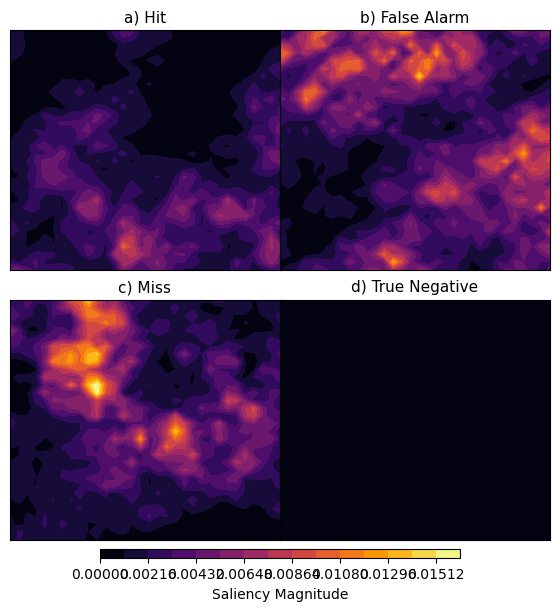

In [42]:
import matplotlib.pyplot as plt
from matplotlib import cm
import os
figsave_path = "./figures"
os.makedirs(figsave_path, exist_ok=True)


# Use inferno for strong contrast; switch to NWSReflectivity if needed
cmap = cm.inferno
levels = np.linspace(0, max(map(np.max, [saliency_tp, saliency_fp, saliency_fn, saliency_tn])), 16)

fig = plt.figure(figsize=(6, 6))

ax1 = fig.add_axes([0.05, 0.45, 0.45, 0.4])
ax1.set_title("a) Hit", fontsize=11)
ax1.contourf(saliency_tp, cmap=cmap, levels=levels)
ax1.tick_params(axis='both', direction='in', bottom=False, left=False, labelbottom=False, labelleft=False)

ax2 = fig.add_axes([0.5, 0.45, 0.45, 0.4])
ax2.set_title("b) False Alarm", fontsize=11)
ax2.contourf(saliency_fp, cmap=cmap, levels=levels)
ax2.tick_params(axis='both', direction='in', bottom=False, left=False, labelbottom=False, labelleft=False)

ax3 = fig.add_axes([0.05, 0.0, 0.45, 0.4])
ax3.set_title("c) Miss", fontsize=11)
ax3.contourf(saliency_fn, cmap=cmap, levels=levels)
ax3.tick_params(axis='both', direction='in', bottom=False, left=False, labelbottom=False, labelleft=False)

ax4 = fig.add_axes([0.5, 0.0, 0.45, 0.4])
ax4.set_title("d) True Negative", fontsize=11)
cs2 = ax4.contourf(saliency_tn, cmap=cmap, levels=levels)
ax4.tick_params(axis='both', direction='in', bottom=False, left=False, labelbottom=False, labelleft=False)

cbar_ax = fig.add_axes([0.2, -0.03, 0.6, 0.015])
cbar = fig.colorbar(cs2, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label('Saliency Magnitude', fontsize=10)
cbar.ax.tick_params(labelsize=10)

plt.savefig(f"{figsave_path}/saliency_layout.png", bbox_inches='tight', dpi=500)
plt.show()


In [45]:
!pip install metpy


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.3/424.3 kB 7.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 5.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 1.1 MB/s eta 0:00:00eta 0:00:01


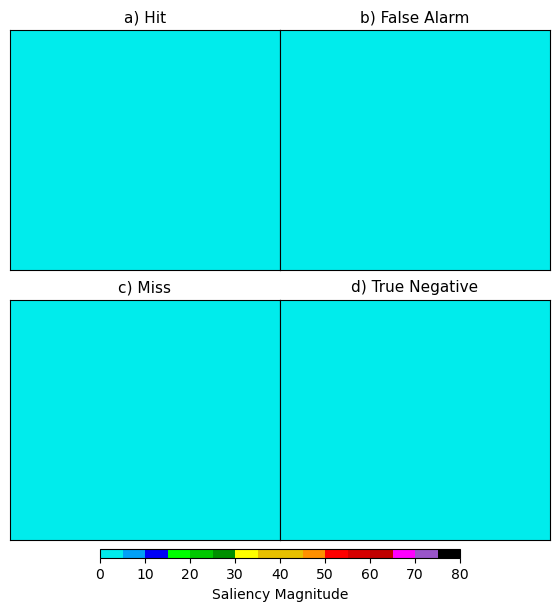

In [46]:
import matplotlib.pyplot as plt
from metpy.plots.ctables import registry  # for NWSReflectivity colormap
import numpy as np
import os

# Set output folder
figsave_path = "./figures"
os.makedirs(figsave_path, exist_ok=True)

# Use same color map and levels as reflectivity plots
cmap = registry.get_colortable('NWSReflectivity')
levels = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]

fig = plt.figure(figsize=(6, 6))

# a) Hit
ax1 = fig.add_axes([0.05, 0.45, 0.45, 0.4])
ax1.set_title("a) Hit", fontsize=11)
ax1.contourf(saliency_tp, cmap=cmap, levels=levels)
ax1.tick_params(axis='both', direction='in', bottom=False, left=False, labelbottom=False, labelleft=False)

# b) False Alarm
ax2 = fig.add_axes([0.5, 0.45, 0.45, 0.4])
ax2.set_title("b) False Alarm", fontsize=11)
ax2.contourf(saliency_fp, cmap=cmap, levels=levels)
ax2.tick_params(axis='both', direction='in', bottom=False, left=False, labelbottom=False, labelleft=False)

# c) Miss
ax3 = fig.add_axes([0.05, 0.0, 0.45, 0.4])
ax3.set_title("c) Miss", fontsize=11)
ax3.contourf(saliency_fn, cmap=cmap, levels=levels)
ax3.tick_params(axis='both', direction='in', bottom=False, left=False, labelbottom=False, labelleft=False)

# d) True Negative
ax4 = fig.add_axes([0.5, 0.0, 0.45, 0.4])
ax4.set_title("d) True Negative", fontsize=11)
cs2 = ax4.contourf(saliency_tn, cmap=cmap, levels=levels)
ax4.tick_params(axis='both', direction='in', bottom=False, left=False, labelbottom=False, labelleft=False)

# Shared colorbar
cbar_ax = fig.add_axes([0.2, -0.03, 0.6, 0.015])
cbar = fig.colorbar(cs2, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label('Saliency Magnitude', fontsize=10)
cbar.ax.tick_params(labelsize=10)

# Save and show
plt.savefig(f"{figsave_path}/saliency_layout_matched.png", bbox_inches='tight', dpi=500)
plt.show()


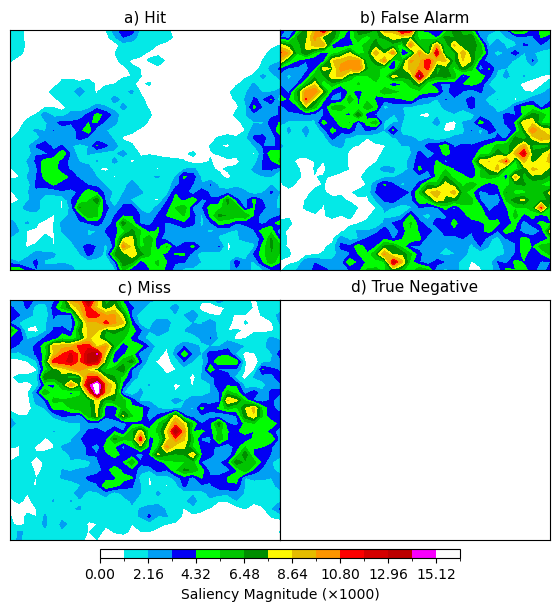

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.colors import ListedColormap, BoundaryNorm

# Ensure output directory
figsave_path = "./figures"
os.makedirs(figsave_path, exist_ok=True)

# Optional: scale saliency values to enhance visibility (only for visualization)
saliency_tp_vis = saliency_tp * 1000
saliency_fp_vis = saliency_fp * 1000
saliency_fn_vis = saliency_fn * 1000
saliency_tn_vis = saliency_tn * 1000

# Auto scale levels based on actual saliency values
sal_max = max(np.max(saliency_tp_vis), np.max(saliency_fp_vis),
              np.max(saliency_fn_vis), np.max(saliency_tn_vis))
levels = np.linspace(0, sal_max, 16)

# Approximate NWSReflectivity color scheme (hex values)
nws_colors = [
    "#ffffff", "#04e9e7", "#019ff4", "#0300f4", "#02fd02", "#01c501",
    "#008e00", "#fdf802", "#e5bc00", "#fd9500", "#fd0000", "#d40000",
    "#bc0000", "#f800fd", "#9854c6", "#fdfdfd"
]
cmap = ListedColormap(nws_colors)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

# Create the figure
fig = plt.figure(figsize=(6, 6))

# a) Hit
ax1 = fig.add_axes([0.05, 0.45, 0.45, 0.4])
ax1.set_title("a) Hit", fontsize=11)
ax1.contourf(saliency_tp_vis, cmap=cmap, norm=norm, levels=levels)
ax1.tick_params(axis='both', direction='in', bottom=False, left=False, labelbottom=False, labelleft=False)

# b) False Alarm
ax2 = fig.add_axes([0.5, 0.45, 0.45, 0.4])
ax2.set_title("b) False Alarm", fontsize=11)
ax2.contourf(saliency_fp_vis, cmap=cmap, norm=norm, levels=levels)
ax2.tick_params(axis='both', direction='in', bottom=False, left=False, labelbottom=False, labelleft=False)

# c) Miss
ax3 = fig.add_axes([0.05, 0.0, 0.45, 0.4])
ax3.set_title("c) Miss", fontsize=11)
ax3.contourf(saliency_fn_vis, cmap=cmap, norm=norm, levels=levels)
ax3.tick_params(axis='both', direction='in', bottom=False, left=False, labelbottom=False, labelleft=False)

# d) True Negative
ax4 = fig.add_axes([0.5, 0.0, 0.45, 0.4])
ax4.set_title("d) True Negative", fontsize=11)
cs2 = ax4.contourf(saliency_tn_vis, cmap=cmap, norm=norm, levels=levels)
ax4.tick_params(axis='both', direction='in', bottom=False, left=False, labelbottom=False, labelleft=False)

# Shared horizontal colorbar
cbar_ax = fig.add_axes([0.2, -0.03, 0.6, 0.015])
cbar = fig.colorbar(cs2, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label('Saliency Magnitude (×1000)', fontsize=10)
cbar.ax.tick_params(labelsize=10)

# Save the figure
plt.savefig(f"{figsave_path}/saliency_layout_matched.png", bbox_inches='tight', dpi=500)
plt.show()


In [48]:
def get_indices_by_case(y_true, y_pred, top_k=5):
    y_true = y_true.flatten()
    y_pred = np.round(y_pred.flatten())

    tp_idx = np.where((y_true == 1) & (y_pred == 1))[0][:top_k]
    fp_idx = np.where((y_true == 0) & (y_pred == 1))[0][:top_k]
    fn_idx = np.where((y_true == 1) & (y_pred == 0))[0][:top_k]
    tn_idx = np.where((y_true == 0) & (y_pred == 0))[0][:top_k]

    return tp_idx, fp_idx, fn_idx, tn_idx

def average_saliency(model, inputs):
    saliency_list = []
    for x in inputs:
        x = np.expand_dims(x, axis=0)
        sal = compute_saliency_map(model, x)
        saliency_list.append(sal)
    return np.mean(saliency_list, axis=0)

# Get top-5 indices
tp_idx, fp_idx, fn_idx, tn_idx = get_indices_by_case(label_test_scaled, predictions, top_k=5)

# Compute average saliency maps
saliency_tp = average_saliency(model, input_test_scaled[tp_idx])
saliency_fp = average_saliency(model, input_test_scaled[fp_idx])
saliency_fn = average_saliency(model, input_test_scaled[fn_idx])
saliency_tn = average_saliency(model, input_test_scaled[tn_idx])


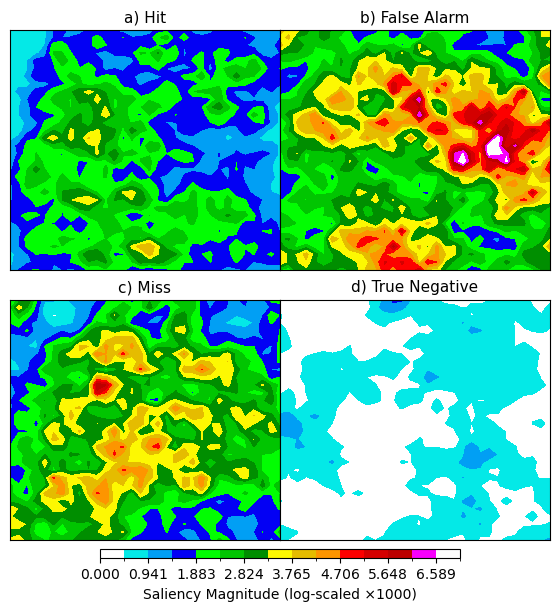

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.colors import ListedColormap, BoundaryNorm

figsave_path = "./figures"
os.makedirs(figsave_path, exist_ok=True)

# Log-transform and scale
saliency_tp_vis = np.log1p(saliency_tp) * 1000
saliency_fp_vis = np.log1p(saliency_fp) * 1000
saliency_fn_vis = np.log1p(saliency_fn) * 1000
saliency_tn_vis = np.log1p(saliency_tn) * 1000

# Get shared levels
sal_max = max(np.max(saliency_tp_vis), np.max(saliency_fp_vis),
              np.max(saliency_fn_vis), np.max(saliency_tn_vis))
levels = np.linspace(0, sal_max, 16)

# Approximate NWSReflectivity colormap
nws_colors = [
    "#ffffff", "#04e9e7", "#019ff4", "#0300f4", "#02fd02", "#01c501",
    "#008e00", "#fdf802", "#e5bc00", "#fd9500", "#fd0000", "#d40000",
    "#bc0000", "#f800fd", "#9854c6", "#fdfdfd"
]
cmap = ListedColormap(nws_colors)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

# Create plot
fig = plt.figure(figsize=(6, 6))

ax1 = fig.add_axes([0.05, 0.45, 0.45, 0.4])
ax1.set_title("a) Hit", fontsize=11)
ax1.contourf(saliency_tp_vis, cmap=cmap, norm=norm, levels=levels)
ax1.tick_params(axis='both', direction='in', bottom=False, left=False, labelbottom=False, labelleft=False)

ax2 = fig.add_axes([0.5, 0.45, 0.45, 0.4])
ax2.set_title("b) False Alarm", fontsize=11)
ax2.contourf(saliency_fp_vis, cmap=cmap, norm=norm, levels=levels)
ax2.tick_params(axis='both', direction='in', bottom=False, left=False, labelbottom=False, labelleft=False)

ax3 = fig.add_axes([0.05, 0.0, 0.45, 0.4])
ax3.set_title("c) Miss", fontsize=11)
ax3.contourf(saliency_fn_vis, cmap=cmap, norm=norm, levels=levels)
ax3.tick_params(axis='both', direction='in', bottom=False, left=False, labelbottom=False, labelleft=False)

ax4 = fig.add_axes([0.5, 0.0, 0.45, 0.4])
ax4.set_title("d) True Negative", fontsize=11)
cs2 = ax4.contourf(saliency_tn_vis, cmap=cmap, norm=norm, levels=levels)
ax4.tick_params(axis='both', direction='in', bottom=False, left=False, labelbottom=False, labelleft=False)

cbar_ax = fig.add_axes([0.2, -0.03, 0.6, 0.015])
cbar = fig.colorbar(cs2, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label('Saliency Magnitude (log-scaled ×1000)', fontsize=10)
cbar.ax.tick_params(labelsize=10)

plt.savefig(f"{figsave_path}/saliency_layout_avg_log.png", bbox_inches='tight', dpi=500)
plt.show()


In [ ]:
# —— Ensemble top K models —— 

from sklearn.metrics import f1_score
import numpy as np

# 1) Grab the top K hyperparameters
top_hps = tuner.get_best_hyperparameters(num_trials=5)

# 2) Rebuild each best model
models = [ MyHyperModel().build(hp) for hp in top_hps ]
# (Or, if you saved weights per trial, load them here onto each model.)

# 3) Run each model on the test set
all_preds = np.stack([m.predict(input_test_scaled).flatten() for m in models], axis=0)

# 4) Average their probabilities & threshold
ensemble_probs = all_preds.mean(axis=0)
ensemble_preds = (ensemble_probs >= 0.5).astype(int)

# 5) Compute & print ensemble F1
print("Ensemble F1:", f1_score(label_test_scaled, ensemble_preds))


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Ensemble F1: 0.17940199335548174


In [ ]:
pred_labels = np.round(predictions.flatten())
true_labels = label_test_scaled.flatten()
false_neg_idx = np.where((true_labels == 1) & (pred_labels == 0))[0]
false_pos_idx = np.where((true_labels == 0) & (pred_labels == 1))[0]
true_pos_idx = np.where((true_labels == 1) & (pred_labels == 1))[0]
true_neg_idx = np.where((true_labels == 0) & (pred_labels == 0))[0]

print("Number of false negatives:", len(false_neg_idx))
print("Number of false positives:", len(false_pos_idx))



In [ ]:
# Assuming lat_test and lon_test are arrays with shape (num_samples, height, width)
#central_lat = lat_test[:, lat_test.shape[1]//2, lat_test.shape[2]//2]
#central_lon = lon_test[:, lon_test.shape[1]//2, lon_test.shape[2]//2]

#lats_false_neg = central_lat[false_neg_idx]
#lons_false_neg = central_lon[false_neg_idx]

#lats_false_pos = central_lat[false_pos_idx]
#lons_false_pos = central_lon[false_pos_idx]
# Assuming lat_test and lon_test are 1D arrays with one coordinate per sample
lat_false_neg = lat_test[false_neg_idx]
lon_false_neg = lon_test[false_neg_idx]

lat_false_pos = lat_test[false_pos_idx]
lon_false_pos = lon_test[false_pos_idx]

lat_true_pos = lat_test[true_pos_idx]
lon_true_pos = lon_test[true_pos_idx]

lat_true_neg = lat_test[true_neg_idx]
lon_true_neg = lon_test[true_neg_idx]




In [ ]:
print("Unique latitudes in test set:", np.unique(lat_test))
print("Unique longitudes in test set:", np.unique(lon_test))


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(lon_false_neg, lat_false_neg, marker='x', color='red', label='False Negatives')
plt.scatter(lon_false_pos, lat_false_pos, marker='o', color='blue', label='False Positives')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution of Misclassifications')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())



lon_min, lon_max = np.min(lon_test)-15, np.max(lon_test)+15
lat_min, lat_max = np.min(lat_test)-15, np.max(lat_test)+15
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot misclassified points:
ax.scatter(lon_false_neg, lat_false_neg, color='red', marker='x', s=100,
           transform=ccrs.PlateCarree(), label='False Negatives')
ax.scatter(lon_false_pos, lat_false_pos, color='blue', marker='o', s=100,
           transform=ccrs.PlateCarree(), label='False Positives')

plt.title("Misclassified Test Samples on Map")
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set map extent (adjust margins as desired)
lon_min, lon_max = np.min(lon_test) - 10, np.max(lon_test) + 10
lat_min, lat_max = np.min(lat_test) - 10, np.max(lat_test) + 10
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
# Plot misclassified points
ax.scatter(lon_false_neg, lat_false_neg, color='red', marker='x', s=100,
           transform=ccrs.PlateCarree(), label='False Negatives')
ax.scatter(lon_false_pos, lat_false_pos, color='blue', marker='o', s=100,
           transform=ccrs.PlateCarree(), label='False Positives')



# Plot correctly classified points
ax.scatter(lon_true_pos, lat_true_pos, color='green', marker='^', s=100,
           transform=ccrs.PlateCarree(), label='True Positives')
ax.scatter(lon_true_neg, lat_true_neg, color='orange', marker='s', s=100,
           transform=ccrs.PlateCarree(), label='True Negatives')

plt.title("Test Set Classification Results on Map")
plt.legend()
plt.show()


In [ ]:
print("Total samples:", len(sample_lat))
print("Unique latitudes:", len(np.unique(sample_lat)))
print("Unique longitudes:", len(np.unique(sample_lon)))


In [ ]:
print("First 10 latitudes:", sample_lat[:10])
print("First 10 longitudes:", sample_lon[:10])


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(sample_lon, sample_lat, c='green', marker='o')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Per-Sample Weighted Centroid Coordinates')
plt.show()


In [ ]:


# --- Permutation Importance ---
# Evaluate baseline performance using your loss metric (here, the custom f1_loss_sigmoid)
# model.metrics_names gives a list where index 0 is 'loss'
baseline_results = model.evaluate(input_test_scaled, label_test_scaled,
                                  batch_size=label_test_scaled.shape[0],
                                  verbose=0)
baseline_loss = baseline_results[model.metrics_names.index('loss')]
print("Baseline loss:", baseline_loss)

# Set the number of repetitions for averaging
n_repeats = 5
n_features = input_test_scaled.shape[-1]
permutation_importances = np.zeros(n_features)

# Loop over each feature (channel)
for feature_idx in range(n_features):
    permuted_losses = []
    for _ in range(n_repeats):
        # Copy the test set to avoid modifying the original
        X_permuted = np.copy(input_test_scaled)
        # Permute the values of the selected feature across samples
        perm = np.random.permutation(X_permuted.shape[0])
        X_permuted[:, :, :, feature_idx] = X_permuted[perm, :, :, feature_idx]
        
        # Evaluate the model on the permuted test set
        permuted_results = model.evaluate(X_permuted, label_test_scaled,
                                          batch_size=label_test_scaled.shape[0],
                                          verbose=0)
        permuted_loss = permuted_results[model.metrics_names.index('loss')]
        permuted_losses.append(permuted_loss)
    
    avg_permuted_loss = np.mean(permuted_losses)
    # The difference between the permuted loss and baseline loss indicates feature importance:
    # A larger increase means the feature is more important.
    permutation_importances[feature_idx] = avg_permuted_loss - baseline_loss
    print(f"Feature {feature_idx} - Increase in Loss: {permutation_importances[feature_idx]}")

print("Permutation Importances (increase in loss) for all features:", permutation_importances)


Feature 7 - Increase in Loss: 0.016756932437419894


Feature 8 - Increase in Loss: -0.007640318572521204


Feature 9 - Increase in Loss: 0.028586935997009275


Feature 10 - Increase in Loss: -0.0046684518456459045


Feature 11 - Increase in Loss: 0.0005360260605812017


Feature 12 - Increase in Loss: 0.03804460763931275


Feature 13 - Increase in Loss: -0.0052315175533294705


Feature 14 - Increase in Loss: 0.006075891852378848


Feature 15 - Increase in Loss: 0.01109253615140915


Feature 16 - Increase in Loss: -0.011178651452064516


Feature 17 - Increase in Loss: 0.00400848984718323
Permutation Importances (increase in loss) for all features: [ 0.01839801 -0.00107002 -0.00043198  0.0125279   0.01032393 -0.00190592
 -0.01343649  0.01675693 -0.00764032  0.02858694 -0.00466845  0.00053603
  0.03804461 -0.00523152  0.00607589  0.01109254 -0.01117865  0.00400849]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose permutation_importances is the numpy array you printed:
# e.g., [0.0820, 0.0824, 0.0815, 0.0864, 0.0121, ...]

feature_indices = np.arange(len(permutation_importances))

plt.figure(figsize=(8, 5))
plt.bar(feature_indices, permutation_importances)
plt.xlabel("Feature Index")
plt.ylabel("Increase in Loss (Permutation Importance)")
plt.title("Permutation Importance by Feature")
plt.xticks(feature_indices, [f"F{i}" for i in feature_indices], rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
sample_index = 0
sample_input = input_test_scaled[sample_index:sample_index+1]

# Compute the saliency map for the selected test sample
saliency_map = compute_saliency_map(model, sample_input)

# Plot the saliency map
plt.figure(figsize=(8, 8))
plt.imshow(saliency_map, cmap='hot')
plt.colorbar()
plt.title(f"Saliency Map for Sample Index {sample_index}")
plt.show()



In [ ]:
sample_index = 1
sample_input = input_test_scaled[sample_index:sample_index+1]

# Compute saliency maps per channel for the selected input sample
saliency_maps, channel_importance = compute_saliency_per_channel(model, sample_input)

# Plot the saliency maps for each channel
num_channels = saliency_maps.shape[-1]
cols = 5  # Set number of columns for plotting
rows = int(np.ceil(num_channels / cols))
plt.figure(figsize=(15, rows * 3))
for c in range(num_channels):
    plt.subplot(rows, cols, c + 1)
    plt.imshow(saliency_maps[:, :, c], cmap='hot')
    plt.title(f'Channel {c}\nMean: {channel_importance[c]:.4f}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Print aggregated channel importance values
print("Channel importance (mean saliency per channel):")
for c, imp in enumerate(channel_importance):
    print(f"Channel {c}: {imp:.4f}")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Compute per‑sample, per‑channel saliency importances
all_imps = []
for x in input_test_scaled:             # each x has shape (32,32,channels)
    _, imp = compute_saliency_per_channel(best_model, x[np.newaxis,...])
    all_imps.append(imp)               # imp.shape == (channels,)
all_imps = np.stack(all_imps)          # shape (N_samples, channels)

# 2) Average importance across samples
mean_imp = all_imps.mean(axis=0)       # shape (channels,)

# 3) Build a DataFrame mapping feature→plevel→importance
df = pd.DataFrame({
    "feature": var_list,
    "plevel": plevel_list,
    "importance": mean_imp
})

# 4) Group by pressure level and plot
grouped = df.groupby("plevel")["importance"].mean().reset_index()
plt.figure(figsize=(6,4))
plt.bar(grouped["plevel"].astype(str), grouped["importance"])
plt.xlabel("Pressure level (hPa or False=surface)")
plt.ylabel("Mean saliency importance")
plt.title("Average feature importance by pressure level")
plt.show()


In [ ]:
# 1) Print out full test‐set metrics by name
test_results = model.evaluate(
    input_test_scaled,
    label_test_scaled,
    batch_size=label_test_scaled.shape[0],
    verbose=0
)
print(dict(zip(model.metrics_names, test_results)))

# 2) Peek at the end of your training history for F1 improvements
import pandas as pd
hist_df = pd.DataFrame(history.history)
print(hist_df[['f1_score','val_f1_score']].tail())

# 3) (Optional) Plot train vs. val F1 over epochs
import matplotlib.pyplot as plt
plt.plot(hist_df['f1_score'],    label='train F1')
plt.plot(hist_df['val_f1_score'],label='val F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.title('Focal‐Loss Training F1 Curves')
plt.show()


In [ ]:
# Replace your rebuild logic:
# top_hps = tuner.get_best_hyperparameters(num_trials=5)
# models  = [MyHyperModel().build(hp) for hp in top_hps]

# With this single line:
models = tuner.get_best_models(num_models=5)

# Then stack and average as before:
all_preds     = np.stack([m.predict(input_test_scaled).flatten() for m in models], axis=0)
ensemble_probs= all_preds.mean(axis=0)
ensemble_preds= (ensemble_probs >= 0.5).astype(int)
print("Ensemble F1:", f1_score(label_test_scaled, ensemble_preds))


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Ensemble F1: 0.5476190476190477
